# <a id='toc1_'></a>[0️⃣ ReviewOfWork (Main Notebook) - Imports](#toc0_)

In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
%load_ext autoreload
%autoreload 3
# # Add exclusions for metaclass-using modules
# %aimport -neuropy.core.session.dataSession
# %aimport -neuropy.core.session.Formats.BaseDataSessionFormats
# %aimport -neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat
# %aimport -neuropy.core.session.Formats.Specific.BapunDataSessionFormat 
# %aimport -neuropy.core.session.Formats.Specific.RachelDataSessionFormat
# %aimport -neuropy.core.session.Formats.Specific.HiroDataSessionFormat

# !pip install viztracer
%load_ext viztracer
from viztracer import VizTracer

# %load_ext memory_profiler

import sys
from pathlib import Path

import os
os.environ['QT_API'] = 'pyqt5'
os.environ['PYQTGRAPH_QT_LIB'] = 'PyQt5'

# from PyQt5.QtWebEngineWidgets import QWebEngineView ## this must come first, before any QtApplication is made: 'ImportError: QtWebEngineWidgets must be imported or Qt.AA_ShareOpenGLContexts must be set before a QCoreApplication instance is created'

# required to enable non-blocking interaction:
%gui qt5

import importlib
from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy

from attrs import define, field, fields, Factory, make_class
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH
# Override default pprint
builtins.pprint = wide_pprint

ip = get_ipython()

from pyphocorehelpers.ipython_helpers import CustomFormatterMagics

# Register the magic
get_ipython().register_magics(CustomFormatterMagics)



from pyphocorehelpers.pyqt_ipython_rendering_helpers import PyQtFormatters
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_widget_geometry

# Register formatters for specific PyQt5 types
# Create an instance and register formatters
qt_formatters = PyQtFormatters()
qt_formatters.register()

# import pho_jupyter_preview_widget
# # from pho_jupyter_preview_widget.pho_jupyter_preview_widget.display_helpers import array_repr_with_graphical_preview
# # from pho_jupyter_preview_widget.pho_jupyter_preview_widget.ipython_helpers import PreviewWidgetMagics
# from pho_jupyter_preview_widget.display_helpers import array_repr_with_graphical_preview
# from pho_jupyter_preview_widget.ipython_helpers import PreviewWidgetMagics

# # # # Register the magic
# ip.register_magics(PreviewWidgetMagics)

# %config_ndarray_preview width=500

# Register the custom display function for NumPy arrays
# ip.display_formatter.formatters['text/html'].for_type(np.ndarray, lambda arr: array_preview_with_graphical_shape_repr_html(arr))
# ip = array_repr_with_graphical_shape(ip=ip)
# ip = array_repr_with_graphical_preview(ip=ip)
# ip = dataframe_show_more_button(ip=ip)

text_formatter: PlainTextFormatter = ip.display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str
from pyphocorehelpers.indexing_helpers import get_dict_subset

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
import pyphocorehelpers.programming_helpers as programming_helpers

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
import nptyping as ND
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, find_local_session_paths
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns, parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables
from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes
## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots

doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
print(f"doc_output_parent_folder: {doc_output_parent_folder}")
assert doc_output_parent_folder.exists()

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook
# _notebook_execution_logger: NotebookCellExecutionLogger = NotebookCellExecutionLogger(notebook_path=_notebook_path, enable_logging_to_file=False) # Builds a logger that records info about this notebook

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_evaluate_required_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme # used in perform_pipeline_save
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import PipelineJupyterHelpers, CustomProcessingPhases


import pyphoplacecellanalysis.External.pyqtgraph as pg
pg.setConfigOptions(useOpenGL=True)    # Use OpenGL for rendering which handles larger coordinates

from pyphocorehelpers.exception_helpers import ExceptionPrintingContext, CapturedException
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates, DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions,  RankOrderComputationsContainer, RankOrderResult, RankOrderAnalyses
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer, NonPBEDimensionalDecodingResult, Compute_NonPBE_Epochs, KnownFilterEpochs
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder, computation_precidence_specifying_function, global_function

from neuropy.utils.mixins.binning_helpers import transition_matrix
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates, get_proper_global_spikes_df

from pyphocorehelpers.Filesystem.path_helpers import set_posix_windows

from pyphocorehelpers.assertion_helpers import Assert

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

import seaborn as sns

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap, visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState
from pyphoplacecellanalysis.General.Model.SpecificComputationParameterTypes import ComputationKWargParameters
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
# from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import PipelineJupyterHelpers, CustomProcessingPhases, PipelinePickleFileSelectorWidget
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.PhoContainerTool import GenericMatplotlibContainer, GenericPyQtGraphContainer, PhoBaseContainerTool

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

def get_global_variable(var_name):
    """ used by `PipelineJupyterHelpers._build_pipeline_custom_processing_mode_selector_widget(...)` to update the notebook's variables """
    return globals()[var_name]
    
def update_global_variable(var_name, value):
    """ used by `PipelineJupyterHelpers._build_pipeline_custom_processing_mode_selector_widget(...)` to update the notebook's variables """
    globals()[var_name] = value

from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path(r'/home/halechr/FastData'), Path('/Volumes/SwapSSD/Data'), Path('/Users/pho/data'), Path(r'/media/halechr/MAX/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data'), Path(r'/Users/pho/cloud/turbo/Data')] # Path('/Volumes/FedoraSSD/FastData'), 
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
    global global_data_root_parent_path
    new_global_data_root_parent_path = new_path.resolve()
    global_data_root_parent_path = new_global_data_root_parent_path
    print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
    assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
            
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
PyQt5 formatters registered successfully
doc_output_parent_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation
field.name: "merged_directional_placefields", variable_name: "merged_directional_placefields"
field.name: "rank_order_shuffle_analysis", variable_name: "rank_order_shuffle_analysis"
field.name: "directional_decoders_decode_continuous", variable_name: "directional_decoders_decode_continuous"
field.name: "directional_decoders_evaluate_epochs", variable_name: "directional_decoders_evaluate_epochs"
field.name: "directional_decoders_epoch_heuristic_scoring", variable_name: "directional_decoders_epoch_heuristic_scoring"
field.name: "directional_train_test_split", variable_name: "directional_train_test_split"
field.name: "long_short_decoding_analyses", variable_name: "long_short_decoding_analyses"
field.name: "long_short_rate_remapping", variable_name: "long_short_rate_remapping"
field.name: "

ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

# <a id='toc2_'></a>[0️⃣ Load Pipeline](#toc0_)

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15') # Recomputed 2025-04-16 03:38 
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43') # Recomputed 2025-04-04 02:08 -- ``  
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31') # Recomputed 2025-01-16 03:21 
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19') # Recomputed 2025-04-15 21:27
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46') # Recomputed 2025-04-16 01:15 
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30') ## BLOCKING ERROR with pf2D computation (empty) for 5Hz 2024-12-02 15:24 
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50') # Recomputed 2025-04-16 02:50 
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54') # Recomputed 2024-12-16 19:29 -- about 3 good replays
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3') # Recomputed 2024-12-16 19:32 
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25') # Recomputed 2024-12-16 19:33 -- about 5 good replays
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54') # Recomputed 2024-12-16 19:36 -- TONS of good replays, 10+ pages of them 

local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

epoch_name_includelist = None
active_computation_functions_name_includelist=['lap_direction_determination',
                                                'pf_computation',
                                                'pfdt_computation',
                                                # 'firing_rate_trends',
                                                # 'pf_dt_sequential_surprise', 
                                            #    'ratemap_peaks_prominence2d',
                                                'position_decoding', 
                                                # 'position_decoding_two_step', #'directional_decoders_epoch_heuristic_scoring',
                                            #    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping',
                                            #     'long_short_inst_spike_rate_groups',
                                            #     'long_short_endcap_analysis',
                                            
]

## 'split_to_directional_laps' -- is global



# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

selector, on_value_change = PipelineJupyterHelpers._build_pipeline_custom_processing_mode_selector_widget(update_global_variable_fn=update_global_variable, debug_print=False, enable_full_view=True)
# selector.value = 'clean_run'
selector.value = 'continued_run'
# selector.value = 'final_run'
on_value_change(dict(new=selector.value)) ## do update manually so the workspace variables reflect the set values
## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.
print(f"saving_mode: {saving_mode}, force_reload: {force_reload}")

extended_computations_include_includelist_phase_dict: Dict[str, CustomProcessingPhases] = CustomProcessingPhases.get_extended_computations_include_includelist_phase_dict()

current_phase: CustomProcessingPhases = CustomProcessingPhases[selector.value]  # Assuming selector.value is an instance of CustomProcessingPhases
extended_computations_include_includelist: List[str] = [key for key, value in extended_computations_include_includelist_phase_dict.items() if value <= current_phase]
display(extended_computations_include_includelist)
force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous'] # 

# ## INPUTS: basedir
active_session_pickle_file_widget = PipelinePickleFileSelectorWidget(directory=basedir, on_update_global_variable_callback=update_global_variable, on_get_global_variable_callback=get_global_variable)

_subfn_load, _subfn_save, _subfn_compute = active_session_pickle_file_widget._build_load_save_callbacks(global_data_root_parent_path=global_data_root_parent_path, active_data_mode_name=active_data_mode_name, basedir=basedir, saving_mode=saving_mode, force_reload=force_reload,
                                                             extended_computations_include_includelist=extended_computations_include_includelist, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist)

## try selecting the first
did_find_valid_selection: bool = active_session_pickle_file_widget.try_select_first_valid_files()

# Display the widget
active_session_pickle_file_widget.servable()
# active_session_pickle_file_widget.try_select_first_valid_files()

# OUTPUTS: active_session_pickle_file_widget, widget.active_local_pkl, widget.active_global_pkl


basedir: W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43


saving_mode: PipelineSavingScheme.SKIP_SAVING, force_reload: False


['lap_direction_determination',
 'pf_computation',
 'pfdt_computation',
 'position_decoding',
 'firing_rate_trends',
 'extended_stats',
 'long_short_decoding_analyses',
 'jonathan_firing_rate_analysis',
 'long_short_fr_indicies_analyses',
 'long_short_post_decoding',
 'long_short_inst_spike_rate_groups',
 'long_short_endcap_analysis',
 'split_to_directional_laps',
 'merged_directional_placefields',
 'directional_decoders_decode_continuous',
 'directional_decoders_evaluate_epochs',
 'directional_decoders_epoch_heuristic_scoring',
 'non_PBE_epochs_results',
 'generalized_specific_epochs_decoding']

Column
    [0] Tabulator(disabled=True, height=400, page_size=10, pagination='local', selection=[0], show_index=False, sorters=[{'field': 'Modification D...], value=              ...)
    [1] Tabulator(disabled=True, height=400, page_size=10, pagination='local', selection=[0], show_index=False, sorters=[{'field': 'Modification D...], value=              ...)
    [2] Row
        [0] Button(button_type='success', name='Save')
        [1] Button(button_type='primary', name='Load')
        [2] Button(button_type='warning', name='Compute')

In [3]:
if did_find_valid_selection:
	_subfn_load()

custom_suffix: "_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0"
Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0.pkl"... 	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
	done.
build_logger(full_logger_string="2025-05-14_01-05-29.Apogee.kdiba.gor01.one.2006-6-09_1-22-43", file_logging_dir: None):
done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0.pkl.
properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'position_decoding']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function de

saving_mode.shouldSave == False, so not saving at the end of batch_load_session
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
were pipeline preprocessing parameters missing and updated?: False
	 !!!||||||||||||||||||> RUNNING `PostHocPipelineFixup.FINAL_UPDATE_ALL(...)`:
starting `PostHocPipelineFixup.FINAL_UPDATE_ALL(...)`.

In [ ]:
## Set default local comp pkl:
default_selected_local_file_name: str = 'loadedSessPickle.pkl'
default_local_section_indicies = [active_session_pickle_file_widget.local_file_browser_widget._data['File Name'].tolist().index(default_selected_local_file_name)]
active_session_pickle_file_widget.local_file_browser_widget.selection = default_local_section_indicies

## Set default global computation pkl:
default_selected_global_file_name: str = 'global_computation_results.pkl'
default_global_section_indicies = [active_session_pickle_file_widget.global_file_browser_widget._data['File Name'].tolist().index(default_selected_global_file_name)]
active_session_pickle_file_widget.global_file_browser_widget.selection = default_global_section_indicies

In [ ]:
from pyphoplacecellanalysis.GUI.IPyWidgets.SaveAsWidget import PipelineBackupWidget

backup_widget = PipelineBackupWidget(curr_active_pipeline)
backup_widget.servable()


## <a id='toc2_1_'></a>[2024-06-25 - Load from saved custom](#toc0_)

In [ ]:
curr_active_pipeline, custom_suffix, proposed_load_pkl_path = active_session_pickle_file_widget.on_load_local(global_data_root_parent_path=global_data_root_parent_path, active_data_mode_name=active_data_mode_name, basedir=basedir, saving_mode=saving_mode, force_reload=force_reload)
curr_active_pipeline = active_session_pickle_file_widget.on_load_global(curr_active_pipeline=curr_active_pipeline, basedir=basedir, extended_computations_include_includelist=extended_computations_include_includelist, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
                                       skip_global_load=False, force_reload=False, override_global_computation_results_pickle_path=active_session_pickle_file_widget.active_global_pkl)



In [ ]:
# Loads custom pipeline pickles that were saved out via `custom_save_filepaths['pipeline_pkl'] = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename=custom_save_filenames['pipeline_pkl'])`

## INPUTS: global_data_root_parent_path, active_data_mode_name, basedir, saving_mode, force_reload, custom_save_filenames
# custom_suffix: str = '_withNewKamranExportedReplays'

# custom_suffix: str = '_withNewComputedReplays'
# custom_suffix: str = '_withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0'

# custom_save_filenames = {
#     'pipeline_pkl':f'loadedSessPickle{custom_suffix}.pkl',
#     'global_computation_pkl':f"global_computation_results{custom_suffix}.pkl",
#     'pipeline_h5':f'pipeline{custom_suffix}.h5',
# }
# print(f'custom_save_filenames: {custom_save_filenames}')
# custom_save_filepaths = {k:v for k, v in custom_save_filenames.items()}

# # ==================================================================================================================== #
# # PIPELINE LOADING                                                                                                     #
# # ==================================================================================================================== #
# # load the custom saved outputs
# active_pickle_filename = custom_save_filenames['pipeline_pkl'] # 'loadedSessPickle_withParameters.pkl'
# print(f'active_pickle_filename: "{active_pickle_filename}"')
# # assert active_pickle_filename.exists()
# active_session_h5_filename = custom_save_filenames['pipeline_h5'] # 'pipeline_withParameters.h5'
# print(f'active_session_h5_filename: "{active_session_h5_filename}"')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
## DO NOT allow recompute if the file doesn't exist!!
# Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/loadedSessPickle_withNewComputedReplays.pkl"... done.
# Failure loading W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle_withNewComputedReplays.pkl.
# proposed_load_pkl_path = basedir.joinpath(active_pickle_filename).resolve()

## INPUTS: widget.active_global_pkl, widget.active_global_pkl

if active_session_pickle_file_widget.active_global_pkl is None:
    skip_global_load: bool = True
    override_global_computation_results_pickle_path = None
else:
    skip_global_load: bool = False
    override_global_computation_results_pickle_path = active_session_pickle_file_widget.active_global_pkl.resolve()
    Assert.path_exists(override_global_computation_results_pickle_path)
    override_global_computation_results_pickle_path


proposed_load_pkl_path = active_session_pickle_file_widget.active_local_pkl.resolve()
Assert.path_exists(proposed_load_pkl_path)
proposed_load_pkl_path

custom_suffix: str = active_session_pickle_file_widget.try_extract_custom_suffix()
print(f'custom_suffix: "{custom_suffix}"')

## OUTPUTS: custom_suffix, proposed_load_pkl_path, (override_global_computation_results_pickle_path, skip_global_load)
from pyphocorehelpers.Filesystem.path_helpers import set_posix_windows
## INPUTS: proposed_load_pkl_path
assert proposed_load_pkl_path.exists(), f"for a saved custom the file must exist!"

epoch_name_includelist=None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation','firing_rate_trends', 'position_decoding']

with set_posix_windows():
    curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                            computation_functions_name_includelist=active_computation_functions_name_includelist,
                                            saving_mode=saving_mode, force_reload=force_reload,
                                            skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True, active_pickle_filename=proposed_load_pkl_path) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'

## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        if saving_mode == PipelineSavingScheme.SKIP_SAVING:
            print(f'WARNING: PipelineSavingScheme.SKIP_SAVING but need to save post_compute_validate changes!!')
        else:
            curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')

print(f'Pipeline loaded from custom pickle!!')
## OUTPUT: curr_active_pipeline

# ==================================================================================================================== #
# Global computations loading:                                                                                            #
# ==================================================================================================================== #
# Loads saved global computations that were saved out via: `custom_save_filepaths['global_computation_pkl'] = curr_active_pipeline.save_global_computation_results(override_global_pickle_filename=custom_save_filenames['global_computation_pkl'])`
## INPUTS: custom_save_filenames
## INPUTS: curr_active_pipeline, override_global_computation_results_pickle_path, extended_computations_include_includelist

override_global_computation_results_pickle_path = None
# override_global_computation_results_pickle_path = custom_save_filenames['global_computation_pkl']
print(f'override_global_computation_results_pickle_path: "{override_global_computation_results_pickle_path}"')

# Pre-load ___________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

# Try Unpickling Global Computations to update pipeline ______________________________________________________________ #
if (not force_reload) and (not skip_global_load): # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # INPUTS: override_global_computation_results_pickle_path
        with set_posix_windows():
            sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(override_global_computation_results_pickle_path=override_global_computation_results_pickle_path,
                                                                                            allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist, ) # is new
            print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
            did_any_paths_change: bool = curr_active_pipeline.post_load_fixup_sess_basedirs(updated_session_basepath=deepcopy(basedir)) ## use INPUT: basedir
            
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except Exception as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise

# Post-Load __________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')



## fixup missing paths
# self.basepath: WindowsPath('/nfs/turbo/umms-kdiba/KDIBA/gor01/one/2006-6-09_1-22-43')

## INPUTS: basedir
did_any_paths_change: bool = curr_active_pipeline.post_load_fixup_sess_basedirs(updated_session_basepath=deepcopy(basedir)) ## use INPUT: basedir

# Compute ____________________________________________________________________________________________________________ #
curr_active_pipeline.reload_default_computation_functions()
force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# Post-compute _______________________________________________________________________________________________________ #
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=[], debug_print=True)
print(f'Post-compute validation: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

# Post-Load __________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

print(f'force_reload: {force_reload}, saving_mode: {saving_mode}')
force_reload
saving_mode

In [ ]:
## indicate that it was loaded with a custom suffix
curr_active_pipeline.pickle_path ## correct
curr_active_pipeline.global_computation_results_pickle_path ## correct

curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, override_pickle_path=curr_active_pipeline.pickle_path, active_pickle_filename=curr_active_pipeline.pickle_path.name) #active_pickle_filename=
curr_active_pipeline.save_global_computation_results(override_global_pickle_path=curr_active_pipeline.global_computation_results_pickle_path)

## <a id='toc2_2_'></a>[0️⃣ RESUME Normal Pipeline Load](#toc0_)

## <a id='toc2_3_'></a>[0️⃣ Normal Pipeline Load](#toc0_)

In [ ]:
# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']

curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=True, fail_on_exception=False) #, time_bin_size = 0.025 time_bin_size = 0.058, override_parameters_flat_keypaths_dict = dict(), 
# , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'


In [ ]:
# curr_active_pipeline.get_failed_computations()
curr_active_pipeline.clear_all_failed_computations()

In [ ]:

# {'maze1_odd': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze2_odd': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze_odd': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze1_even': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze2_even': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze_even': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze1_any': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze2_any': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')},
#  'maze_any': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:1065<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')}}

_out = curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_split_to_directional_laps'], fail_on_exception=True, debug_print=True)


# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_split_to_directional_laps'], computation_kwargs_list=[{}], 
#                                                   enabled_filter_names=None, fail_on_exception=True, debug_print=True)


In [ ]:

## Post Compute Validate 2023-05-16:
# was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
was_updated = False
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')

force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # curr_active_pipeline.load_pickled_global_computation_results()
        with set_posix_windows():
            sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist) # is new
            
        print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except Exception as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise

# Recomputing active_epoch_placefields... 	 done.
# Recomputing active_epoch_placefields2D... 	 done.
# WARN: f"len(self.is_non_firing_time_bin): 30459, self.num_time_windows: 30762", trying to recompute them....
# UNHANDLED EXCEPTION: Unable to allocate 3.46 GiB for an array with shape (15124, 30724) and data type float64

In [ ]:
curr_active_pipeline.global_computation_results.accumulated_errors

In [ ]:
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
curr_active_pipeline.reload_default_computation_functions()
force_recompute_global = force_reload # Post-load global computations: needs_computation_output_dict: ['rank_order_shuffle_analysis', 'directional_train_test_split', 'short_long_pf_overlap_analyses', 'wcorr_shuffle_analysis', 'extended_pf_peak_information', 'position_decoding_two_step']
# force_recompute_global = True

In [ ]:
fail_on_exception = False

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=fail_on_exception, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=fail_on_exception, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=[], debug_print=True)
print(f'Post-compute validation: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

## <a id='toc2_4_'></a>[0️⃣ Shared Post-Pipeline load stuff](#toc0_)

In [4]:
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_GL'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_rMBP' # TODO: Change this as needed, templating isn't actually doing anything rn.
BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Apogee'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Lab'
 
try:
    if custom_suffix is not None:
        BATCH_DATE_TO_USE = f'{BATCH_DATE_TO_USE}{custom_suffix}'
        print(f'Adding custom suffix: "{custom_suffix}" - BATCH_DATE_TO_USE: "{BATCH_DATE_TO_USE}"')
except NameError as err:
    custom_suffix = None
    print(f'NO CUSTOM SUFFIX.')

known_collected_output_paths = [Path(v).resolve() for v in ['/nfs/turbo/umms-kdiba/Data/Output/collected_outputs', '/home/halechr/FastData/collected_outputs/',
                                                           '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                           r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs',
                                                           r"K:\scratch\collected_outputs",
                                                           '/Users/pho/data/collected_outputs',
                                                          'output/gen_scripts/']]
collected_outputs_path = find_first_extant_path(known_collected_output_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: {collected_outputs_path} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_path: {collected_outputs_path}')
# collected_outputs_path.mkdir(exist_ok=True)
# assert collected_outputs_path.exists()

## Build the output prefix from the session context:
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: "{CURR_BATCH_OUTPUT_PREFIX}"')

Adding custom suffix: "_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0" - BATCH_DATE_TO_USE: "2025-05-14_Apogee_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0"
collected_outputs_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs
CURR_BATCH_OUTPUT_PREFIX: "2025-05-14_Apogee_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-2006-6-09_1-22-43"


## <a id='toc2_5_'></a>[Specific Recomputations](#toc0_)

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
each_epoch_each_result_computation_completion_times

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
curr_active_pipeline.clear_all_failed_computations()

In [ ]:
curr_active_pipeline.global_computation_results.computation_config.instantaneous_time_bin_size_seconds = 0.002

In [ ]:
force_recompute_global

In [ ]:
force_recompute_global = False

In [ ]:
extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'extended_stats',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis',
    'directional_decoders_decode_continuous',
    'directional_decoders_evaluate_epochs',
    'directional_decoders_epoch_heuristic_scoring',
] # do only specified

# ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

# force_recompute_override_computations_includelist = [
#     'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',
#     'split_to_directional_laps', 'lap_direction_determination', 'DirectionalLaps',
#     'merged_directional_placefields',
#     'directional_decoders_decode_continuous',
# ]
force_recompute_override_computations_includelist = None

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
newly_computed_values



In [ ]:

# extended_computations_include_includelist=['ratemap_peaks_prominence2d', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',] # do only specified
extended_computations_include_includelist=['rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs' ] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = curr_active_pipeline.batch_extended_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = curr_active_pipeline.batch_evaluate_required_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = curr_active_pipeline.batch_extended_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)


In [ ]:
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = curr_active_pipeline.batch_evaluate_required_computations(include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
curr_active_pipeline.global_computation_config


In [ ]:
# mmm ## lots of m's to break computations

## Next wave of computations
extended_computations_include_includelist=['directional_decoders_epoch_heuristic_scoring',] # do only specified
force_recompute_override_computations_includelist = deepcopy(extended_computations_include_includelist)
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)

needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
# mmm ## lots of m's to break computations

## Next wave of computations
extended_computations_include_includelist=['rank_order_shuffle_analysis',] # do only specified
force_recompute_override_computations_includelist = deepcopy(extended_computations_include_includelist)
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)

needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
# 'lap_direction_determination'
extended_computations_include_includelist=['_split_to_directional_laps'] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=True)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_split_to_directional_laps'], computation_kwargs_list=None, enabled_filter_names=None, fail_on_exception=True, debug_print=True)

In [ ]:
curr_active_pipeline.reload_default_computation_functions()
curr_active_pipeline.get_failed_computations() # 'maze1_odd': {'_split_to_directional_laps': CapturedException(_split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs', traceback=C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\Computation.py:973<fn: _execute_computation_functions>: TypeError: _split_to_directional_laps() missing 3 required positional arguments: 'global_computation_results', 'computation_results', and 'active_configs')}

# curr_active_pipeline.rerun_failed_computations()
# curr_active_pipeline.stage.rerun_failed_computations()


# Test 'generalized_specific_epochs_decoding'

In [ ]:
force_recompute_override_computations_includelist

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
force_recompute_global = False
## Next wave of computations
# extended_computations_include_includelist=['non_PBE_epochs_results', 'generalized_specific_epochs_decoding',] # do only specified
extended_computations_include_includelist=['non_PBE_epochs_results'] # do only specified
# force_recompute_override_computations_includelist = deepcopy(extended_computations_include_includelist)
force_recompute_override_computations_includelist = []
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)

needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')




In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer

valid_EpochComputations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result

In [ ]:
active_export_parent_output_path = self.collected_outputs_path.resolve()
Assert.path_exists(parent_output_path)
csv_save_paths_dict = a_new_fully_generic_result.default_export_all_CSVs(active_export_parent_output_path=active_export_parent_output_path, owning_pipeline_reference=curr_active_pipeline, decoding_time_bin_size=0.05)
csv_save_paths_dict

In [ ]:
out_man = curr_active_pipeline.get_output_manager()
out_man.

In [ ]:
extended_computations_include_includelist=['non_PBE_epochs_results'] # do only specified
# force_recompute_override_computations_includelist = deepcopy(extended_computations_include_includelist)
force_recompute_override_computations_includelist = []
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
force_recompute_global = False
## Next wave of computations
# extended_computations_include_includelist=['non_PBE_epochs_results', 'generalized_specific_epochs_decoding',] # do only specified
extended_computations_include_includelist=['generalized_specific_epochs_decoding'] # do only specified
# force_recompute_override_computations_includelist = deepcopy(extended_computations_include_includelist)
force_recompute_override_computations_includelist = []
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)

needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')




In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import ComputedPipelineStage, PipelineWithComputedPipelineStageMixin

curr_active_pipeline.clear_all_failed_computations()

In [ ]:
# # Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
# newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
#                                                     force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
curr_active_pipeline.reload_default_computation_functions()


curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['rank_order_shuffle_analysis','_add_extended_pf_peak_information',
 '_build_trial_by_trial_activity_metrics',
 '_decode_and_evaluate_epochs_using_directional_decoders',
 '_decode_continuous_using_directional_decoders',
 '_decoded_epochs_heuristic_scoring',
 '_split_train_test_laps_data',
 'perform_wcorr_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 100, 'skip_laps': False, 'minimum_inclusion_fr_Hz':2.0, 'included_qclu_values':[1,2,4,5,6,7]}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)


force_recompute_override_computation_kwargs_dict = {'rank_order_shuffle_analysis': {'num_shuffles': 100, 'skip_laps': False, 'minimum_inclusion_fr_Hz':2.0, 'included_qclu_values':[1,2,4,5,6,7]},
 
}

force_recompute_override_computations_includelist = list(force_recompute_override_computation_kwargs_dict.keys())



In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['rank_order_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 5, 'skip_laps': False, 'minimum_inclusion_fr_Hz':2.0, 'included_qclu_values':[1,2,4,5,6,7]}], 
                                                  enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_decode_continuous'],
                                                  # computation_kwargs_list=[{'time_bin_size': 0.016, 'should_disable_cache':False}], 
                                                  computation_kwargs_list=[{'time_bin_size': 0.025, 'should_disable_cache':True}], 
                                                  # computation_kwargs_list=[{'time_bin_size': 0.058, 'should_disable_cache':False}], 
                                                  enabled_filter_names=None, fail_on_exception=True, debug_print=True)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_decode_continuous'], computation_kwargs_list=[{'time_bin_size': 0.058}], #computation_kwargs_list=[{'time_bin_size': 0.025}], 
#                                                   enabled_filter_names=None, fail_on_exception=True, debug_print=False)


In [ ]:
curr_active_pipeline.global_computation_results.accumulated_errors
curr_active_pipeline.global_computation_results.computation_config

In [ ]:
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
# curr_active_pipeline.reload_default_computation_functions()
# force_recompute_override_computations_includelist = ['_decode_continuous_using_directional_decoders']
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
# 												   enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(extended_computations_include_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.02}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.058}, {'time_bin_size': 0.058, 'should_disable_cache':False}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

# 2024-04-20 - HACK -- FIXME: Invert the 'is_LR_dir' column since it is clearly reversed. No clue why.
# fails due to some types thing?
# 	err: Length of values (82) does not match length of index (80)


In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
# minimum ~10ms
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields'], computation_kwargs_list=[{'ripple_decoding_time_bin_size': 0.002, 'laps_decoding_time_bin_size': 0.002}], enabled_filter_names=None, fail_on_exception=True, debug_print=True)



In [ ]:
# minimum ~10ms

# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], computation_kwargs_list=[{'should_skip_radon_transform': True}], enabled_filter_names=None, fail_on_exception=True, debug_print=True)
# ## produces: 'DirectionalDecodersEpochsEvaluations'
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_epoch_heuristic_scoring'], enabled_filter_names=None, fail_on_exception=True, debug_print=False) # OK FOR PICKLE

time_bin_size: float = 0.058
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'],
                                                   computation_kwargs_list=[{'ripple_decoding_time_bin_size': time_bin_size, 'laps_decoding_time_bin_size': time_bin_size}, {'time_bin_size': time_bin_size}, {'should_skip_radon_transform': True},
                                                                             {'same_thresh_fraction_of_track': 0.05, 'max_ignore_bins': 2, 'use_bin_units_instead_of_realworld': False, 'max_jump_distance_cm': 60.0}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
time_bin_size: float = 0.025
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'],
                                                   computation_kwargs_list=[{'ripple_decoding_time_bin_size': time_bin_size, 'laps_decoding_time_bin_size': time_bin_size}, {'time_bin_size': time_bin_size}, {'should_skip_radon_transform': True},
                                                                             {'same_thresh_fraction_of_track': 0.05, 'max_ignore_bins': 2, 'use_bin_units_instead_of_realworld': False, 'max_jump_distance_cm': 60.0}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'],
                                                   computation_kwargs_list=[{'should_skip_radon_transform': True},
                                                                             {'same_thresh_fraction_of_track': 0.05, 'max_ignore_bins': 2, 'use_bin_units_instead_of_realworld': False, 'max_jump_distance_cm': 60.0}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.registered_global_computation_function_names

In [ ]:
curr_active_pipeline.reload_default_computation_functions()
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_epoch_heuristic_scoring'],
                                                   computation_kwargs_list=[{'same_thresh_fraction_of_track': 0.05, 'max_ignore_bins': 2, 'use_bin_units_instead_of_realworld': False, 'max_jump_distance_cm': 60.0}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
# MemoryError: Unable to allocate 9.74 GiB for an array with shape (57, 22940809) and data type float64

In [ ]:
from pyphoplacecellanalysis.General.Model.SpecificComputationValidation import SpecificComputationValidator

curr_active_pipeline.find_validators_providing_results('DirectionalDecodersEpochsEvaluations') ## answer: '_decode_and_evaluate_epochs_using_directional_decoders' or 'directional_decoders_evaluate_epochs'


In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['lap_direction_determination'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['non_PBE_epochs_results'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
from neuropy.utils.efficient_interval_search import filter_epochs_by_num_active_units

curr_active_pipeline.reload_default_computation_functions()

curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_perform_long_short_firing_rate_analyses'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['EloyAnalysis'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_train_test_split'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['perform_wcorr_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 350}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}, {'time_bin_size': 0.025}, {'should_skip_radon_transform': True}, {}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs',], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.002}, {'time_bin_size': 0.002}, {'should_skip_radon_transform': True},], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=[
    'merged_directional_placefields', 
    'long_short_decoding_analyses', #'pipeline_complete_compute_long_short_fr_indicies',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    ], enabled_filter_names=None, fail_on_exception=False, debug_print=False) # , computation_kwargs_list=[{'should_skip_radon_transform': False}]

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=[
    # 'long_short_decoding_analyses', #'pipeline_complete_compute_long_short_fr_indicies',
    'jonathan_firing_rate_analysis',
    # 'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    ], enabled_filter_names=None, fail_on_exception=False, debug_print=False)

In [ ]:
if 'TrainTestSplit' in curr_active_pipeline.global_computation_results.computed_data:
    directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
    training_data_portion: float = directional_train_test_split_result.training_data_portion
    test_data_portion: float = directional_train_test_split_result.test_data_portion
    test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
    train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
    train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict
    


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData

# directional_decoders_epochs_decode_result
# save_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-04-25_CustomDecodingResults.pkl").resolve()
# save_path = curr_active_pipeline.get_output_path().joinpath("2024-04-28_CustomDecodingResults.pkl").resolve()
save_path = curr_active_pipeline.get_output_path().joinpath(f"{DAY_DATE_TO_USE}_CustomDecodingResults.pkl").resolve()

xbin = deepcopy(long_pf2D.xbin)
xbin_centers = deepcopy(long_pf2D.xbin_centers)
ybin = deepcopy(long_pf2D.ybin)
ybin_centers = deepcopy(long_pf2D.ybin_centers)

print(xbin_centers)
save_dict = {
'directional_decoders_epochs_decode_result': directional_decoders_epochs_decode_result.__getstate__(),
'xbin': xbin, 'xbin_centers': xbin_centers}

saveData(save_path, save_dict)
print(f'save_path: {save_path}')

In [ ]:
# 💾 Export CSVs: 
## INPUTS: directional_decoders_epochs_decode_result,

extracted_merged_scores_df = directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()
# extracted_merged_scores_df

print(f'\tAll scores df CSV exporting...')

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
export_df_dict = {'ripple_all_scores_merged_df': extracted_merged_scores_df}
_csv_export_paths = directional_decoders_epochs_decode_result.perform_export_dfs_dict_to_csvs(extracted_dfs_dict=export_df_dict, parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            #   user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                            #   valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                            )

print(f'\t\tsuccessfully exported ripple_all_scores_merged_df to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _csv_export_paths.items()])
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

In [ ]:
t_delta

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
# filtered_laps_simple_pf_pearson_merged_df
# filtered_ripple_simple_pf_pearson_merged_df
# decoder_ripple_weighted_corr_df_dict
ripple_weighted_corr_merged_df['ripple_start_t']


In [ ]:
wcorr_column_names = ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']
filtered_ripple_simple_pf_pearson_merged_df.label = filtered_ripple_simple_pf_pearson_merged_df.label.astype('int64')
ripple_weighted_corr_merged_df['label'] = ripple_weighted_corr_merged_df['ripple_idx'].astype('int64')

filtered_ripple_simple_pf_pearson_merged_df.join(ripple_weighted_corr_merged_df[wcorr_column_names], on='start') # , on='label'
# filtered_ripple_simple_pf_pearson_merged_df.merge

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
print(list(ripple_weighted_corr_merged_df.columns))

In [ ]:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.save_selections()

a_decoded_filter_epochs_decoder_result_dict.epochs.find_data_indicies_from_epoch_times([380.75])

In [ ]:
# a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult = serialized_field(default=None, is_computable=True, repr=False, metadata={'field_added': '2025.03.09_0'})

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import GeneralDecoderDictDecodedEpochsDictResult, EpochComputationsComputationsContainer


## <a id='toc2_6_'></a>[💾 Continue Saving/Exporting stuff](#toc0_)

In [ ]:
curr_active_pipeline.save_global_computation_results() # newly_computed_values: [('pfdt_computation', 'maze_any')]

In [ ]:
split_save_folder, split_save_paths, split_save_output_types, failed_keys = curr_active_pipeline.save_split_global_computation_results(debug_print=True,
                                                                                                                                    #    include_includelist=['long_short_inst_spike_rate_groups'],
                                                                                                                                       ) # encountered issue with pickling `long_short_post_decoding`:


In [ ]:
curr_active_pipeline.export_pipeline_to_h5() # NotImplementedError: a_field_attr: Attribute(name='LxC_aclus', default=None, validator=None, repr=True, eq=True, eq_key=None, order=True, order_key=None, hash=None, init=False, metadata=mappingproxy({'tags': ['dataset'], 'serialization': {'hdf': True}, 'custom_serialization_fn': None, 'hdf_metadata': {'track_eXclusive_cells': 'LxC'}}), type=<class 'numpy.ndarray'>, converter=None, kw_only=False, inherited=False, on_setattr=None, alias='LxC_aclus') could not be serialized and _ALLOW_GLOBAL_NESTED_EXPANSION is not allowed.


In [ ]:
curr_active_pipeline.perform_drop_computed_result(computed_data_keys_to_drop=['SequenceBased'])


In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
from importlib import reload
import neuropy.core.session.dataSession as ds
reload(ds)

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, find_local_session_paths, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass


In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) ## #TODO 2024-02-16 14:25: - [ ] PicklingError: Can't pickle <function make_set_closure_cell.<locals>.set_closure_cell at 0x7fd35e66b700>: it's not found as attr._compat.make_set_closure_cell.<locals>.set_closure_cell
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
# TypeError: cannot pickle 'traceback' object
# Exception: Can't pickle <enum 'PipelineSavingScheme'>: it's not the same object as pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline.PipelineSavingScheme

## 💾 <a id='toc2_8_'></a>[Custom Save-Pipeleine As](#toc0_)

In [ ]:
## Get from pipeline's parameters
custom_save_filepaths, custom_save_filenames, custom_suffix = curr_active_pipeline.get_custom_pipeline_filenames_from_parameters()
pickle_path = custom_save_filenames['pipeline_pkl']
global_computation_pkl = custom_save_filenames['global_computation_pkl']

# pickle_path = 'loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'
# global_computation_pkl = 'global_computation_results_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'

# pickle_path = 'loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'
# global_computation_pkl = 'global_computation_results_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename=pickle_path)
curr_active_pipeline.save_global_computation_results(override_global_pickle_filename=global_computation_pkl)

In [ ]:
active_session_pickle_file_widget

In [ ]:
active_session_pickle_file_widget.active_local_pkl
active_session_pickle_file_widget.active_global_pkl

In [ ]:
curr_active_pipeline.get_complete_session_context()
custom_save_filepaths, custom_save_filenames, custom_suffix = curr_active_pipeline.get_custom_pipeline_filenames_from_parameters()
custom_save_filepaths
custom_save_filenames

In [ ]:
user_custom_modified_filenames, did_save_success = curr_active_pipeline.try_save_pipeline_with_custom_user_modifiers(user_prefix='', user_suffix='2025-02-19')

In [ ]:
did_save_success: bool = _try_user_custom_save_pipeline(curr_active_pipeline=curr_active_pipeline, user_custom_modified_filenames=user_custom_modified_filenames)

In [ ]:
curr_active_pipeline.pickle_path
curr_active_pipeline.global_computation_results_pickle_path

In [ ]:
custom_save_filenames['pipeline_pkl']
custom_save_filenames['global_computation_pkl']

pickle_path = 'loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'
global_computation_pkl = 'global_computation_results_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl'

In [ ]:
## indicate that it was loaded with a custom suffix
curr_active_pipeline.pickle_path ## correct
curr_active_pipeline.global_computation_results_pickle_path ## correct

# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, override_pickle_path=curr_active_pipeline.pickle_path, active_pickle_filename=curr_active_pipeline.pickle_path.name) #active_pickle_filename=
# curr_active_pipeline.save_global_computation_results(override_global_pickle_path=curr_active_pipeline.global_computation_results_pickle_path)

In [ ]:
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, override_pickle_path=curr_active_pipeline.pickle_path, active_pickle_filename='loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_2025-01-20.pkl') #active_pickle_filename=
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename='loadedSessPickle_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_FIXED_GRID_BIN_BOUNDS.pkl') #active_pickle_filename=

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename='loadedSessPickle_withNormalComputedReplays-qclu_[1, 2]-frateThresh_5.0-FIXED_GRID_BIN_BOUNDS.pkl')

In [ ]:
curr_active_pipeline.save_global_computation_results(override_global_pickle_filename='global_computation_results_withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0_FIXED_GRID_BIN_BOUNDS.pkl')

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename='loadedSessPickle.pkl')

In [ ]:
curr_active_pipeline.save_global_computation_results(override_global_pickle_filename='global_computation_results.pkl')

#### <a id='toc2_8_1_1_'></a>[Get computation times/info:](#toc0_)

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
# each_epoch_each_result_computation_completion_times
# global_computation_completion_times

# curr_active_pipeline.get_merged_computation_function_validators()
# Get the names of the global and non-global computations:
all_validators_dict = curr_active_pipeline.get_merged_computation_function_validators()
global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if v.is_global}
non_global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if (not v.is_global)}
non_global_comp_names: List[str] = [v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['firing_rate_trends', 'spike_burst_detection', 'pf_dt_sequential_surprise', 'extended_stats', 'placefield_overlap', 'ratemap_peaks_prominence2d', 'velocity_vs_pf_simplified_count_density', 'EloyAnalysis', '_perform_specific_epochs_decoding', 'recursive_latent_pf_decoding', 'position_decoding_two_step', 'position_decoding', 'lap_direction_determination', 'pfdt_computation', 'pf_computation']
global_comp_names: List[str] = [v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['long_short_endcap_analysis', 'long_short_inst_spike_rate_groups', 'long_short_post_decoding', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_decoding_analyses', 'PBE_stats', 'rank_order_shuffle_analysis', 'directional_decoders_epoch_heuristic_scoring', 'directional_decoders_evaluate_epochs', 'directional_decoders_decode_continuous', 'merged_directional_placefields', 'split_to_directional_laps']

# mappings between the long computation function names and their short names:
non_global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))}
global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))} # '_perform_long_short_endcap_analysis': 'long_short_endcap_analysis', '_perform_long_short_instantaneous_spike_rate_groups_analysis': 'long_short_inst_spike_rate_groups', ...}

# convert long function names to short-names:
each_epoch_each_result_computation_completion_times = {an_epoch:{non_global_comp_names_map.get(k, k):v for k,v in a_results_dict.items()} for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items()}
global_computation_completion_times = {global_comp_names_map.get(k, k):v for k,v in global_computation_completion_times.items()}

each_epoch_each_result_computation_completion_times
global_computation_completion_times


In [ ]:

required_num_computation_rows: int = np.max([len(a_results_dict) for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items()])


In [ ]:
[[non_global_comp_names_map.get(k, k) for k,v in a_results_dict.items()] for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items()]

# unique_comp_names_set = set([])
unique_comp_names_list = []
for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items():
    for k,v in a_results_dict.items():
        curr_comp_name: str = non_global_comp_names_map.get(k, k)
        # unique_comp_names_set.add(curr_comp_name)
        if curr_comp_name not in unique_comp_names_list:
            unique_comp_names_list.append(curr_comp_name) ## preserving order
        
unique_comp_names_list

In [ ]:
non_global_comp_names
each_epoch_each_result_computation_completion_times

In [ ]:
## Use `curr_active_pipeline.filtered_epochs`
filtered_epoch_column_names = deepcopy(list(curr_active_pipeline.filtered_epochs.keys()))
num_filtered_epoch_columns: int = len(filtered_epoch_column_names)


filtered_epoch_column_names
num_filtered_epoch_columns

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.PipelineComputationWidget.PipelineComputationWidget import PipelineComputationWidget

win = PipelineComputationWidget(owning_pipeline=curr_active_pipeline)
win.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import TableSizingHelpers

table_view = win.ui.tbl_EpochLocalResults
total_height: float = TableSizingHelpers.determine_required_table_height(table_view)
print(f'total_height: {total_height}')


In [ ]:
table_view.setMinimumHeight(total_height)  # Set the required height
table_view.setMaximumHeight(total_height)  # Prevent scrolling


In [ ]:
total_width: float = TableSizingHelpers.determine_required_table_width(table_view)
print(f'total_width: {total_width}')

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_evaluate_required_computations

# force_recompute_global = force_reload
force_recompute_global = True
# force_recompute_global = False
active_probe_includelist = extended_computations_include_includelist
# active_probe_includelist = ['lap_direction_determination']
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=active_probe_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
needs_computation_output_dict
# valid_computed_results_output_list
# remaining_include_function_names

In [ ]:
['merged_directional_placefields', ]

['long_short_decoding_analyses', 'long_short_fr_indicies_analyses', 'jonathan_firing_rate_analysis', 'extended_stats']

In [ ]:
replay_estimation_parameters = curr_active_pipeline.sess.config.preprocessing_parameters.epoch_estimation_parameters.replays
assert replay_estimation_parameters is not None
replay_estimation_parameters

In [ ]:
recompute_earlier_than_date = datetime(2024, 4, 1, 0, 0, 0)
recompute_earlier_than_date

each_epoch_needing_recompute = [an_epoch for an_epoch, last_computed_datetime in each_epoch_latest_computation_time.items() if (last_computed_datetime < recompute_earlier_than_date)]
each_epoch_needing_recompute
each_epoch_each_result_needing_recompute = {an_epoch:{a_computation_name:last_computed_datetime for a_computation_name, last_computed_datetime in last_computed_datetimes_dict.items() if (last_computed_datetime < recompute_earlier_than_date)} for an_epoch, last_computed_datetimes_dict in each_epoch_each_result_computation_completion_times.items()}
each_epoch_each_result_needing_recompute

In [ ]:
curr_active_pipeline.global_computation_results.computation_times
curr_active_pipeline.global_computation_results
# curr_active_pipeline.try_load_split_pickled_global_computation_results

global_computation_times = deepcopy(curr_active_pipeline.global_computation_results.computation_times.to_dict()) # DynamicParameters({'perform_rank_order_shuffle_analysis': datetime.datetime(2024, 4, 3, 5, 41, 31, 287680), '_decode_continuous_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 12, 7, 337326), '_perform_long_short_decoding_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 361685), '_perform_long_short_pf_overlap_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 489296), '_perform_long_short_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 3, 73472), '_perform_jonathan_replay_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 5, 168790), '_perform_long_short_post_decoding_analysis': datetime.datetime(2024, 2, 16, 18, 13, 4, 734621), '_perform_long_short_endcap_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 274261), '_decode_and_evaluate_epochs_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 14, 37, 935482), '_perform_long_short_instantaneous_spike_rate_groups_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 131955), '_split_to_directional_laps': datetime.datetime(2024, 4, 3, 5, 11, 22, 627789), '_build_merged_directional_placefields': datetime.datetime(2024, 4, 3, 5, 11, 28, 376078)})
global_computation_times



### <a id='toc2_8_2_'></a>[Custom Split Result Outputs](#toc0_)

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_filesystem_file_size

print('test')
curr_active_pipeline.global_computation_results


In [ ]:
print_object_memory_usage(curr_active_pipeline)

In [ ]:
# curr_active_pipeline.active_configs
# Define default print format function if no custom one is provided:
# see DocumentationFilePrinter._plain_text_format_curr_value and DocumentationFilePrinter._rich_text_format_curr_value for examples
# custom_item_formatter = DocumentationFilePrinter._default_plain_text_formatter
## Plaintext:

from functools import partial

# custom_value_formatting_fn = partial(DocumentationFilePrinter.string_rep_if_short_enough, max_length=280, max_num_lines=1)
custom_value_formatting_fn = partial(DocumentationFilePrinter.value_memory_usage_MB)
custom_item_formatter = partial(DocumentationFilePrinter._default_plain_text_formatter, value_formatting_fn=custom_value_formatting_fn)

# ## Rich:
# custom_value_formatting_fn = partial(DocumentationFilePrinter.string_rep_if_short_enough, max_length=280, max_num_lines=1)
# custom_item_formatter = partial(DocumentationFilePrinter._default_rich_text_formatter, value_formatting_fn=custom_value_formatting_fn)


# print_keys_if_possible('curr_active_pipeline', curr_active_pipeline, max_depth=1, custom_item_formatter=custom_item_formatter)

# curr_active_pipeline._stage: pyphoplacecellanalysis.General.Pipeline.Stages.Display.DisplayPipelineStage 6483.868 MB
# 	│   ├── stage_name: str 0.000 MB
# 	│   ├── basedir: pathlib.WindowsPath 0.001 MB
# 	│   ├── load_function: NoneType
# 	│   ├── post_load_functions: list 0.000 MB - (0,)
# 	│   ├── loaded_data: dict 189.974 MB
# 	│   ├── registered_load_function_dict: dict (children omitted)(all scalar values) - size: 0
# 	│   ├── filtered_sessions: dict 1641.733 MB
# 	│   ├── filtered_epochs: dict 0.004 MB
# 	│   ├── filtered_contexts: pyphocorehelpers.DataStructure.dynamic_parameters.DynamicParameters 0.005 MB
# 	│   ├── active_configs: dict 1.040 MB
# 	│   ├── computation_results: dict 3791.355 MB
# 	│   ├── global_computation_results: pyphoplacecellanalysis.General.Model.ComputationResults.ComputationResult 2691.828 MB
# 	│   ├── registered_computation_function_dict: collections.OrderedDict 0.003 MB
# 	│   ├── registered_global_computation_function_dict: collections.OrderedDict 0.003 MB


## Document `curr_active_pipeline`
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='curr_active_pipeline')
# doc_printer.save_documentation('curr_active_pipeline', curr_active_pipeline, non_expanded_item_keys=['_reverse_cellID_index_map'], max_depth=2, custom_rich_text_formatter=custom_item_formatter)
doc_printer.save_documentation('curr_active_pipeline', curr_active_pipeline, non_expanded_item_keys=['_reverse_cellID_index_map'], max_depth=2, custom_plain_text_formatter=custom_item_formatter)

# print_keys_if_possible('curr_active_pipeline._stage', curr_active_pipeline._stage, max_depth=2, custom_item_formatter=custom_item_formatter)

# curr_active_pipeline.filtered_sessions

# curr_active_pipeline.computation_results # 3791.355 MB


In [ ]:
doc_printer.display_widget()

In [ ]:
import dill
from dill.detect import trace

# Trace all variables in the current workspace
trace(locals())


In [ ]:
workspace_vars = {k: v for k, v in locals().items() if not k.startswith("__")}
trace(workspace_vars)


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import perform_split_save_dictlike_result

split_folder = curr_active_pipeline.get_output_path().joinpath('split')
split_folder.mkdir(exist_ok=True)

['loaded_data', '']

# active_computed_data = self.global_computation_results.computed_data
# include_includelist = list(self.global_computation_results.computed_data.keys())
# split_save_folder_name: str = f'{global_computation_results_pickle_path.stem}_split'
# split_save_folder: Path = global_computation_results_pickle_path.parent.joinpath(split_save_folder_name).resolve()


# ==================================================================================================================== #
# 'computation_results' (local computations)                                                                           #
# ==================================================================================================================== #
# split_computation_results_dir = split_folder.joinpath('computation_results')
# split_computation_results_dir.mkdir(exist_ok=True)
# split_save_folder, split_save_paths, split_save_output_types, failed_keys = perform_split_save_dictlike_result(split_save_folder=split_computation_results_dir, active_computed_data=curr_active_pipeline.computation_results)


# ==================================================================================================================== #
# 'filtered_sessions'                                                                                                  #
# ==================================================================================================================== #
# split_filtered_sessions_dir = split_folder.joinpath('filtered_sessions')
# split_filtered_sessions_dir.mkdir(exist_ok=True)
# split_save_folder, split_save_paths, split_save_output_types, failed_keys = perform_split_save_dictlike_result(split_save_folder=split_filtered_sessions_dir, active_computed_data=curr_active_pipeline.filtered_sessions)


# ==================================================================================================================== #
# 'global_computation_results' (global computations)                                                                   #
# ==================================================================================================================== #
split_global_computation_results_dir = split_folder.joinpath('global_computation_results')
split_global_computation_results_dir.mkdir(exist_ok=True)
split_save_folder, split_save_paths, split_save_output_types, failed_keys = perform_split_save_dictlike_result(split_save_folder=split_global_computation_results_dir, active_computed_data=curr_active_pipeline.global_computation_results.computed_data) # .__dict__


In [ ]:
from benedict import benedict
# curr_active_pipeline.computation_results ## a regular dict, convert to benedict
# curr_active_pipeline.computation_results

computation_results = benedict(curr_active_pipeline.computation_results)
computation_results

In [ ]:
a_result = computation_results['maze_any'] # ComputationResult
# global_computation_results_split
a_result_dict = a_result.to_dict()
a_result_dict

# <a id='toc3_'></a>[0️⃣ Pho Interactive Pipeline Jupyter Widget](#toc0_)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# <a id='toc4_'></a>[1️⃣ End Run](#toc0_)

In [5]:
# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

assert short_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'
assert long_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
t_start, t_delta, t_end

(0.0, 1029.316608761903, 1737.1968310000375)

In [6]:
# directional_merged_decoders_result = deepcopy(directional_decoders_epochs_decode_result)
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)
spikes_df

,t,t_seconds,t_rel_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,is_theta,is_ripple,theta_phase_radians,neuron_type,flat_spike_idx,x_loaded,y_loaded,lin_pos,fragile_linear_neuron_IDX,PBE_id,scISI
0,69.0,643040.535914,0.002120,12,8,99,5,149.051586,65.778444,0.0,0,-1,-1,1,False,False,5.548105,NeuronType.INTERNEURONS,0,NaN,NaN,155.019823,97,-1,NaN
1,101.0,643040.536897,0.003103,12,7,98,1,149.051586,65.778444,0.0,0,-1,-1,1,False,False,5.686500,NeuronType.PYRAMIDAL,1,NaN,NaN,155.019823,96,-1,NaN
2,161.0,643040.538740,0.004946,2,17,21,5,149.051586,65.778444,0.0,0,-1,-1,1,False,False,5.811695,NeuronType.INTERNEURONS,2,NaN,NaN,155.019823,19,-1,NaN
3,163.0,643040.538801,0.005007,1,12,7,5,149.051586,65.778444,0.0,0,-1,-1,1,False,False,5.811695,NeuronType.INTERNEURONS,3,NaN,NaN,155.019823,5,-1,NaN
4,177.0,643040.539231,0.005437,7,11,49,5,149.051586,65.778444,0.0,0,-1,-1,1,False,False,5.834456,NeuronType.INTERNEURONS,4,NaN,NaN,155.019823,47,-1,NaN
5,220.0,643040.540552,0.006758,8,19,64,5,149.051586,65.778444,0.0,0,-1,-1,1,False,False,5.923098,NeuronType.INTERNEURONS,5,NaN,NaN,155.019823,62,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868630,56548011.0,644777.687802,1737.154008,1,12,7,5,205.404022,143.148118,0.0,0,-1,-1,2,False,False,4.216732,NeuronType.INTERNEURONS,868630,NaN,NaN,203.308819,5,-1,0.039598
868631,56548849.0,644777.713546,1737.179752,2,17,21,5,205.404022,143.148118,0.0,0,-1,-1,2,False,False,4.625988,NeuronType.INTERNEURONS,868631,NaN,NaN,203.308819,19,-1,0.029215
868632,56548865.0,644777.714037,1737.180243,12,6,97,2,205.404022,143.148118,0.0,0,-1,-1,2,False,False,4.625988,NeuronType.PYRAMIDAL,868632,NaN,NaN,203.308819,95,-1,22.612919


In [7]:

global_computation_results = curr_active_pipeline.global_computation_results

rank_order_results = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None) # : "RankOrderComputationsContainer"
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values


directional_laps_results: DirectionalLapsResult = global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
# pos_bin_size = _recover_position_bin_size(track_templates.get_decoders()[0]) # 3.793023081021702
# print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')
# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size

## Simple Pearson Correlation
assert spikes_df is not None
(laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names = directional_merged_decoders_result.compute_simple_spike_time_v_pf_peak_x_by_epoch(track_templates=track_templates, spikes_df=deepcopy(spikes_df))
## OUTPUTS: (laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names
## Computes the highest-valued decoder for this score:
try:
    best_decoder_index_col_name: str = 'best_decoder_index'
    laps_simple_pf_pearson_merged_df[best_decoder_index_col_name] = laps_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)
    ripple_simple_pf_pearson_merged_df[best_decoder_index_col_name] = ripple_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)
except KeyError as e:
    pass # KeyError: "None of [Index(['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr'], dtype='object')] are in the [columns]"


In [ ]:
all_directional_pf1D_Decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
pf1D = all_directional_pf1D_Decoder.pf
# all_directional_pf1D_Decoder
pf1D
# all_directional_pf1D_Decoder.pf.plot_occupancy()

In [ ]:
## Sort from left to right by peak location, and bottom-to-top by context
# pf1D.peak_indicies
# pf1D.peak_tuning_curve_center_of_mass_bin_coordinates

# pf1D.get_tuning_curve_peak_df
# pf1D.tuning_curves_dict
# pf1D.tuning_curves

# pf1D
directional_laps_results

In [8]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

print(f'pos_bin_size: {pos_bin_size}')
print(f'ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')
print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}')

# Radon Transforms:
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

# laps_simple_pf_pearson_merged_df
# ripple_simple_pf_pearson_merged_df

# ## Drop rows where all are missing
# corr_column_names = ['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']
# # ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='all') # 350/412 rows
# filtered_laps_simple_pf_pearson_merged_df: pd.DataFrame = laps_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows
# filtered_ripple_simple_pf_pearson_merged_df: pd.DataFrame = ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_ripple_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_laps_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}


len(active_epochs_df): 412
min_num_unique_aclu_inclusions: 16
pos_bin_size: 4.877453969028168
ripple_decoding_time_bin_size: 0.016
laps_decoding_time_bin_size: 0.025


In [ ]:
laps_weighted_corr_merged_df

In [9]:
# I have several python variables I want to print: t_start, t_delta, t_end
# I want to generate a print statement that explicitly lists the variable name prior to its value like `print(f't_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')`
# Currently I have to t_start, t_delta, t_end
curr_active_pipeline.get_session_context()

print(f'{curr_active_pipeline.session_name}:\tt_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')

Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'one', session_name= '2006-6-09_1-22-43')

2006-6-09_1-22-43:	t_start: 0.0, t_delta: 1029.316608761903, t_end: 1737.1968310000375


In [10]:
# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Most popular
# long_LR_name, short_LR_name, long_RL_name, short_RL_name, global_any_name

# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)


In [11]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult, DirectionalLapsResult, DirectionalDecodersContinuouslyDecodedResult

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']   
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None)
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values

print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2, 4, 6, 7, 9]


In [ ]:
directional_merged_decoders_result.laps_time_bin_marginals_df
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

In [ ]:
directional_laps_results

In [ ]:
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result ## here is a single result, but not a dict

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_build_individual_time_bin_decoded_posteriors_df

## From `directional_merged_decoders_result`
# transfer_column_names_list: List[str] = ['maze_id', 'lap_dir', 'lap_id']
transfer_column_names_list: List[str] = []
filtered_laps_time_bin_marginals_df = _perform_build_individual_time_bin_decoded_posteriors_df(curr_active_pipeline, track_templates=track_templates, all_directional_laps_filter_epochs_decoder_result=directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, transfer_column_names_list=transfer_column_names_list)
filtered_laps_time_bin_marginals_df['lap_id'] = filtered_laps_time_bin_marginals_df['parent_epoch_label'].astype(int) + 1
filtered_laps_time_bin_marginals_df

In [ ]:
# directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

# directional_merged_decoders_result.all_directional_decoder_dict
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget
from pyphoplacecellanalysis.GUI.Qt.Widgets.PaginationCtrl.PaginationControlWidget import PaginationControlWidget, PaginationControlWidgetState
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons, silx_resources_rc
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
# decoder_decoded_epochs_result_dict: generic

app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                decoder_decoded_epochs_result_dict=filtered_decoder_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                # decoder_decoded_epochs_result_dict=filtered_ripple_simple_pf_pearson_merged_df, epochs_name='ripple',
                                                                                                # decoder_decoded_epochs_result_dict=long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict, epochs_name='ripple', title='Long-like post-Delta Ripples Only', ## RIPPLE
                                                                                                # decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', ## LAPS
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
                                                                                                    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 10,
                                                                                                    'scrollable_figure': False,
                                                                                                    # 'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': False,
                                                                                                    'should_suppress_callback_exceptions': False,
                                                                                                    # 'build_fn': 'insets_view',
                                                                                                })


In [ ]:

### attached raster viewer widget:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

## INPUTS: active_spikes_df
# active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline)

# PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images



# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=filtered_epochs_df) ## BEST
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=filtered_ripple_simple_pf_pearson_merged_df) # original
_out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=extracted_merged_scores_df)
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=long_like_during_post_delta_only_filter_epochs_df) # Long-like-during-post-delta


# all_directional_laps_filter_epochs_decoder_result_value
# laps_filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=laps_spikes_df, filtered_epochs_df=filtered_laps_simple_pf_pearson_merged_df) ## LAPS


In [ ]:
# _out_ripple_rasters: RankOrderRastersDebugger
### Add yellow-blue marginals to `paginated_multi_decoder_decoded_epochs_window`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetPositioningHelpers, DesiredWidgetLocation, WidgetGeometryInfo

yellow_blue_trackID_marginals_plot_tuple = paginated_multi_decoder_decoded_epochs_window.build_attached_yellow_blue_track_identity_marginal_window(directional_merged_decoders_result, global_session, ripple_decoding_time_bin_size)


In [ ]:
# Compute the mean and max number of active aclus per time bin for each epoch (lap)
filtered_laps_time_bin_marginals_df.groupby(['lap_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index()
filtered_laps_time_bin_marginals_df.groupby(['maze_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() ## per maze
filtered_laps_time_bin_marginals_df.groupby(['maze_id', 'lap_dir']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() # per maze x lap_dir


In [12]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.BatchCompletionHandler import BatchSessionCompletionHandler

BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline=curr_active_pipeline)

DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
were pipeline preprocessing parameters missing and updated?: False
	 !!!||||||||||||||||||> RUNNING `PostHocPipelineFixup.FINAL_UPDATE_ALL(...)`:
starting `PostHocPipelineFixup.FINAL_UPDATE_ALL(...)`...
	 !!!||||||||||||||||||> RUNNING `PostHocPipelineFixup.FINAL_FIX_GRID_BIN_BOU

False

In [13]:
list(directional_laps_results.directional_lap_specific_configs.keys()) # ['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']


['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']

In [14]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from neuropy.utils.indexing_helpers import NumpyHelpers

if ('DirectionalDecodersEpochsEvaluations' in curr_active_pipeline.global_computation_results.computed_data) and (curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] is not None):
    directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
    directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

    ## UNPACK HERE via direct property access:
    pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
    ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
    laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
    print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
    decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
    decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
    decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

    # New items:
    decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
    decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

    # Weighted correlations:
    laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
    ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
    decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

    # Pearson's correlations:
    laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
    ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df
    
    # for k, v in directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict.items():
    #     print(f'{k}: v.decoding_time_bin_size: {v.decoding_time_bin_size}')
    
    individual_result_ripple_time_bin_sizes = [v.decoding_time_bin_size for k, v in directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict.items()]
    if not np.allclose(ripple_decoding_time_bin_size, individual_result_ripple_time_bin_sizes):
        individual_result_ripple_time_bin_size = individual_result_ripple_time_bin_sizes[0] # get the first
        assert np.allclose(individual_result_ripple_time_bin_size, individual_result_ripple_time_bin_sizes), f"`individual_result_ripple_time_bin_size ({individual_result_ripple_time_bin_size}) does not equal the individual result time bin sizes: {individual_result_ripple_time_bin_sizes}`. This can occur when there are epochs smaller than the desired size ({ripple_decoding_time_bin_size}) for the result and epochs_filtering_mode=EpochFilteringMode.ConstrainDecodingTimeBinSizeToMinimum"
        print(f'WARN: overriding directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size (original value: {directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size}) with individual_result_ripple_time_bin_size: {individual_result_ripple_time_bin_size}')
        directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size = individual_result_ripple_time_bin_size # override the time_bin_size with the actually used one
        ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
        print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    else:
        # all are close, it's good
        pass

    # assert np.allclose(ripple_decoding_time_bin_size, individual_result_ripple_time_bin_sizes), f"`directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size ({ripple_decoding_time_bin_size}) does not equal the individual result time bin sizes: {individual_result_ripple_time_bin_sizes}`. This can occur when there are epochs smaller than the desired size ({ripple_decoding_time_bin_size}) for the result and epochs_filtering_mode=EpochFilteringMode.ConstrainDecodingTimeBinSizeToMinimum"

len(active_epochs_df): 412
min_num_unique_aclu_inclusions: 16
pos_bin_size = 4.877453969028168, ripple_decoding_time_bin_size = 0.016, laps_decoding_time_bin_size = 0.025


In [15]:
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

          start         stop label  duration  lap_id  lap_dir     wcorr  P_decoder  pearsonr  mseq_len  mseq_len_ignoring_intrusions  mseq_len_ignoring_intrusions_and_repeats  mseq_len_ratio_ignoring_intrusions_and_repeats  mseq_tcov  mseq_dtrav  avg_jump_cm    travel  coverage  total_distance_traveled  track_coverage_score  longest_sequence_length  longest_sequence_length_ratio  direction_change_bin_ratio  congruent_dir_bins_ratio  total_congruent_direction_change  total_variation  integral_second_derivative  stddev_of_diff
0      3.054774     4.723224     0  1.668450       1        1  0.053456        NaN  0.267227         4                             4                                         2                                        0.153846   0.237288   68.284356    88.667745  0.420613  0.576271                 0.898305              0.898305                        4                       0.153846                    0.530303                  0.393939                       2970.369467

In [ ]:
# directional_decoders_epochs_decode_result # DecoderDecodedEpochsResult
# laps_weighted_corr_merged_df


In [16]:
# active_config_name: str = 'maze_any'
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
active_config_name: str = global_epoch_name # 'maze_any'
active_config_name

'maze_any'

In [ ]:
## INPUTS: curr_active_pipeline, active_config_name
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
if active_peak_prominence_2d_results is None:
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=None, fail_on_exception=False, debug_print=False)
    # curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=[short_LR_name, short_RL_name, long_any_name, short_any_name], fail_on_exception=False, debug_print=False) # or at least
    active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
    assert active_peak_prominence_2d_results is not None, f"bad even after computation"

# active_peak_prominence_2d_results

In [17]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

if 'DirectionalDecodersDecoded' in curr_active_pipeline.global_computation_results.computed_data:
    directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
    all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
    spikes_df = directional_decoders_decode_result.spikes_df
    continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
    previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
    print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')
    
    time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
    print(f'time_bin_size: {time_bin_size}')
    continuously_decoded_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_decode_result.most_recent_continuously_decoded_dict
    all_directional_continuously_decoded_dict = continuously_decoded_dict or {} ## what is plotted in the `f'{a_decoder_name}_ContinuousDecode'` rows by `AddNewDirectionalDecodedEpochs_MatplotlibPlotCommand`
    all_directional_continuously_decoded_dict

    pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('pseudo2D', None)
    assert len(pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list) == 1
    p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]
    # p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]['p_x_given_n']
    time_bin_containers = pseudo2D_decoder_continuously_decoded_result.time_bin_containers[0]
    time_window_centers = time_bin_containers.centers
    # p_x_given_n.shape # (62, 4, 209389)

    ## Split across the 2nd axis to make 1D posteriors that can be displayed in separate dock rows:
    assert p_x_given_n.shape[1] == 4, f"expected the 4 pseudo-y bins for the decoder in p_x_given_n.shape[1]. but found p_x_given_n.shape: {p_x_given_n.shape}"
    split_pseudo2D_posteriors_dict = {k:np.squeeze(p_x_given_n[:, i, :]) for i, k in enumerate(('long_LR', 'long_RL', 'short_LR', 'short_RL'))}
    split_pseudo2D_posteriors_dict


previously_decoded time_bin_sizes: [0.025, 0.05]
time_bin_size: 0.05


{'long_LR': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: neuropy.core.epoch.Epoch,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	most_likely_position_indicies_list: list | shape (n_epochs),
 	spkcount: list | shape (n_epochs),
 	nbins: numpy.ndarray | shape (n_epochs),
 	time_bin_containers: list | shape (n_epochs),
 	time_bin_edges: list | shape (n_epochs),
 	epoch_description_list: list | shape (n_epochs),
 	pos_bin_edges: numpy.ndarray | shape (n_pos_bins+1)
 ),
 'long_RL': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: neuropy.core.epoch.Epoch,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	mos

{'long_LR': array([[1.2732e-35, 2.6674e-28, 0.0142423, ..., 0, 4.81597e-05, 0.0142423],
        [9.69244e-31, 1.04139e-23, 0.0141027, ..., 0, 0.000223723, 0.0141027],
        [1.59702e-26, 1.14511e-19, 0.013546, ..., 0, 0.00089188, 0.013546],
        ...,
        [1.15515e-28, 3.61673e-21, 0.0124243, ..., 1.76469e-07, 0.0003191, 0.0124243],
        [1.65701e-33, 1.40712e-25, 0.0137017, ..., 7.5798e-10, 6.66684e-05, 0.0137017],
        [0, 0, 0.0141174, ..., 0, 9.85639e-06, 0.0141174]]),
 'long_RL': array([[0, 0, 0.0130479, ..., 0, 0.0358672, 0.0130479],
        [0, 0, 0.0118442, ..., 0, 0.0623671, 0.0118442],
        [0, 0, 0.00966506, ..., 0, 0.0952436, 0.00966506],
        ...,
        [3.56357e-35, 2.59664e-24, 0.0132425, ..., 0, 0.000579148, 0.0132425],
        [4.89664e-40, 1.54214e-28, 0.0139893, ..., 0, 0.000114566, 0.0139893],
        [0, 0, 0.0142049, ..., 0, 1.61761e-05, 0.0142049]]),
 'short_LR': array([[0, 0, 0.0142792, ..., 0, 0, 0.0142792],
        [0, 0, 0.0142792, ..., 

In [ ]:
directional_decoders_decode_result

In [ ]:
all_directional_pf1D_Decoder_dict

In [18]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer

wcorr_shuffle_results: SequenceBasedComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('SequenceBased', None)
if wcorr_shuffle_results is not None:    
    wcorr_ripple_shuffle: WCorrShuffle = wcorr_shuffle_results.wcorr_ripple_shuffle
    if wcorr_ripple_shuffle is not None:
        print(f'wcorr_ripple_shuffle.n_completed_shuffles: {wcorr_ripple_shuffle.n_completed_shuffles}')
    else:
        print(f'SequenceBased is computed but `wcorr_shuffle_results.wcorr_ripple_shuffle` is None.')        
else:
    print(f'SequenceBased is not computed.')

SequenceBased is not computed.


In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
directional_trial_by_trial_activity_result = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None) ## try again to get the result
assert directional_trial_by_trial_activity_result is not None, f"directional_trial_by_trial_activity_result is None even after forcing recomputation!!"
print(f'\t done.')

In [19]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrialByTrialActivityResult

directional_trial_by_trial_activity_result: TrialByTrialActivityResult = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None)
if directional_trial_by_trial_activity_result is None:
    # if `KeyError: 'TrialByTrialActivity'` recompute
    print(f'TrialByTrialActivity is not computed, computing it...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
    directional_trial_by_trial_activity_result = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None) ## try again to get the result
    assert directional_trial_by_trial_activity_result is not None, f"directional_trial_by_trial_activity_result is None even after forcing recomputation!!"
    print(f'\t done.')

## unpack either way:
any_decoder_neuron_IDs = directional_trial_by_trial_activity_result.any_decoder_neuron_IDs
active_pf_dt: PfND_TimeDependent = directional_trial_by_trial_activity_result.active_pf_dt
directional_lap_epochs_dict: Dict[str, Epoch] = directional_trial_by_trial_activity_result.directional_lap_epochs_dict
directional_active_lap_pf_results_dicts: Dict[str, TrialByTrialActivity] = directional_trial_by_trial_activity_result.directional_active_lap_pf_results_dicts
stability_dict = {k:list(v.aclu_to_stability_score_dict.values()) for k,v in directional_active_lap_pf_results_dicts.items()}
stability_df: pd.DataFrame = pd.DataFrame({'aclu': any_decoder_neuron_IDs, **stability_dict})
## OUTPUTS: stability_df, stability_dict

## OUTPUTS: directional_trial_by_trial_activity_result, directional_active_lap_pf_results_dicts

In [20]:
wcorr_shuffle_results: SequenceBasedComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('SequenceBased', None)
if wcorr_shuffle_results is not None:    
    wcorr_ripple_shuffle: WCorrShuffle = wcorr_shuffle_results.wcorr_ripple_shuffle
    if wcorr_ripple_shuffle is not None:  
        print(f'wcorr_ripple_shuffle.n_completed_shuffles: {wcorr_ripple_shuffle.n_completed_shuffles}')
    else:
        print(f'SequenceBased is computed but wcorr_ripple_shuffle is None.')
else:
    print(f'SequenceBased is not computed.')

SequenceBased is not computed.


In [21]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult

most_recent_time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# most_recent_time_bin_size
most_recent_continuously_decoded_dict = deepcopy(directional_decoders_decode_result.most_recent_continuously_decoded_dict)
# most_recent_continuously_decoded_dict

## Adds in the 'pseudo2D' decoder in:
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# time_bin_size: float = 0.01
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict = continuously_decoded_result_cache_dict[time_bin_size]
pseudo2D_decoder_continuously_decoded_result = continuously_decoded_dict.get('pseudo2D', None)
if pseudo2D_decoder_continuously_decoded_result is None:
    # compute here...
    ## Currently used for both cases to decode:
    t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
    single_global_epoch_df: pd.DataFrame = pd.DataFrame({'start': [t_start], 'stop': [t_end], 'label': [0]}) # Build an Epoch object containing a single epoch, corresponding to the global epoch for the entire session:
    single_global_epoch: Epoch = Epoch(single_global_epoch_df)
    spikes_df = directional_decoders_decode_result.spikes_df
    pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = pseudo2D_decoder.decode_specific_epochs(spikes_df=deepcopy(spikes_df), filter_epochs=single_global_epoch, decoding_time_bin_size=time_bin_size, debug_print=False)
    continuously_decoded_dict['pseudo2D'] = pseudo2D_decoder_continuously_decoded_result
    continuously_decoded_dict
    
pseudo2D_decoder_continuously_decoded_single_result: SingleEpochDecodedResult = pseudo2D_decoder_continuously_decoded_result.get_result_for_epoch(0)
pseudo2D_decoder_continuously_decoded_single_result

time_bin_size: 0.05


SingleEpochDecodedResult(p_x_given_n: numpy.ndarray,
	epoch_info_tuple: pandas.core.frame.EpochTuple,
	most_likely_positions: numpy.ndarray,
	most_likely_position_indicies: numpy.ndarray,
	nbins: numpy.int32,
	time_bin_container: neuropy.utils.mixins.binning_helpers.BinningContainer,
	time_bin_edges: numpy.ndarray,
	marginal_x: neuropy.utils.dynamic_container.DynamicContainer,
	marginal_y: neuropy.utils.dynamic_container.DynamicContainer,
	epoch_data_index: int
)

In [ ]:
# pseudo2D_decoder_continuously_decoded_single_result.epoch_info_tuple
pseudo2D_decoder_continuously_decoded_single_result.nbins
pseudo2D_decoder_continuously_decoded_single_result.p_x_given_n
pseudo2D_decoder_continuously_decoded_single_result.p_x_given_n.shape # (57, 4, 29951)


short_RL_only = pseudo2D_decoder_continuously_decoded_single_result.p_x_given_n[:, 3, :]
np.shape(short_RL_only)

debug_portion_short_RL_only = short_RL_only[:, :1000]


plt.figure(clear=True)
plt.imshow(debug_portion_short_RL_only)
# plt.plot(np.sum(short_RL_only, axis=0))
# plt.plot(np.cumsum(np.sum(short_RL_only, axis=0)))



In [ ]:
curr_active_pipeline.sess.epochs

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult


only_result.p_x_given_n
only_result.time_bin_edges

In [ ]:
pseudo2D_decoder_continuously_decoded_result.filter_epochs

In [22]:
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

if rank_order_results is not None:
    # `LongShortStatsItem` form (2024-01-02):
    # LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
    # RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
    LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
    RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [23]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult

if 'TrainTestSplit' in curr_active_pipeline.global_computation_results.computed_data:
    directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
    training_data_portion: float = directional_train_test_split_result.training_data_portion
    test_data_portion: float = directional_train_test_split_result.test_data_portion
    test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
    train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
    train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict
    
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # note has global also
long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

In [24]:
if 'burst_detection' in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
    active_burst_intervals = curr_active_pipeline.computation_results[global_epoch_name].computed_data['burst_detection']['burst_intervals']
# active_burst_intervals

In [25]:
active_extended_stats = global_results.get('extended_stats', None)

In [26]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [ ]:
## long_short_endcap_analysis: checks for cells localized to the endcaps that have their placefields truncated after shortening the track
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
disappearing_endcap_aclus = truncation_checking_result.disappearing_endcap_aclus
# disappearing_endcap_aclus
trivially_remapping_endcap_aclus = truncation_checking_result.minor_remapping_endcap_aclus
# trivially_remapping_endcap_aclus
significant_distant_remapping_endcap_aclus = truncation_checking_result.significant_distant_remapping_endcap_aclus
# significant_distant_remapping_endcap_aclus
# appearing_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[jonathan_firing_rate_analysis_result.neuron_replay_stats_df['track_membership'] == SplitPartitionMembership.RIGHT_ONLY].index
# appearing_aclus

# <a id='toc5_'></a>[1️⃣ POST-Compute:](#toc0_)

In [27]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multi_sort_raster_browser
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import paired_separately_sort_neurons, paired_incremental_sort_neurons # _display_directional_template_debugger
from neuropy.utils.indexing_helpers import paired_incremental_sorting, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

from neuropy.utils.mixins.HDF5_representable import HDF_SerializationMixin
from pyphoplacecellanalysis.General.Model.ComputationResults import ComputedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, RankOrderResult, ShuffleHelper, Zscorer, LongShortStatsTuple, DirectionalRankOrderLikelihoods, DirectionalRankOrderResult, RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

## Display Testing
# from pyphoplacecellanalysis.External.pyqtgraph import QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None)
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
    ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple

else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, included_qclu_values=included_qclu_values) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')
# ripple_result_tuple


# directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
# directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
# ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
# laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict


## Unpacks `rank_order_results`: 
# global_replays = Epoch(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# active_replay_epochs, active_epochs_df, active_selected_spikes_df = combine_rank_order_results(rank_order_results, global_replays, track_templates=track_templates)
# active_epochs_df

# ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices
dir_index_to_direction_name_map: Dict[int, str] = {0:'LR', 1:"RL"}

if rank_order_results is not None:
    ## All three DataFrames are the same number of rows, each with one row corresponding to an Epoch:
    active_replay_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
    # active_replay_epochs_df

    # Change column type to int8 for columns: 'long_best_direction_indices', 'short_best_direction_indices'
    # directional_likelihoods_df = pd.DataFrame.from_dict(ripple_result_tuple.directional_likelihoods_tuple._asdict()).astype({'long_best_direction_indices': 'int8', 'short_best_direction_indices': 'int8'})
    directional_likelihoods_df = ripple_result_tuple.directional_likelihoods_df
    # directional_likelihoods_df

    # 2023-12-15 - Newest method:
    laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
    ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method



# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df


minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2, 4, 6, 7, 9]
laps_decoding_time_bin_size: 0.025, ripple_decoding_time_bin_size: 0.025


In [ ]:
ripple_merged_complete_epoch_stats_df

In [ ]:
laps_directional_marginals

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import HeuristicReplayScoring
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_filter_replay_epochs

# filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict, filtered_ripple_all_epoch_bins_marginals_df = None, None, None
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-_perform_filter_replay_epochs.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict, filtered_ripple_all_epoch_bins_marginals_df = _perform_filter_replay_epochs(curr_active_pipeline, global_epoch_name, track_templates, decoder_ripple_filter_epochs_decoder_result_dict, ripple_all_epoch_bins_marginals_df, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size, should_only_include_user_selected_epochs=False)
filtered_epochs_df
# filtered_ripple_all_epoch_bins_marginals_df

## 1m 38s

In [ ]:
filtered_ripple_all_epoch_bins_marginals_df

In [ ]:
# full_sess: DataSession = curr_active_pipeline.sess
global_session.compute_pbe_epochs()

### <a id='toc5_1_1_'></a>[2024-06-25 - Advanced Time-dependent decoding:](#toc0_)

In [ ]:
## Directional Versions: 'long_LR':
from neuropy.core.epoch import subdivide_epochs, ensure_dataframe


## INPUTS: long_LR_epochs_obj, long_LR_results

a_pf1D_dt: PfND_TimeDependent = deepcopy(long_LR_results.pf1D_dt)
a_pf2D_dt: PfND_TimeDependent = deepcopy(long_LR_results.pf2D_dt)

# Example usage
df: pd.DataFrame = ensure_dataframe(deepcopy(long_LR_epochs_obj)) 
df['epoch_type'] = 'lap'
df['interval_type_id'] = 666

# subdivide_bin_size = 0.200  # Specify the size of each sub-epoch in seconds
subdivide_bin_size = 0.050
subdiv_df: pd.DataFrame = subdivide_epochs(df, subdivide_bin_size)
# print(subdivided_df)

## Evolve the ratemaps:
_a_pf1D_dt_snapshots = a_pf1D_dt.batch_snapshotting(subdiv_df, reset_at_start=True)
_a_pf2D_dt_snapshots = a_pf2D_dt.batch_snapshotting(subdiv_df, reset_at_start=True)
# a_pf2D_dt.plot_ratemaps_2D()

## takes about 2 mins

# <a id='toc6_'></a>[/ 🛑 End Run Section 🛑](#toc0_)
-------

In [ ]:
## Find the time series of Long-likely events
# type(long_RL_results) # DynamicParameters
long_LR_pf1D_Decoder



In [ ]:
type(all_directional_decoder_dict_value)
list(all_directional_decoder_dict_value.keys()) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

In [ ]:
laps_all_epoch_bins_marginals_df
laps_most_likely_direction_from_decoder


In [ ]:
type(ripple_result_tuple) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.DirectionalRankOrderResult


In [ ]:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 

ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots 

# @register_type_display(DirectionalRankOrderResult)
def plot_histograms(self: DirectionalRankOrderResult, **kwargs) -> "MatplotlibRenderPlots":
    """ 
    num='RipplesRankOrderZscore'
    """
    print(f'.plot_histograms(..., kwargs: {kwargs})')
    fig = plt.figure(layout="constrained", **kwargs)
    ax_dict = fig.subplot_mosaic(
        [
            ["long_short_best_z_score_diff", "long_short_best_z_score_diff"],
            ["long_best_z_scores", "short_best_z_scores"],
        ],
    )
    plots = (pd.DataFrame({'long_best_z_scores': self.long_best_dir_z_score_values}).hist(ax=ax_dict['long_best_z_scores'], bins=21, alpha=0.8),
        pd.DataFrame({'short_best_z_scores': self.short_best_dir_z_score_values}).hist(ax=ax_dict['short_best_z_scores'], bins=21, alpha=0.8),
        pd.DataFrame({'long_short_best_z_score_diff': self.long_short_best_dir_z_score_diff_values}).hist(ax=ax_dict['long_short_best_z_score_diff'], bins=21, alpha=0.8),
    )
    return MatplotlibRenderPlots(name='plot_histogram_figure', figures=[fig], axes=ax_dict)


# register_type_display(plot_histograms, DirectionalRankOrderResult)
## Call the newly added `plot_histograms` function on the `ripple_result_tuple` object which is of type `DirectionalRankOrderResult`:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 
ripple_result_tuple.plot_histograms(num='test')

In [ ]:
ripple_result_tuple.plot_histograms()

In [ ]:
# 💾 CSVs 
print(f'\t try saving to CSV...')
merged_complete_epoch_stats_df = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
merged_complete_epoch_stats_df
merged_complete_ripple_epoch_stats_df_output_path = curr_active_pipeline.get_output_path().joinpath(f'{DAY_DATE_TO_USE}_merged_complete_epoch_stats_df.csv').resolve()
merged_complete_epoch_stats_df.to_csv(merged_complete_ripple_epoch_stats_df_output_path)
print(f'\t saving to CSV: {merged_complete_ripple_epoch_stats_df_output_path} done.')

In [ ]:
print(f'\tdone. building global result.')
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)

ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=2)

In [ ]:
# new_output_tuple (output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles) = ripple_new_output_tuple
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple
print(f'done!')

In [ ]:
### Display the `TrainTestSplitResult` in a `PhoPaginatedMultiDecoderDecodedEpochsWindow`
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

## INPUTS: train_decoded_results_dict
# decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs # looks like 'lap_dir' column is wrong

# active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy({k:v.decoder_result for k, v in _out_separate_decoder_results[0].items()})

laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                            decoder_decoded_epochs_result_dict=active_results, epochs_name='laps', included_epoch_indicies=None, 
    params_kwargs={'enable_per_epoch_action_buttons': False,
    'skip_plotting_most_likely_positions': False, 'skip_plotting_measured_positions': False, 
    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': False,
    'enable_decoded_most_likely_position_curve': True, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
    # 'disable_y_label': True,
    # 'isPaginatorControlWidgetBackedMode': True,
    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
    # 'debug_print': True,
    'max_subplots_per_page': 10,
    'scrollable_figure': True,
    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
    'use_AnchoredCustomText': False,
    })


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_build_individual_time_bin_decoded_posteriors_df

transfer_column_names_list: List[str] = ['maze_id', 'lap_dir', 'lap_id']
filtered_laps_time_bin_marginals_df = _perform_build_individual_time_bin_decoded_posteriors_df(curr_active_pipeline, track_templates=track_templates, all_directional_laps_filter_epochs_decoder_result=all_directional_laps_filter_epochs_decoder_result, transfer_column_names_list=transfer_column_names_list)
filtered_laps_time_bin_marginals_df

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes

## INPUTS: all_directional_laps_filter_epochs_decoder_result
transfer_column_names_list: List[str] = ['maze_id', 'lap_dir', 'lap_id']
TIME_OVERLAP_PREVENTION_EPSILON: float = 1e-12
(laps_directional_marginals_tuple, laps_track_identity_marginals_tuple, laps_non_marginalized_decoder_marginals_tuple), laps_marginals_df = all_directional_laps_filter_epochs_decoder_result.compute_marginals(epoch_idx_col_name='lap_idx', epoch_start_t_col_name='lap_start_t',
                                                                                                                                                    additional_transfer_column_names=['start','stop','label','duration','lap_id','lap_dir','maze_id','is_LR_dir'])
laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = laps_track_identity_marginals_tuple
non_marginalized_decoder_marginals, non_marginalized_decoder_all_epoch_bins_marginal, most_likely_decoder_idxs, non_marginalized_decoder_all_epoch_bins_decoder_probs_df = laps_non_marginalized_decoder_marginals_tuple
laps_time_bin_marginals_df: pd.DataFrame = all_directional_laps_filter_epochs_decoder_result.build_per_time_bin_marginals_df(active_marginals_tuple=(laps_directional_marginals, laps_track_identity_marginals, non_marginalized_decoder_marginals),
                                                                                                                              columns_tuple=(['P_LR', 'P_RL'], ['P_Long', 'P_Short'], ['long_LR', 'long_RL', 'short_LR', 'short_RL']), transfer_column_names_list=transfer_column_names_list)
laps_time_bin_marginals_df['start'] = laps_time_bin_marginals_df['start'] + TIME_OVERLAP_PREVENTION_EPSILON ## ENSURE NON-OVERLAPPING

## INPUTS: laps_time_bin_marginals_df
# active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.33333333333333)
active_min_num_unique_aclu_inclusions_requirement = None # must be none for individual `time_bin` periods
filtered_laps_time_bin_marginals_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=curr_active_pipeline.global_computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz),
                                                                  active_epochs_df=laps_time_bin_marginals_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement,
                                                                epoch_id_key_name='lap_individual_time_bin_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
filtered_laps_time_bin_marginals_df

In [ ]:
# Compute the mean and max number of active aclus per time bin for each epoch (lap)
filtered_laps_time_bin_marginals_df.groupby(['lap_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index()
filtered_laps_time_bin_marginals_df.groupby(['maze_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() ## per maze
filtered_laps_time_bin_marginals_df.groupby(['maze_id', 'lap_dir']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() # per maze x lap_dir


In [ ]:
filtered_laps_time_bin_marginals_df

In [ ]:
# {frozenset({('desired_shared_decoding_time_bin_size', 0.025), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.025,
#  frozenset({('desired_shared_decoding_time_bin_size', 0.03), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.03,
#  frozenset({('desired_shared_decoding_time_bin_size', 0.044), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.044,
#  frozenset({('desired_shared_decoding_time_bin_size', 0.05), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.05}

In [ ]:
# a_trial_by_trial_result.directional_active_lap_pf_results_dicts
a_trial_by_trial_result.directional_lap_epochs_dict

In [ ]:
several_time_bin_sizes_ripple_df

ripple_out_path # 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewKamranExportedReplays-(ripple_marginals_df).csv'
# 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_marginals_df).csv'
several_time_bin_sizes_time_bin_ripple_df

ripple_time_bin_marginals_out_path # 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewKamranExportedReplays-(ripple_time_bin_marginals_df).csv'
# 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_time_bin_marginals_df).csv'


In [ ]:
v: DecoderDecodedEpochsResult = list(output_directional_decoders_epochs_decode_results_dict.values())[0]
v.add_all_extra_epoch_columns(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates)
# _out = v.export_csvs(parent_output_path=collected_outputs_path, active_context=curr_active_pipeline.get_session_context(), session_name=curr_active_pipeline.session_name, curr_session_t_delta=t_delta)

# assert self.collected_outputs_path.exists()
# curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
# CURR_BATCH_OUTPUT_PREFIX: str = f"{self.BATCH_DATE_TO_USE}-{curr_session_name}"
# print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

# from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_computations
# curr_active_pipeline.reload_default_computation_functions()
# batch_extended_computations(curr_active_pipeline, include_includelist=['merged_directional_placefields'], include_global_functions=True, fail_on_exception=True, force_recompute=False)
# directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

# active_context = curr_active_pipeline.get_session_context()
# _out = directional_merged_decoders_result.compute_and_export_marginals_df_csvs(parent_output_path=self.collected_outputs_path, active_context=active_context)
# print(f'successfully exported marginals_df_csvs to {self.collected_outputs_path}!')
# (laps_marginals_df, laps_out_path), (ripple_marginals_df, ripple_out_path) = _out
# (laps_marginals_df, laps_out_path, laps_time_bin_marginals_df, laps_time_bin_marginals_out_path), (ripple_marginals_df, ripple_out_path, ripple_time_bin_marginals_df, ripple_time_bin_marginals_out_path) = _out
# print(f'\tlaps_out_path: {laps_out_path}\n\tripple_out_path: {ripple_out_path}\n\tdone.')


In [ ]:
laps_time_bin_marginals_df

In [ ]:
_across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']

In [ ]:
## Take extra computations from `_decode_and_evaluate_epochs_using_directional_decoders` and integrate into the multi-time-bin results from `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_all_df_score_metrics

should_skip_radon_transform = True
## Recompute the epoch scores/metrics such as radon transform and wcorr:

a_sweep_tuple, a_pseudo_2D_result = list(output_full_directional_merged_decoders_result.items())[0]
a_decoder_laps_filter_epochs_decoder_result_dict = deepcopy(a_pseudo_2D_result.all_directional_laps_filter_epochs_decoder_result)
a_decoder_ripple_filter_epochs_decoder_result_dict = deepcopy(a_pseudo_2D_result.all_directional_ripple_filter_epochs_decoder_result)

(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict), merged_df_outputs_tuple, raw_dict_outputs_tuple = _compute_all_df_score_metrics(directional_merged_decoders_result, track_templates,
                                                                                                                                                                                    decoder_laps_filter_epochs_decoder_result_dict=a_decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict=a_decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                                                                                                    spikes_df=deepcopy(curr_active_pipeline.sess.spikes_df),
                                                                                                                                                                                    should_skip_radon_transform=should_skip_radon_transform)
laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df, laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df = merged_df_outputs_tuple
decoder_laps_radon_transform_df_dict, decoder_ripple_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict, decoder_ripple_radon_transform_extras_dict, decoder_laps_weighted_corr_df_dict, decoder_ripple_weighted_corr_df_dict = raw_dict_outputs_tuple

In [ ]:
# `_perform_compute_custom_epoch_decoding`

a_sweep_tuple
# a_pseudo_2D_result.all_directional_laps_filter_epochs_decoder_result
# a_pseudo_2D_result
# a_pseudo_2D_result.short_directional_decoder_dict

In [ ]:
# print_keys_if_possible('several_time_bin_sizes_laps_df', several_time_bin_sizes_laps_df)
print_keys_if_possible('output_full_directional_merged_decoders_result', output_full_directional_merged_decoders_result, max_depth=3)

In [ ]:
# get_file_pat
collected_outputs_path

In [ ]:
output_laps_decoding_accuracy_results_df

In [ ]:
import seaborn as sns
# from neuropy.utils.matplotlib_helpers import pho_jointplot
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import pho_jointplot, plot_histograms
sns.set_theme(style="ticks")


In [ ]:
import seaborn as sns
# from neuropy.utils.matplotlib_helpers import pho_jointplot
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import pho_jointplot, plot_histograms
sns.set_theme(style="ticks")

# def pho_jointplot(*args, **kwargs):
# 	""" wraps sns.jointplot to allow adding titles/axis labels/etc."""
# 	title = kwargs.pop('title', None)
# 	_out = sns.jointplot(*args, **kwargs)
# 	if title is not None:
# 		plt.suptitle(title)
# 	return _out

common_kwargs = dict(ylim=(0,1), hue='time_bin_size') # , marginal_kws=dict(bins=25, fill=True)
# sns.jointplot(data=a_laps_all_epoch_bins_marginals_df, x='lap_start_t', y='P_Long', kind="scatter", color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per epoch') #color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per epoch')
pho_jointplot(data=several_time_bin_sizes_time_bin_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per time bin')
pho_jointplot(data=several_time_bin_sizes_time_bin_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per time bin')

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_histograms

# You can use it like this:
plot_histograms('Laps', 'One Session', several_time_bin_sizes_time_bin_laps_df, "several")
plot_histograms('Ripples', 'One Session', several_time_bin_sizes_time_bin_ripple_df, "several")

In [ ]:
several_time_bin_sizes_ripple_df

In [ ]:
# sns.displot(
#     several_time_bin_sizes_laps_df, x="P_Long", col="species", row="time_bin_size",
#     binwidth=3, height=3, facet_kws=dict(margin_titles=True),
# )

sns.displot(
    several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', row="time_bin_size",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)


# <a id='toc7_'></a>[🎨 2024-02-06 - Other Plotting](#toc0_)

In [28]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

# For PlotWidget
pg.setConfigOptions(useOpenGL=True)

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

#  Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots

_out = batch_perform_all_plots(curr_active_pipeline, debug_print=True)


In [ ]:
plt.close('all')

In [29]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Display import DisplayFunctionItem
from pyphocorehelpers.gui.Qt.tree_helpers import find_tree_item_by_text
from pyphoplacecellanalysis.GUI.Qt.MainApplicationWindows.LauncherWidget.LauncherWidget import LauncherWidget

widget = LauncherWidget()
# widget.debug_print = True
treeWidget = widget.mainTreeWidget # QTreeWidget
widget.build_for_pipeline(curr_active_pipeline=curr_active_pipeline)
widget.show()

setting icon to ":/Render/Icons/Icon/SimplePlot/Laps.png"...
setting icon to ":/Graphics/Icons/graphics/yellow_blue_plot_icon.png"...
setting icon to ":/Render/Icons/Icon/Pseudo2D.png"...
setting icon to ":/Icons/Icons/visualizations/template_1D_debugger.ico"...
setting icon to ":/Graphics/Icons/graphics/directional_track_template_pf1Ds.png"...
setting icon to ":/Icons/Icons/visualizations/rank_order_raster_debugger.ico"...
setting icon to ":/Graphics/Icons/graphics/Spikes.png"...
setting icon to ":/Render/Icons/Icon/Occupancy.png"...
setting icon to ":/Graphics/Icons/graphics/Spikes.png"...
setting icon to ":/Render/Icons/Icon/Occupancy.png"...
setting icon to ":/Render/Icons/Icon/HeatmapUgly.png"...
setting icon to ":/Render/Icons/Icon/Heatmap.png"...
setting icon to ":/Icons/Icons/SpikeRaster2DIcon.ico"...
setting icon to ":/Icons/Icons/SpikeRaster3DIcon.ico"...
setting icon to ":/Icons/Icons/SpikeRaster3D_VedoIcon.ico"...
setting icon to ":/Icons/Icons/InteractivePlaceCellDataExplo

In [ ]:
_out = dict()
_out['_display_directional_laps_overview'] = curr_active_pipeline.display(display_function='_display_directional_laps_overview', active_session_configuration_context=None) # _display_directional_laps_overview

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import perform_add_1D_track_bounds_lines

curr_active_pipeline.reload_default_display_functions()
_out = dict()
_out['_display_grid_bin_bounds_validation_y'] = curr_active_pipeline.display(display_function='_display_grid_bin_bounds_validation', active_session_configuration_context=None, is_x_axis=False) # _display_grid_bin_bounds_validation


In [ ]:
_out['_display_grid_bin_bounds_validation_x'] = curr_active_pipeline.display(display_function='_display_grid_bin_bounds_validation', active_session_configuration_context=None, is_x_axis=True) # _display_grid_bin_bounds_validation

In [ ]:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps).trimmed_to_non_overlapping() 
global_laps_epochs_df = global_laps.to_dataframe()
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(global_laps_epochs_df),
                                                                                                track_templates, None,
                                                                                                None, None,
                                                                                                dock_add_locations = dict(zip(('long_LR', 'long_RL', 'short_LR', 'short_RL'), (['right'], ['right'], ['right'], ['right']))),
                                                                                                )
_out_ripple_rasters.set_top_info_bar_visibility(False)

DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
WARN: .trim_overlapping_laps(...): need to recompute  ['start_position_index', 'end_position_index', 'start_spike_index', 'end_spike_index', 'num_spikes'] for the laps after calling self.trim_overlapping_laps()!
included_neuron_ids: [  2   4   5   6   9  11  12  14  15  18  19  20  24  25  26  27  28  29  30  31  32  33  34  35  38  39  40  43  44  47  48  51  52  53  56  57  58  59  60  61  63  66  67  68  71  72  75  77  79  80  81  82  83  84  85  86  87  89  90  91  92  93  95  98 101 102 104], n_neurons: 67
non-precise type array(pyobject, 1d, C)
During: typing of argument at C:\Users\pho\repos\Spike3DWorkEnv\NeuroPy\neuropy\utils\efficient_interval_search.py (277)

File "..\NeuroPy\neuropy\utils\efficient_interval_search.py", line 277:
def _compiled_searchsorted_event_interval_identity(times_arr, start_stop_times_arr, period_identity_labels, no_interval_fill_val

ScrollBarWithSpinBox valueChanged(new_val: 11)
an_epoch: EpochTuple(Index=11, start_position_index=11084, end_position_index=11245, lap_dir=0, start_t_rel_seconds=370.6238660000963, end_t_rel_seconds=375.99589600006584, start=370.6238660000963, stop=375.99589600006584, lap_id=12, label='12', duration=5.372029999969527, start_spike_index=187304, end_spike_index=191082, num_spikes=3778, is_LR_dir=True)
an_epoch: EpochTuple(Index=11, start_position_index=11084, end_position_index=11245, lap_dir=0, start_t_rel_seconds=370.6238660000963, end_t_rel_seconds=375.99589600006584, start=370.6238660000963, stop=375.99589600006584, lap_id=12, label='12', duration=5.372029999969527, start_spike_index=187304, end_spike_index=191082, num_spikes=3778, is_LR_dir=True)
an_epoch: EpochTuple(Index=11, start_position_index=11084, end_position_index=11245, lap_dir=0, start_t_rel_seconds=370.6238660000963, end_t_rel_seconds=375.99589600006584, start=370.6238660000963, stop=375.99589600006584, lap_id=12, label

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import LayoutScrollability, pyqtplot_build_image_bounds_extent
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import BaseTemplateDebuggingMixin, build_pf1D_heatmap_with_labels_and_peaks, TrackTemplates
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.BinByBinDecodingDebugger import BinByBinDecodingDebugger 

# Example usage:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps).trimmed_to_non_overlapping() 
global_laps_epochs_df = global_laps.to_dataframe()
global_laps_epochs_df

## INPUTS: 
time_bin_size: float = 0.250
a_lap_id: int = 9
a_decoder_name = 'long_LR'
epoch_id_col_name = 'lap_id'
## COMPUTED: 
a_decoder_idx: int = track_templates.get_decoder_names().index(a_decoder_name)
a_decoder = deepcopy(track_templates.long_LR_decoder)
(_out_decoded_time_bin_edges, _out_decoded_unit_specific_time_binned_spike_counts, _out_decoded_active_unit_lists, _out_decoded_active_p_x_given_n, _out_decoded_active_plots_data) = BinByBinDecodingDebugger.build_spike_counts_and_decoder_outputs(a_decoder=a_decoder, epochs_df=global_laps_epochs_df, spikes_df=global_spikes_df, epoch_id_col_name=epoch_id_col_name, time_bin_size=time_bin_size)
win, out_pf1D_decoder_template_objects, (_out_decoded_active_plots, _out_decoded_active_plots_data) = BinByBinDecodingDebugger.build_time_binned_decoder_debug_plots(a_decoder=a_decoder, an_epoch_id=a_lap_id, _out_decoded_time_bin_edges=_out_decoded_time_bin_edges, _out_decoded_active_p_x_given_n=_out_decoded_active_p_x_given_n,
																																									  _out_decoded_active_unit_lists=_out_decoded_active_unit_lists, _out_decoded_active_plots_data=_out_decoded_active_plots_data, debug_print=True)

## All-in-one mode:
# win, out_pf1D_decoder_template_objects, (_out_decoded_active_plots, _out_decoded_active_plots_data) = BinByBinDecodingDebugger.plot_bin_by_bin_decoding_example(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates, time_bin_size=time_bin_size, a_lap_id=a_lap_id, a_decoder_name=a_decoder_name)

print(f"Returned window: {win}")
print(f"Returned decoder objects: {out_pf1D_decoder_template_objects}")

  

In [ ]:
# real_cm_x_grid_bin_bounds

global_session.config

In [ ]:
out_pf1D_decoder_template_objects[0].plots_data.spikes_df

In [ ]:
lap_specific_spikes_df = _out_decoded_active_plots_data[a_lap_id].spikes_df

In [ ]:
root_plot = plots['root_plot']
# Create a vertical line at x=3
v_line = CustomInfiniteLine(pos=0.0, angle=90, pen=pg.mkPen('r', width=2), label='first lap spike')
root_plot.addItem(v_line)
plots['v_line'] = v_line

## Set Labels
# plots['root_plot'].set_xlabel('First PBE spike relative to first lap spike (t=0)')
# plots['root_plot'].set_ylabel('Cell')
plots['root_plot'].setTitle("First PBE spike relative to first lap spike (t=0)", color='white', size='24pt')
# plots['root_plot'].setLabel('top', 'First PBE spike relative to first lap spike (t=0)', size='22pt') # , color='blue'
plots['root_plot'].setLabel('left', 'Cell ID', color='white', size='12pt') # , units='V', color='red'
plots['root_plot'].setLabel('bottom', 'Time (relative to first lap spike for each cell)', color='white', units='s', size='12pt') # , color='blue'

In [ ]:
a_lap_id: int = 6
# time_bin_edges = _out_decoded_unit_specific_time_binned_spike_counts[a_lap_id]
time_bin_edges = _out_decoded_time_bin_edges[a_lap_id]
n_epoch_time_bins: int = len(time_bin_edges) - 1
print(f'a_lap_id: {a_lap_id}, n_epoch_time_bins: {n_epoch_time_bins}')

## INPUTS: a_lap_id, an_img_extents, _out_decoded_unit_specific_time_binned_spike_counts, _out_decoded_active_unit_lists
# Create a main GraphicsLayoutWidget
win = pg.GraphicsLayoutWidget()

# Store plot references
plots = []
out_pf1D_decoder_template_objects = []

# Add a single plot that spans the entire width
# spanning_plot = pg.PlotItem(title="Spanning Plot")
# win.addItem(spanning_plot, row=win.ci.rowCount() - 1, col=0, colspan=n_epoch_time_bins)
spanning_posterior_plot = win.addPlot(title="P_x_given_n Plot", row=0, rowspan=1, col=0, colspan=n_epoch_time_bins)  # Add the plot , col=0
spanning_posterior_plot.setTitle("P_x_given_n Plot - Covers Entire Width")

most_likely_positions, p_x_given_n, most_likely_position_indicies, flat_outputs_container = _out_decoded_active_p_x_given_n[a_lap_id] ## UNPACK

# _obj.pf1D_heatmap
flat_p_x_given_n = deepcopy(p_x_given_n) #active_lap_decoded_pos_outputs['flat_p_x_given_n']
# most_likely_position_flat_indicies = active_lap_decoded_pos_outputs['most_likely_position_flat_indicies']
img_item = _simply_plot_posterior_in_pyqtgraph_plotitem(curr_plot=spanning_posterior_plot, image=flat_p_x_given_n, xbin_edges=np.arange(n_epoch_time_bins+1), ybin_edges=deepcopy(a_decoder.xbin))

win.nextRow()  # Move to the next row


## Get data
active_bin_unit_specific_time_binned_spike_counts = _out_decoded_unit_specific_time_binned_spike_counts[a_lap_id]
active_lap_active_aclu_spike_counts_list = _out_decoded_active_unit_lists[a_lap_id]
active_lap_decoded_pos_outputs = _out_decoded_active_p_x_given_n[a_lap_id]
# Add PlotItems to the layout horizontally
# Add n_epoch_time_bins plots to the first row
for a_time_bin_idx in np.arange(n_epoch_time_bins):
    active_bin_active_aclu_spike_counts_dict = active_lap_active_aclu_spike_counts_list[a_time_bin_idx]
    active_bin_active_aclu_spike_count_values = np.array(list(active_bin_active_aclu_spike_counts_dict.values()))
    active_bin_active_aclu_bin_normalized_spike_count_values = active_bin_active_aclu_spike_count_values / np.sum(active_bin_active_aclu_spike_count_values) # relative number of spikes ... todo.. prioritizes high-firing
    aclu_override_alpha_weights = 0.8 + (0.2 * active_bin_active_aclu_bin_normalized_spike_count_values) # ensure the items are at least 0.8 opaque, and allow them to scale between 0.8-1.0
    
    active_bin_aclus = np.array(list(active_bin_active_aclu_spike_counts_dict.keys()))
    # active_aclu_override_alpha_weights_dict = dict(zip(active_bin_aclus, active_bin_active_aclu_bin_normalized_spike_count_values))
    active_solo_override_num_spikes_weights = dict(zip(active_bin_aclus, active_bin_active_aclu_bin_normalized_spike_count_values))
    active_aclu_override_alpha_weights_dict = dict(zip(active_bin_aclus, aclu_override_alpha_weights))
    print(f'a_time_bin_idx: {a_time_bin_idx}/{n_epoch_time_bins} - active_bin_aclus: {active_bin_aclus}')
    ## build the plot:
    # plot = win.addPlot(title=f"Plot {a_time_bin_idx+1}")
    plot = win.addPlot(title=f"Plot {a_time_bin_idx+1}", row=1, rowspan=1, col=a_time_bin_idx, colspan=1)
    plot.getViewBox().setBorder(color=(200, 200, 200), width=1)  # Red border, 2px thick
    # Enable the grid only along the x-axis
    spanning_posterior_plot.showGrid(x=True, y=True)
    # Set the x-axis tick spacing to 1 unit
    x_axis = spanning_posterior_plot.getAxis('bottom')
    x_axis.setTickSpacing(major=5, minor=1)  # Set major tick intervals to 1 unit

    plots.append(plot)  # Store the reference
    # curr_img, out_colors_heatmap_image_matrix = build_pf1D_heatmap_with_labels_and_peaks(pf1D_decoder=a_decoder, visible_aclus=active_bin_aclus, plot_item=plot, img_extents_rect=an_img_extents, a_decoder_aclu_to_color_map=a_decoder_aclu_to_color_map)
    # _obj = BaseTemplateDebuggingMixin.init_from_decoder(a_decoder=a_decoder, win=win)
    _obj = BaseTemplateDebuggingMixin.init_from_decoder(a_decoder=a_decoder, win=plot)
    _obj.update_base_decoder_debugger_data(included_neuron_ids=active_bin_aclus, solo_override_alpha_weights=active_aclu_override_alpha_weights_dict, solo_override_num_spikes_weights=active_solo_override_num_spikes_weights)
    out_pf1D_decoder_template_objects.append(_obj)  # Store the reference
    
    # active_bin_active_aclu_bin_normalized_spike_count_values
    
    # if a_time_bin_idx < (n_epoch_time_bins - 1):
    #     win.nextColumn()  # Move to the next column for horizontal layout
    



# Add a new row with a single plot spanning the entire width
win.nextRow()  # Move to the next row
# # Add a single plot that spans the entire width
# # spanning_plot = pg.PlotItem(title="Spanning Plot")
# # win.addItem(spanning_plot, row=win.ci.rowCount() - 1, col=0, colspan=n_epoch_time_bins)
# spanning_plot = win.addPlot(title="Spanning Plot", colspan=n_epoch_time_bins)  # Add the plot , col=0
# spanning_plot.setTitle("Spanning Plot - Covers Entire Width")

# most_likely_positions, p_x_given_n, most_likely_position_indicies, flat_outputs_container = _out_decoded_active_p_x_given_n[a_lap_id] ## UNPACK

# # _obj.pf1D_heatmap
# flat_p_x_given_n = deepcopy(p_x_given_n) #active_lap_decoded_pos_outputs['flat_p_x_given_n']
# # most_likely_position_flat_indicies = active_lap_decoded_pos_outputs['most_likely_position_flat_indicies']
# img_item = _simply_plot_posterior_in_pyqtgraph_plotitem(curr_plot=spanning_plot, image=flat_p_x_given_n, xbin_edges=np.arange(n_epoch_time_bins+1), ybin_edges=deepcopy(a_decoder.xbin))

# Show the layout
win.show()

In [ ]:
# Enable the grid only along the x-axis
spanning_posterior_plot.showGrid(x=True, y=True)
# Set the x-axis tick spacing to 1 unit
x_axis = spanning_posterior_plot.getAxis('bottom')
x_axis.setTickSpacing(major=5, minor=1)  # Set major tick intervals to 1 unit

In [ ]:
spanning_posterior_plot.showGrid(True, True, 0.7)
# Adjust the view to ensure the image fills the entire plot width
spanning_posterior_plot.setAspectLocked(False)  # Allow non-uniform scaling
spanning_posterior_plot.getViewBox().setLimits(xMin=0, xMax=your_image_data.shape[1], yMin=0, yMax=your_image_data.shape[0])

# Scale the image to fill the entire width
spanning_posterior_plot.getViewBox().enableAutoRange()

In [ ]:
n_epoch_time_bins

In [ ]:
_out = dict()
_out['_display_directional_merged_pfs'] = curr_active_pipeline.display(display_function='_display_directional_merged_pfs', active_session_configuration_context=None) # _display_directional_merged_pfs


n_epoch_time_bins

In [ ]:
win.nextRow()
lbl = win.addLabel(text='HUGE', colspan=n_epoch_time_bins) # , row=2


In [ ]:
# Set the span to cover all columns in the row
win.ci.layout.setRowStretchFactor(win.ci.rowCount() - 1, 1)  # Adjust the stretch factor for the new row
win.ci.layout.setColumnStretchFactor(0, n_epoch_time_bins)   # Ensure it spans all columns


In [ ]:
spanning_plot2 = win.addPlot(title="Spanning Plot3", row=1, rowspan=1, col=0, colspan=n_epoch_time_bins)  # Add the plot


In [ ]:
spanning_plot2.setTitle("Spanning Plot - Covers Entire Width")


In [ ]:
# Set the span to cover all columns in the row
win.ci.layout.setRowStretchFactor(win.ci.rowCount() - 1, 1)  # Adjust the stretch factor for the new row
win.ci.layout.setColumnStretchFactor(0, n_epoch_time_bins)   # Ensure it spans all columns


In [ ]:
from pyphoplacecellanalysis.Pho2D.decoder_difference import display_predicted_position_difference

active_computed_data = curr_active_pipeline.computation_results[global_epoch_name]
active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df.copy() # active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns
active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
display_predicted_position_difference(active_one_step_decoder, active_two_step_decoder, active_resampled_measured_positions)

In [ ]:
np.shape(p_x_given_n)

In [32]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import BaseTemplateDebuggingMixin, build_pf1D_heatmap_with_labels_and_peaks, TrackTemplates

_obj = BaseTemplateDebuggingMixin.init_from_decoder(a_decoder=a_decoder)

NameError: name 'a_decoder' is not defined

In [31]:


curr_img, out_colors_heatmap_image_matrix = build_pf1D_heatmap_with_labels_and_peaks(pf1D_decoder=a_decoder, visible_aclus=active_bin_aclus, plot_item=None)


NameError: name 'build_pf1D_heatmap_with_labels_and_peaks' is not defined

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger

_out_TemplateDebugger: TemplateDebugger = TemplateDebugger.init_templates_debugger(track_templates) # , included_any_context_neuron_ids

# _out_ui.root_dockAreaWindow
# _out_ui.dock_widgets[a_decoder_name]

## Plots:
# _out_plots.pf1D_heatmaps[a_decoder_name] = visualize_heatmap_pyqtgraph(curr_curves, title=title_str, show_value_labels=False, show_xticks=False, show_yticks=False, show_colorbar=False, win=None, defer_show=True) # Sort to match first decoder (long_LR)
# Adds aclu text labels with appropriate colors to y-axis: uses `sorted_shared_sort_neuron_IDs`:
# curr_win, curr_img = _out_plots.pf1D_heatmaps[a_decoder_name] # win, img



In [ ]:
## INPUTS: 
a_decoder_aclu_to_color_map = deepcopy(_out_TemplateDebugger.plots_data['sort_helper_neuron_id_to_neuron_colors_dicts'][a_decoder_idx])
a_decoder_aclu_to_color_map
# _out_TemplateDebugger.plots_data['out_colors_heatmap_image_matrix_dicts'][a_decoder_idx]
an_img_extents = deepcopy(_out_TemplateDebugger.plots_data['active_pfs_img_extents_dict'])[a_decoder_name] # [0.0, 0, 289.2117008543986, 35.0]
an_img_extents


In [ ]:
# _out_TemplateDebugger.params
# _out_TemplateDebugger.plots_data.data_keys

a_decoder_name


a_decoder_idx


In [ ]:

from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import easy_independent_decoding


time_bin_size: float = 0.500 # 500ms
t_start = 0.0
t_end = 2093.8978568242164
_decoded_pos_outputs, (unit_specific_time_binned_spike_counts, time_bin_edges, spikes_df) = easy_independent_decoding(long_LR_decoder, spikes_df=spikes_df, time_bin_size=time_bin_size, t_start=t_start, t_end=t_end)

In [ ]:
_out = curr_active_pipeline.display('_display_directional_template_debugger')

In [ ]:
# a_t_bin_idx: int = 0
# active_aclus_list = _out_decoded_active_unit_lists[a_row.lap_id][a_t_bin_idx]

_out_TemplateDebugger.update_cell_emphasis(solo_emphasized_aclus=active_bin_aclus)


In [ ]:
_out_TemplateDebugger.pf1D_heatmaps

In [ ]:
from pyphocorehelpers.indexing_helpers import compute_paginated_grid_config
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_common import pyqtplot_common_setup
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import LayoutScrollability, pyqtplot_build_image_bounds_extent, set_small_title
from neuropy.utils.matplotlib_helpers import _scale_current_placefield_to_acceptable_range, _build_neuron_identity_label # for display_all_pf_2D_pyqtgraph_binned_image_rendering
from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers

class HeatmapLayout(pg.QtWidgets.QWidget):
    def __init__(self):
        super().__init__()

        # Create layout
        layout = pg.QtWidgets.QVBoxLayout(self)
        layout.setContentsMargins(0, 0, 0, 0)
        layout.setSpacing(0)
        
        # Top row: variable number of heatmaps
        self.top_row = pg.GraphicsLayoutWidget()
        self.top_row.setContentsMargins(0, 0, 0, 0)
        self.top_plots = []
        layout.addWidget(self.top_row)

        # Bottom row: single heatmap
        self.bottom_row = pg.GraphicsLayoutWidget()
        self.bottom_row.setContentsMargins(0, 0, 0, 0)
        self.bottom_plot = self.bottom_row.addPlot()
        self.bottom_plot.setContentsMargins(0, 0, 0, 0)
        self.bottom_img = pg.ImageItem()
        self.bottom_plot.addItem(self.bottom_img)
        layout.addWidget(self.bottom_row)
        
        # Style plots
        for p in [self.bottom_plot]:
            p.showAxis('left', True)
            p.showAxis('bottom', True)
            p.getAxis('left').setLabel("Y-Axis")
            p.getAxis('bottom').setLabel("X-Axis")
            p.setContentsMargins(0, 0, 0, 0)
            p.setDefaultPadding(0)
            

    def update_top_heatmaps(self, data_list):
        self.top_row.clear()
        self.top_plots = []
        for data in data_list:
            plot = self.top_row.addPlot()
            plot.setContentsMargins(0, 0, 0, 0)
            plot.setDefaultPadding(0)
            img = pg.ImageItem(data)
            plot.addItem(img)
            plot.showAxis('left', True)
            plot.getAxis('left').setLabel("Y-Axis")
            plot.hideAxis('bottom')
            self.top_plots.append(plot)
            self.top_row.nextRow()

    def update_bottom_heatmap(self, data):
        self.bottom_img.setImage(data)

## Testing
window = pg.QtWidgets.QMainWindow()
widget = HeatmapLayout()

# Example data
top_data_list = [np.random.rand(10, 10), np.random.rand(15, 10)]
bottom_data = np.random.rand(20, 20)

widget.update_top_heatmaps(top_data_list)
widget.update_bottom_heatmap(bottom_data)

window.setCentralWidget(widget)
window.resize(800, 600)
window.show()


In [ ]:

parent_root_widget = None
root_render_widget = None
# Need to go from (n_epochs, n_neurons, n_pos_bins) -> (n_neurons, n_xbins, n_ybins)
n_epochs, n_neurons, n_pos_bins = np.shape(z_scored_tuning_map_matrix)
images = z_scored_tuning_map_matrix.transpose(1, 2, 0) # (71, 57, 22)
xbin_edges=active_one_step_decoder.xbin
assert (len(xbin_edges)-1) == n_pos_bins, f"n_pos_bins: {n_pos_bins}, len(xbin_edges): {len(xbin_edges)} "
# ybin_edges=active_one_step_decoder.ybin
ybin_edges = np.arange(n_epochs+1) - 0.5 # correct ybin_edges are n_epochs
root_render_widget, parent_root_widget, app = pyqtplot_common_setup(f'TrialByTrialActivityArray: {np.shape(images)}', app=app, parent_root_widget=parent_root_widget, root_render_widget=root_render_widget) ## 🚧 TODO: BUG: this makes a new QMainWindow to hold this item, which is inappropriate if it's to be rendered as a child of another control

pg.setConfigOptions(imageAxisOrder='col-major') # this causes the placefields to be rendered horizontally, like they were in _temp_pyqtplot_plot_image_array



## build pg.GraphicsLayoutWidget(...) required to hold the decoding preview
root = pg.GraphicsLayoutWidget(title='Decoding Example')


root.addItem

In [ ]:
from pyphoplacecellanalysis.General.Model.SpecificComputationValidation import SpecificComputationValidator

def _build_default_required_computation_keys_computation_validator_fn_factory():
    def _subfn(curr_active_pipeline, computation_filter_name='maze'):
        has_all_required_local_keys: bool = np.all(np.isin((a_fn_callable.input_requires or []),  list(curr_active_pipeline.computation_results[computation_filter_name].computed_data.keys())))
        has_all_required_global_keys: bool = np.all(np.isin((a_fn_callable.requires_global_keys or []),  list(curr_active_pipeline.global_computation_results.computed_data.keys())))
        has_all_required_keys: bool = (has_all_required_local_keys and has_all_required_global_keys)
        return has_all_required_keys
    return _subfn


should_use_nice_display_names: bool = False
display_function_items = widget.get_display_function_items()
display_fn_validators_dict = {}

for a_fcn_name, a_disp_fn_item in display_function_items.items():
    # extract the info from the function:
    # if hasattr(a_fcn, 'short_name') and a_fcn.short_name is not None:
    #     active_name = a_fcn.short_name or a_fcn_name
    # else:
    #     active_name = a_fcn_name

    # active_name: str = a_disp_fn_item.name
    if should_use_nice_display_names:
        active_name: str = a_disp_fn_item.best_display_name
    else:
        active_name: str = a_disp_fn_item.name # function name

    a_fn_callable = a_disp_fn_item.fn_callable

    if ((not hasattr(a_fn_callable, 'validate_computation_test')) or (a_fn_callable.validate_computation_test is None)):
        a_fn_callable.validate_computation_test = _build_default_required_computation_keys_computation_validator_fn_factory()

    display_fn_validators_dict[a_fcn_name] = SpecificComputationValidator.init_from_decorated_fn(a_fn_callable)
    # a_disp_fn_item
    # a_fn_handle = widget.curr_active_pipeline.plot.__getattr__(a_disp_fn_item.name)
    # a_fn_handle

    # a_validate_computation_test = lambda curr_active_pipeline, computation_filter_name='maze': (curr_active_pipeline.computation_results[computation_filter_name].computed_data['pf1D_Decoder'], curr_active_pipeline.computation_results[computation_filter_name].computed_data['pf2D_Decoder'])


# display_function_items
# a_fn_handle.
display_fn_validators_dict

In [ ]:


display_fn_validators_dict = {}


{k:SpecificComputationValidator.init_from_decorated_fn(v) for k,v in self.registered_merged_computation_function_dict.items() if hasattr(v, 'validate_computation_test') and (v.validate_computation_test is not None)}


In [ ]:
curr_active_pipeline.computation_results['maze_any'].computed_data

_out = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_session_configuration_context='maze_any', most_likely_positions_mode='standard')

In [ ]:
# _out = dict()
# _out['_display_1d_placefield_occupancy'] = curr_active_pipeline.display('_display_1d_placefield_occupancy') # _display_1d_placefield_occupancy

# _out = dict()
# _out['_display_1d_placefield_occupancy'] = curr_active_pipeline.display(display_function='_display_1d_placefield_occupancy', active_session_configuration_context='kdiba_gor01_one_2006-6-09_1-22-43_maze_any_any') # _display_1d_placefield_occupancy

_out = dict()
_out['_display_1d_placefield_occupancy'] = curr_active_pipeline.display(display_function='_display_1d_placefield_occupancy', active_session_configuration_context=IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43',filter_name='maze1_any',lap_dir='any'), plot_pos_bin_axes=False) # _display_1d_placefield_occupancy


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsWidgets.EpochsEditorItem import EpochsEditor # perform_plot_laps_diagnoser

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]

# sess = curr_active_pipeline.sess
sess = global_session

# pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = deepcopy(sess.position)
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
# Drop rows with missing data in columns: 't', 'velocity_x_smooth' and 2 other columns. This occurs from smoothing
pos_df = pos_df.dropna(subset=['t', 'x_smooth', 'velocity_x_smooth', 'acceleration_x_smooth']).reset_index(drop=True)
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df
epochs_editor = EpochsEditor.init_laps_diagnoser(pos_df, curr_laps_df, include_velocity=True, include_accel=False)


In [ ]:
## Show step-by-step how the decoder works

## Show pseudo2D merged placefields:
_out = dict()
_out['_display_directional_merged_pfs'] = curr_active_pipeline.display(display_function='_display_directional_merged_pfs', active_session_configuration_context=None) # _display_directional_merged_pfs


In [ ]:
# curr_active_pipeline.sess.neurons

# co_filter_epochs_and_spikes(

### <a id='toc7_1_1_'></a>[2025-01-20 - Decoding step-by-step](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import easy_independent_decoding

directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
all_directional_pf1D_Decoder: BasePositionDecoder = deepcopy(directional_merged_decoders_result.all_directional_pf1D_Decoder) # all-directions
# directional_merged_decoders_result

# a_1D_decoder: PfND = directional_merged_decoders_result.all_directional_decoder_dict['long_LR']

long_LR_decoder: BasePositionDecoder = deepcopy(track_templates.long_LR_decoder)

# ratemap: Ratemap = all_directional_pf1D_Decoder.ratemap

## Pass in epochs to decode, for example, the laps
laps = deepcopy(curr_active_pipeline.sess.laps)

spikes_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.spikes_df)
# spikes_df: pd.DataFrame = get_proper_global_spikes_df(curr_active_pipeline)
# spikes_df = spikes_df.spikes.sliced_by_neuron_id(all_directional_pf1D_Decoder.neuron_IDs)
# spikes_df

## Given a list of discrete, equally-sized `time_bin_edges`, and a `spikes_df` pd.DataFrame of neuron spike times:

## use the column 'aclu', which contains a distinct unit ID

## count up the number of spikes occuring for each neuron (aclu-value) in each time bin, according to the column 't_rel_seconds' and collect the result in a numpy matrix `unit_specific_time_binned_spike_counts`


# _ratemap
# neuron_ids = deepcopy(spikes_df.spikes.neuron_ids) # array([ 5, 10, 14, 15, 24, 25, 26, 31, 32, 33, 41, 49, 50, 51, 55, 58, 64, 69, 70, 73, 74, 75, 76, 78, 82, 83, 85, 86, 90, 92, 93, 96])
# array([  3,   4,   5,   7,   9,  10,  11,  14,  15,  16,  17,  21,  24,  25,  26,  31,  32,  33,  34,  35,  36,  37,  41,  45,  48,  49,  50,  51,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  78,  82,  83,  84,  85,  86,  88,  89,  90,  92,  93,  96,  98, 100, 102, 107, 108])
# neuron_ids
# neuron_IDs = deepcopy(all_directional_pf1D_Decoder.neuron_IDs) # array([  2,   5,   8,  10,  14,  15,  23,  24,  25,  26,  31,  32,  33,  41,  49,  50,  51,  55,  58,  64,  69,  70,  73,  74,  75,  76,  78,  82,  83,  85,  86,  90,  92,  93,  96, 109])
# neuron_IDs

neuron_IDs = deepcopy(long_LR_decoder.neuron_IDs) # array([  2,   5,   8,  10,  14,  15,  23,  24,  25,  26,  31,  32,  33,  41,  49,  50,  51,  55,  58,  64,  69,  70,  73,  74,  75,  76,  78,  82,  83,  85,  86,  90,  92,  93,  96, 109])
neuron_IDs

# all_directional_pf1D_Decoder.slic
spikes_df = spikes_df.spikes.sliced_by_neuron_id(neuron_IDs) ## filter everything down
# all_directional_pf1D_Decoder.pf.spikes_df = deepcopy(spikes_df)
## Need to update .pf._filtered_spikes_df now:

# all_directional_pf1D_Decoder = all_directional_pf1D_Decoder.get_by_id(ids=neuron_IDs, defer_compute_all=True)
# all_directional_pf1D_Decoder

# ratemap = ratemap.get_by_id(ids=neuron_IDs)
# all_directional_pf1D_Decoder._ratemap = ratemap
# all_directional_pf1D_Decoder.compute()
# ratemap



In [ ]:
# curr_active_pipeline.filtered_epochs
time_bin_size: float = 0.025
t_start = 0.0
t_end = 2093.8978568242164
time_bin_edges: NDArray = np.arange(t_start, t_end + time_bin_size, time_bin_size)
# time_bin_edges
unique_units = np.unique(spikes_df['aclu']) # sorted
unit_specific_time_binned_spike_counts: NDArray = np.array([
    np.histogram(spikes_df.loc[spikes_df['aclu'] == unit, 't_rel_seconds'], bins=time_bin_edges)[0]
    for unit in unique_units
])
unit_specific_time_binned_spike_counts
 
## OUTPUT: time_bin_edges, unit_specific_time_binned_spike_counts

In [ ]:
## `easy_independent_decoding`
_decoded_pos_outputs, (unit_specific_time_binned_spike_counts, time_bin_edges, spikes_df) = easy_independent_decoding(long_LR_decoder, spikes_df=spikes_df, time_bin_size=time_bin_size, t_start=t_start, t_end=t_end)
most_likely_positions, p_x_given_n, most_likely_position_indicies, flat_outputs_container = _decoded_pos_outputs

In [ ]:
p_x_given_n

In [ ]:
plt.figure()
plt.plot(most_likely_positions)


In [ ]:
_decoded_pos_outputs = long_LR_decoder.decode(unit_specific_time_binned_spike_counts=unit_specific_time_binned_spike_counts, time_bin_size=time_bin_size, output_flat_versions=True, debug_print=True)
# _decoded_pos_outputs = all_directional_pf1D_Decoder.decode(unit_specific_time_binned_spike_counts=unit_specific_time_binned_spike_counts, time_bin_size=0.020, output_flat_versions=True, debug_print=True)
_decoded_pos_outputs

In [ ]:
# all_directional_pf1D_Decoder.neuron_IDs # array([  2,   5,   8,  10,  14,  15,  23,  24,  25,  26,  31,  32,  33,  41,  49,  50,  51,  55,  58,  64,  69,  70,  73,  74,  75,  76,  78,  82,  83,  85,  86,  90,  92,  93,  96, 109])

In [ ]:
_decoded_pos_outputs

In [ ]:
from neuropy.core.laps import Laps


curr_laps_df = Laps._compute_lap_dir_from_smoothed_velocity(laps_df=curr_laps_df, global_session=global_session, replace_existing=True)
curr_laps_df


In [ ]:
epochs_editor.plots.lap_epoch_widgets



In [ ]:
curr_active_pipeline.get_session_context()

# Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'one', session_name= '2006-6-09_1-22-43')

In [ ]:
laps_df = deepcopy(epochs_editor.get_user_labeled_epochs_df())
laps_df
laps_df.to_clipboard(sep=',', index=False)


In [ ]:
## Drop the first two laps:
laps_df = laps_df[laps_df['lap_id'] > 2].reset_index(drop=True)
laps_df
## re-index
laps_df['lap_id'] = laps_df.index
laps_df['label'] = laps_df.index
laps_df.to_clipboard(sep=',', excel=False)
# laps_df[['start', 'stop', 'lap_dir']].to_numpy()

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import override_laps

override_laps_df: Optional[pd.DataFrame] = UserAnnotationsManager.get_hardcoded_laps_override_dict().get(curr_active_pipeline.get_session_context(), None)
if override_laps_df is not None:
    print(f'overriding laps....')
    display(override_laps_df)
    override_laps(curr_active_pipeline, override_laps_df=override_laps_df)


In [ ]:
replacing_computation_epochs

In [ ]:
override_laps_df
# override_laps_obj.filtered_by_lap_flat_index()


In [ ]:
a_filtered_context

In [ ]:
curr_active_pipeline.sess.replace_session_laps_with_estimates()

In [ ]:
from neuropy.plotting.placemaps import plot_placefield_occupancy

plot_placefield_occupancy(global_pf1D, plot_pos_bin_axes=True)
# global_pf1D.plot_occupancy(plot_pos_bin_axes=True)

In [ ]:
# Need to separate out the main-track vs.the platforms so that I can impose continuity constraints (for filtering replays via step-sizes) only on the bins of the main track.


In [ ]:
curr_active_pipeline.sess.epochs
# global_session.epochs
# long_session.epochs
# short_session.epochs
## find first lap
global_laps

# curr_active_pipeline.sess.position.to_dataframe()
long_session.position.to_dataframe()


In [ ]:

active_sess_config = deepcopy(curr_active_pipeline.active_sess_config)
# absolute_start_timestamp: float = active_sess_config.absolute_start_timestamp
loaded_track_limits = active_sess_config.loaded_track_limits # x_midpoint, 
loaded_track_limits

In [ ]:
(first_valid_pos_time, last_valid_pos_time) = curr_active_pipeline.find_first_and_last_valid_position_times()
first_valid_pos_time, last_valid_pos_time



In [ ]:
curr_active_pipeline.get_all_parameters()

In [ ]:
from neuropy.plotting.figure import pretty_plot
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import plot_1d_placecell_validations
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import plot_single_cell_1D_placecell_validation
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import _subfn_plot_pf1D_placefield
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import test_plotRaw_v_time


_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')


# global_session.config.plotting_config
active_config = deepcopy(curr_active_pipeline.active_configs[global_epoch_name])
active_pf1D = deepcopy(global_pf1D)

fig = plt.figure(figsize=(23, 9.7), clear=True, num='test_plotRaw_v_time')
# Need axes:
# Layout Subplots in Figure:
gs = fig.add_gridspec(1, 8)
gs.update(wspace=0, hspace=0.05) # set the spacing between axes. # `wspace=0`` is responsible for sticking the pf and the activity axes together with no spacing
ax_activity_v_time = fig.add_subplot(gs[0, :-1]) # all except the last element are the trajectory over time
ax_pf_tuning_curve = fig.add_subplot(gs[0, -1], sharey=ax_activity_v_time) # The last element is the tuning curve
# if should_include_labels:
    # ax_pf_tuning_curve.set_title('Normalized Placefield', fontsize='14')
ax_pf_tuning_curve.set_xticklabels([])
ax_pf_tuning_curve.set_yticklabels([])


cellind: int = 2

kwargs = {}
# jitter the curve_value for each spike based on the time it occured along the curve:
spikes_color_RGB = kwargs.get('spikes_color', (0, 0, 0))
spikes_alpha = kwargs.get('spikes_alpha', 0.8)
# print(f'spikes_color: {spikes_color_RGB}')
should_plot_bins_grid = kwargs.get('should_plot_bins_grid', False)

should_include_trajectory = kwargs.get('should_include_trajectory', True) # whether the plot should include 
should_include_labels = kwargs.get('should_include_labels', True) # whether the plot should include text labels, like the title, axes labels, etc
should_include_plotRaw_v_time_spikes = kwargs.get('should_include_spikes', True) # whether the plot should include plotRaw_v_time-spikes, should be set to False to plot completely with the new all spikes mode
use_filtered_positions: bool = kwargs.pop('use_filtered_positions', False)

# position_plot_kwargs = {'color': '#393939c8', 'linewidth': 1.0, 'zorder':5} | kwargs.get('position_plot_kwargs', {}) # passed into `active_epoch_placefields1D.plotRaw_v_time`
position_plot_kwargs = {'color': '#757575c8', 'linewidth': 1.0, 'zorder':5} | kwargs.get('position_plot_kwargs', {}) # passed into `active_epoch_placefields1D.plotRaw_v_time`


# _out = test_plotRaw_v_time(active_pf1D=active_pf1D, cellind=cellind)
# spike_plot_kwargs = {'linestyle':'none', 'markersize':5.0, 'marker': '.', 'markerfacecolor':spikes_color_RGB, 'markeredgecolor':spikes_color_RGB, 'zorder':10} ## OLDER
spike_plot_kwargs = {'zorder':10} ## OLDER


# active_pf1D.plotRaw_v_time(cellind, ax=ax_activity_v_time, spikes_alpha=spikes_alpha,
# 	position_plot_kwargs=position_plot_kwargs,
# 	spike_plot_kwargs=spike_plot_kwargs,
# 	should_include_labels=should_include_labels, should_include_trajectory=should_include_trajectory, should_include_spikes=should_include_plotRaw_v_time_spikes,
# 	use_filtered_positions=use_filtered_positions,
# ) # , spikes_color=spikes_color, spikes_alpha=spikes_alpha

_out = test_plotRaw_v_time(active_pf1D=active_pf1D, cellind=cellind, ax=ax_activity_v_time, spikes_alpha=spikes_alpha,
    position_plot_kwargs=position_plot_kwargs,
    spike_plot_kwargs=spike_plot_kwargs,
    should_include_labels=should_include_labels, should_include_trajectory=should_include_trajectory, should_include_spikes=should_include_plotRaw_v_time_spikes,
    use_filtered_positions=use_filtered_positions,
)

_out

In [ ]:

_out = _subfn_plot_pf1D_placefield(active_epoch_placefields1D=active_pf1D, placefield_cell_index=cellind,
                                ax_activity_v_time=ax_activity_v_time, ax_pf_tuning_curve=ax_pf_tuning_curve, pf_tuning_curve_ax_position='right')
_out

In [ ]:
import itertools as itt
from mpl_multitab import MplMultiTab

n_cells = active_placefields1D.ratemap.n_neurons
out_figures_list = []
out_axes_list = []

if should_save:
    curr_parent_out_path = plotting_config.active_output_parent_dir.joinpath('1d Placecell Validation')
    curr_parent_out_path.mkdir(parents=True, exist_ok=True)        
    
# Tabbed Matplotlib Figure Mode:
ui = MplMultiTab(title='plot_1d_placecell_validations')


for a_decoder_name, a_decoder in track_templates.get_decoders_dict().items():
    print(f'a_decoder_name: {a_decoder}')
    curr_pf1D = a_decoder.pf
    curr_pf1D.    

    fig = ui.add_tab(f'Dataset {c.upper()}', f'Observation {m}')
    ax = fig.subplots()
    


for i in np.arange(n_cells):
    curr_cell_id = active_placefields1D.cell_ids[i]
    # fig = ui.add_tab(f'Dataset {modifier_string}', f'Cell {curr_cell_id}') # Tabbed mode only
    fig = ui.add_tab(f'Cell{curr_cell_id}')

    fig, axs = plot_single_cell_1D_placecell_validation(active_placefields1D, i, extant_fig=fig, **(plot_kwargs or {}))
    out_figures_list.append(fig)
    out_axes_list.append(axs)

# once done, save out as specified
common_basename = active_placefields1D.str_for_filename(prefix_string=modifier_string)
if should_save:
    common_basename = active_placefields1D.str_for_filename(prefix_string=modifier_string)
    if save_mode == 'separate_files':
        # make a subdirectory for this run (with these parameters and such)
        curr_specific_parent_out_path = curr_parent_out_path.joinpath(common_basename)
        curr_specific_parent_out_path.mkdir(parents=True, exist_ok=True)
        print(f'Attempting to write {n_cells} separate figures to {str(curr_specific_parent_out_path)}')
        for i in np.arange(n_cells):
            print('Saving figure {} of {}...'.format(i, n_cells))
            curr_cell_id = active_placefields1D.cell_ids[i]
            fig = out_figures_list[i]
            # curr_cell_filename = 'pf1D-' + modifier_string + _filename_for_placefield(active_placefields1D, curr_cell_id) + '.png'
            curr_cell_basename = '-'.join([common_basename, f'cell_{curr_cell_id:02d}'])
            # add the file extension
            curr_cell_filename = f'{curr_cell_basename}.png'
            active_pf_curr_cell_output_filepath = curr_specific_parent_out_path.joinpath(curr_cell_filename)
            fig.savefig(active_pf_curr_cell_output_filepath)
    elif save_mode == 'pdf':
        print('saving multipage pdf...')
        curr_cell_basename = common_basename
        # add the file extension
        curr_cell_filename = f'{curr_cell_basename}-multipage_pdf.pdf'
        pdf_save_path = curr_parent_out_path.joinpath(curr_cell_filename)
        save_to_multipage_pdf(out_figures_list, save_file_path=pdf_save_path)
    else:
        raise ValueError
    print('\t done.')


# ui.show() # Tabbed mode only
_final_out = MatplotlibRenderPlots(name=f'{common_basename}', figures=out_figures_list, axes=out_axes_list, ui=ui)
## OUTPUT: _final_out





In [ ]:
# active_pf1D.run_spk_pos
active_pf1D.spk_pos
active_pf1D.run_spk_t

In [ ]:
active_pf1D.ratemap_spiketrains
active_pf1D.ratemap_spiketrains_pos

In [ ]:
_out = plot_1d_placecell_validations(active_pf1D, active_config.plotting_config, modifier_string='lap_only', should_save=False)
# _out = curr_active_pipeline.display('_display_1d_placefield_validations', 'maze_any')


In [ ]:
_out.ui.show()

In [ ]:
# matplotlib_configuration_update(
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')


In [ ]:
# with matplotlib_interactivity(is_interactive=True):
_out.figures[0].show()


In [ ]:
qclu_included_aclus = curr_active_pipeline.determine_good_aclus_by_qclu(included_qclu_values=[1,2,4,9])
qclu_included_aclus

In [ ]:
# original_neuron_ids_list = [a_decoder.pf.ratemap.neuron_ids for a_decoder in (long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder)]
original_neuron_ids_list = [a_decoder.pf.ratemap.neuron_ids for a_decoder in track_templates.get_decoders_dict().values()]
original_neuron_ids_list

In [ ]:
decoder_names = track_templates.get_decoder_names() # ('long_LR', 'long_RL', 'short_LR', 'short_RL')
decoder_names = TrackTemplates.get_decoder_names() # ('long_LR', 'long_RL', 'short_LR', 'short_RL')

link = #00fff7
link_visited = #ffaaff

In [ ]:
debug_print = True
## INPUTS: included_qclu_values
included_qclu_values = [1, 2]

# modified_neuron_ids_dict = track_templates.determine_decoder_aclus_filtered_by_qclu(included_qclu_values=included_qclu_values)

# filtered_track_templates = track_templates.filtered_by_frate_and_qclu(minimum_inclusion_fr_Hz=None, included_qclu_values=None)
# filtered_track_templates = track_templates.filtered_by_frate_and_qclu(included_qclu_values=included_qclu_values)
filtered_track_templates = track_templates.filtered_by_frate_and_qclu(minimum_inclusion_fr_Hz=5.0, included_qclu_values=[1, 2])

# modified_neuron_ids_dict
filtered_track_templates.decoder_neuron_IDs_list
_out = dict()
_out['_display_short_long_firing_rate_index_comparison'] = curr_active_pipeline.display(display_function='_display_short_long_firing_rate_index_comparison', active_session_configuration_context=None) # _display_short_long_firing_rate_index_comparison


In [ ]:
final_included_aclus_dict = {}
# for a_decoder in track_templates.get_decoders_dict().values():
    # a_decoder.pf.spikes_df
for a_decoder_name, a_decoder in track_templates.get_decoders_dict().items():
    neuron_identities: pd.DataFrame = deepcopy(a_decoder.pf.filtered_spikes_df).spikes.extract_unique_neuron_identities()
    if debug_print:
        print(f"original {len(neuron_identities)}")
    filtered_neuron_identities: pd.DataFrame = neuron_identities[neuron_identities.neuron_type == NeuronType.PYRAMIDAL]
    if debug_print:
        print(f"post PYRAMIDAL filtering {len(filtered_neuron_identities)}")
    filtered_neuron_identities = filtered_neuron_identities[['aclu', 'shank', 'cluster', 'qclu']]
    filtered_neuron_identities = filtered_neuron_identities[np.isin(filtered_neuron_identities.qclu, included_qclu_values)] # drop [6, 7], which are said to have double fields - 80 remain
    if debug_print:
        print(f"post (qclu != [6, 7]) filtering {len(filtered_neuron_identities)}")
    # filtered_neuron_identities
    final_included_aclus = filtered_neuron_identities['aclu'].to_numpy()
    final_included_aclus_dict[a_decoder_name] = final_included_aclus.tolist()


final_included_aclus_dict

In [ ]:
curr_active_pipeline.display_output_history_list
curr_active_pipeline.display_output_last_added_context
curr_active_pipeline.last_added_display_output

In [ ]:
track_templates.any_decoder_neuron_IDs
track_templates.decoder_neuron_IDs_list

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget
from pyphoplacecellanalysis.GUI.Qt.PlaybackControls.Spike3DRasterBottomPlaybackControlBarWidget import Spike3DRasterBottomPlaybackControlBar
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.spike_raster_widgets import _setup_spike_raster_window_for_debugging

# For PlotWidget
pg.setConfigOptions(useOpenGL=True)

# curr_active_pipeline.reload_default_display_functions()
# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True, use_docked_pyqtgraph_plots=False)


In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D(**kwargs).values()


active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', active_session_configuration_context='maze_any')
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.dsiplay('_display_spike_rasters_window')

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

# spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=False)
spike_raster_window, (active_2d_plot, active_3d_plot, *_out_args) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=False)

active_2d_plot
active_3d_plot
spike_raster_window

In [ ]:
# active_2d_plot.find_matplotlib_render_plot_widget('interval_overview')
intervals_overview_dock, intervals_overview_time_sync_pyqtgraph_widget = active_2d_plot.find_dock_item_tuple(identifier='interval_overview')
# root_graphics_layout_widget = active_2d_plot.ui.matplotlib_view_widgets[name].getRootGraphicsLayoutWidget()
# plot_item = active_2d_plot.ui.matplotlib_view_widgets[name].getRootPlotItem()
intervals_overview_root_graphics_layout_widget = intervals_overview_time_sync_pyqtgraph_widget.getRootGraphicsLayoutWidget()
intervals_overview_plot_item = intervals_overview_time_sync_pyqtgraph_widget.getRootPlotItem()


# intervals_overview_plot_item.set
# intervals_plot_item.setXRange(self.spikes_window.active_window_start_time, self.spikes_window.active_window_end_time, padding=0)

intervals_overview_plot_item.setXRange(active_2d_plot.spikes_window.total_data_start_time, active_2d_plot.spikes_window.total_data_end_time, padding=0)

In [ ]:
intervals_overview_plot_item.setClipToView(True) # Usually default

In [ ]:
active_2d_plot.get_leaf_only_flat_dock_identifiers_list()

In [ ]:
is_docked_pyqtgraph_plots_mode: bool = spike_raster_window.params.use_docked_pyqtgraph_plots

In [ ]:

all_global_menus_actionsDict, global_flat_action_dict, _all_outputs_dict = _setup_spike_raster_window_for_debugging(spike_raster_window, wants_docked_raster_window_track=True, enable_interval_overview_track=True)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget
from pyphoplacecellanalysis.GUI.Qt.PlaybackControls.Spike3DRasterBottomPlaybackControlBarWidget import Spike3DRasterBottomPlaybackControlBar
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.spike_raster_widgets import _setup_spike_raster_window_for_debugging

# For PlotWidget
pg.setConfigOptions(useOpenGL=True)

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-Spike3DRasterWindowWidget.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True)

all_global_menus_actionsDict, global_flat_action_dict, _all_outputs_dict = _setup_spike_raster_window_for_debugging(spike_raster_window, wants_docked_raster_window_track=True, enable_interval_overview_track=True)

# # preview_overview_scatter_plot: pg.ScatterPlotItem  = active_2d_plot.plots.preview_overview_scatter_plot # ScatterPlotItem 
# # preview_overview_scatter_plot.setDownsampling(auto=True, method='subsample', dsRate=10)
# main_graphics_layout_widget: pg.GraphicsLayoutWidget = active_2d_plot.ui.main_graphics_layout_widget
# wrapper_layout: pg.QtWidgets.QVBoxLayout = active_2d_plot.ui.wrapper_layout
# main_content_splitter = active_2d_plot.ui.main_content_splitter # QSplitter
# layout = active_2d_plot.ui.layout
# background_static_scroll_window_plot = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem
# main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
# active_window_container_layout = active_2d_plot.ui.active_window_container_layout # GraphicsLayout, first item of `main_graphics_layout_widget` -- just the active raster window I think, there is a strange black space above it
# bottom_bar: Spike3DRasterBottomPlaybackControlBar = spike_raster_window.bottom_playback_control_bar_widget
# # bottom_bar.log_print('test manual log entry')
# bottom_bar.add_log_line('test manual log entry')



In [ ]:
active_2d_plot

In [ ]:
spike_raster_window.close()

In [ ]:
menu_commands = ['AddTimeIntervals.Replays', 'AddTimeIntervals.Laps', 'AddTimeIntervals.SessionEpochs'] # , 'AddTimeIntervals.SessionEpochs', 'AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples',
for a_command in menu_commands:
    assert a_command in global_flat_action_dict, f"a_command: '{a_command}' is not present in global_flat_action_dict: {list(global_flat_action_dict.keys())}"
    # add_renderables_menu[a_command].trigger()
    global_flat_action_dict[a_command].trigger()



In [ ]:
main_graphics_layout_widget: pg.GraphicsLayoutWidget = active_2d_plot.ui.main_graphics_layout_widget
wrapper_layout: pg.QtWidgets.QVBoxLayout = active_2d_plot.ui.wrapper_layout
main_content_splitter = active_2d_plot.ui.main_content_splitter # QSplitter
layout = active_2d_plot.ui.layout
background_static_scroll_window_plot = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem

main_plot_widget

In [ ]:
background_static_scroll_plot_widget = active_2d_plot.plots.get('background_static_scroll_plot_widget', None) # PlotItem
if background_static_scroll_plot_widget is not None:
    background_static_scroll_plot_widget


In [ ]:

background_static_scroll_window_plot = active_2d_plot.plots.get('background_static_scroll_window_plot', None) # PlotItem
if background_static_scroll_window_plot is not None:
    # background_static_scroll_window_plot # PlotItem
    plot_data_item.setDownsampling(auto=True, ds=1, mode='subsample')
    plot_data_item.setClipToView(True)
    
    # background_static_scroll_window_plot.setClipToView(True)

    

In [ ]:
# background_static_scroll_window_plot.parent()
background_static_scroll_window_plot.dataItems[0]


In [ ]:
preview_overview_scatter_plot = active_2d_plot.plots.get('preview_overview_scatter_plot', None) # ScatterPlotItem
preview_overview_scatter_plot

In [ ]:

main_plot_widget.scatterPlot().setClipToView(True) # Usually default

In [ ]:

main_content_splitter.size()
main_content_splitter.sizes()


main_content_splitter.setSizes(

In [ ]:
main_content_splitter.children()[

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget
from pyphoplacecellanalysis.GUI.Qt.PlaybackControls.Spike3DRasterBottomPlaybackControlBarWidget import Spike3DRasterBottomPlaybackControlBar
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.spike_raster_widgets import _setup_spike_raster_window_for_debugging

all_global_menus_actionsDict, global_flat_action_dict, _all_outputs_dict = _setup_spike_raster_window_for_debugging(spike_raster_window, wants_docked_raster_window_track=True, enable_interval_overview_track=True)

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode


with VizTracer(output_file=f"viztracer_{get_now_time_str()}-prepare_pyqtgraph_rasterPlot_track_with_sync.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    # _raster_overview_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_rasterPlot_track(name_modifier_suffix='raster_overview', should_link_to_main_plot_widget=False, sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA, downsampling_rate=5)
    _raster_overview_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_rasterPlot_track(name_modifier_suffix='raster_overview', should_link_to_main_plot_widget=False, sync_mode=SynchronizedPlotMode.NO_SYNC, downsampling_rate=5)
    raster_overview_dock_config, raster_overview_time_sync_pyqtgraph_widget, raster_overview_root_graphics_layout_widget, raster_overview_plot_item, raster_overview_display_outputs_tuple = _raster_overview_tracks_out_dict['rasters[raster_overview]']
    active_2d_plot.sync_matplotlib_render_plot_widget('rasters[raster_overview]', sync_mode=SynchronizedPlotMode.NO_SYNC) # disable continued sync
    
    # _all_outputs_dict['_raster_tracks_out_dict'] = _raster_tracks_out_dict


In [ ]:
active_2d_plot

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget('rasters[raster_overview]', sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA)


In [ ]:
list(_raster_overview_tracks_out_dict.keys())


In [ ]:
raster_overview_dock_config, raster_overview_time_sync_pyqtgraph_widget, raster_overview_root_graphics_layout_widget, raster_overview_plot_item, raster_overview_display_outputs_tuple = _raster_overview_tracks_out_dict['raster_overview']

In [ ]:
## add scroller:

def _add_scroll_region(active_2d_plot, parent_plot, clipItem=None, should_connect=False):
    """ adds the scroll region control to the specified raster plot
    
    scroll_window_region, _conn = _add_scroll_region(active_2d_plot, parent_plot=background_static_scroll_window_plot, clipItem=active_2d_plot.plots.preview_overview_scatter_plot)
    
    active_2d_plot.ui.scroll_window_region = scroll_window_region
    """
    from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.CustomLinearRegionItem import CustomLinearRegionItem
    if clipItem is None:
        clipItem = active_2d_plot.plots.preview_overview_scatter_plot
        
    # linear_region_display_kwargs = dict(pen=pg.mkPen('#ffffff'), brush=pg.mkBrush('#f004'), hoverBrush=pg.mkBrush('#fff4'), hoverPen=pg.mkPen('#f00'))
    # linear_region_display_kwargs = dict(pen=pg.mkPen('#1d0000f8', width=2), brush=pg.mkBrush('#00000090'), hoverBrush=pg.mkBrush('#fff40090'), hoverPen=pg.mkPen('#f00000ff', width=2.5))
    # linear_region_display_kwargs = dict(pen=pg.mkPen('#1d0000f8'), brush=pg.mkBrush('#ffffff90'), hoverBrush=pg.mkBrush('#fff40090'), hoverPen=pg.mkPen('#fffffff4'))
    linear_region_display_kwargs = dict(pen=pg.mkPen('#ffffffe2', width=1.0), brush=pg.mkBrush('#ffffff90'), hoverBrush=pg.mkBrush('#fff40090'), hoverPen=pg.mkPen('#ff0505f4', width=1.5))

	# Add the linear region overlay:
    scroll_window_region = CustomLinearRegionItem(**linear_region_display_kwargs, clipItem=clipItem) # bound the LinearRegionItem to the plotted data
    scroll_window_region.setObjectName('scroll_window_region')
    scroll_window_region.setZValue(10)
    
    ## Set position from spikes_window:
    confirmed_valid_window_start_t = active_2d_plot.spikes_window.total_data_start_time
    if (active_2d_plot.spikes_window.window_duration == 0.0):
        # invalid window length, just choose something reasonable the user can grab, say 5% of the total window data
        total_data_duration = active_2d_plot.spikes_window.total_data_end_time - active_2d_plot.spikes_window.total_data_start_time
        reasonable_active_window_duration = float(total_data_duration) * 0.05 # 5%
        ## UGHH, it works but please note that the final window is actually going to be MORE than 5% of the total data duration because of the temporal_zoom_factor > 1.0. 
    else:
        reasonable_active_window_duration = float(active_2d_plot.spikes_window.window_duration)        
    # Compute the final reasonable window end_t:
    confirmed_valid_window_end_t = confirmed_valid_window_start_t + reasonable_active_window_duration
        
    scroll_window_region.setRegion([confirmed_valid_window_start_t, confirmed_valid_window_end_t]) # adjust scroll control
    
    # Add the LinearRegionItem to the ViewBox, but tell the ViewBox to exclude this item when doing auto-range calculations.
    parent_plot.addItem(scroll_window_region, ignoreBounds=True)
    if should_connect:
        _conn = scroll_window_region.sigRegionChanged.connect(active_2d_plot._Render2DScrollWindowPlot_on_linear_region_item_update)
    else:
        _conn = None
        
    return scroll_window_region, _conn


# scroll_window_region, _conn = _add_scroll_region(active_2d_plot=active_2d_plot, parent_plot=background_static_scroll_window_plot, clipItem=active_2d_plot.plots.preview_overview_scatter_plot)

scroll_window_region, _conn = _add_scroll_region(active_2d_plot=active_2d_plot, parent_plot=raster_overview_plot_item, clipItem=raster_overview_plot_item)




In [ ]:
# scroll_window_region.remove()


raster_overview_plot_item.removeItem(scroll_window_region)


In [ ]:
scroll_window_region.sigRegionChanged.disconnect(_conn)


In [ ]:
## teardown `background_static_scroll_window_plot`
background_static_scroll_window_plot.hide()


In [ ]:
active_2d_plot.ui.scroll_window_region.disconnect()
active_2d_plot.ui.scroll_window_region.hide()


In [ ]:
# BOPS BETTER START COOKING'243_22562_220-pycharm-support-libs


In [ ]:
main_plot_widget = _all_outputs_dict.get('main_plot_widget', None)
if main_plot_widget is not None:
    main_plot_widget.hide()

In [ ]:
active_window_container_layout = _all_outputs_dict.get('active_window_container_layout', None)
if active_window_container_layout is not None:
    active_window_container_layout.setVisible(False)

In [ ]:
background_static_scroll_window_plot = _all_outputs_dict.get('background_static_scroll_window_plot', None)
background_static_scroll_window_plot.size()

In [ ]:
all_global_menus_actionsDict, global_flat_action_dict = spike_raster_window.build_all_menus_actions_dict()
global_flat_action_dict


In [ ]:
spike_raster_window.decod

In [ ]:

# Add Renderables ____________________________________________________________________________________________________ #
# add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.Replays', 'AddTimeIntervals.Laps', 'AddTimeIntervals.SessionEpochs'] # , 'AddTimeIntervals.SessionEpochs', 'AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples',
for a_command in menu_commands:
    assert a_command in global_flat_action_dict, f"a_command: '{a_command}' is not present in global_flat_action_dict: {list(global_flat_action_dict.keys())}"
    # add_renderables_menu[a_command].trigger()
    global_flat_action_dict[a_command].trigger()
    


In [ ]:
active_2d_plot.window()


In [ ]:
spike_raster_window.window()

In [ ]:
list(spike_raster_window.spike_raster_plt_2d.params.keys())


In [ ]:
_raster_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_rasterPlot_track(name_modifier_suffix='raster_window', should_link_to_main_plot_widget=False, )
dock_config, time_sync_pyqtgraph_widget, raster_root_graphics_layout_widget, raster_plot_item, rasters_display_outputs_tuple = list(_raster_tracks_out_dict.values())[0]
an_app, a_win, a_plots, a_plots_data = rasters_display_outputs_tuple


In [ ]:
_interval_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_intervalPlot_tracks(enable_interval_overview_track=True, should_remove_all_and_re_add=True, should_link_to_main_plot_widget=False)
interval_window_dock_config, intervals_dock, intervals_time_sync_pyqtgraph_widget, intervals_root_graphics_layout_widget, intervals_plot_item = _interval_tracks_out_dict['intervals']
if 'interval_overview' in _interval_tracks_out_dict:
    interval_overview_window_dock_config, intervals_overview_dock, intervals_overview_time_sync_pyqtgraph_widget, intervals_overview_root_graphics_layout_widget, intervals_overview_plot_item = _interval_tracks_out_dict['interval_overview']
    intervals_overview_plot_item.setXRange(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time, padding=0) ## global frame
    # intervals_overview_time_sync_pyqtgraph_widget.setMaximumHeight(39)


In [ ]:
intervals_dock.setMaximumHeight(39)
intervals_overview_dock.setMaximumHeight(39)

In [ ]:
intervals_time_sync_pyqtgraph_widget.setMaximumHeight(39)
intervals_overview_time_sync_pyqtgraph_widget.setMaximumHeight(39)

In [ ]:
spikes_window = spike_raster_window.spikes_window # SpikesDataframeWindow; pyphoplacecellanalysis.General.Model.TimeWindow.TimeWindow
spikes_window

In [ ]:
spike_raster_window.total_data_start_time
spike_raster_window.total_data_end_time


In [ ]:
active_2d_plot.total_data_start_time

In [ ]:
# setXLink
# a_win # CustomGraphicsLayoutWidget 
# time_sync_pyqtgraph_widget # PyqtgraphTimeSynchronizedWidget 
# raster_plot_item

### Zoom to entire data time range:
# active_2d_plot
raster_plot_item.setXLink(None)
raster_plot_item.setXRange(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time, padding=0) ## global frame

In [ ]:
group_dock_ids_list = active_2d_plot.get_group_only_flat_dock_identifiers_list()
leaf_dock_ids_list = active_2d_plot.get_leaf_only_flat_dock_identifiers_list()
group_dock_ids_list


group_dock_raw_identifiers_list = [v.lstrip('GROUP[').rstrip(']') for v in group_dock_ids_list] # 'GROUP[ContinuousDecode_0.03]' -> 'ContinuousDecode_0.03'
group_dock_raw_identifiers_list
# spike_raster_window

In [ ]:
a_group_container_id: str = group_dock_ids_list[0] # 'GROUP[ContinuousDecode_0.03]'


In [ ]:
grouped_dock_items_dict: Dict[str, List[Dock]] = active_2d_plot.get_dockGroup_dock_dict()
grouped_dock_items_dict

# {'ContinuousDecode_ - t_bin_size: 0.025': [<Dock ContinuousDecode_long_LR - t_bin_size: 0.025 (65, 200)>,
#   <Dock ContinuousDecode_long_RL - t_bin_size: 0.025 (65, 200)>,
#   <Dock ContinuousDecode_short_LR - t_bin_size: 0.025 (65, 200)>,
#   <Dock ContinuousDecode_short_RL - t_bin_size: 0.025 (65, 200)>],
#  'ContinuousDecode_0.03': [<Dock DirectionalDecodersDecoded[long_LR]0.03 (65, 200)>,
#   <Dock DirectionalDecodersDecoded[long_RL]0.03 (65, 200)>,
#   <Dock DirectionalDecodersDecoded[short_LR]0.03 (65, 200)>,
#   <Dock DirectionalDecodersDecoded[short_RL]0.03 (65, 200)>]}

a_group_container_id: str = group_dock_ids_list[0]
a_group_id: str = group_dock_raw_identifiers_list[0]
flat_group_dockitems_list: List[Dock] = grouped_dock_items_dict[a_group_id]
flat_group_dockitems_list

In [ ]:
## Setup children:
for a_dock in flat_group_dockitems_list:
    # a_dock_identifier: str = a_dock.name()
    # ## format nested child docks:
    # a_dock.config.showCloseButton = False
    # a_dock.config.showCollapseButton = False
    # a_dock.config.showGroupButton = False
    # a_dock.config.corner_radius='0px'
    # a_dock.updateStyle()
    active_2d_plot.dock_manager_widget.displayDockArea.addDock(dock=a_dock) ## move the dock items as children to the new container
    # active_2d_plot.displayDockArea.moveDock(
    # nested_dynamic_docked_widget_container.displayDockArea.addDock(dock=a_dock) ## move the dock items as children to the new container
    
## remove the group
active_2d_plot.dock_manager_widget.remove_display_dock(identifier=a_group_container_id)
    

In [ ]:
active_2d_plot.dock_manager_widget.unwrap_docks_in_nested_dock_area(dock_group_name='ContinuousDecode_0.03')

In [ ]:
## Dock all Grouped results from `'DockedWidgets.Pseudo2DDecodedEpochsDockedMatplotlibView'`
## INPUTS: active_2d_plot
nested_dock_items, nested_dynamic_docked_widget_container_widgets = active_2d_plot.ui.dynamic_docked_widget_container.layout_dockGroups()
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
## OUTPUTS: nested_dock_items, nested_dynamic_docked_widget_container_widgets

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import add_continuous_decoded_posterior

(nested_dock_items, nested_dynamic_docked_widget_container_widgets), (a_continuously_decoded_dict, pseudo2D_decoder, all_directional_pf1D_Decoder_dict) = add_continuous_decoded_posterior(spike_raster_window=spike_raster_window, curr_active_pipeline=curr_active_pipeline, desired_time_bin_size=0.05, debug_print=True)

In [ ]:
## Increase the window duration centered
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_attached_BinByBinDecodingDebugger

## INPUTS: a_decoder, a_decoded_result
win, out_pf1D_decoder_template_objects, (plots_container, plots_data), _on_update_fcn = plot_attached_BinByBinDecodingDebugger(spike_raster_window, curr_active_pipeline, a_decoder=a_decoder, a_decoded_result=a_decoded_result)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_attached_BinByBinDecodingDebugger
## Plot one of the continuous results for the most recently computed time_bin_size:


# all_directional_pf1D_Decoder_dict
a_decoder_name: str = 'long'
a_decoder = results1D.decoders[a_decoder_name]
a_decoded_result = results1D.continuous_results[a_decoder_name]

## INPUTS: a_decoder, a_decoded_result
win, out_pf1D_decoder_template_objects, (plots_container, plots_data), _on_update_fcn = plot_attached_BinByBinDecodingDebugger(spike_raster_window, curr_active_pipeline, a_decoder=a_decoder, a_decoded_result=a_decoded_result)

In [ ]:
has_main_raster_plot: bool = (active_2d_plot.plots.main_plot_widget is not None)
_raster_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_rasterPlot_track(name_modifier_suffix='raster_window', should_link_to_main_plot_widget=has_main_raster_plot)

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock import Dock, DockDisplayConfig
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import FigureWidgetDockDisplayConfig

flat_dock_item_tuple_dict: Dict[str, Tuple] = active_2d_plot.get_flat_dock_item_tuple_dict()
group_only_flat_dockwidgets_dict = {k:a_widget for k, (a_dock, a_widget) in flat_dock_item_tuple_dict.items() if ('GROUP' == a_dock.config.additional_metadata.get('type', 'LEAF')) }
leaf_only_flat_dockwidgets_dict = {k:a_widget for k, (a_dock, a_widget) in flat_dock_item_tuple_dict.items() if ('LEAF' == a_dock.config.additional_metadata.get('type', 'LEAF')) }
group_only_flat_dockwidgets_dict
leaf_only_flat_dockwidgets_dict

In [ ]:

active_2d_plot.get_flat_dockitems_list()


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import AddNewDecodedPosteriors_MatplotlibPlotCommand
from pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock import Dock, DockDisplayConfig

flat_dock_item_tuple_dict: Dict[str, Tuple] = active_2d_plot.get_flat_dock_item_tuple_dict()
flat_dock_item_tuple_dict

# flat_docks_dict = {k:a_dock for k, (a_dock, a_widget) in flat_dock_item_tuple_dict.items() if ('ContinuousDecode_ - t_bin_size: 0.025' in a_dock.config.dock_group_names) }
flat_dockwidgets_dict = {k:a_widget for k, (a_dock, a_widget) in flat_dock_item_tuple_dict.items() if ('ContinuousDecode_ - t_bin_size: 0.025' in a_dock.config.dock_group_names) }
flat_dockwidgets_dict

# flat_dock_item_tuple_dict = {k:a_widget if a_dock.grou for k, (a_dock, a_widget) in flat_dock_item_tuple_dict.items()}

# flat_dockwidgets_list = active_2d_plot.get_flat_widgets_list()
# flat_dockwidgets_list
# active_2d_plot.get_dock_groups()

_all_tracks_out_artists = {}
for k, a_widget in flat_dockwidgets_dict.items():
    _out_artists = AddNewDecodedPosteriors_MatplotlibPlotCommand._perform_overlay_measured_position(identifier_name=k, widget=a_widget, matplotlib_fig=a_widget.fig, matplotlib_fig_axes=a_widget.axes, measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()))
    _all_tracks_out_artists[k] = _out_artists
    a_widget.draw()

In [ ]:
_all_tracks_out_artists


In [ ]:
for k, a_widget in flat_dockwidgets_dict.items():
    a_widget.plots.measured_position_artists = _all_tracks_out_artists[k]
    
    # a_widget.draw()

In [ ]:
bottom_playback_control_bar_widget = spike_raster_window.bottom_playback_control_bar_widget # Spike3DRasterBottomPlaybackControlBar 
comboActiveJumpTargetSeries = bottom_playback_control_bar_widget.ui.comboActiveJumpTargetSeries # QComboBox 
comboActiveJumpTargetSeries

In [ ]:

## Dock all Grouped results from `'DockedWidgets.Pseudo2DDecodedEpochsDockedMatplotlibView'`
## INPUTS: active_2d_plot
nested_dock_items, nested_dynamic_docked_widget_container_widgets = active_2d_plot.ui.dynamic_docked_widget_container.layout_dockGroups()
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
## OUTPUTS: nested_dock_items, nested_dynamic_docked_widget_container_widgets

In [ ]:
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
grouped_dock_items_dict

In [ ]:
active_2d_plot.ui.dynamic_docked_widget_container

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.NestedDockAreaWidget import NestedDockAreaWidget

dock_manager_widget: NestedDockAreaWidget = active_2d_plot.dock_manager_widget
grouped_dock_items_dict = dock_manager_widget.get_dockGroup_dock_dict()
grouped_dock_items_dict

In [ ]:
grouped_dock_items_dict = active_2d_plot.dock_manager_widget

In [ ]:
comboActiveJumpTargetSeries.setCurrentText('Laps')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, Replays_2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs, SessionEpochs2DRenderTimeEpochs, PBE_2DRenderTimeEpochs, Laps2DRenderTimeEpochs, SpikeBurstIntervals_2DRenderTimeEpochs, NewNonPBE_2DRenderTimeEpochs # Time Intervals/Epochs

background_static_scroll_window_plot = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem

for an_interval_rendering_plot in active_2d_plot.interval_rendering_plots:
    _out = NewNonPBE_2DRenderTimeEpochs.add_render_time_epochs(curr_sess=curr_active_pipeline.sess.non_pbe, destination_plot=an_interval_rendering_plot)

In [ ]:
spike_raster_window.params.debug_print = True
spike_raster_window.enable_debug_print = True
active_2d_plot.params.debug_print = True
# active_2d_plot.debug_print = True

In [ ]:
extant_conn = spike_raster_window.ui.additional_connections.get('spike_3d_to_2d_window_crosshair_connection', None)
extant_conn

In [ ]:
spike_raster_window.ui.left_side_bar_connections = spike_raster_window.SpikeRasterLeftSidebarControlsMixin_connectSignals(spike_raster_window.ui.leftSideToolbarWidget)
spike_raster_window.ui.left_side_bar_connections


In [ ]:
## Fix window title to display the session context post-hoc
desired_window_title: str = curr_active_pipeline.get_complete_session_identifier_string() # 'kdiba_gor01_two_2006-6-07_16-40-19__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0'
spike_raster_window.window().setWindowTitle(desired_window_title)


In [ ]:
spike_raster_window.params.is_crosshair_trace_enabled = False


In [ ]:
# add_crosshairs to `active_2d_plot`
active_time_sync_pyqtgraph_widgets: Dict[str, PyqtgraphTimeSynchronizedWidget] = {identifier:active_matplotlib_view_widget for identifier, active_matplotlib_view_widget in active_2d_plot.ui.matplotlib_view_widgets.items() if active_matplotlib_view_widget.is_pyqtgraph_based()}
active_time_sync_pyqtgraph_widgets

In [ ]:
for a_name, a_time_sync_widget in active_2d_plot.ui.matplotlib_view_widgets.items():
    print(f'a_name: {a_name}')
    # a_time_sync_widget.plots_data
    a_time_sync_widget.plots


In [ ]:
left_side_bar_controls = spike_raster_window.ui.leftSideToolbarWidget
left_side_bar_controls.crosshair_trace_time = "test"

left_side_bar_controls.ui.lblCrosshairTraceStaticLabel.setVisible(True)
left_side_bar_controls.ui.lblCrosshairTraceValue.setVisible(True)


In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.PyqtgraphTimeSynchronizedWidget import PyqtgraphTimeSynchronizedWidget

def on_crosshair_updated_signal(self, name, trace_value):
    print(f'on_crosshair_updated_signal(self: {self}, name: "{name}", trace_value: "{trace_value}")')
    left_side_bar_controls = spike_raster_window.ui.leftSideToolbarWidget
    left_side_bar_controls.crosshair_trace_time = trace_value
    
    # self.ui.lblCrosshairTraceStaticLabel.setVisible(True)
    # self.ui.lblCrosshairTraceValue.setVisible(True)


for a_name, a_time_sync_widget in active_2d_plot.ui.matplotlib_view_widgets.items():
    print(f'a_name: {a_name}')
    try:
        a_time_sync_widget.update_crosshair_trace(wants_crosshairs_trace=True)
        a_time_sync_widget.sigCrosshairsUpdated.connect(on_crosshair_updated_signal)
    except KeyError as e:
        # KeyError: 'connections'
        pass
        print(f'\tfailed.')
    except Exception as e:
        raise e
    


In [ ]:
active_time_sync_pyqtgraph_widgets['new_curves_separate_plot'].update_crosshair_trace(wants_crosshairs_trace=True)

In [ ]:
spike_raster_window

In [ ]:
active_2d_plot.params

In [ ]:
type(spike_raster_window)

In [ ]:
active_2d_plot.plots.main_plot_widget

main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
main_plot_widget.setMinimumHeight(20.0)


In [ ]:
# active_window_container_layout
# main_graphics_layout_widget.ci # GraphicsLayout
main_graphics_layout_widget.ci.childItems()
# main_graphics_layout_widget.setHidden(True) ## hides too much
main_graphics_layout_widget.setHidden(False)

# main_graphics_layout_widget

active_window_container_layout.setBorder(pg.mkPen('yellow', width=4.5))

In [ ]:
# active_window_container_layout.allChildItems()
active_window_container_layout.setPreferredHeight(200.0)
active_window_container_layout.setMaximumHeight(800.0)
active_window_container_layout.setSpacing(0)

In [ ]:
# Set stretch factors to control priority
main_graphics_layout_widget.ci.layout.setRowStretchFactor(0, 400)  # Plot1: lowest priority
main_graphics_layout_widget.ci.layout.setRowStretchFactor(1, 2)  # Plot2: mid priority
main_graphics_layout_widget.ci.layout.setRowStretchFactor(2, 2)  # Plot3: highest priority


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DecoderIdentityColors
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_multi_decoder_meas_pred_position_track
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

## Build the new dock track:
dock_identifier: str = 'Continuous Decoding Performance'
ts_widget, fig, ax, dDisplayItem = active_2d_plot.add_new_matplotlib_render_plot_widget(name=dock_identifier)

## Get the needed data:
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')

time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_decode_result.most_recent_continuously_decoded_dict
all_directional_continuously_decoded_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {k:v for k, v in (continuously_decoded_dict or {}).items() if k in TrackTemplates.get_decoder_names()} ## what is plotted in the `f'{a_decoder_name}_ContinuousDecode'` rows by `AddNewDirectionalDecodedEpochs_MatplotlibPlotCommand`
## OUT: all_directional_continuously_decoded_dict
## Draw the position meas/decoded on the plot widget
## INPUT: fig, ax_list, all_directional_continuously_decoded_dict, track_templates

_out_artists =  _perform_plot_multi_decoder_meas_pred_position_track(curr_active_pipeline, fig, ax_list, desired_time_bin_size=1.0, enable_flat_line_drawing=True)

## sync up the widgets
active_2d_plot.sync_matplotlib_render_plot_widget(dock_identifier, sync_mode=SynchronizedPlotMode.TO_WINDOW)

In [ ]:
## Need to figure out what the heck is going on, why are they all decoding to the same position?
curr_active_pipeline.find_validators_providing_results(probe_provided_result_keys=['DirectionalDecodersDecoded'])


In [ ]:
# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders'] # uses `DirectionalMergedDecoders`.

# all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_merged_decoders_result.all_directional_decoder_dict # This does not work, because the values in the returned dictionary are PfND, not 1D decoders
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder

pseudo2D_decoder: BasePositionDecoder = all_directional_pf1D_Decoder_value
pseudo2D_decoder.xbin_centers

In [ ]:
decoder2D_result: DecodedFilterEpochsResult = continuously_decoded_dict['pseudo2D']
decoder2D_result

In [ ]:
decoder2D_result.filter_epochs

In [ ]:
decoder_name:types.DecoderName = 'long_LR'


result: DecodedFilterEpochsResult = all_directional_continuously_decoded_dict[decoder_name]
result

In [ ]:
from neuropy.utils.mixins.binning_helpers import BinningContainer

time_binning_container: BinningContainer = result.time_bin_containers[0]


In [ ]:
marginals_out = result.compute_marginals()
marginals_out

In [ ]:
p_x_given_n = result.p_x_given_n_list[0]
p_x_given_n.shape # (63, 36101)

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

out = BasicBinnedImageRenderingWindow(p_x_given_n.T, xbins=time_binning_container.centers, ybins=pseudo2D_decoder.xbin_centers, name='p_x_given_n', title="Continuously Decoded Position Posterior", variable_label='p_x_given_n')



In [ ]:
pos_df['truth_decoder_name'] = pos_df['truth_decoder_name'].fillna('')
pos_df

In [ ]:
decoder_color_dict: Dict[types.DecoderName, str] = DecoderIdentityColors.build_decoder_color_dict()

decoded_pos_line_kwargs = dict(lw=1.0, color='gray', alpha=0.8, marker='+', markersize=6, animated=False)
inactive_decoded_pos_line_kwargs = dict(lw=0.3, alpha=0.2, marker='.', markersize=2, animated=False)
active_decoded_pos_line_kwargs = dict(lw=1.0, alpha=0.8, marker='+', markersize=6, animated=False)


_out_data = {}
_out_data_plot_kwargs = {}
# curr_active_pipeline.global_computation_results.t
for a_decoder_name, a_decoder in track_templates.get_decoders_dict().items():
    a_continuously_decoded_result = all_directional_continuously_decoded_dict[a_decoder_name]
    a_decoder_color = decoder_color_dict[a_decoder_name]
    
    assert len(a_continuously_decoded_result.p_x_given_n_list) == 1
    p_x_given_n = a_continuously_decoded_result.p_x_given_n_list[0]
    # p_x_given_n = a_continuously_decoded_result.p_x_given_n_list[0]['p_x_given_n']
    time_bin_containers = a_continuously_decoded_result.time_bin_containers[0]
    time_window_centers = time_bin_containers.centers
    # p_x_given_n.shape # (62, 4, 209389)
    a_marginal_x = a_continuously_decoded_result.marginal_x_list[0]
    # active_time_window_variable = a_decoder.active_time_window_centers
    active_time_window_variable = time_window_centers
    active_most_likely_positions_x = a_marginal_x['most_likely_positions_1D'] # a_decoder.most_likely_positions[:,0].T
    _out_data[a_decoder_name] = pd.DataFrame({'t': time_window_centers, 'x': active_most_likely_positions_x, 'binned_time': np.arange(len(time_window_centers))})
    _out_data[a_decoder_name] = _out_data[a_decoder_name].position.adding_lap_info(laps_df=laps_df, inplace=False)
    _out_data[a_decoder_name] = _out_data[a_decoder_name].time_point_event.adding_true_decoder_identifier(t_start=t_start, t_delta=t_delta, t_end=t_end) ## ensures ['maze_id', 'is_LR_dir']
    _out_data[a_decoder_name]['is_active_decoder_time'] = (_out_data[a_decoder_name]['truth_decoder_name'].fillna('', inplace=False) == a_decoder_name)

    # is_active_decoder_time = (_out_data[a_decoder_name]['truth_decoder_name'] == a_decoder_name)
    active_decoder_time_points = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] == a_decoder_name]['t'].to_numpy()
    active_decoder_most_likely_positions_x = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] == a_decoder_name]['x'].to_numpy()
    active_decoder_inactive_time_points = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] != a_decoder_name]['t'].to_numpy()
    active_decoder_inactive_most_likely_positions_x = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] != a_decoder_name]['x'].to_numpy()
    ## could fill y with np.nan instead of getting shorter?
    _out_data_plot_kwargs[a_decoder_name] = (dict(x=active_decoder_time_points, y=active_decoder_most_likely_positions_x, color=a_decoder_color, **active_decoded_pos_line_kwargs), dict(x=active_decoder_inactive_time_points, y=active_decoder_inactive_most_likely_positions_x, color=a_decoder_color, **inactive_decoded_pos_line_kwargs))

_out_data_plot_kwargs

In [ ]:
# _out_data[a_decoder_name] = _out_data[a_decoder_name].position.adding_lap_info(laps_df=laps_df, inplace=False)
# _out_data[a_decoder_name] = _out_data[a_decoder_name].time_point_event.adding_true_decoder_identifier(t_start=t_start, t_delta=t_delta, t_end=t_end) ## ensures ['maze_id', 'is_LR_dir']

# is_active_decoder_time = (_out_data[a_decoder_name]['truth_decoder_name'] == a_decoder_name)
active_decoder_time_points = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] == a_decoder_name]['t'].to_numpy()
active_decoder_most_likely_positions_x = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] == a_decoder_name]['x'].to_numpy()
active_decoder_inactive_time_points = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] != a_decoder_name]['t'].to_numpy()
active_decoder_inactive_most_likely_positions_x = _out_data[a_decoder_name][_out_data[a_decoder_name]['truth_decoder_name'] != a_decoder_name]['x'].to_numpy()

_out_data[a_decoder_name] = ((active_decoder_time_points, active_decoder_most_likely_positions_x), (active_decoder_inactive_time_points, active_decoder_inactive_most_likely_positions_x))


In [ ]:
partitioned_dfs = partition_df_dict(pos_df, partitionColumn='truth_decoder_name')

a_decoder_name: str = 'short_LR'
a_binned_time_grouped_df = partitioned_dfs[a_decoder_name].groupby('binned_time', axis='index', dropna=True)
a_binned_time_grouped_df = a_binned_time_grouped_df.median().dropna(axis='index', subset=['x']) ## without the `.dropna(axis='index', subset=['x'])` part it gets an exhaustive df for all possible values of 'binned_time', even those not listed

a_matching_binned_times = a_binned_time_grouped_df.reset_index(drop=False)['binned_time']
a_matching_binned_times

In [ ]:
## split into two dfs for each decoder -- the supported and the unsupported
partition

PandasHelpers.safe_pandas_get_group

In [ ]:
pos_df.dropna(axis='index', subset=['lap', 'truth_decoder_name'], inplace=False)

In [ ]:
laps_df: pd.DataFrame = global_laps_obj.to_dataframe()

In [ ]:
from neuropy.core.epoch import find_epochs_overlapping_other_epochs

## INPUTS: global_laps
_out_split_pseudo2D_posteriors_dict = {}
_out_split_pseudo2D_out_dict = {}
pre_filtered_col_names = ['pre_filtered_most_likely_position_indicies', 'pre_filtered_most_likely_position'] # 'pre_filtered_time_bin_containers', 'pre_filtered_p_x_given_n', 
post_filtered_col_names = [a_col_name.removeprefix('pre_filtered_') for a_col_name in pre_filtered_col_names] # ['time_bin_containers', 'most_likely_position_indicies', 'most_likely_position']
print(post_filtered_col_names)
for a_time_bin_size, pseudo2D_decoder_continuously_decoded_result in continuously_decoded_pseudo2D_decoder_dict.items():
    print(f'a_time_bin_size: {a_time_bin_size}')
    _out_split_pseudo2D_out_dict[a_time_bin_size] = {'pre_filtered_p_x_given_n': None, 'pre_filtered_time_bin_containers': None, 'pre_filtered_most_likely_position_indicies': None, 'pre_filtered_most_likely_position': None, 
                                                     'is_timebin_included': None, 'p_x_given_n': None} # , 'time_window_centers': None
    # pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('pseudo2D', None)
    assert len(pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list) == 1
    p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]
    # p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]['p_x_given_n']
    time_bin_containers = pseudo2D_decoder_continuously_decoded_result.time_bin_containers[0]
    # time_window_centers = time_bin_containers.centers
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position_indicies'] = deepcopy(pseudo2D_decoder_continuously_decoded_result.most_likely_position_indicies_list[0])
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position'] = deepcopy(pseudo2D_decoder_continuously_decoded_result.most_likely_positions_list[0])
    ## INPUTS: time_bin_containers, global_laps
    left_edges = deepcopy(time_bin_containers.left_edges)
    right_edges = deepcopy(time_bin_containers.right_edges)
    continuous_time_binned_computation_epochs_df: pd.DataFrame = pd.DataFrame({'start': left_edges, 'stop': right_edges, 'label': np.arange(len(left_edges))})
    is_timebin_included: NDArray = find_epochs_overlapping_other_epochs(epochs_df=continuous_time_binned_computation_epochs_df, epochs_df_required_to_overlap=deepcopy(global_laps))
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_p_x_given_n'] = p_x_given_n
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_time_bin_containers'] = time_bin_containers
    _out_split_pseudo2D_out_dict[a_time_bin_size]['is_timebin_included'] = is_timebin_included
    # continuous_time_binned_computation_epochs_df['is_in_laps'] = is_timebin_included
    ## filter by whether it's included or not:
    p_x_given_n = p_x_given_n[:, :, is_timebin_included]
    # time_window_centers = 
    _out_split_pseudo2D_out_dict[a_time_bin_size]['p_x_given_n'] = p_x_given_n
    # _out_split_pseudo2D_out_dict[a_time_bin_size]['time_window_centers'] = time_window_centers[is_timebin_included]
    # p_x_given_n.shape # (62, 4, 209389)

    ## Split across the 2nd axis to make 1D posteriors that can be displayed in separate dock rows:
    assert p_x_given_n.shape[1] == 4, f"expected the 4 pseudo-y bins for the decoder in p_x_given_n.shape[1]. but found p_x_given_n.shape: {p_x_given_n.shape}"
    # split_pseudo2D_posteriors_dict = {k:np.squeeze(p_x_given_n[:, i, :]) for i, k in enumerate(('long_LR', 'long_RL', 'short_LR', 'short_RL'))}
    _out_split_pseudo2D_posteriors_dict[a_time_bin_size] = deepcopy(p_x_given_n)
    
    # for a_col_name in pre_filtered_col_names:
    #     filtered_col_name = a_col_name.removeprefix('pre_filtered_')
    #     print(f'a_col_name: {a_col_name}, filtered_col_name: {filtered_col_name}, shape: {np.shape(_out_split_pseudo2D_out_dict[a_time_bin_size][a_col_name])}')
    #     _out_split_pseudo2D_out_dict[a_time_bin_size][filtered_col_name] = _out_split_pseudo2D_out_dict[a_time_bin_size][a_col_name][is_timebin_included, :]
        
    _out_split_pseudo2D_out_dict[a_time_bin_size]['most_likely_position_indicies'] = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position_indicies'][:, is_timebin_included]
    _out_split_pseudo2D_out_dict[a_time_bin_size]['most_likely_position'] = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position'][is_timebin_included, :]
    

p_x_given_n.shape # (n_position_bins, n_decoding_models, n_time_bins) - (57, 4, 29951)

## OUTPUTS: _out_split_pseudo2D_posteriors_dict, _out_split_pseudo2D_out_dict

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions

# fig, axs = plot_most_likely_position_comparsions(pho_custom_decoder, axs=ax, sess.position.to_dataframe())
fig, axs = plot_most_likely_position_comparsions(computation_result.computed_data['pf2D_Decoder'], computation_result.sess.position.to_dataframe(), **overriding_dict_with(lhs_dict={'show_posterior':True, 'show_one_step_most_likely_positions_plots':True}, **kwargs))


In [ ]:
active_2d_plot

### <a id='toc7_1_2_'></a>[🔝 Dock Track Widgets](#toc0_)

In [ ]:
active_2d_plot.add_new_embedded_pyqtgraph_render_plot_widget(

In [ ]:
has_main_raster_plot = False
_interval_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_intervalPlot_tracks(enable_interval_overview_track=False, should_link_to_main_plot_widget=has_main_raster_plot)
interval_window_dock_config, interval_dock_item, intervals_time_sync_pyqtgraph_widget, intervals_root_graphics_layout_widget, intervals_plot_item = _interval_tracks_out_dict['intervals']
# dock_config, interval_overview_dock_item, intervals_overview_time_sync_pyqtgraph_widget, intervals_overview_root_graphics_layout_widget, intervals_overview_plot_item = _interval_tracks_out_dict['interval_overview']
interval_window_dock_config

In [ ]:
interval_dock_item.size()

In [ ]:
interval_dock_item.setMaximumHeight(89)

In [ ]:
_interval_tracks_out_dict

In [ ]:
active_2d_plot.dock_manager_widget.add_display_dock(

In [ ]:
active_2d_plot.get_flat_dockitems_list()

In [ ]:
active_2d_plot.layout_dockGroups()

In [ ]:
active_2d_plot.get_group_only_flat_dock_identifiers_list()


In [ ]:
active_2d_plot.get_leaf_only_flat_dock_identifiers_list()



In [ ]:
for a_dock in active_2d_plot.get_flat_dockitems_list():
    a_dock.showTitleBar()
    # a_dock.updateStyle()
    a_dock.config
    a_dock.setOrientation('horizontal', force=True)
    a_dock.updateStyle()
    a_dock.update() 



In [ ]:
## Dock Tree Widget should register with `dock_manager_widget` (DynamicDockDisplayAreaContentMixin) so that it recieves and issues updates when dock items are added/changed/closed


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import DockDisplayColors, CustomDockDisplayConfig
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.NestedDockAreaWidget import NestedDockAreaWidget

name='group_dock_widget'
dockSize=(500,50*4)
dockAddLocationOpts=['bottom']

display_config = CustomDockDisplayConfig(showCloseButton=True, showCollapseButton=True, showGroupButton=True, orientation='horizontal')
## Add the container to hold dynamic matplotlib plot widgets:
nested_dynamic_docked_widget_container = NestedDockAreaWidget()
nested_dynamic_docked_widget_container.setObjectName("nested_dynamic_docked_widget_container")
nested_dynamic_docked_widget_container.setSizePolicy(pg.QtGui.QSizePolicy.Expanding, pg.QtGui.QSizePolicy.Preferred)
nested_dynamic_docked_widget_container.setMinimumHeight(40)
nested_dynamic_docked_widget_container.setContentsMargins(0, 0, 0, 0)
_, dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.add_display_dock(name, dockSize=dockSize, display_config=display_config, widget=nested_dynamic_docked_widget_container, dockAddLocationOpts=dockAddLocationOpts, autoOrientation=False)
dDisplayItem.setOrientation('horizontal', force=True)
dDisplayItem.updateStyle()
dDisplayItem.update() 


In [ ]:
dynamic_docked_widget_container: NestedDockAreaWidget  = active_2d_plot.ui.dynamic_docked_widget_container
# dynamic_docked_widget_container.dynamic_display_dict

name_list = ['intervals', 'rasters[raster_window]', 'new_curves_separate_plot']
for a_name in name_list:
    a_dock = dynamic_docked_widget_container.find_display_dock(a_name)
    a_dock
    a_dock.hideTitleBar()
    # a_dock.labelHidden = True
    a_dock.updateStyle()
    


# dynamic_docked_widget_container.find_display_dock('intervals').hideTitleBar()
# dynamic_docked_widget_container.find_display_dock('rasters[raster_window]').hideTitleBar()
# dynamic_docked_widget_container.find_display_dock('new_curves_separate_plot').hideTitleBar()


In [ ]:
def debug_print_dock_sizes(active_2d_plot):
    """ prints the size variables for each Dock item 
    """
    from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_widget_geometry

    flat_dockitems_list = active_2d_plot.ui.dynamic_docked_widget_container.get_flat_dockitems_list()
    for a_dock in flat_dockitems_list:
        print(f'a_dock: {a_dock}')
        debug_widget_geometry(a_dock)
        
    print('\tdone.')
        

debug_print_dock_sizes(active_2d_plot)

In [ ]:
flat_widgets_list = active_2d_plot.ui.dynamic_docked_widget_container.get_flat_widgets_list()
flat_dockitems_list = active_2d_plot.ui.dynamic_docked_widget_container.get_flat_dockitems_list()
flat_dock_identifiers_list = active_2d_plot.ui.dynamic_docked_widget_container.get_flat_dock_identifiers_list()
# flat_dockitems_list
flat_dock_identifiers_list
# flat_widgets_list

In [ ]:
rasters_dock = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock('rasters[raster_window]')
rasters_dock

In [ ]:
rasters_dock.stretch()
rasters_dock.setStretch(y=240)
rasters_dock.stretch()

In [ ]:
nested_dock_items = {}
nested_dynamic_docked_widget_container_widgets = {}


In [ ]:

grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
# flat_widgets_list = active_2d_plot.ui.dynamic_docked_widget_container.get_flat_widgets_list()
# dock_group_name: str = 'ContinuousDecode_ - t_bin_size: 0.025'
dock_group_name: str = 'ContinuousDecode_ - t_bin_size: 0.05'
flat_group_dockitems_list = grouped_dock_items_dict[dock_group_name]
dDisplayItem, nested_dynamic_docked_widget_container = active_2d_plot.ui.dynamic_docked_widget_container.build_wrapping_nested_dock_area(flat_group_dockitems_list, dock_group_name=dock_group_name)
nested_dock_items[dock_group_name] = dDisplayItem
nested_dynamic_docked_widget_container_widgets[dock_group_name] = nested_dynamic_docked_widget_container

In [ ]:
## INPUTS: active_2d_plot
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
nested_dock_items = {}
nested_dynamic_docked_widget_container_widgets = {}
for dock_group_name, flat_group_dockitems_list in grouped_dock_items_dict.items():
    dDisplayItem, nested_dynamic_docked_widget_container = active_2d_plot.ui.dynamic_docked_widget_container.build_wrapping_nested_dock_area(flat_group_dockitems_list, dock_group_name=dock_group_name)
    nested_dock_items[dock_group_name] = dDisplayItem
    nested_dynamic_docked_widget_container_widgets[dock_group_name] = nested_dynamic_docked_widget_container

## OUTPUTS: nested_dock_items, nested_dynamic_docked_widget_container_widgets

In [ ]:
# build_wrapping_nested_dock_area

dynamic_docked_widget_container = active_2d_plot.ui.dynamic_docked_widget_container # NestedDockAreaWidget 
dynamic_docked_widget_container.build_wrapping_nested_dock_area(f

In [ ]:
add_crosshairs

## <a id='toc7_2_'></a>[2025-02-17 - Dock Item "Track" sizing](#toc0_)

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.NestedDockAreaWidget import NestedDockAreaWidget

dock_manager_widget: NestedDockAreaWidget  = active_2d_plot.dock_manager_widget
dock_manager_widget

In [ ]:
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()
grouped_dock_items_dict

In [ ]:
nested_dock_items, nested_dynamic_docked_widget_container_widgets = dock_manager_widget.layout_dockGroups()

In [ ]:
# dock_manager_widget.get_flat_dockitems_list()

flat_dockitems_list = dock_manager_widget.get_flat_dockitems_list() ## get the non-grouped dockitems
flat_dockitems_list
# flat_dockitems_list[0].widgets[0]

In [ ]:
a_dock: Dock = flat_dockitems_list[-1]
a_dock

In [ ]:
flat_dock_stretch_sizes_list = [a_dock.stretch() for a_dock in flat_dockitems_list] # [(500, 40), (500, 50), (65, 200), (65, 200), (65, 200), (65, 200), (500, 321), (500, 25)]
flat_dock_stretch_sizes_list

In [ ]:
flat_dock_stretch_sizes = np.array(flat_dock_stretch_sizes_list)
total_height: float = np.sum(flat_dock_stretch_sizes, axis=0)[-1] ## total height of all docks
total_height

In [ ]:
flat_dock_configs_list = [a_dock.config for a_dock in flat_dockitems_list]
flat_dock_configs_list

In [ ]:
a_dock: Dock = flat_dockitems_list[0]
a_dock

In [ ]:
print_keys_if_possible(curr_key='dynamic_display_dict', curr_value=dock_manager_widget.dynamic_display_dict, max_depth=2)



In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock import Dock, DockDisplayConfig, DockLabel

print(f'active_2d_plot.get_leaf_only_flat_dock_identifiers_list(): {active_2d_plot.get_leaf_only_flat_dock_identifiers_list()}')
leaf_only_flat_docks_dict: Dict[str, Dock] = {k:active_2d_plot.find_display_dock(k) for k in active_2d_plot.get_leaf_only_flat_dock_identifiers_list()}
print(f'leaf_only_flat_docks_dict: {leaf_only_flat_docks_dict}')

leaf_only_flat_docks_geometry_size_list = [(a_dock.width(), a_dock.height()) for k, a_dock in leaf_only_flat_docks_dict.items()] # [(1855, 69), (1855, 69), (1855, 71), (1855, 71), (1855, 71), (1855, 73), (1855, 64), (1855, 85), (1855, 30)]
leaf_only_flat_docks_geometry_sizes = np.vstack(leaf_only_flat_docks_geometry_size_list)
leaf_only_flat_docks_geometry_sizes


single_track_height_unit: int = 30 ## how tall a single track height unit is, determining the minimum height of a track


total_leaf_only_flat_docks_geometry_size = np.sum(leaf_only_flat_docks_geometry_sizes, axis=0)
total_leaf_only_flat_docks_geometry_size

leaf_only_flat_docks_stretch_list = [a_dock.stretch() for k, a_dock in leaf_only_flat_docks_dict.items()] # [(500, 40), (500, 50), (65, 200), (65, 200), (65, 200), (65, 200), (10, 4), (10, 4), (10, 1)]
leaf_only_flat_docks_stretchs = np.vstack(leaf_only_flat_docks_stretch_list)
leaf_only_flat_docks_stretchs

# leaf_only_flat_docks_dict

# active_2d_plot.get_

In [ ]:
leaf_only_flat_docks_dict['intervals'].setStretch(x=10, y=4)

leaf_only_flat_docks_dict['new_curves_separate_plot'].setStretch(x=10, y=4)
for a_name in ['ContinuousDecode_long_LR - t_bin_size: 0.025', 'ContinuousDecode_long_RL - t_bin_size: 0.025', 'ContinuousDecode_short_LR - t_bin_size: 0.025', 'ContinuousDecode_short_RL - t_bin_size: 0.025']:
	leaf_only_flat_docks_dict[a_name].setStretch(x=10, y=4)
	leaf_only_flat_docks_dict[a_name].setMinimumHeight(30)  # Set a smaller minimum height

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock import debug_widget_geometry

# active_2d_plot.get_leaf_only_flat_dock_identifiers_list()

dock_items_dict = {k:v[-1] for k, v in output_dict.items()}
# dock_items_dict = {k:v[-1] for k, v in MASKED_output_dict.items()}
dock_items_dict

a_dock_item = dock_items_dict['PBE_marginal_over_track_ID']
a_dock_item.setStretch(x=10, y=1)  # Same larger height stretch


In [ ]:

for k, v in dock_items_dict.items():
    print(f'k: {k}')
    # debug_widget_geometry(v, widget_name=k)
    # Allow one dock to be smaller than its minimum size hint
    v.widgetArea.setMinimumHeight(30)  # Set a smaller minimum height
    
    v.debug_print(widget_name=k)
    # Assuming you have three docks
    # v.stretch()  # Small height stretch

    # smallDock.setStretch(x=10, y=1)  # Small height stretch
    # tallDock1.setStretch(x=10, y=3)  # Larger height stretch
    # tallDock2.setStretch(x=10, y=3)  # Same larger height stretch

    # v.label.debug_print(label_name=k)

In [ ]:
active_2d_plot.dissolve_all_dockGroups()

In [ ]:
active_2d_plot.layout_dockGroups()

In [ ]:
grouped_dock_items_dict: Dict[str, List[Dock]] = active_2d_plot.get_dockGroup_dock_dict()
grouped_dock_items_dict

In [ ]:
active_2d_plot.dock_manager_widget.nested_dock_items


In [ ]:
# for a_group_id, a_group_dock in active_2d_plot.dock_manager_widget.nested_dock_items.items():
# 	a_group_container_id: str = f'GROUP[{a_group_id}]'
# 	del active_2d_plot.dock_manager_widget.nested_dock_items[a_group_id]
	
# active_2d_plot.dock_manager_widget.nested_dock_items.clear()
active_2d_plot.dock_manager_widget.nested_dock_items

In [ ]:
group_dock_ids_list = active_2d_plot.get_group_only_flat_dock_identifiers_list()
group_dock_ids_list

In [ ]:
active_2d_plot.add_raster_spikes_and_epochs_separator_line(

## 🎯🔜 Adjust SpikeRaster2D default plot sizings

In [ ]:
## extract the components so the `background_static_scroll_window_plot` scroll bar is the right size:
active_2d_plot = spike_raster_window.spike_raster_plt_2d
preview_overview_scatter_plot: pg.ScatterPlotItem  = active_2d_plot.plots.preview_overview_scatter_plot # ScatterPlotItem
# preview_overview_scatter_plot.setDownsampling(auto=True, method='subsample', dsRate=10)
main_graphics_layout_widget: pg.GraphicsLayoutWidget = active_2d_plot.ui.main_graphics_layout_widget
wrapper_layout: pg.QtWidgets.QVBoxLayout = active_2d_plot.ui.wrapper_layout
main_content_splitter = active_2d_plot.ui.main_content_splitter # QSplitter
active_window_container_layout = active_2d_plot.ui.active_window_container_layout
layout = active_2d_plot.ui.layout

has_main_raster_plot: bool = (active_2d_plot.plots.main_plot_widget is not None)
if has_main_raster_plot:
    main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
    main_plot_widget.setMinimumHeight(20.0)
else:
    active_window_container_layout.setVisible(False)

background_static_scroll_window_plot = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem
background_static_scroll_window_plot.setMinimumHeight(50.0)

In [ ]:
main_plot_widget.size()
main_plot_widget

In [ ]:
main_plot_widget.hide()

In [ ]:
background_static_scroll_window_plot.size()
background_static_scroll_window_plot.setMaximumHeight(120)

In [ ]:
_raster_tracks_out_dict = active_2d_plot.prepare_pyqtgraph_rasterPlot_track(name_modifier_suffix='raster_window', should_link_to_main_plot_widget=False)

#### <a id='toc7_2_1_1_'></a>[Spike3DRasterWindow - Right Sidebar Widgets](#toc0_)

In [ ]:
spike_raster_window.on_update_right_sidebar_visible_interval_info_tables()
spike_raster_window.build_dock_area_managing_tree_widget()


In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.EpochRenderConfigWidget.EpochRenderConfigWidget import EpochRenderConfigWidget, EpochRenderConfigsListWidget
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import DockDisplayColors, CustomDockDisplayConfig

an_epochs_display_list_widget: EpochRenderConfigsListWidget = spike_raster_window.build_epoch_intervals_visual_configs_widget()
an_epochs_display_list_widget


In [ ]:
active_raster_plot.ui.epochs_render_configs_widget

In [ ]:
spike_raster_window.build_neuron_visual_configs_widget()

## <a id='toc7_3_'></a>[💯 2025-01-22 - Add Selection Widget for SpikeRaster3DWindow](#toc0_)

In [ ]:
spike_raster_plt_2d: Spike2DRaster = spike_raster_window.spike_raster_plt_2d
a_range_selection_widget, range_selection_root_graphics_layout_widget, range_selection_plot_item, range_selection_dDisplayItem = spike_raster_plt_2d.add_new_embedded_pyqtgraph_render_plot_widget(name='range_selection_capture_widget', dockSize=(500,25))
range_selection_dDisplayItem.setMaximumHeight(25)


In [ ]:
from attrs import define, field, Factory
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.CustomInfiniteLine import CustomInfiniteLine
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.CustomLinearRegionItem import CustomLinearRegionItem
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.CustomIntervalRectsItem import CustomIntervalRectsItem


@define(slots=False)
class UserTimelineSelections:
    point_selections: List[pg.TargetItem] = field(default=Factory(list))
    line_selections: List[CustomInfiniteLine] = field(default=Factory(list))
    range_selections: List[CustomLinearRegionItem] = field(default=Factory(list))
    

selections: UserTimelineSelections = UserTimelineSelections()
selections


In [ ]:



# Add three infinite lines with labels
inf1 = pg.InfiniteLine(movable=True, angle=90, label='x={value:0.2f}', 
                       labelOpts={'position':0.1, 'color': (200,200,100), 'fill': (200,200,200,50), 'movable': True})
inf2 = pg.InfiniteLine(movable=True, angle=0, pen=(0, 0, 200), bounds = [-20, 20], hoverPen=(0,200,0), label='y={value:0.2f}mm', 
                       labelOpts={'color': (200,0,0), 'movable': True, 'fill': (0, 0, 200, 100)})
inf3 = pg.InfiniteLine(movable=True, angle=45, pen='g', label='diagonal',
                       labelOpts={'rotateAxis': [1, 0], 'fill': (0, 200, 0, 100), 'movable': True})
inf1.setPos([2,2])
p1.addItem(inf1)
p1.addItem(inf2)
p1.addItem(inf3)

targetItem1 = pg.TargetItem()

targetItem2 = pg.TargetItem(
    pos=(30, 5),
    size=20,
    symbol="star",
    pen="#F4511E",
    label="vert={1:0.2f}",
    labelOpts={
        "offset": QtCore.QPoint(15, 15)
    }
)
targetItem2.label().setAngle(45)

targetItem3 = pg.TargetItem(
    pos=(10, 10),
    size=10,
    symbol="x",
    pen="#00ACC1",
)
targetItem3.setLabel(
    "Third Label",
    {
        "anchor": QtCore.QPointF(0.5, 0.5),
        "offset": QtCore.QPointF(30, 0),
        "color": "#558B2F",
        "rotateAxis": (0, 1)
    }
)


def callableFunction(x, y):
    return f"Square Values: ({x**2:.4f}, {y**2:.4f})"

targetItem4 = pg.TargetItem(
    pos=(10, -10),
    label=callableFunction
)

p1.addItem(targetItem1)
p1.addItem(targetItem2)
p1.addItem(targetItem3)
p1.addItem(targetItem4)

# Add a linear region with a label
lr = pg.LinearRegionItem(values=[70, 80])
p1.addItem(lr)
label = pg.InfLineLabel(lr.lines[1], "region 1", position=0.95, rotateAxis=(1,0), anchor=(1, 1))



vb=DragSelectViewBox()
plotItem=pg.PlotItem(viewBox=vb)
plotWidget=pg.PlotWidget(plotItem=plotItem)
plotWidget.plot([0,1,2,3],[10,5,7,3],pen='b')
plotWidget.show()

In [ ]:
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget
import pyqtgraph as pg

class PlotWithSelection(pg.PlotWidget):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Initialize variables to track the selection
        self.start_pos = None
        self.end_pos = None
        self.is_selecting = False
        
        # Disable default panning
        self.setMouseTracking(True)
        self.plotItem.vb.setMouseEnabled(x=False, y=False)  # Disable default panning/zooming

    def mousePressEvent(self, event):
        if event.button() == Qt.LeftButton:
            # Get the position where the mouse was clicked
            pos = self.plotItem.vb.mapSceneToView(event.pos())
            self.start_pos = pos.x()
            self.is_selecting = True
        else:
            super().mousePressEvent(event)

    def mouseMoveEvent(self, event):
        if self.is_selecting:
            # Update the end position while dragging
            pos = self.plotItem.vb.mapSceneToView(event.pos())
            self.end_pos = pos.x()
            self.update_selection()
        else:
            super().mouseMoveEvent(event)

    def mouseReleaseEvent(self, event):
        if event.button() == Qt.LeftButton and self.is_selecting:
            # Get the final position where the mouse was released
            pos = self.plotItem.vb.mapSceneToView(event.pos())
            self.end_pos = pos.x()

            # Ensure that the start and end positions are valid
            if self.start_pos is not None and self.end_pos is not None:
                # Create a new LinearRegionItem
                region = pg.LinearRegionItem(values=(min(self.start_pos, self.end_pos), max(self.start_pos, self.end_pos)))
                self.addItem(region)

            # Reset the selection state
            self.start_pos = None
            self.end_pos = None
            self.is_selecting = False
        else:
            super().mouseReleaseEvent(event)

    def update_selection(self):
        # Optionally, you can draw a temporary selection line here
        pass

# Example usage
win = QMainWindow()
central_widget = QWidget()
layout = QVBoxLayout(central_widget)

plot_widget = PlotWithSelection()
plot_widget.plot([1, 5, 2, 4, 3], pen='r')  # Example data

layout.addWidget(plot_widget)
win.setCentralWidget(central_widget)
win.show()



In [ ]:
range_selection_plot_item

# <a id='toc10_'></a>[Other Misc Plotting Stuff](#toc0_)

In [ ]:
curr_active_pipeline.plot._display_directional_template_debugger()

In [ ]:
_out = curr_active_pipeline.display('_display_directional_template_debugger')


### <a id='toc10_1_1_'></a>[Resume display stuff](#toc0_)

In [ ]:
from flexitext import flexitext
from neuropy.utils.matplotlib_helpers import FormattedFigureText, FigureMargins ## flexitext version

curr_active_pipeline.reload_default_display_functions()
_out = curr_active_pipeline.display('_display_directional_track_template_pf1Ds')


In [ ]:
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')


In [ ]:
_out = curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', global_epoch_context, variable_name='p_x_given_n')


In [ ]:
_out = curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', global_epoch_context) # , variable_name='p_x_given_n'


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
'_display_directional_laps_overview'

In [ ]:
# '_display_directional_merged_pfs'
_out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=False, plot_long_directional=True, )

In [ ]:
'_display_1d_placefield_occupancy'
'_display_placemaps_pyqtplot_2D'
 '_display_2d_placefield_occupancy'

In [ ]:
_out = curr_active_pipeline.display('_display_2d_placefield_occupancy', global_any_name)

In [ ]:
_out = curr_active_pipeline.display('_display_grid_bin_bounds_validation')



In [ ]:

_out = curr_active_pipeline.display('_display_running_and_replay_speeds_over_time')


In [ ]:
from neuropy.utils.matplotlib_helpers import add_rectangular_selector, add_range_selector


# epoch_name = global_any_name
epoch_name = short_epoch_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = computation_result.computation_config['pf_params'].grid_bin_bounds
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]
print(grid_bin_bounds)     
fig, ax = computation_result.computed_data.pf2D.plot_occupancy(identifier_details_list=[epoch_name], active_context=epoch_context) 

# rect_selector, set_extents, reset_extents = add_rectangular_selector(fig, ax, initial_selection=grid_bin_bounds) # (24.82, 257.88), (125.52, 149.19)

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import add_vertical_track_bounds_lines

grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_track_line_collection, short_track_line_collection = add_vertical_track_bounds_lines(grid_bin_bounds=grid_bin_bounds, ax=ax)

In [ ]:
from neuropy.utils.mixins.peak_location_representing import compute_placefield_center_of_mass_positions


epoch_name = global_any_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = deepcopy(computation_result.computation_config['pf_params'].grid_bin_bounds)
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]

grid_bin_bounds

In [ ]:
grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
grid_bin_bounds
long_pf2D.xbin
long_pf2D.ybin

In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)


In [ ]:
from scipy import ndimage # used for `compute_placefield_center_of_masses`
from neuropy.utils.mixins.peak_location_representing import compute_occupancy_center_of_mass_positions


In [ ]:
occupancy_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_x_center_dict # {'long_LR': 162.99271603199625, 'long_RL': 112.79866056603696, 'short_LR': 138.45611791646, 'short_RL': 130.78889937230684}

occupancy_mask_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.visited_occupancy_mask, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_mask_x_center_dict # {'long_LR': 135.66781520875904, 'long_RL': 130.0042755113645, 'short_LR': 133.77996864296085, 'short_RL': 143.21920147195175}


# {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}


In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)

# masked_nonzero_occupancy = deepcopy(long_pf2D.nan_never_visited_occupancy)

masked_nonzero_occupancy = deepcopy(long_pf2D.visited_occupancy_mask)

# occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin)
occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(masked_nonzero_occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin) # array([127.704, 145.63])
occupancy_CoM_positions


In [ ]:
long_pf2D.nan_never_visited_occupancy



In [ ]:
curr_active_pipeline.registered_display_function_docs_dict# '_display_grid_bin_bounds_validation'

In [ ]:
## Extracting on 2024-02-06 to display the LR/RL directions instead of the All/Long/Short pfs:
def _display_directional_merged_pfs(owning_pipeline_reference, global_computation_results, computation_results, active_configs, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
                                    plot_all_directions=True, plot_long_directional=False, plot_short_directional=False, **kwargs):
    """ Plots the merged pseduo-2D pfs/ratemaps. Plots: All-Directions, Long-Directional, Short-Directional in seperate windows. 
    
    History: this is the Post 2022-10-22 display_all_pf_2D_pyqtgraph_binned_image_rendering-based method:
    """
    from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, display_all_pf_2D_pyqtgraph_binned_image_rendering
    from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow 
    from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import LayoutScrollability

    defer_render = kwargs.pop('defer_render', False)
    directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
    active_merged_pf_plots_data_dict = {} #empty dict
    
    if plot_all_directions:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='All-Directions', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.all_directional_pf1D_Decoder.pf # all-directions
    if plot_long_directional:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Long-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.long_directional_pf1D_Decoder.pf # Long-only
    if plot_short_directional:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Short-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.short_directional_pf1D_Decoder.pf # Short-only

    out_plots_dict = {}
    
    for active_context, active_pf_2D in active_merged_pf_plots_data_dict.items():
        # figure_format_config = {} # empty dict for config
        neuron_values = deepcopy(active_pf_2D.peak_tuning_curve_center_of_mass_bin_coordinates)
        sort_indices = np.lexsort((neuron_values[:, 1], neuron_values[:, 0]))
        figure_format_config = {'scrollability_mode': LayoutScrollability.NON_SCROLLABLE, 'included_unit_indicies': sort_indices} # kwargs # kwargs as default figure_format_config
        out_all_pf_2D_pyqtgraph_binned_image_fig: BasicBinnedImageRenderingWindow  = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow
    
        # Set the window title from the context
        out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_context.get_description()}')
        out_plots_dict[active_context] = out_all_pf_2D_pyqtgraph_binned_image_fig

        # Tries to update the display of the item:
        names_list = [v for v in list(out_all_pf_2D_pyqtgraph_binned_image_fig.plots.keys()) if v not in ('name', 'context')]
        for a_name in names_list:
            # Adjust the size of the text for the item by passing formatted text
            a_plot: pg.PlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[a_name].mainPlotItem # PlotItem 
            # no clue why 2 is a good value for this...
            a_plot.titleLabel.setMaximumHeight(2)
            a_plot.layout.setRowFixedHeight(0, 2)
            a_plot.layout.setRowFixedHeight(1, 10)
            plot_viewbox = a_plot.getViewBox()
            # plot_viewbox.setMinimumHeight(200)  # Set a reasonable minimum height
            plot_viewbox.setMaximumHeight(15)  # Set a fixed height to prevent stretching
            plot_viewbox.setBorder(None)  # Remove the border
            plot_viewbox.setBackgroundColor(None)
                        
            # # Add a spacer at the bottom
            # spacer = pg.QtWidgets.QGraphicsWidget()
            # spacer.setSizePolicy(pg.QtWidgets.QSizePolicy.Expanding, pg.QtWidgets.QSizePolicy.Expanding)  # Flexible spacer
            # # Add the spacer to the layout
            # row_count = a_plot.layout.rowCount()  # Get current row count
            # a_plot.layout.addItem(spacer, row_count, 0, 1, a_plot.layout.columnCount())  # Add spacer to the last row
            

        if not defer_render:
            out_all_pf_2D_pyqtgraph_binned_image_fig.show()

    return out_plots_dict


out_plots_dict = _display_directional_merged_pfs(curr_active_pipeline, curr_active_pipeline.global_computation_results, computation_results=None, active_configs=None, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
                                    plot_all_directions=True, plot_long_directional=False, plot_short_directional=False)



In [ ]:
out_all_pf_2D_pyqtgraph_binned_image_fig: BasicBinnedImageRenderingWindow = list(out_plots_dict.values())[0]
# Tries to update the display of the item:
names_list = [v for v in list(out_all_pf_2D_pyqtgraph_binned_image_fig.plots.keys()) if v not in ('name', 'context')]
for a_name in names_list:
    # Adjust the size of the text for the item by passing formatted text
    a_plot: pg.PlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[a_name].mainPlotItem # PlotItem 
    # no clue why 2 is a good value for this...
    a_plot.titleLabel.setMaximumHeight(2)
    a_plot.layout.setRowFixedHeight(0, 2)
    a_plot.getViewBox().setBorder(None)  # Remove the border
    

In [ ]:
a_plot.layoutDirection()
a_plot.layout.

In [ ]:

from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers
        
ColormapHelpers.mpl_to_pg_colormap(color_map)

In [ ]:
active_pf2D = directional_merged_decoders_result.all_directional_pf1D_Decoder.pf # all-directions
active_pf2D

In [ ]:
# np.shape()

neuron_values = deepcopy(active_pf2D.peak_tuning_curve_center_of_mass_bin_coordinates)

sort_indices = np.lexsort((neuron_values[:, 1], neuron_values[:, 0]))
sort_indices

neuron_values[sort_indices]


In [ ]:
curr_active_pipeline.reload_default_display_functions()
# _out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=True, plot_long_directional=False, plot_short_directional=False)
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs') # scrollable_figure=True


In [ ]:
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs_marginals') # scrollable_figure=True



# <a id='toc21_'></a>[✅ `batch_user_completion_helpers` Batch Computation Testing](#toc0_)

### <a id='toc21_1_1_'></a>[Call `compute_and_export_session_trial_by_trial_performance_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_trial_by_trial_performance_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = True
save_csvs:bool = True
_across_session_results_extended_dict = {}

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    
    
active_laps_decoding_time_bin_size: float = 0.25

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_trial_by_trial_performance_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, active_laps_decoding_time_bin_size=active_laps_decoding_time_bin_size,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )


callback_outputs = _across_session_results_extended_dict['compute_and_export_session_trial_by_trial_performance_completion_function']
a_trial_by_trial_result = callback_outputs['a_trial_by_trial_result']
subset_neuron_IDs_dict = callback_outputs['subset_neuron_IDs_dict']
subset_decode_results_dict = callback_outputs['subset_decode_results_dict']
subset_decode_results_track_id_correct_performance_dict = callback_outputs['subset_decode_results_track_id_correct_performance_dict']
subset_neuron_IDs_dict
    

### <a id='toc21_1_2_'></a>[Call `export_rank_order_results_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import export_rank_order_results_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
# _across_session_results_extended_dict = {}

# additional_session_context = None
# try:
#     if custom_suffix is not None:
#         additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
#         print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
# except NameError as err:
#     additional_session_context = None
#     print(f'NO CUSTOM SUFFIX.')    

_across_session_results_extended_dict = _across_session_results_extended_dict | export_rank_order_results_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                should_save_pkl=False, should_save_CSV=True,
                                                )


callback_outputs = _across_session_results_extended_dict['export_rank_order_results_completion_function']
merged_complete_ripple_epoch_stats_df_output_path = callback_outputs['merged_complete_ripple_epoch_stats_df_output_path']
minimum_inclusion_fr_Hz = callback_outputs['minimum_inclusion_fr_Hz']
included_qclu_values = callback_outputs['included_qclu_values']
print(f'merged_complete_ripple_epoch_stats_df_output_path: {merged_complete_ripple_epoch_stats_df_output_path}') # "2024-11-15_Lab-2006-6-09_1-22-43_merged_complete_epoch_stats_df.csv"

    

### <a id='toc21_1_3_'></a>[Call `compute_and_export_session_wcorr_shuffles_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_wcorr_shuffles_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
_across_session_results_extended_dict = {}

# additional_session_context = None
# try:
#     if custom_suffix is not None:
#         additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
#         print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
# except NameError as err:
#     additional_session_context = None
#     print(f'NO CUSTOM SUFFIX.')    

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_wcorr_shuffles_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )


callback_outputs = _across_session_results_extended_dict['compute_and_export_session_wcorr_shuffles_completion_function']
wcorr_shuffles_data_output_filepath = callback_outputs['wcorr_shuffles_data_output_filepath']
standalone_MAT_filepath = callback_outputs['standalone_MAT_filepath']
ripple_WCorrShuffle_df_export_CSV_path = callback_outputs['ripple_WCorrShuffle_df_export_CSV_path']
print(f'wcorr_shuffles_data_output_filepath: {wcorr_shuffles_data_output_filepath}') # "2024-11-15_Lab-2006-6-09_1-22-43_merged_complete_epoch_stats_df.csv"


### <a id='toc21_1_4_'></a>[Call `compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _subfn_compute_complete_df_metrics
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
try:
    if _across_session_results_extended_dict is not None:
        pass
    else:
        _across_session_results_extended_dict = {}
except NameError as err:
    _across_session_results_extended_dict = {}
    
additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    

# ripple_decoding_time_bin_size_override = 0.058
# ripple_decoding_time_bin_size_override = 0.025
ripple_decoding_time_bin_size_override = 0.050
laps_decoding_time_bin_size_override = 0.050

needs_recompute_heuristics = True
_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                ripple_decoding_time_bin_size_override=ripple_decoding_time_bin_size_override,
                                                laps_decoding_time_bin_size_override=laps_decoding_time_bin_size_override,
                                                needs_recompute_heuristics=needs_recompute_heuristics, allow_append_to_session_h5_file=False, save_hdf=True, force_recompute_all_decoding=True, 
                                                )

callback_outputs = _across_session_results_extended_dict['compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function']
ripple_decoding_time_bin_size_override = callback_outputs['ripple_decoding_time_bin_size_override']
print(f'ripple_decoding_time_bin_size_override: {ripple_decoding_time_bin_size_override}')
output_csv_paths = callback_outputs['output_csv_paths']
print(f'output_csv_paths: {output_csv_paths}')
output_hdf_paths = callback_outputs['output_hdf_paths']
print(f'output_hdf_paths: {output_hdf_paths}')


In [ ]:
from benedict import benedict

_across_session_results_extended_dict = benedict(_across_session_results_extended_dict)
out_ripple_all_scores_merged_df_csv = Path(_across_session_results_extended_dict['compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function.output_csv_paths.ripple_all_scores_merged_df']).resolve()
Assert.path_exists(out_ripple_all_scores_merged_df_csv)

out_ripple_all_scores_merged_df_csv.parent
'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2025-03-08_Apogee-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'

In [ ]:
_across_session_results_extended_dict['compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function']

In [ ]:
out_ripple_all_scores_merged_hdf5_files = [Path(v).resolve() for v in _across_session_results_extended_dict['compute_and_export_decoders_epochs_decoding_and_evaluation_dfs_completion_function.output_hdf_paths']]
Assert.path_exists(out_ripple_all_scores_merged_hdf5_files[0])
print(f'out_ripple_all_scores_merged_hdf5_files[0]: "{out_ripple_all_scores_merged_hdf5_files[0].as_posix()}"')

In [ ]:
# csv_path = '/home/halechr/FastData/collected_outputs/2024-11-22_Lab-kdiba_gor01_one_2006-6-12_15-55-31__withNormalComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'
csv_path = '/home/halechr/FastData/collected_outputs/2024-11-22_Lab-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.016.csv'
test_df = pd.read_csv(csv_path)
test_df


test_df[np.logical_not(test_df['short_best_jump'].isnull())]['short_best_jump']

### <a id='toc21_1_5_'></a>[Call `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _subfn_compute_complete_df_metrics
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = False
save_csvs:bool = False
# _across_session_results_extended_dict = {}

try:
    if _across_session_results_extended_dict is not None:
        pass
    else:
        _across_session_results_extended_dict = {}
except NameError as err:
    _across_session_results_extended_dict = {}
    
additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')

# %pdb on
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
# desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=10)
# desired_shared_decoding_time_bin_sizes = np.linspace(start=0.005, stop=0.03, num=10)
# _across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
# 												curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
# 												across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
#                                                 desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
#                                                 )

# desired_laps_decoding_time_bin_size = [None] # doesn't work
# desired_laps_decoding_time_bin_size = [1.5] # large so it doesn't take long
# desired_ripple_decoding_time_bin_size = [0.010, 0.020]
# desired_ripple_decoding_time_bin_size = [0.010, 0.020, 0.025]

# desired_shared_decoding_time_bin_sizes = np.array([0.025, 0.030, 0.044, 0.050, 0.058, 0.072, 0.086, 0.100])
# desired_shared_decoding_time_bin_sizes = np.array([0.025, 0.030, 0.044, 0.050, 0.058,])
# desired_shared_decoding_time_bin_sizes = np.array([0.010, 0.025, 0.058,])
desired_shared_decoding_time_bin_sizes = np.array([0.025, 0.050,])
# desired_shared_decoding_time_bin_sizes = np.array([0.058,])
# custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size,
#                                                                                 desired_ripple_decoding_time_bin_size=desired_ripple_decoding_time_bin_size,
#                                                                         use_single_time_bin_per_epoch=[False],
#                                                                         minimum_event_duration=[desired_ripple_decoding_time_bin_size[-1]])

# Shared time bin sizes
custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_shared_decoding_time_bin_size=desired_shared_decoding_time_bin_sizes, use_single_time_bin_per_epoch=[False], minimum_event_duration=[desired_shared_decoding_time_bin_sizes[-1]]) # with Ripples



_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, save_csvs=save_csvs, return_full_decoding_results=return_full_decoding_results,
                                                # desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=4),
                                                custom_all_param_sweep_options=custom_all_param_sweep_options, # directly provide the parameter sweeps
                                                # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                additional_session_context = None,
                                                )


if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result, output_directional_decoders_epochs_decode_results_dict, output_saved_individual_sweep_files_dict = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    # assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"

else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_saved_individual_sweep_files_dict = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None


(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple

#  exported files: {'laps_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(laps_marginals_df).csv'), 'laps_time_bin_marginals_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(laps_time_bin_marginals_df).csv'), 'ripple_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(ripple_marginals_df).csv'), 'ripple_time_bin_marginals_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(ripple_time_bin_marginals_df).csv')}


In [ ]:
curr_active_pipeline.get_all_parameters()

In [ ]:
output_saved_individual_sweep_files_dict
# combined_multi_timebin_outputs_tuple

In [ ]:
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext, CollisionOutcome
from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import PipelineWithComputedPipelineStageMixin
from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import session_context_filename_formatting_fn
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

curr_active_pipeline.session_name
# complete_session_context, (curr_session_context,  additional_session_context) = curr_active_pipeline.get_complete_session_context(parts_separator='_')

# complete_session_context.get_description(separator='|') # 'kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_5.0'
# complete_session_context.get_specific_purpose_description(specific_purpose='filename_formatting') # 'kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_5.0'
# curr_active_pipeline.get_complete_session_identifier_string(parts_separator='_', sub_parts_separator='|') # 'kdiba-gor01-one-2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
curr_active_pipeline.get_complete_session_identifier_string(parts_separator='_', custom_parameter_keyvalue_parts_separator='-', session_identity_parts_separator='_')

# "kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0"

out_path, out_filename, out_basename = curr_active_pipeline.build_complete_session_identifier_filename_string(output_date_str=None, data_identifier_str="(ripple_WCorrShuffle_df)", parent_output_path=None, out_extension='.csv', extra_parts=None, ensure_no_duplicate_parts=False)
out_filename # '2024-11-19_0148AM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_WCorrShuffle_df).csv'
# out_path, out_filename, out_basename = curr_active_pipeline.build_complete_session_identifier_filename_string(output_date_str=get_now_rounded_time_str(), data_identifier_str="(ripple_WCorrShuffle_df)", parent_output_path=None, out_extension='.csv', extra_parts=None, ensure_no_duplicate_parts=False)
# out_path, out_filename, out_basename = curr_active_pipeline.build_complete_session_identifier_filename_string(data_identifier_str="(ripple_WCorrShuffle_df)", parent_output_path=None, out_extension='.csv', extra_parts=None, ensure_no_duplicate_parts=True)
out_path, out_filename, out_basename = curr_active_pipeline.build_complete_session_identifier_filename_string(data_identifier_str="(ripple_WCorrShuffle_df)", parent_output_path=None, out_extension='.csv', suffix_string='_tbin-0.025')
out_filename  # '2024-11-19_0148AM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv'

# "2024-11-18_1020PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv"
# "2024-11-19_0125AM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_WCorrShuffle_df).csv"


In [ ]:
complete_session_context.get_raw_identifying_context()


In [ ]:
curr_session_context

# ['format_name', 'animal', 'exper_name', 'session_name']
curr_session_context.get_description()
curr_session_context.get_specific_purpose_description(specific_purpose='filename_formatting')

curr_session_context.to_dict()


In [ ]:

_test_complete_session_context: DisplaySpecifyingIdentifyingContext = DisplaySpecifyingIdentifyingContext.init_from_context(a_context=curr_active_pipeline.get_session_context(), 
        specific_purpose_display_dict={'filename_formatting': session_context_filename_formatting_fn,},
        #  display_dict={'epochs_source': lambda k, v: to_filename_conversion_dict[v],
        #         'included_qclu_values': lambda k, v: f"qclu_{v}",
        #         'minimum_inclusion_fr_Hz': lambda k, v: f"frateThresh_{v:.1f}",
        # },
    )
_test_complete_session_context
_test_complete_session_context.get_description()
_test_complete_session_context.get_specific_purpose_description(specific_purpose='filename_formatting')


In [ ]:

additional_session_context.get_description()
additional_session_context.get_specific_purpose_description(specific_purpose='filename_formatting')

In [ ]:
# _test_complete_session_context: DisplaySpecifyingIdentifyingContext = curr_session_context.adding_context(collision_prefix='_additional', strategy=CollisionOutcome.FAIL_IF_DIFFERENT, **additional_session_context.to_dict())
_test_complete_session_context: DisplaySpecifyingIdentifyingContext = curr_session_context.adding_context(collision_prefix='_additional', strategy=CollisionOutcome.FAIL_IF_DIFFERENT, **additional_session_context.get_raw_identifying_context().to_dict())


_test_complete_session_context
_test_complete_session_context.get_description()
_test_complete_session_context.get_specific_purpose_description(specific_purpose='filename_formatting')

In [ ]:
curr_active_pipeline.get_complete_session_identifier_string(parts_separator='_')

### <a id='toc21_1_6_'></a>[Call `compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function`](#toc0_)

In [ ]:
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext, IdentifyingContext
# from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import PipelineWithComputedPipelineStageMixin

complete_session_context, (session_context, additional_session_context) = curr_active_pipeline.get_complete_session_context()
session_context
additional_session_context
complete_session_context


session_context.get_description()
additional_session_context.get_description()
complete_session_context.get_description()

In [ ]:
additional_session_context.get_specific_purpose_description(specific_purpose='filename_formatting') # additional_session_context.get_specific_purpose_description(specific_purpose='filename_formatting')


In [ ]:
additional_session_context.to_dict()

In [ ]:
complete_session_context.to_dict()

In [ ]:
complete_session_context.get_specific_purpose_description(specific_purpose='filename_formatting') # '-_withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'

In [ ]:
complete_session_context.get_description() # 'kdiba_gor01_two_2006-6-12_16-53-46__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_5.0'

In [ ]:
active_context = complete_session_context
active_context


In [ ]:

active_context.get_description()


In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

curr_active_pipeline.reload_default_computation_functions()
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
# return_full_decoding_results: bool = True
# save_hdf: bool = True
# save_csvs:bool = True

try:
    _across_session_results_extended_dict
except NameError as e:
    _across_session_results_extended_dict = {} # initialize

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    
    
rank_order_results = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None)
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, included_qclu_values=included_qclu_values, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, drop_previous_result_and_compute_fresh=True, num_wcorr_shuffles=1024,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )


In [ ]:
assert 'compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function' in _across_session_results_extended_dict
compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_output = deepcopy(_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function'])
# compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_output
callback_outputs = deepcopy(_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function'])

custom_suffix = callback_outputs['custom_suffix']
replay_epoch_variations = callback_outputs['replay_epoch_variations']
replay_epoch_outputs = callback_outputs['replay_epoch_outputs']

replay_epoch_name = 'normal_computed'
a_replay_epoch_variation: Epoch = replay_epoch_variations[replay_epoch_name]
a_replay_epoch_outputs = replay_epoch_outputs[replay_epoch_name]

## Unpack `a_replay_epoch_outputs`
exported_evt_file_path = a_replay_epoch_outputs['exported_evt_file_path']
did_change = a_replay_epoch_outputs['did_change']
custom_save_filenames = a_replay_epoch_outputs['custom_save_filenames']
custom_save_filepaths = a_replay_epoch_outputs['custom_save_filepaths']
custom_suffix = a_replay_epoch_outputs['custom_suffix']
wcorr_ripple_shuffle_all_df = a_replay_epoch_outputs['wcorr_ripple_shuffle_all_df']
all_shuffles_only_best_decoder_wcorr_df = a_replay_epoch_outputs['all_shuffles_only_best_decoder_wcorr_df']
standalone_pkl_filepath = a_replay_epoch_outputs['standalone_pkl_filepath']
standalone_mat_filepath = a_replay_epoch_outputs['standalone_mat_filepath']
active_context = a_replay_epoch_outputs['active_context']
export_files_dict = a_replay_epoch_outputs['export_files_dict']
# params_description_str = a_replay_epoch_outputs['params_description_str']
# footer_annotation_text = a_replay_epoch_outputs['footer_annotation_text']
# out_hist_fig_result = a_replay_epoch_outputs['out_hist_fig_result']


custom_save_filenames
custom_save_filepaths
export_files_dict
# print_keys_if_possible('callback_outputs', compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_output, max_depth=3)
# a_replay_epoch_outputs

In [ ]:
code_strs = []
for k, v in a_replay_epoch_outputs.items():
    code_strs.append(f"{k} = a_replay_epoch_outputs['{k}']")

print('\n'.join(code_strs))

In [ ]:
compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_output['export_files_dict']

In [ ]:
replay_epoch_outputs = deepcopy(compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_output['replay_epoch_outputs'])
# replay_epoch_outputs

normal_computed_replay_epoch_outputs = replay_epoch_outputs['normal_computed']
normal_computed_replay_epoch_outputs


In [ ]:
# list(replay_epoch_outputs.keys())

export_files_dict = normal_computed_replay_epoch_outputs['export_files_dict']
export_files_dict

export_file_path_ripple_WCorrShuffle_df = export_files_dict['ripple_WCorrShuffle_df'] # 'W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-18_1020PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv'
export_file_path_ripple_WCorrShuffle_df

In [ ]:
custom_save_filepaths = normal_computed_replay_epoch_outputs['custom_save_filepaths'] ## these seem to be misnamed AND redundant
custom_save_filepaths

ripple_csv_out_path = custom_save_filepaths['ripple_csv_out_path'] # 'K:/scratch/collected_outputs/2024-11-18-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0_withNormalComputedReplays-frateThresh_1.0-qclu_[1, 2, 4, 6, 7, 9]-(ripple_marginals_df).csv'
ripple_csv_out_path

ripple_csv_time_bin_marginals = custom_save_filepaths['ripple_csv_time_bin_marginals'] # 'K:/scratch/collected_outputs/2024-11-18-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0_withNormalComputedReplays-frateThresh_1.0-qclu_[1, 2, 4, 6, 7, 9]-(ripple_time_bin_marginals_df).csv'
ripple_csv_time_bin_marginals

### <a id='toc21_1_7_'></a>[Call `compute_and_export_session_trial_by_trial_performance_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_trial_by_trial_performance_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = True
save_csvs:bool = True
_across_session_results_extended_dict = {}

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    
    
active_laps_decoding_time_bin_size: float = 0.025

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_trial_by_trial_performance_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, active_laps_decoding_time_bin_size=active_laps_decoding_time_bin_size,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )



In [ ]:
callback_outputs = _across_session_results_extended_dict['compute_and_export_session_trial_by_trial_performance_completion_function']
a_trial_by_trial_result: TrialByTrialActivityResult = callback_outputs['a_trial_by_trial_result']
subset_neuron_IDs_dict = callback_outputs['subset_neuron_IDs_dict']
subset_decode_results_dict = callback_outputs['subset_decode_results_dict']
subset_decode_results_track_id_correct_performance_dict = callback_outputs['subset_decode_results_track_id_correct_performance_dict']
directional_active_lap_pf_results_dicts: Dict[types.DecoderName, TrialByTrialActivity] = a_trial_by_trial_result.directional_active_lap_pf_results_dicts
_out_subset_decode_results_track_id_correct_performance_dict = callback_outputs['subset_decode_results_track_id_correct_performance_dict']
_out_subset_decode_results_dict = callback_outputs['subset_decode_results_dict']
(complete_decoded_context_correctness_tuple, laps_marginals_df, all_directional_pf1D_Decoder, all_test_epochs_df, test_all_directional_decoder_result, all_directional_laps_filter_epochs_decoder_result, _out_separate_decoder_results)  = _out_subset_decode_results_dict['any_decoder'] ## get the result for all cells
filtered_laps_time_bin_marginals_df: pd.DataFrame = callback_outputs['subset_decode_results_time_bin_marginals_df_dict']['filtered_laps_time_bin_marginals_df']
# active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy({k:v.decoder_result for k, v in _out_separate_decoder_results[0].items()})
active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy({k:v for k, v in _out_separate_decoder_results[1].items()})
filtered_laps_time_bin_marginals_df

### <a id='toc21_1_8_'></a>[Call `compute_and_export_cell_first_spikes_characteristics_completion_function`](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_cell_first_spikes_characteristics_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

try:
    _across_session_results_extended_dict
except NameError as e:
    _across_session_results_extended_dict = {} # initialize

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_cell_first_spikes_characteristics_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )

In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import figures_plot_cell_first_spikes_characteristics_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

try:
    _across_session_results_extended_dict
except NameError as e:
    _across_session_results_extended_dict = {} # initialize

_across_session_results_extended_dict = _across_session_results_extended_dict | figures_plot_cell_first_spikes_characteristics_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None),
                                                later_appearing_cell_lap_start_id=4,
                                                )

### <a id='toc21_1_9_'></a>[Call `kdiba_session_post_fixup_completion_function`](#toc0_)

In [ ]:
import pyphoplacecellanalysis.General.type_aliases as types
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import PostHocPipelineFixup, kdiba_session_post_fixup_completion_function, SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
_across_session_results_extended_dict = {}

# additional_session_context = None
# try:
#     if custom_suffix is not None:
#         additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
#         print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
# except NameError as err:
#     additional_session_context = None
#     print(f'NO CUSTOM SUFFIX.')    

_across_session_results_extended_dict = _across_session_results_extended_dict | kdiba_session_post_fixup_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                force_recompute=False, is_dry_run=False,
                                                )


# callback_outputs = _across_session_results_extended_dict['kdiba_session_post_fixup_completion_function'] # 'PostHocPipelineFixup'
# loaded_track_limits = callback_outputs['loaded_track_limits']
# a_config_dict = callback_outputs['a_config_dict']
# print(f'loaded_track_limits: {loaded_track_limits}') 
    

#  'computation_results["maze_any"]': False, 'filtered_sessions["maze1_odd"].loaded_track_limits': True, 'filtered_sessions["maze1_odd"].config.pix2cm': False, 'filtered_sessions["maze1_odd"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze1_odd"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze1_odd"].config.grid_bin_bounds': True, 'filtered_sessions["maze1_odd"].config.grid_bin': True, 'filtered_sessions["maze1_odd"].config.track_start_t': True, 'filtered_sessions["maze1_odd"].config.track_end_t': True, 'filtered_sessions["maze2_odd"].loaded_track_limits': True, 'filtered_sessions["maze2_odd"].config.pix2cm': False, 'filtered_sessions["maze2_odd"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze2_odd"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze2_odd"].config.grid_bin_bounds': True, 'filtered_sessions["maze2_odd"].config.grid_bin': True, 'filtered_sessions["maze2_odd"].config.track_start_t': True, 'filtered_sessions["maze2_odd"].config.track_end_t': True, 'filtered_sessions["maze_odd"].loaded_track_limits': True, 'filtered_sessions["maze_odd"].config.pix2cm': False, 'filtered_sessions["maze_odd"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze_odd"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze_odd"].config.grid_bin_bounds': True, 'filtered_sessions["maze_odd"].config.grid_bin': True, 'filtered_sessions["maze_odd"].config.track_start_t': True, 'filtered_sessions["maze_odd"].config.track_end_t': True, 'filtered_sessions["maze1_even"].loaded_track_limits': True, 'filtered_sessions["maze1_even"].config.pix2cm': False, 'filtered_sessions["maze1_even"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze1_even"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze1_even"].config.grid_bin_bounds': True, 'filtered_sessions["maze1_even"].config.grid_bin': True, 'filtered_sessions["maze1_even"].config.track_start_t': True, 'filtered_sessions["maze1_even"].config.track_end_t': True, 'filtered_sessions["maze2_even"].loaded_track_limits': True, 'filtered_sessions["maze2_even"].config.pix2cm': False, 'filtered_sessions["maze2_even"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze2_even"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze2_even"].config.grid_bin_bounds': True, 'filtered_sessions["maze2_even"].config.grid_bin': True, 'filtered_sessions["maze2_even"].config.track_start_t': True, 'filtered_sessions["maze2_even"].config.track_end_t': True, 'filtered_sessions["maze_even"].loaded_track_limits': True, 'filtered_sessions["maze_even"].config.pix2cm': False, 'filtered_sessions["maze_even"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze_even"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze_even"].config.grid_bin_bounds': True, 'filtered_sessions["maze_even"].config.grid_bin': True, 'filtered_sessions["maze_even"].config.track_start_t': True, 'filtered_sessions["maze_even"].config.track_end_t': True, 'filtered_sessions["maze1_any"].loaded_track_limits': True, 'filtered_sessions["maze1_any"].config.pix2cm': False, 'filtered_sessions["maze1_any"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze1_any"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze1_any"].config.grid_bin_bounds': True, 'filtered_sessions["maze1_any"].config.grid_bin': True, 'filtered_sessions["maze1_any"].config.track_start_t': True, 'filtered_sessions["maze1_any"].config.track_end_t': True, 'filtered_sessions["maze2_any"].loaded_track_limits': True, 'filtered_sessions["maze2_any"].config.pix2cm': False, 'filtered_sessions["maze2_any"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze2_any"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze2_any"].config.grid_bin_bounds': True, 'filtered_sessions["maze2_any"].config.grid_bin': True, 'filtered_sessions["maze2_any"].config.track_start_t': True, 'filtered_sessions["maze2_any"].config.track_end_t': True, 'filtered_sessions["maze_any"].loaded_track_limits': True, 'filtered_sessions["maze_any"].config.pix2cm': False, 'filtered_sessions["maze_any"].config.real_unit_grid_bin_bounds': False, 'filtered_sessions["maze_any"].config.real_cm_grid_bin_bounds': False, 'filtered_sessions["maze_any"].config.grid_bin_bounds': False, 'filtered_sessions["maze_any"].config.grid_bin': True, 'filtered_sessions["maze_any"].config.track_start_t': False, 'filtered_sessions["maze_any"].config.track_end_t': False

In [ ]:
_across_session_results_extended_dict

# 'filtered_sessions["maze1_odd"].loaded_track_limits': False,
#    'filtered_sessions["maze1_odd"].config.pix2cm': False,
#    'filtered_sessions["maze1_odd"].config.real_unit_grid_bin_bounds': True,
#    'filtered_sessions["maze1_odd"].config.real_cm_grid_bin_bounds': True,
#    'filtered_sessions["maze1_odd"].config.grid_bin_bounds': True,
#    'filtered_sessions["maze1_odd"].config.grid_bin': True,
#    'filtered_sessions["maze1_odd"].config.track_start_t': True,
#    'filtered_sessions["maze1_odd"].config.track_end_t': True,

['real_unit_grid_bin_bounds', 'real_cm_grid_bin_bounds', 'grid_bin_bounds', 'grid_bin', 'track_start_t', 'track_end_t']


In [ ]:
curr_active_pipeline.filtered_sessions["maze1_odd"].config.real_unit_grid_bin_bounds
curr_active_pipeline.filtered_sessions["maze_even"].config.grid_bin_bounds
curr_active_pipeline.filtered_sessions["maze1_odd"].config.grid_bin_bounds
curr_active_pipeline.filtered_sessions["maze1_odd"].config.loaded_track_limits
curr_active_pipeline.filtered_sessions["maze1_odd"].config.track_start_t

In [ ]:
curr_active_pipeline.filtered_sessions['maze1_even'].config.real_unit_grid_bin_bounds


In [ ]:

# extended_computations_include_includelist=['ratemap_peaks_prominence2d', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',] # do only specified
computation_functions_name_includelist = ['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation', '_perform_position_decoding_computation', '_perform_firing_rate_trends_computation', '_perform_pf_find_ratemap_peaks_computation', '_perform_time_dependent_pf_sequential_surprise_computation_perform_two_step_position_decoding_computation']
 #['rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'ratemap_peaks_prominence2d', ] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=computation_functions_name_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=True)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
remaining_include_function_names # {'_perform_pf_find_ratemap_peaks_computation': False, '_perform_time_dependent_pf_sequential_surprise_computation_perform_two_step_position_decoding_computation': False}

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=computation_functions_name_includelist, computation_kwargs_list=None, enabled_filter_names=None, fail_on_exception=True, debug_print=False)


In [ ]:

# curr_active_pipeline.perform_computations(computation_functions_name_includelist=computation_functions_name_includelist

In [ ]:



# curr_active_pipeline.active_configs # Dict[types.FilterContextName, InteractivePlaceCellConfig]
# curr_active_pipeline.computation_results # Dict[types.FilterContextName, ComputationResult]

# curr_active_pipeline.computation_results['maze1_odd'].computation_config # DynamicContainer
# curr_active_pipeline.computation_results['maze1_odd'].computation_config.pf_params # PlacefieldComputationParameters


grid_bin_bounds = deepcopy(curr_active_pipeline.computation_results['maze1_odd'].computation_config.pf_params.grid_bin_bounds) # ((0.0, 287.7697841726619), (115.10791366906477, 172.66187050359713))

grid_bin = deepcopy(curr_active_pipeline.computation_results['maze1_odd'].computation_config.pf_params.grid_bin) # (3.8054171165052444, 1.4477079927649104)

grid_bin_bounds
# long_any_name


### <a id='toc21_1_10_'></a>[Call `generalized_decode_epochs_dict_and_export_results_completion_function`](#toc0_)

In [ ]:
from neuropy.utils.result_context import IdentifyingContext, DisplaySpecifyingIdentifyingContext, set_context_print_options
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

# Usage example:
reset_printer = set_context_print_options(include_property_names=True)

# Later to restore default behavior:
# reset_printer()


In [ ]:
import pyphoplacecellanalysis.General.type_aliases as types
from neuropy.utils.mixins.binning_helpers import BinningContainer, BinningInfo
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import generalized_decode_epochs_dict_and_export_results_completion_function, SimpleBatchComputationDummy
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult #, KnownNamedDecoderTrainedComputeEpochsType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType, DataTimeGrain, GenericResultTupleIndexType
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)


epochs_decoding_time_bin_size: float = 0.050
# epochs_decoding_time_bin_size: float = 0.025
## Settings:
_across_session_results_extended_dict = {}

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-generalized_decode_epochs_dict_and_export_results_completion_function.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:

_across_session_results_extended_dict = _across_session_results_extended_dict | generalized_decode_epochs_dict_and_export_results_completion_function(a_dummy, None,
                                                    curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                    across_session_results_extended_dict=_across_session_results_extended_dict,
                                                    force_recompute=True,
													epochs_decoding_time_bin_size=epochs_decoding_time_bin_size,
                                                )

callback_outputs = _across_session_results_extended_dict['generalized_decode_epochs_dict_and_export_results_completion_function'] # 'PostHocPipelineFixup'
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = callback_outputs['a_new_fully_generic_result']
csv_save_paths_dict: Dict[str, Path] = callback_outputs['csv_save_paths_dict']
a_new_fully_generic_result

# a_config_dict = callback_outputs['a_config_dict']
# print(f'loaded_track_limits: {loaded_track_limits}') 

## OUTPUTS: a_new_fully_generic_result
 
#  'computation_results["maze_any"]': False, 'filtered_sessions["maze1_odd"].loaded_track_limits': True, 'filtered_sessions["maze1_odd"].config.pix2cm': False, 'filtered_sessions["maze1_odd"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze1_odd"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze1_odd"].config.grid_bin_bounds': True, 'filtered_sessions["maze1_odd"].config.grid_bin': True, 'filtered_sessions["maze1_odd"].config.track_start_t': True, 'filtered_sessions["maze1_odd"].config.track_end_t': True, 'filtered_sessions["maze2_odd"].loaded_track_limits': True, 'filtered_sessions["maze2_odd"].config.pix2cm': False, 'filtered_sessions["maze2_odd"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze2_odd"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze2_odd"].config.grid_bin_bounds': True, 'filtered_sessions["maze2_odd"].config.grid_bin': True, 'filtered_sessions["maze2_odd"].config.track_start_t': True, 'filtered_sessions["maze2_odd"].config.track_end_t': True, 'filtered_sessions["maze_odd"].loaded_track_limits': True, 'filtered_sessions["maze_odd"].config.pix2cm': False, 'filtered_sessions["maze_odd"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze_odd"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze_odd"].config.grid_bin_bounds': True, 'filtered_sessions["maze_odd"].config.grid_bin': True, 'filtered_sessions["maze_odd"].config.track_start_t': True, 'filtered_sessions["maze_odd"].config.track_end_t': True, 'filtered_sessions["maze1_even"].loaded_track_limits': True, 'filtered_sessions["maze1_even"].config.pix2cm': False, 'filtered_sessions["maze1_even"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze1_even"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze1_even"].config.grid_bin_bounds': True, 'filtered_sessions["maze1_even"].config.grid_bin': True, 'filtered_sessions["maze1_even"].config.track_start_t': True, 'filtered_sessions["maze1_even"].config.track_end_t': True, 'filtered_sessions["maze2_even"].loaded_track_limits': True, 'filtered_sessions["maze2_even"].config.pix2cm': False, 'filtered_sessions["maze2_even"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze2_even"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze2_even"].config.grid_bin_bounds': True, 'filtered_sessions["maze2_even"].config.grid_bin': True, 'filtered_sessions["maze2_even"].config.track_start_t': True, 'filtered_sessions["maze2_even"].config.track_end_t': True, 'filtered_sessions["maze_even"].loaded_track_limits': True, 'filtered_sessions["maze_even"].config.pix2cm': False, 'filtered_sessions["maze_even"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze_even"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze_even"].config.grid_bin_bounds': True, 'filtered_sessions["maze_even"].config.grid_bin': True, 'filtered_sessions["maze_even"].config.track_start_t': True, 'filtered_sessions["maze_even"].config.track_end_t': True, 'filtered_sessions["maze1_any"].loaded_track_limits': True, 'filtered_sessions["maze1_any"].config.pix2cm': False, 'filtered_sessions["maze1_any"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze1_any"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze1_any"].config.grid_bin_bounds': True, 'filtered_sessions["maze1_any"].config.grid_bin': True, 'filtered_sessions["maze1_any"].config.track_start_t': True, 'filtered_sessions["maze1_any"].config.track_end_t': True, 'filtered_sessions["maze2_any"].loaded_track_limits': True, 'filtered_sessions["maze2_any"].config.pix2cm': False, 'filtered_sessions["maze2_any"].config.real_unit_grid_bin_bounds': True, 'filtered_sessions["maze2_any"].config.real_cm_grid_bin_bounds': True, 'filtered_sessions["maze2_any"].config.grid_bin_bounds': True, 'filtered_sessions["maze2_any"].config.grid_bin': True, 'filtered_sessions["maze2_any"].config.track_start_t': True, 'filtered_sessions["maze2_any"].config.track_end_t': True, 'filtered_sessions["maze_any"].loaded_track_limits': True, 'filtered_sessions["maze_any"].config.pix2cm': False, 'filtered_sessions["maze_any"].config.real_unit_grid_bin_bounds': False, 'filtered_sessions["maze_any"].config.real_cm_grid_bin_bounds': False, 'filtered_sessions["maze_any"].config.grid_bin_bounds': False, 'filtered_sessions["maze_any"].config.grid_bin': True, 'filtered_sessions["maze_any"].config.track_start_t': False, 'filtered_sessions["maze_any"].config.track_end_t': False

In [ ]:
# Save To pickle:
## INPUTS: a_new_fully_generic_result
# BATCH_DATE_TO_USE: str = f'2025-04-11_Apogee'
# BATCH_DATE_TO_USE: str = f'2025-04-11_GL_{epochs_decoding_time_bin_size}'

# parent_export_path = Path('/home/halechr/repos/Spike3D/data').resolve()
parent_export_path = Path('data').resolve()

a_new_fully_generic_result_export_basepath = parent_export_path.joinpath(f'{BATCH_DATE_TO_USE}_{epochs_decoding_time_bin_size}_a_new_fully_generic_result')
# a_new_fully_generic_result_HDF5_export_path: Path = a_new_fully_generic_result_export_basepath.with_suffix('.h5').resolve()
# a_new_fully_generic_result.to_hdf(file_path=a_new_fully_generic_result_HDF5_export_path, key='a_new_fully_generic_result', debug_print=True, OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True) # , OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True

out_PKL_export_path: Path = a_new_fully_generic_result_export_basepath.with_suffix('.pkl').resolve()
print(f'out_PKL_export_path: {out_PKL_export_path}')
a_new_fully_generic_result.save(pkl_output_path=out_PKL_export_path)
# 



In [ ]:
import pyphoplacecellanalysis.General.type_aliases as types
from neuropy.utils.mixins.binning_helpers import BinningContainer, BinningInfo
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import generalized_decode_epochs_dict_and_export_results_completion_function, SimpleBatchComputationDummy
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult #, KnownNamedDecoderTrainedComputeEpochsType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType, DataTimeGrain, GenericResultTupleIndexType

## Load from previous pickle:
# input_path = Path(f'/home/halechr/repos/Spike3D/data/2025-04-11_Apogee_a_new_fully_generic_result.pkl').resolve()
input_path = Path(f'data/2025-04-11_Apogee_a_new_fully_generic_result.pkl').resolve()
Assert.path_exists(input_path)
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = GenericDecoderDictDecodedEpochsDictResult.from_file(pkl_path=input_path)
a_new_fully_generic_result


In [ ]:
from neuropy.utils.mixins.time_slicing import TimeColumnAliasesProtocol

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
epochs_decoding_time_bin_size = 0.025
# epochs_decoding_time_bin_size = 0.050

## ensure all optional fields are present before output:
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
for k in list(a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict.keys()):
    a_df = a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict[k]
    ## note in per-epoch mode we use the start of the epoch (because for example laps are long and we want to see as soon as it starts) but for time bins we use the center time.
    time_column_name: str = TimeColumnAliasesProtocol.find_first_extant_suitable_columns_name(a_df, col_connonical_name='t', required_columns_synonym_dict={"t":{'t_bin_center', 'lap_start_t', 'ripple_start_t', 'epoch_start_t'}}, should_raise_exception_on_fail=True)
    assert time_column_name in a_df
    a_df['delta_aligned_start_t'] = a_df[time_column_name] - t_delta ## subtract off t_delta
    a_df = a_df.across_session_identity.add_session_df_columns(session_name=session_name, time_bin_size=epochs_decoding_time_bin_size, curr_session_t_delta=t_delta, time_col=time_column_name)
    a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict[k] = a_df
    # display(a_df)



In [ ]:
## Export to CSVs:
csv_save_paths = {}
active_export_parent_output_path = a_dummy.collected_outputs_path.resolve()
# Assert.path_exists(parent_output_path)

## INPUTS: collected_outputs_path
decoding_time_bin_size: float = epochs_decoding_time_bin_size

complete_session_context, (session_context, additional_session_context) = curr_active_pipeline.get_complete_session_context()
active_context = complete_session_context ## This context isn't enough! Easiest to build using `curr_active_pipeline` directly.

def _subfn_custom_export_df_to_csv(export_df: pd.DataFrame, data_identifier_str: str = f'(laps_marginals_df)', parent_output_path: Path=None):
    """ captures CURR_BATCH_DATE_TO_USE, `curr_active_pipeline`
    """
    output_date_str: str = get_now_rounded_time_str(rounded_minutes=10)
    out_path, out_filename, out_basename = curr_active_pipeline.build_complete_session_identifier_filename_string(output_date_str=output_date_str, data_identifier_str=data_identifier_str, parent_output_path=parent_output_path, out_extension='.csv')
    export_df.to_csv(out_path)
    return out_path 


custom_export_df_to_csv_fn = _subfn_custom_export_df_to_csv


# build_complete_session_identifier_filename_string


session_name: str = curr_active_pipeline.session_name
earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end = curr_active_pipeline.find_LongShortDelta_times()
# tbin_values_dict={'laps': decoding_time_bin_size, 'pbe': decoding_time_bin_size, 'non_pbe': decoding_time_bin_size, 'FAT': decoding_time_bin_size}

# csv_save_paths_dict = GenericDecoderDictDecodedEpochsDictResult._perform_export_dfs_dict_to_csvs(extracted_dfs_dict=a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict,
csv_save_paths_dict = a_new_fully_generic_result.export_csvs(
                                        parent_output_path=active_export_parent_output_path.resolve(),
                                        active_context=active_context, session_name=session_name, #curr_active_pipeline=curr_active_pipeline,
                                        decoding_time_bin_size=decoding_time_bin_size,
                                        curr_session_t_delta=t_delta, 
                                        custom_export_df_to_csv_fn=custom_export_df_to_csv_fn,
                                        )

print(f'csv_save_paths_dict: {csv_save_paths_dict}\n')


In [ ]:
a_new_fully_generic_result.get_matching_contexts(IdentifyingContext(), return_multiple_matches=True, ) ## this only returns 3 results?

In [ ]:
## Get old results
# decoder_laps_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict)
# all_directional_ripple_filter_epochs_decoder_result: DecodedFilterEpochsResult = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
# decoder_laps_filter_epochs_decoder_result_dict.compute_marginals()
laps_all_epoch_bins_marginals_df = deepcopy(directional_merged_decoders_result.laps_all_epoch_bins_marginals_df)
laps_all_epoch_bins_marginals_df


# active_marginals=ripple_track_identity_marginals, columns=['P_LR', 'P_RL']
# active_marginals=ripple_track_identity_marginals, columns=['P_Long', 'P_Short']
# _build_multiple_per_time_bin_marginals(a_decoder_result=decoder_laps_filter_epochs_decoder_result_dict, active_marginals_tuple=(laps_directional_all_epoch_bins_marginal, laps_track_identity_all_epoch_bins_marginal), columns_tuple=(['P_LR', 'P_RL'], ['P_Long', 'P_Short']))



In [ ]:
## Get new results
best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', time_bin_size=0.025, known_named_decoding_epochs_type='laps', decoder_identifier='pseudo2D', masked_time_bin_fill_type='ignore'), debug_print=True, return_multiple_matches=False)

## Plot them against each other for comparison
a_decoded_marginal_posterior_df

In [ ]:
a_result.decoding_time_bin_size

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult

curr_active_pipeline.reload_default_computation_functions()


In [ ]:
## firing statistics to bins instead of boolean masking by those meeting criteria
spikes_df: pd.DataFrame = get_proper_global_spikes_df(curr_active_pipeline)


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
# %aimport pyphoplacecellanalysis.Analysis.Decoder.context_dependent

## Get a specific context to plot: 
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=2, decoder_identifier='long_LR', time_bin_size=0.025, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore')
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', time_bin_size=0.025, known_named_decoding_epochs_type='pbe') # , decoder_identifier='long_LR', masked_time_bin_fill_type='ignore', pfND_ndim=2

best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, debug_print=True)
print(f'best_matching_context: {best_matching_context}')
# a_decoded_marginal_posterior_df
## OUTPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder
a_decoder


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult

a_new_fully_generic_result = a_new_fully_generic_result.compute_continuous_fn(curr_active_pipeline=curr_active_pipeline, debug_print=True)



In [ ]:
# list(a_new_fully_generic_result.decoders.keys())


search_context = IdentifyingContext(pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# a_context, a_result, a_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=False, debug_print=True)
# a_decoder
flat_context_list
# flat_decoder_context_dict



In [ ]:
## Get a specific context to plot:
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='long_LR', time_bin_size=0.025, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore')
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore') # , decoder_identifier='long_LR'
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='laps') # , masked_time_bin_fill_type='ignore', decoder_identifier='long_LR'

a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', time_bin_size=0.025) # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
flat_context_list
## OUTPUTS: flat_context_list: List[IdentifyingContext], flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict
## OUTPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder


In [ ]:
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', time_bin_size=0.025) # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
flat_context_list

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import build_single_plotly_marginal_scatter_and_hist_over_time

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
epochs_decoding_time_bin_size: float = 0.025

#INPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder
_flat_out_figs_dict = {}

a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
flat_context_list

for a_ctxt, a_decoded_marginal_posterior_df in flat_decoded_marginal_posterior_df_context_dict.items():
    print(a_ctxt)
    
    # Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
    a_decoded_marginal_posterior_df = a_decoded_marginal_posterior_df.across_session_identity.add_session_df_columns(session_name=session_name, time_bin_size=epochs_decoding_time_bin_size, curr_session_t_delta=t_delta) # , time_col='t'
        
    a_fig, a_figure_context = build_single_plotly_marginal_scatter_and_hist_over_time(a_decoded_posterior_df=a_decoded_marginal_posterior_df, a_target_context=a_ctxt)
    a_fig = a_fig.update_layout(height=300, margin=dict(t=20, b=0),  # Set top and bottom margins to 0
                        )  # Set your desired height
    _flat_out_figs_dict[a_figure_context] = a_fig

    a_fig.show()



In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_plotly_stack_marginal_scatter_and_hist_over_time


session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
epochs_decoding_time_bin_size: float = 0.025

a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type='laps', data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
_flat_out_figs_dict = _plot_plotly_stack_marginal_scatter_and_hist_over_time(flat_decoded_marginal_posterior_df_context_dict=flat_decoded_marginal_posterior_df_context_dict, session_name=session_name, t_delta=t_delta, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size)



In [ ]:
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='non_pbe', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type='pbe', data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
_flat_out_figs_dict = _plot_plotly_stack_marginal_scatter_and_hist_over_time(flat_decoded_marginal_posterior_df_context_dict=flat_decoded_marginal_posterior_df_context_dict, session_name=session_name, t_delta=t_delta, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size)



In [ ]:
## ensure all optional fields are present before output:
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
for k in list(a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict.keys()):
    a_df = a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict[k]
    ## note in per-epoch mode we use the start of the epoch (because for example laps are long and we want to see as soon as it starts) but for time bins we use the center time.
    time_column_name: str = TimeColumnAliasesProtocol.find_first_extant_suitable_columns_name(a_df, col_connonical_name='t', required_columns_synonym_dict={"t":{'t_bin_center', 'lap_start_t', 'ripple_start_t', 'epoch_start_t'}}, should_raise_exception_on_fail=True)
    assert time_column_name in a_df
    a_df['delta_aligned_start_t'] = a_df[time_column_name] - t_delta ## subtract off t_delta
    a_df = a_df.across_session_identity.add_session_df_columns(session_name=session_name, time_bin_size=epochs_decoding_time_bin_size, curr_session_t_delta=t_delta, time_col=time_column_name)
    a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict[k] = a_df

In [ ]:
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='non_pbe', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size= 0.025, data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps', known_named_decoding_epochs_type='pbe'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
_flat_out_figs_dict = _plot_plotly_stack_marginal_scatter_and_hist_over_time(flat_decoded_marginal_posterior_df_context_dict=flat_decoded_marginal_posterior_df_context_dict, session_name=session_name, t_delta=t_delta, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size)
# flat_decoded_marginal_posterior_df_context_dict

#### 🟢🟢⚓🟢🟢 Add to SpikeRaster2D as tracks

In [ ]:
active_2d_plot = spike_raster_window.spike_raster_plt_2d

In [ ]:
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=0.025, masked_time_bin_fill_type='last_valid', data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps'
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=0.025, masked_time_bin_fill_type='ignore', data_grain='per_time_bin', known_named_decoding_epochs_type= 'global') # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
# print(f'flat_context_list: {flat_context_list}')
flat_decoded_marginal_posterior_df_context_dict

In [ ]:
# search_context = IdentifyingContext(known_named_decoding_epochs_type='global') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# # a_context, a_result, a_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=False, debug_print=True)
# # a_decoder
# flat_context_list
# # flat_decoder_context_dict

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, DockDisplayColors
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult


# search_context = IdentifyingContext(pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# # a_context, a_result, a_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=False, debug_print=True)
# # a_decoder
# flat_context_list
# flat_decoder_context_dict

a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=0.025, masked_time_bin_fill_type='ignore', data_grain='per_time_bin', known_named_decoding_epochs_type= 'global') # , known_named_decoding_epochs_type='laps'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=True)
# print(f'flat_context_list: {flat_context_list}')
flat_decoded_marginal_posterior_df_context_dict

unique_decoder_names_map: Dict = {'laps': ['long_LR', 'long_RL', 'short_LR', 'short_RL'], 'non_pbe': ['long', 'short']}


for a_ctxt, a_result in flat_result_context_dict.items():
    ## INPUTS: laps_pseudo2D_continuous_specific_decoded_result: DecodedFilterEpochsResult
    a_decoder = flat_decoder_context_dict[a_ctxt]
    
    unique_decoder_names = unique_decoder_names_map[a_ctxt.get('trained_compute_epochs', None)] # ['long', 'short']
    unique_decoder_names = [f"{a_ctxt}[{k}]" for k in unique_decoder_names]
    
    a_pseudo2D_split_to_1D_continuous_results_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = a_result.split_pseudo2D_result_to_1D_result(pseudo2D_decoder_names_list=unique_decoder_names)    
    a_pseudo2D_split_to_1D_continuous_results_dict = {k:v for k, (_o, v) in zip(unique_decoder_names, a_pseudo2D_split_to_1D_continuous_results_dict.items())} ## change to the long unique indicies so they match the decoders
    
    # a_pseudo2D_split_to_1D_continuous_results_dict
    
    active_time_bin_size: float = a_result.decoding_time_bin_size
    info_string: str = f'{active_time_bin_size:.3f}'
    dock_group_sep_character: str = '_'
    showCloseButton = True
    _common_dock_config_kwargs = {'dock_group_names': [dock_group_sep_character.join([f'LapsDecode', info_string])], 'showCloseButton': showCloseButton, 'showTimelineSyncModeButton': True}

    # dock_configs: Dict[str, CustomDockDisplayConfig] = {k:deepcopy(CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_global_dock_colors, **_common_dock_config_kwargs)) for k in unique_decoder_names}
    dock_configs: Dict[str, CustomDockDisplayConfig] = {k:deepcopy(CustomDockDisplayConfig(custom_get_colors_callback_fn=DockDisplayColors.get_random_dock_colors_for_key_fn(key=k), **_common_dock_config_kwargs)) for k in unique_decoder_names}
    
    # flat_decoder_context_dict

    # pf1D_Decoder_dict = {k:deepcopy(v) for k, v in a_decoder.items() if k in unique_decoder_names}

    pf1D_Decoder_dict = {k:deepcopy(a_decoder) for k in unique_decoder_names} ## this is dumb, but it provides xlims!

    output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'LapsDecode', a_decoded_result_dict=a_pseudo2D_split_to_1D_continuous_results_dict, dock_configs=dock_configs,
                                                                                                pf1D_Decoder_dict=pf1D_Decoder_dict,
                                                                                                measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                                extended_dock_title_info=info_string)


    # # pf1D_Decoder_dict = {k:deepcopy(v) for k, v in a_decoder.items() if k in unique_decoder_names}

    # ## a_1D_continuous_decoded_result: SingleEpochDecodedResult
    # a_dock_config = dock_configs[a_decoder_name]
    # a_1D_decoder: BasePositionDecoder = pf1D_Decoder_dict[a_decoder_name]
    # _out_tuple = self.add_docked_decoded_posterior_track_from_result(name=f'{name}[{a_decoder_name}]', a_dock_config=a_dock_config, a_1D_decoded_result=a_1D_decoded_result,
    #                                                                                         xbin = deepcopy(a_1D_decoder.xbin), measured_position_df=deepcopy(measured_position_df), **kwargs) # , should_defer_render=False
    # identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = _out_tuple
    # ## Add `a_decoded_result` to the plots_data
    # widget.plots_data.a_decoded_result = a_1D_decoded_result
    # widget.plots_data.a_decoder = deepcopy(a_1D_decoder)
    # output_dict[a_decoder_name] = (identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem) ## add again


# output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'LapsDecode', a_decoded_result_dict=a_pseudo2D_split_to_1D_continuous_results_dict, dock_configs=dock_configs, pf1D_Decoder_dict=flat_decoder_context_dict,
#                                                                                             measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
#                                                                                             extended_dock_title_info=info_string)



In [ ]:
dock_item.sigToggleTimelineSyncModeClicked

In [ ]:
dock_item.sigToggleTimelineSyncModeClicked.disconnect(_conn)
dock_item.sigToggleTimelineSyncModeClicked.disconnect_all()

In [ ]:
self.sync_matplotlib_render_plot_widget(identifier_name)

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, DockDisplayColors
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode

# epochs_decoding_time_bin_size: float = 0.025
epochs_decoding_time_bin_size: float = 0.050
# # search_context = IdentifyingContext(pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type= 'nan_filled') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# search_context = IdentifyingContext(pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type= 'ignore')
# flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# # a_context, a_result, a_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=False, debug_print=True)
# # a_decoder
# # flat_context_list
# flat_decoded_marginal_posterior_df_context_dict

for a_ctxt, a_df in flat_decoded_marginal_posterior_df_context_dict.items():
    time_bin_size = epochs_decoding_time_bin_size
    info_string: str = f" - t_bin_size: {time_bin_size}"
    plot_row_identifier: str = a_ctxt.get_description(subset_includelist=['known_named_decoding_epochs_type', 'masked_time_bin_fill_type'], include_property_names=True, key_value_separator=':', separator='|', replace_separator_in_property_names='-')
    a_time_window_centers = a_df['t_bin_center'].to_numpy() 
    a_1D_posterior = a_df[['P_Long', 'P_Short']].to_numpy().T

    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_docked_marginal_track(name=plot_row_identifier, time_window_centers=a_time_window_centers, a_1D_posterior=a_1D_posterior, extended_dock_title_info=info_string, sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA)
    active_2d_plot.sync_matplotlib_render_plot_widget(identifier=identifier_name, sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA)



In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget(identifier=identifier_name, sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA)


### Figures via `figures_plot_generalized_decode_epochs_dict_and_export_results_completion_function`


In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import figures_plot_generalized_decode_epochs_dict_and_export_results_completion_function, SimpleBatchComputationDummy
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult #, KnownNamedDecoderTrainedComputeEpochsType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType, DataTimeGrain, GenericResultTupleIndexType
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

curr_active_pipeline.reload_default_display_functions()

## Settings:
_across_session_results_extended_dict = {}

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-generalized_decode_epochs_dict_and_export_results_completion_function.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:

_across_session_results_extended_dict = _across_session_results_extended_dict | figures_plot_generalized_decode_epochs_dict_and_export_results_completion_function(a_dummy, None,
                                                    curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                    across_session_results_extended_dict=_across_session_results_extended_dict,
													# extreme_threshold=0.5, opacity_max=0.7, thickness_ramping_multiplier=35,
													# extreme_threshold=0.8, opacity_max=0.7, thickness_ramping_multiplier=100,
													# extreme_threshold=0.5, included_figures_names=['_display_decoded_trackID_marginal_hairy_position'],
													# extreme_threshold=0.9, included_figures_names=['_display_decoded_trackID_marginal_hairy_position'],
                                                )

_across_session_results_extended_dict

In [ ]:
_out = curr_active_pipeline.display('_display_generalized_decoded_yellow_blue_marginal_epochs', curr_active_pipeline.get_session_context(), defer_render=True, save_figure=True, is_dark_mode=False) # , override_fig_man=custom_fig_man
collector = _out['collector'] # FigureCollector 


In [ ]:
curr_active_pipeline.reload_default_display_functions()


_out = curr_active_pipeline.display('_display_decoded_trackID_marginal_hairy_position', curr_active_pipeline.get_session_context(), defer_render=False, save_figure=False,
									#  extreme_threshold=0.5, 
                                    # opacity_max=0.7, thickness_ramping_multiplier=35,
									extreme_threshold=0.8, opacity_max=0.7, thickness_ramping_multiplier=50,
                                    #  prob_to_thickness_ramping_function= lambda p: max(0.0, (p - 0.5) * 15),
                                    #  extreme_threshold=0.9, prob_to_thickness_ramping_function= lambda p: 6.0, ## constant for all probabilities
									#  extreme_threshold=0.1, prob_to_thickness_ramping_function= lambda p: (5.0 * p), 
									#  ax = 
									
									 ) # , override_fig_man=custom_fig_man
collector = _out['collector'] # FigureCollector 


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
## _perform_plot_hairy_overlayed_position
# active_2d_plot.add_new_matplotlib_render_plot_widget('hair_plot')

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _helper_add_interpolated_position_columns_to_decoded_result_df
from neuropy.utils.matplotlib_helpers import draw_epoch_regions

from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import add_hairy_plot

fig, ax, out_plot_data, dDisplayItem = add_hairy_plot(active_2d_plot, curr_active_pipeline=curr_active_pipeline, a_decoded_marginal_posterior_df=a_decoded_marginal_posterior_df)


### <a id='toc21_1_10_'></a>[Call `export_session_h5_file_completion_function`](#toc0_)

In [ ]:
import pyphoplacecellanalysis.General.type_aliases as types
from neuropy.utils.mixins.binning_helpers import BinningContainer, BinningInfo
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import export_session_h5_file_completion_function, SimpleBatchComputationDummy
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult #, KnownNamedDecoderTrainedComputeEpochsType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType, DataTimeGrain, GenericResultTupleIndexType
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
_across_session_results_extended_dict = {}

_across_session_results_extended_dict = _across_session_results_extended_dict | export_session_h5_file_completion_function(a_dummy, None,
                                                    curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                    across_session_results_extended_dict=_across_session_results_extended_dict)

callback_outputs = _across_session_results_extended_dict['export_session_h5_file_completion_function']
hdf5_output_path: Dict[str, Path] = callback_outputs['hdf5_output_path']
Assert.path_exists(hdf5_output_path)
hdf5_output_path



# <a id='toc24_'></a>[2025-03-04 - Final Histogram](#toc0_)

In [ ]:
from benedict import benedict
filter_epochs_decoded_filter_epoch_track_marginal_posterior_df_dict = benedict(a_general_decoder_dict_decoded_epochs_dict_result.filter_epochs_decoded_filter_epoch_track_marginal_posterior_df_dict)
filter_epochs_decoded_filter_epoch_track_marginal_posterior_df_dict.keypaths() # ['laps', 'laps.ignore', 'laps.last_valid', 'laps.nan_filled', 'non_pbe', 'non_pbe.ignore', 'non_pbe.last_valid', 'non_pbe.nan_filled', 'pbe', 'pbe.ignore', 'pbe.last_valid', 'pbe.nan_filled']

In [ ]:
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template


In [ ]:
parent_export_path = Path(r'K:\scratch\output').resolve()
non_pbe_marginals_PKL_export_path: Path = non_pbe_marginals_export_basepath.with_suffix('.pkl').resolve()
a_general_decoder_dict_decoded_epochs_dict_result.save(pkl_output_path=non_pbe_marginals_PKL_export_path)
# 


In [ ]:
loaded_a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult =  GeneralDecoderDictDecodedEpochsDictResult.from_file(pkl_path=non_pbe_marginals_PKL_export_path)
loaded_a_general_decoder_dict_decoded_epochs_dict_result

In [ ]:
non_pbe_marginals_export_basepath = parent_export_path.joinpath(f'{BATCH_DATE_TO_USE}_non_pbe_marginals_export')
non_pbe_marginals_HDF5_export_path: Path = non_pbe_marginals_export_basepath.with_suffix('.h5').resolve()
a_general_decoder_dict_decoded_epochs_dict_result.to_hdf(file_path=non_pbe_marginals_HDF5_export_path, key='a_general_decoder_dict_decoded_epochs_dict_result', debug_print=True) # , OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True


In [ ]:
## INPUTS: a_new_fully_generic_result
BATCH_DATE_TO_USE: str = f'2025-04-11_Apogee'

# parent_export_path = Path('/home/halechr/repos/Spike3D/data').resolve()
parent_export_path = Path('data').resolve()

a_new_fully_generic_result_export_basepath = parent_export_path.joinpath(f'{BATCH_DATE_TO_USE}_a_new_fully_generic_result')
# a_new_fully_generic_result_HDF5_export_path: Path = a_new_fully_generic_result_export_basepath.with_suffix('.h5').resolve()
# a_new_fully_generic_result.to_hdf(file_path=a_new_fully_generic_result_HDF5_export_path, key='a_new_fully_generic_result', debug_print=True, OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True) # , OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True

out_PKL_export_path: Path = a_new_fully_generic_result_export_basepath.with_suffix('.pkl').resolve()
print(f'out_PKL_export_path: {out_PKL_export_path}')
a_new_fully_generic_result.save(pkl_output_path=out_PKL_export_path)
# 


In [ ]:

loaded_a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult =  GeneralDecoderDictDecodedEpochsDictResult.from_file(pkl_path=out_PKL_export_path)
loaded_a_general_decoder_dict_decoded_epochs_dict_result
non_pbe_marginals_export_basepath = parent_export_path.joinpath(f'{BATCH_DATE_TO_USE}_non_pbe_marginals_export')
non_pbe_marginals_HDF5_export_path: Path = non_pbe_marginals_export_basepath.with_suffix('.h5').resolve()
a_general_decoder_dict_decoded_epochs_dict_result.to_hdf(file_path=non_pbe_marginals_HDF5_export_path, key='a_general_decoder_dict_decoded_epochs_dict_result', debug_print=True) # , OVERRIDE_ALLOW_GLOBAL_NESTED_EXPANSION=True


In [ ]:
## OUTPUTS: flat_context_list: List[IdentifyingContext], flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict
## OUTPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder

In [ ]:
## Compute and plot the new tracks:
# non_PBE_all_directional_pf1D_Decoder, pseudo2D_continuous_specific_decoded_result, continuous_decoded_results_dict, non_PBE_marginal_over_track_ID, (time_bin_containers, time_window_centers) = nonPBE_results._build_merged_joint_placefields_and_decode(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)))
unique_added_track_identifiers = nonPBE_results.add_to_SpikeRaster2D_tracks(active_2d_plot=active_2d_plot, non_PBE_all_directional_pf1D_Decoder=non_PBE_all_directional_pf1D_Decoder, pseudo2D_continuous_specific_decoded_result=pseudo2D_continuous_specific_decoded_result, continuous_decoded_results_dict=continuous_decoded_results_dict, non_PBE_marginal_over_track_ID=non_PBE_marginal_over_track_ID, time_window_centers=time_window_centers)


In [ ]:
spike_raster_window.enable_interaction_events_debug_print = True
spike_raster_window.enable_debug_print = True


In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import build_single_plotly_marginal_scatter_and_hist_over_time

#INPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder
_flat_out_figs_dict = {}
a_fig, a_figure_context = build_single_plotly_marginal_scatter_and_hist_over_time(a_decoded_posterior_df=a_decoded_marginal_posterior_df, a_target_context=a_target_context)
_flat_out_figs_dict[a_figure_context] = a_fig

a_fig.show()




In [ ]:
a_decoded_marginal_posterior_df

In [ ]:
_out = a_general_decoder_dict_decoded_epochs_dict_result.build_plotly_marginal_scatter_and_hist_over_time()

# _flat_out_figs_dict = a_general_decoder_dict_decoded_epochs_dict_result.build_plotly_marginal_scatter_and_hist_over_time(debug_print=False)

# display(list(_flat_out_figs_dict.values())[0])

# Display all figures in the dictionary
for fig in _flat_out_figs_dict.values():
    display(fig)



In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
## INPUTS: a_general_decoder_dict_decoded_epochs_dict_result

histogram_bins: int = 25
debug_print = False
# 'masked_laps': 'Laps (Masked)', 'masked_laps': 'Laps (Nan-masked)')
# masked_bin_fill_modes: ['ignore', 'last_valid', 'nan_filled', 'dropped']

_flat_out_figs_dict = {}

for a_known_decoded_epochs_type, a_decoded_posterior_dfs_dict in a_general_decoder_dict_decoded_epochs_dict_result.filter_epochs_decoded_filter_epoch_track_marginal_posterior_df_dict.items():
    if debug_print:
        print(f'a_known_decoded_epochs_type: "{a_known_decoded_epochs_type}"')
    for masking_bin_fill_mode, a_decoded_posterior_df in a_decoded_posterior_dfs_dict.items():
        if debug_print:
            print(f'\tmasking_bin_fill_mode: "{masking_bin_fill_mode}"')
        plot_row_identifier: str = f'{a_known_decoded_epochs_type.capitalize()} - {masking_bin_fill_mode.capitalize()} decoder' # should be like 'Laps (Masked) from Non-PBE decoder'
        
        fig, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(a_decoded_posterior_df), out_scatter_fig=None, 
                                        histogram_variable_name='P_Short', hist_kwargs=dict(), histogram_bins=histogram_bins,
                                        common_plot_kwargs=dict(),
                                        px_scatter_kwargs = dict(x='delta_aligned_start_t', y='P_Short', title=plot_row_identifier))
        _flat_out_figs_dict[figure_context] = fig
        
# ['laps', 'non_PBE']
# ['a', 'masked', 'dropping_masked']


In [ ]:
# display(list(_flat_out_figs_dict.values())[0])

# # Display all figures in the dictionary
# for fig in _flat_out_figs_dict.values():
#     display(fig)

from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtWidgets
from pyphoplacecellanalysis.External.pyqtgraph.dockarea import DockArea, Dock
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.PlotlyFigurePyQtWidget import PlotlyDockContainer, PlotlyWidget

## INPUTS: _flat_out_figs_dict
# Create the container
container: PlotlyDockContainer = PlotlyDockContainer()
# Display all figures in the dictionary
for a_fig_context, fig in _flat_out_figs_dict.items():
    container.add_figure(fig, name=f"{a_fig_context}", position='bottom')

# Show the container
container.resize(1200, 800)
container.show()



### <a id='toc24_1_1_'></a>[Plotting Tracks on Spike2DRaster](#toc0_)

In [ ]:
## Never used: all at once:
a_dock_config = None
_out_tuple = active_2d_plot.add_docked_decoded_posterior_track_from_result(name=f'laps_pseudo2D_continuous_specific_decoded_result', a_dock_config=a_dock_config, a_1D_decoded_result=laps_pseudo2D_continuous_specific_decoded_result,
                                                                                xbin = deepcopy(non_PBE_all_directional_pf1D_Decoder.xbin), measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                extended_dock_title_info='test')
active_2d_plot.sync_matplotlib_render_plot_widget(identifier=identifier_name, sync_mode=SynchronizedPlotMode.TO_GLOBAL_DATA)


In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, DockDisplayColors

active_time_bin_size: float = pseudo2D_continuous_specific_decoded_result.decoding_time_bin_size
info_string: str = f'{active_time_bin_size:.3f}'
dock_group_sep_character: str = '_'
showCloseButton = True
_common_dock_config_kwargs = {'dock_group_names': [dock_group_sep_character.join([f'LapsDecode', info_string])], 'showCloseButton': showCloseButton}
dock_configs: Dict[str, CustomDockDisplayConfig] = dict(zip(unique_decoder_names,
                        (CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_long_dock_colors, **_common_dock_config_kwargs),
                        CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_short_dock_colors, **_common_dock_config_kwargs))))
                        

pf1D_Decoder_dict = {k:deepcopy(v) for k, v in results1D.decoders.items() if k in unique_decoder_names}

output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'LapsDecode', a_decoded_result_dict=laps_pseudo2D_split_to_1D_continuous_results_dict, dock_configs=dock_configs, pf1D_Decoder_dict=pf1D_Decoder_dict,
                                                                                            measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                            extended_dock_title_info=info_string, dockSize=(10, 4))

a_dock_config = CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_global_dock_colors, **_common_dock_config_kwargs)
marginal_y_p_x_given_n_list = [deepcopy(v.p_x_given_n) for v in laps_pseudo2D_continuous_specific_decoded_result.marginal_y_list]
_out_tuple = active_2d_plot.add_docked_decoded_posterior_slices_track(name=f'PBE_marginal_over_track_ID', a_dock_config=a_dock_config,
                                                                                slices_time_window_centers=laps_pseudo2D_continuous_specific_decoded_result.time_window_centers, slices_posteriors=marginal_y_p_x_given_n_list,
                                                                                xbin=None, xbin_labels=unique_decoder_names, measured_position_df=None, extended_dock_title_info=info_string, posterior_heatmap_imshow_kwargs=dict(), dockSize=(10, 1))
output_dict['PBE_marginal_over_track_ID'] = _out_tuple
# active_2d_plot.layout_dockGroups()

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

## INPUTS: masked_laps_pseudo2D_split_to_1D_continuous_results_dict, masked_laps_pseudo2D_continuous_specific_decoded_result
_common_dock_config_kwargs = {'dock_group_names': [dock_group_sep_character.join([f'MASKED_LapsDecode', info_string])], 'showCloseButton': showCloseButton}
masked_dock_configs: Dict[str, CustomDockDisplayConfig] = dict(zip(unique_decoder_names,
                        (CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_long_dock_colors, **_common_dock_config_kwargs),
                        CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_short_dock_colors, **_common_dock_config_kwargs))))
                        

pf1D_Decoder_dict = {k:deepcopy(v) for k, v in results1D.decoders.items() if k in unique_decoder_names}

MASKED_output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'MASKED_LapsDecode', a_decoded_result_dict=masked_laps_pseudo2D_split_to_1D_continuous_results_dict, dock_configs=masked_dock_configs, pf1D_Decoder_dict=pf1D_Decoder_dict,
                                                                                            measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                            extended_dock_title_info=info_string, dockSize=(10, 4))

a_dock_config = CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Epochs.get_global_dock_colors, **_common_dock_config_kwargs)
marginal_y_p_x_given_n_list = [deepcopy(v.p_x_given_n) for v in masked_laps_pseudo2D_continuous_specific_decoded_result.marginal_y_list]
_masked_out_tuple = active_2d_plot.add_docked_decoded_posterior_slices_track(name=f'MASKED_PBE_marginal_over_track_ID', a_dock_config=a_dock_config,
                                                                                slices_time_window_centers=masked_laps_pseudo2D_continuous_specific_decoded_result.time_window_centers, slices_posteriors=marginal_y_p_x_given_n_list,
                                                                                xbin=None, xbin_labels=unique_decoder_names, measured_position_df=None, extended_dock_title_info=info_string, posterior_heatmap_imshow_kwargs=dict(), dockSize=(10, 1))
MASKED_output_dict['MASKED_PBE_marginal_over_track_ID'] = _masked_out_tuple
# active_2d_plot.layout_dockGroups()


In [ ]:
# flat_time_window_centers, flat_marginal_y_p_x_given_n = laps_pseudo2D_continuous_specific_decoded_result.get_pseudo2D_result_to_pseudo2D_marginalization_result(pseudo2D_decoder_names_list=unique_decoder_names) ## this is wrong
time_bin_size = epochs_decoding_time_bin_size
info_string: str = f" - t_bin_size: {time_bin_size}"
# identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_docked_marginal_track(name='non-PBE_marginal_over_track_ID',
#                                                                                         time_window_centers=flat_time_window_centers, a_1D_posterior=flat_marginal_y_p_x_given_n, extended_dock_title_info=info_string)

marginal_y_p_x_given_n_list = [deepcopy(v.p_x_given_n) for v in laps_pseudo2D_continuous_specific_decoded_result.marginal_y_list]
_out_tuple = active_2d_plot.add_docked_decoded_posterior_slices_track(name=f'PBE_marginal_over_track_ID', a_dock_config=None,
                                                                                slices_time_window_centers=laps_pseudo2D_continuous_specific_decoded_result.time_window_centers, slices_posteriors=marginal_y_p_x_given_n_list,
                                                                                xbin=None, measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                extended_dock_title_info=info_string, posterior_heatmap_imshow_kwargs=dict())


In [ ]:
laps_pseudo2D_continuous_specific_decoded_result.p_x_given_n_list


In [ ]:
n_timebins, flat_time_bin_containers, timebins_p_x_given_n = laps_pseudo2D_continuous_specific_decoded_result.flatten()

desired_total_n_timebins, updated_is_masked_bin, updated_time_bin_containers, updated_timebins_p_x_given_n = laps_pseudo2D_continuous_specific_decoded_result.flatten_to_masked_values()

# flat_time_bin_containers

### <a id='toc24_1_2_'></a>[Plotting Histograms Directly](#toc0_)

In [ ]:
## Plot: directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms

## INPUTS: masked_pseudo2D_continuous_specific_decoded_result
masked_pseudo2D_continuous_specific_decoded_result = deepcopy(masked_pseudo2D_continuous_specific_decoded_result)
ripple_weighted_corr_merged_df

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

## INPUTS: track_marginal_posterior_df

# You can use it like this:
_out0: "MatplotlibRenderPlots" = plot_histograms(data_type='Laps', session_spec='1 Session', data_results_df=track_marginal_posterior_df, time_bin_duration_str="25 ms")
# _out1: "MatplotlibRenderPlots" = plot_histograms(data_type='Ripples', session_spec='All Sessions', data_results_df=all_sessions_ripple_time_bin_df, time_bin_duration_str="75 ms")




# 'DirectionalDecodersEpochsEvaluations' Manipulations

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes

if ('DirectionalDecodersEpochsEvaluations' in curr_active_pipeline.global_computation_results.computed_data) and (curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] is not None):
    directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
    directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

    ## UNPACK HERE via direct property access:
    pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
    ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
    laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
    print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
    decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
    decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
    decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

    # New items:
    decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
    decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

    # Weighted correlations:
    laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
    ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
    decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

    # Pearson's correlations:
    laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
    ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

In [ ]:
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

# active_context = curr_active_pipeline.get_session_context().adding_context_if_missing(custom_

# session_name: str = curr_active_pipeline.session_name

active_context = curr_active_pipeline.get_session_context()
session_name: str = f"{curr_active_pipeline.session_name}{custom_suffix}" ## appending this here is a hack, but it makes the correct filename
active_context = active_context.adding_context_if_missing(suffix=custom_suffix)
session_ctxt_key:str = active_context.get_description(separator='|', subset_includelist=(IdentifyingContext._get_session_context_keys() + ['suffix']))

earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end = curr_active_pipeline.find_LongShortDelta_times()

active_context
session_ctxt_key
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
# decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# df = filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
# df

# collected_outputs_path = self.collected_outputs_path.resolve()

collected_outputs_path = collected_outputs_path.resolve()

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()


In [ ]:
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

def _update_ripple_df(a_ripple_df):
    """ captures: session_name, t_start, t_delta, t_end, ripple_decoding_time_bin_size """
    if ('time_bin_size' not in a_ripple_df.columns) and (ripple_decoding_time_bin_size is not None):
        ## add the column
        a_ripple_df['time_bin_size'] = ripple_decoding_time_bin_size
    # Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
    a_ripple_df = DecoderDecodedEpochsResult.add_session_df_columns(a_ripple_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
    return a_ripple_df

directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df = _update_ripple_df(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df)
directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df = _update_ripple_df(directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df)
    
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

## UPDATES: directional_decoders_epochs_decode_result
## OUTPUTS: ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df

In [ ]:
ripple_simple_pf_pearson_merged_df
ripple_weighted_corr_merged_df

In [ ]:
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
# directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict # vector for each decoder

In [ ]:
masked_pseudo2D_continuous_specific_decoded_result.

In [ ]:
## Plot: directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms

## INPUTS: masked_pseudo2D_continuous_specific_decoded_result
masked_pseudo2D_continuous_specific_decoded_result = deepcopy(masked_pseudo2D_continuous_specific_decoded_result)
ripple_weighted_corr_merged_df

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

# You can use it like this:
_out0: "MatplotlibRenderPlots" = plot_histograms(data_type='Continuous', session_spec='1 Session', data_results_df=masked_pseudo2D_continuous_specific_decoded_result, time_bin_duration_str="25 ms")
# _out1: "MatplotlibRenderPlots" = plot_histograms(data_type='Ripples', session_spec='All Sessions', data_results_df=all_sessions_ripple_time_bin_df, time_bin_duration_str="75 ms")


In [ ]:
# histogram_bins = 'auto'
histogram_bins: int = 25

# ripple_weighted_corr_merged_df = ripple_weighted_corr_merged_df[['P_Short','delta_aligned_start_t', 'time_bin_size']]
ripple_weighted_corr_merged_df = ripple_weighted_corr_merged_df[['P_Short','delta_aligned_start_t', 'time_bin_size']]
new_ripple_fig, new_ripple_fig_context = plotly_pre_post_delta_scatter(data_results_df=ripple_weighted_corr_merged_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                                                                        px_scatter_kwargs=dict(title='Ripple'), histogram_variable_name='P_Short')

# new_laps_fig = new_laps_fig.update_layout(fig_size_kwargs, 
#     xaxis_title="X Axis Title",
#     yaxis_title="Y Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     ),
# )
# Update x-axis labels
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=1)
# new_laps_fig.update_xaxes(title_text="Delta-aligned Event Time (seconds)", row=1, col=2)
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=3)


_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_ripple_fig.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')

new_ripple_fig



# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)

# new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='withNewKamranExportedReplays', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
# figure_out_paths = save_plotly(a_fig=new_laps_fig, a_fig_context=new_laps_fig_context)
# new_laps_fig

In [ ]:
non_PBE_marginal_over_track_ID # (2, 44887) - which track it's using

In [ ]:
from neuropy.core.epoch import find_epochs_overlapping_other_epochs

# INPUTS: track_marginal_posterior_df

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]

# global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
global_laps_epochs_df = global_laps.to_dataframe()
# active_test_epochs_df: pd.DataFrame = deepcopy(global_laps_epochs_df)
global_laps_epochs_df


# global_laps_epochs_df
is_included: NDArray = find_epochs_overlapping_other_epochs(epochs_df=track_marginal_posterior_df, epochs_df_required_to_overlap=deepcopy(global_laps_epochs_df))
track_marginal_posterior_df['is_in_laps'] = is_included
track_marginal_posterior_df


In [ ]:
non_PBE_marginal_over_track_ID.shape # (2, 44887) - which track it's using


In [ ]:
time_window_centers.shape # (44887,)

In [ ]:
## Build into a marginal df like `all_sessions_laps_df`:
track_marginal_posterior_df : pd.DataFrame = pd.DataFrame({'t':deepcopy(time_window_centers), 'P_Long': np.squeeze(non_PBE_marginal_over_track_ID[0, :]), 'P_Short': np.squeeze(non_PBE_marginal_over_track_ID[1, :]), 'time_bin_size': pseudo2D_continuous_specific_decoded_result.decoding_time_bin_size})
track_marginal_posterior_df['delta_aligned_start_t'] = track_marginal_posterior_df['t'] - t_delta ## subtract off t_delta
track_marginal_posterior_df

In [ ]:
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter


histogram_bins: int = 25

# new_laps_fig = plotly_pre_post_delta_scatter(data_results_df=deepcopy(all_sessions_laps_df), out_scatter_fig=fig_laps, histogram_bins=histogram_bins, px_scatter_kwargs = dict(title='Laps'))
fig, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(track_marginal_posterior_df)[['delta_aligned_start_t', 'P_Long', 'time_bin_size']], out_scatter_fig=None, histogram_bins=histogram_bins, px_scatter_kwargs = dict(title='Continuous'))
fig


### <a id='toc25_1_1_'></a>[🚧🔜 2025-02-26 -  Plot 1D pseudo2D Continuous Decodings and their marginals over TrackID on SpikeRaster2D track - uses `AddNewDecodedPosteriors_MatplotlibPlotCommand.prepare_and_perform_custom_decoder_decoded_epochs(...)`](#toc0_)

In [ ]:
time_bin_size = epochs_decoding_time_bin_size
info_string: str = f" - t_bin_size: {time_bin_size}"
identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_docked_marginal_track(name='non-PBE_marginal_over_track_ID',
                                                                                        time_window_centers=time_window_centers, a_1D_posterior=non_PBE_marginal_over_track_ID, extended_dock_title_info=info_string)


In [ ]:
continuous_decoded_results_dict

In [ ]:
# AddNewDecodedEpochMarginal_MatplotlibPlotCommand._perform_add_new_decoded_posterior_marginal_row

In [ ]:
## Dock all Grouped results from `'DockedWidgets.Pseudo2DDecodedEpochsDockedMatplotlibView'`
## INPUTS: active_2d_plot
nested_dock_items, nested_dynamic_docked_widget_container_widgets = active_2d_plot.ui.dynamic_docked_widget_container.layout_dockGroups()
grouped_dock_items_dict = active_2d_plot.ui.dynamic_docked_widget_container.get_dockGroup_dock_dict()

In [ ]:
matplotlib_fig

In [ ]:
an_ax.remove(line_measured_position)


In [ ]:
_out_results = curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['non_PBE_epochs_results'], computation_kwargs_list=[dict(epochs_decoding_time_bin_size=0.025, frame_divide_bin_size=5.0, compute_1D=True, compute_2D=False, drop_previous_result_and_compute_fresh=True, skip_training_test_split=False)],
                                                                                                                                            enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['non_PBE_epochs_results'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
# epochs_decoding_time_bin_size = 0.050
# subdivide_bin_size = 0.250

epochs_decoding_time_bin_size = 1.0
subdivide_bin_size = 1.0

_out_results = curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['non_PBE_epochs_results'], computation_kwargs_list=[dict(epochs_decoding_time_bin_size=epochs_decoding_time_bin_size, frame_divide_bin_size=subdivide_bin_size, compute_1D=True, compute_2D=True, drop_previous_result_and_compute_fresh=False)],
                                                                                                                                            enabled_filter_names=None, fail_on_exception=True, debug_print=False)


In [ ]:
# [np.shape(v) for v in a_result.p_x_given_n_list]

np.sum([np.prod(np.shape(v)) for v in a_result.p_x_given_n_list])

# np.vstack([np.shape(v) for v in a_result.p_x_given_n_list])

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData, loadData

# output_save_parent_path: Path = Path(r"C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\data").resolve()
output_save_parent_path: Path = curr_active_pipeline.get_output_path().resolve()
# hdf5_output_path: Path = curr_active_pipeline.get_output_path().joinpath('2025-02-14_results_nonPBEDecoding_2D.h5')
# pkl_output_path: Path = output_save_parent_path.joinpath('2025-02-18_results_EpochComputations_nonPBEDecoding.pkl')
pkl_output_path: Path = output_save_parent_path.joinpath('2025-02-20_results_EpochComputations_nonPBEDecoding.pkl')
print(f'pkl_output_path: "{pkl_output_path}"')


In [ ]:

saveData(pkl_output_path, nonPBE_results)

In [ ]:
## Load from pickle:
print(f'pkl_output_path: {pkl_output_path}')
nonPBE_results = loadData(pkl_path=pkl_output_path)

## <a id='toc32_2_'></a>[Get 1D representations of the Pseudo2D track (4 decoders) so they can be plotted on seperate tracks and bin-debugged independently.](#toc0_)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

epochs_decoding_time_bin_size: float = 0.050

# output_dict = active_2d_plot.compute_if_needed_and_add_continuous_decoded_posterior(curr_active_pipeline=curr_active_pipeline, desired_time_bin_size=0.025, debug_print=True)
output_dict = active_2d_plot.compute_if_needed_and_add_continuous_decoded_posterior(curr_active_pipeline=curr_active_pipeline, desired_time_bin_size=epochs_decoding_time_bin_size, debug_print=True)


In [ ]:
output_dict

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult


directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
directional_merged_decoders_result.laps_all_epoch_bins_marginals_df

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult


# epochs_decoding_time_bin_size: float = 0.025

## get the result data:
try:
    ## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
    directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
    # pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
    all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    a_continuously_decoded_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_decode_result.continuously_decoded_result_cache_dict.get(epochs_decoding_time_bin_size, None)
    all_time_bin_sizes_output_dict: Dict[float, Dict[types.DecoderName, SingleEpochDecodedResult]] = directional_decoders_decode_result.split_pseudo2D_continuous_result_to_1D_continuous_result()
    a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict: Dict[types.DecoderName, SingleEpochDecodedResult] = all_time_bin_sizes_output_dict.get(epochs_decoding_time_bin_size, None)
    
    assert a_continuously_decoded_dict is not None, f"a_continuously_decoded_dict is None even after recomputing!"
    assert a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict is not None, f"a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict is None even after recomputing!"
    info_string: str = f" - t_bin_size: {epochs_decoding_time_bin_size:.3f}"
    
    _a_continuously_decoded_pseudo2D_result: DecodedFilterEpochsResult = deepcopy(a_continuously_decoded_dict['pseudo2D'])
    assert _a_continuously_decoded_pseudo2D_result is not None
    all_time_bin_decoded_pseudo2D_result: SingleEpochDecodedResult = _a_continuously_decoded_pseudo2D_result.get_result_for_epoch(0)


except (KeyError, AttributeError) as e:
    # KeyError: 'DirectionalDecodersDecoded'
    print(f'add_all_computed_time_bin_sizes_pseudo2D_decoder_decoded_epochs(...) failed to add any tracks, perhaps because the pipeline is missing any computed "DirectionalDecodersDecoded" global results. Error: "{e}". Skipping.')
    a_continuously_decoded_dict = None
    pseudo2D_decoder = None        
    pass

except Exception as e:
    raise


## OUTPUTS: all_time_bin_decoded_pseudo2D_result
np.shape(all_time_bin_decoded_pseudo2D_result.p_x_given_n) # (59, 4, 34744)

marginal_x = deepcopy(all_time_bin_decoded_pseudo2D_result.marginal_x['p_x_given_n'])
marginal_y = deepcopy(all_time_bin_decoded_pseudo2D_result.marginal_y['p_x_given_n'])


np.shape(marginal_x) # (59, 34744)
np.shape(marginal_y) # (4, 34744) -- marginalization of position bins


## OUTPUTS: a_continuously_decoded_dict, a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict
# a_continuously_decoded_pseudo2D_result.build_per_time_bin_marginals_df(active_marginals_tuple=(laps_directional_all_epoch_bins_marginal, laps_track_identity_all_epoch_bins_marginal), columns_tuple=(['P_LR', 'P_RL'], ['P_Long', 'P_Short']))


# a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict
all_time_bin_decoded_pseudo2D_result.time_bin_edges

In [ ]:
pd.DataFrame('t': all_time_bin_decoded_pseudo2D_result.time_bin_edges.to_numpy(), })



In [ ]:
## INPUTS: all_time_bin_decoded_pseudo2D_result

unique_decoder_names = ['long_LR', 'long_RL', 'short_LR', 'short_RL']
# unique_decoder_names = ['long', 'short']

# a_pseudo2D_split_to_1D_continuous_results_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = all_time_bin_decoded_pseudo2D_result.split_pseudo2D_result_to_1D_result(pseudo2D_decoder_names_list=unique_decoder_names)
a_non_PBE_marginal_over_track_ID, a_non_PBE_marginal_over_track_ID_posterior_df = DirectionalPseudo2DDecodersResult.build_generalized_non_marginalized_raw_posteriors(_a_continuously_decoded_pseudo2D_result, unique_decoder_names=unique_decoder_names) #[0]['p_x_given_n']

a_non_PBE_marginal_over_track_ID_posterior_df['t_bin_center'] = a_non_PBE_marginal_over_track_ID_posterior_df['t']
## Add the combined columns:
### TrackID:
a_non_PBE_marginal_over_track_ID_posterior_df['P_Long'] = (a_non_PBE_marginal_over_track_ID_posterior_df['P_Long_lr'] + a_non_PBE_marginal_over_track_ID_posterior_df['P_Long_rl'])
a_non_PBE_marginal_over_track_ID_posterior_df['P_Short'] = (a_non_PBE_marginal_over_track_ID_posterior_df['P_Short_lr'] + a_non_PBE_marginal_over_track_ID_posterior_df['P_Short_rl'])
### Direction:
a_non_PBE_marginal_over_track_ID_posterior_df['P_LR'] = (a_non_PBE_marginal_over_track_ID_posterior_df['P_Long_lr'] + a_non_PBE_marginal_over_track_ID_posterior_df['P_Short_lr'])
a_non_PBE_marginal_over_track_ID_posterior_df['P_RL'] = (a_non_PBE_marginal_over_track_ID_posterior_df['P_Long_rl'] + a_non_PBE_marginal_over_track_ID_posterior_df['P_Short_rl'])

a_non_PBE_marginal_over_track_ID_posterior_df

In [ ]:
a_ctxt = IdentifyingContext()

a_df = deepcopy(a_non_PBE_marginal_over_track_ID_posterior_df)
## INPUTS: a_df

time_bin_size = epochs_decoding_time_bin_size
info_string: str = f" - t_bin_size: {time_bin_size}"
plot_row_identifier: str = a_ctxt.get_description(subset_includelist=['known_named_decoding_epochs_type', 'masked_time_bin_fill_type'], include_property_names=True, key_value_separator=':', separator='|', replace_separator_in_property_names='-')
a_time_window_centers = a_df['t_bin_center'].to_numpy() 
a_1D_posterior = a_df[['P_Long', 'P_Short']].to_numpy().T

identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_docked_marginal_track(name=plot_row_identifier, time_window_centers=a_time_window_centers, a_1D_posterior=a_1D_posterior, extended_dock_title_info=info_string)
_all_tracks_out_artists[identifier_name] = widget
matplotlib_fig_axes[0].set_xlim(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time)
widget.draw()

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult, DecodedFilterEpochsResult
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult

## INPUTS: laps_pseudo2D_continuous_specific_decoded_result: DecodedFilterEpochsResult
unique_decoder_names = ['long', 'short']
laps_pseudo2D_split_to_1D_continuous_results_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = laps_pseudo2D_continuous_specific_decoded_result.split_pseudo2D_result_to_1D_result(pseudo2D_decoder_names_list=unique_decoder_names)
masked_laps_pseudo2D_split_to_1D_continuous_results_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = masked_laps_pseudo2D_continuous_specific_decoded_result.split_pseudo2D_result_to_1D_result(pseudo2D_decoder_names_list=unique_decoder_names)

# OUTPUTS: laps_pseudo2D_split_to_1D_continuous_results_dict, masked_laps_pseudo2D_split_to_1D_continuous_results_dict

# active_marginals=ripple_track_identity_marginals, columns=['P_LR', 'P_RL'] 
# active_marginals=ripple_track_identity_marginals, columns=['P_Long', 'P_Short']
# laps_track_identity_all_epoch_bins_marginal

## INPUTS: laps_pseudo2D_continuous_specific_decoded_result: DecodedFilterEpochsResult
flat_time_window_centers, flat_marginal_y_p_x_given_n = laps_pseudo2D_continuous_specific_decoded_result.get_pseudo2D_result_to_pseudo2D_marginalization_result(pseudo2D_decoder_names_list=unique_decoder_names)
flat_marginal_y_p_x_given_n


In [ ]:

_all_tracks_out_artists = {}
for a_ctxt, a_df in flat_decoded_marginal_posterior_df_context_dict.items():
    time_bin_size = epochs_decoding_time_bin_size
    info_string: str = f" - t_bin_size: {time_bin_size}"
    plot_row_identifier: str = a_ctxt.get_description(subset_includelist=['known_named_decoding_epochs_type', 'masked_time_bin_fill_type'], include_property_names=True, key_value_separator=':', separator='|', replace_separator_in_property_names='-')
    a_time_window_centers = a_df['t_bin_center'].to_numpy() 
    a_1D_posterior = a_df[['P_Long', 'P_Short']].to_numpy().T

    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_docked_marginal_track(name=plot_row_identifier, time_window_centers=a_time_window_centers, a_1D_posterior=a_1D_posterior, extended_dock_title_info=info_string)
    _all_tracks_out_artists[identifier_name] = widget
    intervals_overview_plot_item.setXRange(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time, padding=0) ## global frame
    matplotlib_fig_axes[0].set_xlim(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time)
    widget.draw()


## Make a new matplotlib figure (in a new window) that contains a copy of `matplotlib_fig_axes` inserted 



# active_2d_plot.add_docked_marginal_track(

In [ ]:
from neuropy.utils.mixins.indexing_helpers import get_dict_subset
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult, DecodedFilterEpochsResult
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, DockDisplayColors

debug_print = True

## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder  # merged pseudo2D decoder
all_directional_pf1D_Decoder_dict: Dict[types.DecoderName, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict ## separate 1D decoders

continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict


all_time_bin_sizes_output_dict: Dict[float, Dict[types.DecoderName, SingleEpochDecodedResult]] = directional_decoders_decode_result.split_pseudo2D_continuous_result_to_1D_continuous_result()
## OUTPUTS: all_directional_pf1D_Decoder_dict, all_time_bin_sizes_output_dict, 

In [ ]:
## Uses `AddNewDecodedPosteriors_MatplotlibPlotCommand._perform_add_new_decoded_posterior_row(...)` to build the 4 tracks from the split result:
# active_2d_plot.add_new_embedded_pyqtgraph_render_plot_widget(
"""
add_new_matplotlib_render_plot_widget
add_new_matplotlib_render_plot_widget
add_new_embedded_pyqtgraph_render_plot_widget
"""
## INPUTS: all_time_bin_sizes_output_dict
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import AddNewDecodedPosteriors_MatplotlibPlotCommand
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, DockDisplayColors

## plot only a single time bin for now:
cached_decoded_time_bin_size_list = list(all_time_bin_sizes_output_dict.keys())
assert len(cached_decoded_time_bin_size_list) > 0
active_time_bin_size: float = cached_decoded_time_bin_size_list[0]
info_string: str = f'{active_time_bin_size:.2f}'
## one for each of the four decoders:
a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict: Dict[types.DecoderName, SingleEpochDecodedResult] = all_time_bin_sizes_output_dict[active_time_bin_size]
dock_group_sep_character: str = '_'
showCloseButton = True
_common_dock_config_kwargs = {'dock_group_names': [dock_group_sep_character.join([f'ContinuousDecode', info_string])], 'showCloseButton': showCloseButton}
dock_configs = dict(zip(('long_LR', 'long_RL', 'short_LR', 'short_RL'),
						(CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Laps.get_LR_dock_colors, **_common_dock_config_kwargs),
                        CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Laps.get_RL_dock_colors, **_common_dock_config_kwargs),
                        CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Laps.get_LR_dock_colors, **_common_dock_config_kwargs),
                        CustomDockDisplayConfig(custom_get_colors_callback_fn=DisplayColorsEnum.Laps.get_RL_dock_colors, **_common_dock_config_kwargs))))


## all at once:
output_dict = active_2d_plot.add_docked_decoded_results_dict_tracks(name=f'DirectionalDecodersDecoded', a_decoded_result_dict=a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict, dock_configs=dock_configs, pf1D_Decoder_dict=all_directional_pf1D_Decoder_dict,
                                                                                            measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                            extended_dock_title_info=info_string)




In [ ]:

# Need all_directional_pf1D_Decoder_dict
output_dict = {}
for a_decoder_name, a_1D_continuous_decoded_result in a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict.items():
    ## a_1D_continuous_decoded_result: SingleEpochDecodedResult
    a_dock_config = dock_configs[a_decoder_name]
    a_1D_decoder: BasePositionDecoder = all_directional_pf1D_Decoder_dict[a_decoder_name]
    # _out_tuple = AddNewDecodedPosteriors_MatplotlibPlotCommand._perform_add_new_decoded_posterior_row(curr_active_pipeline=curr_active_pipeline, active_2d_plot=active_2d_plot, a_dock_config=a_dock_config, a_decoder_name=a_decoder_name, a_position_decoder=a_1D_decoder,
    #                                                             time_window_centers=a_1D_continuous_decoded_result.time_bin_container.centers, a_1D_posterior=a_1D_continuous_decoded_result.p_x_given_n, extended_dock_title_info=info_string)
    _out_tuple = active_2d_plot.add_docked_decoded_posterior_track(name=f'DirectionalDecodersDecoded[{a_decoder_name}]', a_dock_config=a_dock_config,
                                                                                            time_window_centers=a_1D_continuous_decoded_result.time_bin_container.centers, a_1D_posterior=a_1D_continuous_decoded_result.p_x_given_n,
                                                                                            xbin = deepcopy(a_1D_decoder.xbin), measured_position_df=deepcopy(curr_active_pipeline.sess.position.to_dataframe()),
                                                                                            extended_dock_title_info=info_string)

    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = _out_tuple
    ## Add `a_decoded_result` to the plots_data
    widget.plots_data.a_decoded_result = a_1D_continuous_decoded_result
    widget.plots_data.a_decoder = deepcopy(a_1D_decoder)
    output_dict[a_decoder_name] = _out_tuple
    

In [ ]:
for a_decoder_name, an_out_tuple in output_dict.items():
    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = an_out_tuple
    print(f'a_decoder_name: {a_decoder_name} -- identifier_name: "{identifier_name}"')

    # dDisplayItem.orientation
    dDisplayItem.autoOrient = False
    # dDisplayItem.setOrientation('horizontal', force=True)
    dDisplayItem.setOrientation('vertical', force=True)
    dDisplayItem.label.relayout_text()


In [ ]:
for a_decoder_name, an_out_tuple in output_dict.items():
    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = an_out_tuple
    print(f'a_decoder_name: {a_decoder_name} -- identifier_name: "{identifier_name}"')
    # widget.plots_data.data_keys
    widget.plots_data.a_decoded_result = a_1D_continuous_decoded_result


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_attached_BinByBinDecodingDebugger

a_decoder_name: types.DecoderName = 'long_LR'
identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = output_dict[a_decoder_name]
a_1D_continuous_decoded_result = widget.plots_data.a_decoded_result
a_decoder = widget.plots_data.a_decoder
## INPUTS: a_decoder, a_decoded_result
win, out_pf1D_decoder_template_objects, (plots_container, plots_data), _on_update_fcn = plot_attached_BinByBinDecodingDebugger(spike_raster_window, curr_active_pipeline, a_decoder=a_decoder, a_decoded_result=a_1D_continuous_decoded_result)

In [ ]:
# a_1D_continuous_decoded_result.epoch_info_tuple
a_1D_continuous_decoded_result.time_bin_container.center_info.step
a_1D_continuous_decoded_result.time_bin_container.edge_info.step

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, CustomCyclicColorsDockDisplayConfig, NamedColorScheme
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import new_plot_raster_plot #, NewSimpleRaster, paired_separately_sort_neurons

_raster_tracks_out_dict = {}
## Enables creating a new pyqtgraph-based track to display the intervals/epochs
dock_config = CustomCyclicColorsDockDisplayConfig(named_color_scheme=NamedColorScheme.grey, showCloseButton=True, showCollapseButton=False, showGroupButton=False, corner_radius="0px", hideTitleBar=True)
name = f'rasters[{name_modifier_suffix}]'
time_sync_pyqtgraph_widget, raster_root_graphics_layout_widget, raster_plot_item, raster_dock = self.add_new_embedded_pyqtgraph_render_plot_widget(name=name, dockSize=(500, 120), display_config=dock_config)

if raster_plot_item not in self.params.custom_interval_rendering_plots:
    self.params.custom_interval_rendering_plots.append(raster_plot_item) ## this signals that it should recieve updates for its intervals somewhere else




In [ ]:



# all_time_bin_sizes_output_dict = {'non_marginalized_raw_result': [], 'marginal_over_direction': [], 'marginal_over_track_ID': []}
# flat_all_time_bin_sizes_output_tuples_list: List[Tuple] = []

for time_bin_size, a_continuously_decoded_dict in continuously_decoded_result_cache_dict.items():
    ## Each iteration here adds 4 more tracks -- one for each decoding context
    
    # a_continuously_decoded_dict: Dict[str, DecodedFilterEpochsResult]
    if debug_print:
        print(f'time_bin_size: {time_bin_size}')

    info_string: str = f" - t_bin_size: {time_bin_size}"
    
    ## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
    # all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    # continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict

    continuously_decoded_dict = a_continuously_decoded_dict
    

    # continuously_decoded_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(directional_decoders_decode_result.most_recent_continuously_decoded_dict)
    assert continuously_decoded_dict is not None

    ## Get the separate 1D results, these are ready-to-go:
    all_directional_pf1D_Decoder_continuous_results_dict: Dict[types.DecoderName, SingleEpochDecodedResult] = {k:v.get_result_for_epoch(0) for k, v in get_dict_subset(continuously_decoded_dict, subset_includelist=None, subset_excludelist=['pseudo2D']).items()}
    

    ## Extract the Pseudo2D results as separate 1D tracks
    ## INPUTS: most_recent_continuously_decoded_dict: Dict[str, DecodedFilterEpochsResult], info_string
    
    # all_directional_continuously_decoded_dict = most_recent_continuously_decoded_dict or {}
    pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('pseudo2D', None)
    assert len(pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list) == 1
    single_pseudo2D_decoder_continuously_decoded_result: SingleEpochDecodedResult = pseudo2D_decoder_continuously_decoded_result.get_result_for_epoch(0)
    

    p_x_given_n = single_pseudo2D_decoder_continuously_decoded_result.p_x_given_n ## continuous -- meaning single epoch
    # p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]['p_x_given_n']
    time_bin_container = single_pseudo2D_decoder_continuously_decoded_result.time_bin_container
    time_window_centers = time_bin_container.centers
    

    # p_x_given_n.shape # (62, 4, 209389)

    ## Split across the 2nd axis to make 1D posteriors that can be displayed in separate dock rows:
    assert p_x_given_n.shape[1] == 4, f"expected the 4 pseudo-y bins for the decoder in p_x_given_n.shape[1]. but found p_x_given_n.shape: {p_x_given_n.shape}"
    split_pseudo2D_posteriors_dict = {k:np.squeeze(p_x_given_n[:, i, :]) for i, k in enumerate(('long_LR', 'long_RL', 'short_LR', 'short_RL'))}

    # Need all_directional_pf1D_Decoder_dict
    output_dict = {}
    output_pseudo2D_split_to_1D_continuous_results_dict: Dict[types.DecoderName, SingleEpochDecodedResult] = {}

    # for a_decoder_name, a_1D_posterior in split_pseudo2D_posteriors_dict.items():
    for i, a_decoder_name in enumerate(('long_LR', 'long_RL', 'short_LR', 'short_RL')):
        ## make separate `SingleEpochDecodedResult` objects
        
        # all_directional_pf1D_Decoder_continuous_results_dict
        output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name] = deepcopy(single_pseudo2D_decoder_continuously_decoded_result) ## copy the whole pseudo2D result
        # output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].p_x_given_n = a_1D_posterior ## or could squish them here
        output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].p_x_given_n = np.squeeze(output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].p_x_given_n[:, i, :]) ## or could squish them here
        
        # _out_tuple = dict(a_decoder_name=a_decoder_name, a_position_decoder=pseudo2D_decoder, time_window_centers=time_window_centers, a_1D_posterior=a_1D_posterior)
        # identifier_name, widget, matplotlib_fig, matplotlib_fig_axes = _out_tuple
        # output_dict[a_decoder_name] = _out_tuple
        




## OUTPUTS: all_directional_pf1D_Decoder_dict: Dict[types.DecoderName, BasePositionDecoder], all_directional_pf1D_Decoder_continuous_results_dict: Dict[types.DecoderName, SingleEpochDecodedResult]
## OUTPUTS: pseudo2D_decoder: BasePositionDecoder, single_pseudo2D_decoder_continuously_decoded_result: SingleEpochDecodedResult, 

In [ ]:
output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].p_x_given_n.shape
# output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].most_likely_positions

# output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name]._test_find_fields_by_shape_metadata()

## Marginals are wrong afterwards, and most-likely positions have too many dimensions


# pseudo2D_decoder_continuously_decoded_result.perform_compute_marginals
output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].most_likely_positions
output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].marginal_x

output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].marginal_x['p_x_given_n'].shape ## these are okay, (n_x_bins, n_t_bins)
output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].marginal_y['p_x_given_n'].shape ## these are bad, (n_decoder_names, n_t_bins)


output_pseudo2D_split_to_1D_continuous_results_dict[a_decoder_name].most_likely_positions[

In [ ]:
pseudo2D_decoder_continuously_decoded_result.pos_bin_edges
pseudo2D_decoder_continuously_decoded_result.n_pos_bins
continuously_decoded_dict

In [ ]:
pos_bin_edges

In [ ]:
# single_pseudo2D_decoder_continuously_decoded_result.to_hdf(
import h5py

hdf5_output_path: Path = curr_active_pipeline.get_output_path().joinpath('test_data.h5')
with h5py.File(hdf5_output_path, 'w') as f: ## open the path as a HDF5 file handle:
    single_pseudo2D_decoder_continuously_decoded_result.to_hdf(f, key='single_pseudo2D_decoder_continuously_decoded_result')

In [ ]:
single_pseudo2D_decoder_continuously_decoded_result
single_pseudo2D_decoder_continuously_decoded_result.marginal_y['p_x_given_n'].shape
single_pseudo2D_decoder_continuously_decoded_result.marginal_x['p_x_given_n'].shape



# single_pseudo2D_decoder_continuously_decoded_result.epoch_info_tuple
single_pseudo2D_decoder_continuously_decoded_result.p_x_given_n.shape # (59, 4, 69487)
# single_pseudo2D_decoder_continuously_decoded_result.get_posterior_as_image



# Visually dimming low-firing bins

In [ ]:
## find the time bins with insufficient spikes in them.

## Darken them by overlaying something


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_low_firing_time_bins_overlay_image


# results1D.decoders['global'] #.unit_specific_time_binned_spike_counts  #.shape
# results2D.a_result2D.spkcount

# time_bin_edges: NDArray = deepcopy(results1D.continuous_results['global'].time_bin_edges[0])
# spikes_df: pd.DataFrame = deepcopy(get_proper_global_spikes_df(curr_active_pipeline))
# unit_specific_time_binned_spike_counts, (is_time_bin_active, inactive_mask, mask_rgba) = compute_unit_time_binned_spike_counts_and_mask(spikes_df=spikes_df, time_bin_edges=time_bin_edges)


for a_decoder_name, a_1D_continuous_decoded_result in a_split_pseudo2D_continuous_result_to_1D_continuous_result_dict.items():
    ## a_1D_continuous_decoded_result: SingleEpochDecodedResult
    a_1D_decoder: BasePositionDecoder = all_directional_pf1D_Decoder_dict[a_decoder_name]
    _out_tuple = output_dict[a_decoder_name]
    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = _out_tuple
    ## add num spikes per time bin masking:    
    time_bin_edges: NDArray = deepcopy(a_1D_continuous_decoded_result.time_bin_edges)
    spikes_df: pd.DataFrame = deepcopy(get_proper_global_spikes_df(curr_active_pipeline))
    unit_specific_time_binned_spike_counts, (is_time_bin_active, inactive_mask, mask_rgba) = spikes_df.spikes.compute_unit_time_binned_spike_counts_and_mask(time_bin_edges=time_bin_edges)

    ## add data to plots_data:
    widget.plots_data.time_bin_edges = time_bin_edges
    widget.plots_data.spikes_df = spikes_df
    widget.plots_data.unit_specific_time_binned_spike_counts = unit_specific_time_binned_spike_counts
    widget.plots_data.is_time_bin_active = is_time_bin_active
    widget.plots_data.mask_rgba = mask_rgba
    
    ## Add overlay plot to hide bins that don't meet the firing criteria:
    _plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_low_firing_time_bins_overlay_image, add_unit_spike_count_visualization

# time_window_centers = deepcopy(results1D.continuous_results['global'].time_bin_containers[0].centers)
## INPUTS: unique_units, time_bin_edges, unit_specific_time_binned_spike_counts
time_bin_edges: NDArray = deepcopy(results1D.continuous_results['global'].time_bin_edges[0])
spikes_df: pd.DataFrame = deepcopy(get_proper_global_spikes_df(curr_active_pipeline))
# unique_units = np.unique(spikes_df['aclu']) # sorted
unit_specific_time_binned_spike_counts, unique_units, (is_time_bin_active, inactive_mask, mask_rgba) = spikes_df.spikes.compute_unit_time_binned_spike_counts_and_mask(time_bin_edges=time_bin_edges)
widget, matplotlib_fig, matplotlib_fig_axes, dDisplayItem = add_unit_spike_count_visualization(active_2d_plot, neuron_ids=unique_units, time_bin_edges=time_bin_edges, unit_specific_time_binned_spike_counts=unit_specific_time_binned_spike_counts, a_dock_config=None, extended_dock_title_info=None)

In [ ]:
from neuropy.core.epoch import Epoch

_starts = deepcopy(results1D.continuous_results['global'].time_bin_containers[0].left_edges)
_stops = deepcopy(results1D.continuous_results['global'].time_bin_containers[0].right_edges)
all_decoding_time_bin_epochs: Epoch = Epoch.from_starts_stops_arrays(starts=_starts, stops=_stops)
active_time_bin_epochs: Epoch = all_decoding_time_bin_epochs.boolean_indicies_slice(is_time_bin_active)
inactive_time_bin_epochs: Epoch = all_decoding_time_bin_epochs.boolean_indicies_slice(inactive_mask)

## OUTPUTS: active_time_bin_epochs, inactive_time_bin_epochs

active_time_bin_epochs_df: pd.DataFrame = active_time_bin_epochs.epochs.get_valid_df().epochs.get_non_overlapping_df().epochs.get_valid_df()
active_time_bin_epochs_df['label'] = active_time_bin_epochs_df['label'].astype(int) 
active_time_bin_epochs_df

## OUTPUTS: active_time_bin_epochs_df


In [ ]:

from neuropy.core.epoch import find_data_indicies_from_epoch_times, ensure_Epoch, ensure_dataframe
from neuropy.utils.mixins.time_slicing import add_epochs_id_identity
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

spikes_df: pd.DataFrame = spike_raster_window.spike_raster_plt_2d.spikes_df

# spikes_df.spikes.time_sliced(active_time_bin_epochs)

# Convert the Epoch object to a numpy array of start/stop times
# epoch_times = active_time_bin_epochs.to_dataframe()[['start', 'stop']].to_numpy()

# # Find indices
# spike_indices = find_data_indicies_from_epoch_times(spikes_df, epoch_times=epoch_times, atol=1e-3)
# spike_indices

# Add epoch IDs to spikes_df
spikes_df = add_epochs_id_identity(spikes_df, active_time_bin_epochs_df, epoch_id_key_name='active_time_bin_epoch_id', epoch_label_column_name='label')
# spikes_df

# Then filter for spikes within any epoch (not NaN)
active_time_bin_spike_indices = spikes_df[~np.isnan(spikes_df['active_time_bin_epoch_id'])].index.values
active_time_bin_spike_indices

is_spike_included_in_active_time_bin_epoch = ~np.isnan(spikes_df['active_time_bin_epoch_id'])
is_spike_excluded_from_active_time_bin_epoch = np.isnan(spikes_df['active_time_bin_epoch_id'])



In [ ]:
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(is_spike_excluded_from_active_time_bin_epoch, SpikeEmphasisState.Deemphasized)
# spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(is_spike_excluded_from_active_time_bin_epoch, SpikeEmphasisState.Hidden)

In [ ]:
from neuropy.core.epoch import find_data_indicies_from_epoch_times, ensure_Epoch, ensure_dataframe
from neuropy.utils.mixins.time_slicing import add_epochs_id_identity


spikes_df: pd.DataFrame = spike_raster_window.spike_raster_plt_2d.spikes_df

# spikes_df.spikes.time_sliced(active_time_bin_epochs)

# Convert the Epoch object to a numpy array of start/stop times
# epoch_times = active_time_bin_epochs.to_dataframe()[['start', 'stop']].to_numpy()

# # Find indices
# spike_indices = find_data_indicies_from_epoch_times(spikes_df, epoch_times=epoch_times, atol=1e-3)
# spike_indices

# Add epoch IDs to spikes_df
spikes_df = add_epochs_id_identity(spikes_df, active_time_bin_epochs_df, epoch_id_key_name='active_time_bin_epoch_id', epoch_label_column_name='label')
# spikes_df

# Then filter for spikes within any epoch (not NaN)
active_time_bin_spike_indices = spikes_df[~np.isnan(spikes_df['active_time_bin_epoch_id'])].index.values
active_time_bin_spike_indices

is_spike_included_in_active_time_bin_epoch = ~np.isnan(spikes_df['active_time_bin_epoch_id'])
is_spike_excluded_from_active_time_bin_epoch = np.isnan(spikes_df['active_time_bin_epoch_id'])



In [ ]:
## Example 1: De-emphasize spikes excluded from the placefield calculations:
is_spike_included_in_pf = np.isin(spike_raster_window.spike_raster_plt_2d.spikes_df.index, active_pf_2D.filtered_spikes_df.index)
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included_in_pf), SpikeEmphasisState.Deemphasized)


In [ ]:
an_ax = matplotlib_fig_axes[0]
an_ax.get_ylim()

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_low_firing_time_bins_overlay_image



In [ ]:
## Get other tracks, add the mask to the axes
widget, matplotlib_fig, matplotlib_fig_axes = active_2d_plot.find_matplotlib_render_plot_widget("ContinuousDecode_long_LR - t_bin_size: 0.025")
_plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

In [ ]:
widget, matplotlib_fig, matplotlib_fig_axes = active_2d_plot.find_matplotlib_render_plot_widget("ContinuousDecode_long_RL - t_bin_size: 0.025")
_plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

In [ ]:
widget, matplotlib_fig, matplotlib_fig_axes = active_2d_plot.find_matplotlib_render_plot_widget("ContinuousDecode_short_LR - t_bin_size: 0.025")
_plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

In [ ]:
widget, matplotlib_fig, matplotlib_fig_axes = active_2d_plot.find_matplotlib_render_plot_widget("ContinuousDecode_short_RL - t_bin_size: 0.025")
_plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

In [ ]:
widget, matplotlib_fig, matplotlib_fig_axes = active_2d_plot.find_matplotlib_render_plot_widget("ContinuousDecode_short_RL - t_bin_size: 0.025")
_plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

In [ ]:
active_2d_plot.get_leaf_only_flat_dock_identifiers_list()

['ContinuousDecode_long_LR - t_bin_size: 0.025', 'ContinuousDecode_long_RL - t_bin_size: 0.025', 'ContinuousDecode_short_LR - t_bin_size: 0.025', 'ContinuousDecode_short_RL - t_bin_size: 0.025']

In [ ]:
target_item_identifiers_list = ['ContinuousDecode_long_LR - t_bin_size: 0.025', 'ContinuousDecode_long_RL - t_bin_size: 0.025', 'ContinuousDecode_short_LR - t_bin_size: 0.025', 'ContinuousDecode_short_RL - t_bin_size: 0.025', 'ContinuousDecode_longnon-PBE-pseudo2D marginals', 'ContinuousDecode_shortnon-PBE-pseudo2D marginals', 'non-PBE_marginal_over_track_ID_ContinuousDecode - t_bin_size: 0.05', 'Masked Non-PBE Pseudo2D']
for an_identifier in target_item_identifiers_list:
    widget, matplotlib_fig, matplotlib_fig_axes = active_2d_plot.find_matplotlib_render_plot_widget(an_identifier)
    if widget is not None:
        _plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

# <a id='toc34_'></a>[General Decoding Record with Frozen Decoding Parameters Tuples](#toc0_)

In [ ]:
## Dict of decoding results, where the decoders used for decoding are built from: nonPBE_Long, nonPBE_Short, Laps_LongLR, Laps_LongRL, Laps_ShortLR, Laps_ShortRL
## qclu, frHz
# All Decoders should be continuous (decoding the entire session as a single epoch)

In [ ]:
from neuropy.core.epoch import EpochsAccessor, Epoch, ensure_dataframe, ensure_Epoch
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer, NonPBEDimensionalDecodingResult, Compute_NonPBE_Epochs, KnownFilterEpochs
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import GeneralDecoderDictDecodedEpochsDictResult, GenericResultTupleIndexType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()

## Unpack from pipeline:
nonPBE_results: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_NonPBE_Epochs_obj: Compute_NonPBE_Epochs = nonPBE_results.a_new_NonPBE_Epochs_obj
results1D: NonPBEDimensionalDecodingResult = nonPBE_results.results1D
results2D: NonPBEDimensionalDecodingResult = nonPBE_results.results2D

epochs_decoding_time_bin_size = nonPBE_results.epochs_decoding_time_bin_size
frame_divide_bin_size = nonPBE_results.frame_divide_bin_size

print(f'{epochs_decoding_time_bin_size = }, {frame_divide_bin_size = }')

assert (results1D is not None)
# assert (results2D is not None)

## New computed properties:
a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult = nonPBE_results.a_general_decoder_dict_decoded_epochs_dict_result ## get the pre-decoded result
a_general_decoder_dict_decoded_epochs_dict_result

In [ ]:


# ==================================================================================================================== #
# 2025-02-20 20:06 New `nonPBE_results._build_merged_joint_placefields_and_decode` method                              #
# ==================================================================================================================== #
non_PBE_all_directional_pf1D_Decoder, pseudo2D_continuous_specific_decoded_result, continuous_decoded_results_dict, non_PBE_marginal_over_track_ID, (time_bin_containers, time_window_centers, track_marginal_posterior_df) = nonPBE_results._build_merged_joint_placefields_and_decode(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)))
masked_pseudo2D_continuous_specific_decoded_result, _mask_index_tuple = pseudo2D_continuous_specific_decoded_result.mask_computed_DecodedFilterEpochsResult_by_required_spike_counts_per_time_bin(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)))
## OUTPUTS: pseudo2D_continuous_specific_decoded_result, non_PBE_marginal_over_track_ID

In [ ]:
if 'DirectionalMergedDecoders' in curr_active_pipeline.global_computation_results.computed_data:
    # DirectionalMergedDecoders: Get the result after computation:
    directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
    a_new_fully_generic_result = a_new_fully_generic_result.adding_directional_pseudo2D_decoder_results_filtered_by_spikes_per_t_bin_masked(directional_merged_decoders_result=directional_merged_decoders_result)
else:
    print('WARN: missing "DirectionalMergedDecoders" global result. Skipping.')


In [ ]:
curr_active_pipeline.get_complete_session_context()



In [ ]:
## INPUTS: non_PBE_all_directional_pf1D_Decoder, pseudo2D_continuous_specific_decoded_result, continuous_decoded_results_dict, non_PBE_marginal_over_track_ID, (time_bin_containers, time_window_centers, track_marginal_posterior_df), masked_pseudo2D_continuous_specific_decoded_result

In [ ]:
@function_attributes(short_name=None, tags=['WORKING'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2025-03-04 11:36', related_items=[])
def add_decoded_posterior_row(active_2d_plot, identifier_name: str, a_decoder: BasePositionDecoder, a_decoded_result: DecodedFilterEpochsResult, extended_dock_title_info: Optional[str]=None):
    """ adds a new decoder track to the active_2d_plot 
    """
    from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import SynchronizedPlotMode
    from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions
    from neuropy.utils.matplotlib_helpers import get_heatmap_cmap
    from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import FixedCustomColormaps
    from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers

    ## ✅ Add a new row for each of the four 1D directional decoders:
    # identifier_name: str = f'ContinuousDecode_{a_decoder_name}'
    if extended_dock_title_info is not None:
        identifier_name += extended_dock_title_info ## add extra info like the time_bin_size in ms
    # print(f'identifier_name: {identifier_name}')

    # print(f'identifier_name: {identifier_name}')
    widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_new_matplotlib_render_plot_widget(name=identifier_name, dockSize=(65, 200), display_config=None, sync_mode=SynchronizedPlotMode.TO_WINDOW)
    an_ax = matplotlib_fig_axes[0]

    active_decoder = deepcopy(a_decoder)
    assert a_decoded_result is not None, f"a_decoded_result should not be None anymore."

    if a_decoded_result is not None:
        active_result = deepcopy(a_decoded_result) # already decoded
        assert (active_result.num_filter_epochs == 1), f"currently only supports decoded results (DecodedFilterEpochsResult) computed with a single epoch for all time bins, but active_result.num_filter_epochs: {active_result.num_filter_epochs}"
        active_marginals = active_result.marginal_x_list[0]
    else:
        # no previously decoded result, fallback to the decoder's internal properties        
        active_marginals = active_decoder.marginal.x
        

    variable_name='x'
    active_bins = deepcopy(active_decoder.xbin)
    time_window_centers = deepcopy(active_result.time_bin_containers[0].centers)
    # active_most_likely_positions = active_marginals.most_likely_positions_1D # Raw decoded positions
    active_most_likely_positions = None
    active_posterior = active_marginals.p_x_given_n

    # active_posterior = deepcopy(a_1D_posterior)
    
    # most_likely_positions_mode: 'standard'|'corrected'
    # fig, curr_ax = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', _active_config_name, variable_name='x', most_likely_positions_mode='corrected', ax=an_ax) # ax=active_2d_plot.ui.matplotlib_view_widget.ax
    posterior_heatmap_imshow_kwargs = dict(
        cmap = get_heatmap_cmap(cmap='viridis', bad_color='black', under_color='white', over_color='red'),
    )

    measured_position_df = None # Note: for some reason setting `measured_position_df` to anything other than None here messes up the plotting entirely. Set it to None now, and if we want measured positions plot them after
    ## Actual plotting portion:
    fig, an_ax = plot_1D_most_likely_position_comparsions(measured_position_df=None, time_window_centers=time_window_centers, xbin=active_bins,
                                                            posterior=active_posterior,
                                                            active_most_likely_positions_1D=active_most_likely_positions,
                                                            ax=an_ax, variable_name=variable_name, debug_print=True, enable_flat_line_drawing=False,
                                                            posterior_heatmap_imshow_kwargs=posterior_heatmap_imshow_kwargs)



    widget.plots_data.active_decoder = active_decoder
    widget.plots_data.a_decoded_result = a_decoded_result

    # active_bins = active_decoder.xbin

    # # active_most_likely_positions = active_marginals.most_likely_positions_1D # Raw decoded positions
    # active_most_likely_positions = None
    # active_posterior = active_marginals.p_x_given_n
    return widget, matplotlib_fig, an_ax, dock_item


add_decoded_posterior_row(active_2d_plot, identifier_name=f'Masked Non-PBE Pseudo2D', a_decoder=deepcopy(non_PBE_all_directional_pf1D_Decoder), a_decoded_result=masked_pseudo2D_continuous_specific_decoded_result)



# <a id='toc36_'></a>[2025-03-11 Apply the masking strategy introduced with the non-PBE epoch analyses on the other `DecodedFilterEpochsResult`s produced by the lap-constructed decoders (TrackTemplates)](#toc0_)

In [ ]:
from typing import Literal
from neuropy.core.epoch import ensure_dataframe, ensure_Epoch
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import EpochFilteringMode, _compute_proper_filter_epochs

KnownNamedDecoderTrainedComputeEpochsType = Literal['laps', 'non_pbe']
nonPBE_results = non

filtered_epochs_df = None

## INPUTS: curr_active_pipeline, track_templates, a_decoded_filter_epochs_decoder_result_dict

## INPUTS: directional_decoders_epochs_decode_result, filtered_epochs_df


session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = deepcopy(curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']) ## GENERAL
# a_new_fully_generic_result = _subfn_add_spikes_per_t_bin_masked_variants(a_new_fully_generic_result, directional_decoders_epochs_decode_result=directional_decoders_epochs_decode_result)



In [ ]:
non_PBE_all_directional_pf1D_Decoder, pseudo2D_continuous_specific_decoded_result, continuous_decoded_results_dict, non_PBE_marginal_over_track_ID, (time_bin_containers, time_window_centers, track_marginal_posterior_df) = nonPBE_results._build_merged_joint_placefields_and_decode(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)))
masked_pseudo2D_continuous_specific_decoded_result, _mask_index_tuple = pseudo2D_continuous_specific_decoded_result.mask_computed_DecodedFilterEpochsResult_by_required_spike_counts_per_time_bin(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)))
# (all_time_bin_indicies, last_valid_indicies) = _mask_index_tuple

In [ ]:
from neuropy.utils.result_context import IdentifyingContext
from typing import Literal
# Define a type that can only be one of these specific strings
KnownNamedDecodingEpochsType = Literal['laps', 'replay', 'ripple', 'pbe', 'non_pbe']
# Define a type that can only be one of these specific strings
MaskedTimeBinFillType = Literal['ignore', 'last_valid', 'nan_filled', 'dropped'] ## used in `DecodedFilterEpochsResult.mask_computed_DecodedFilterEpochsResult_by_required_spike_counts_per_time_bin(...)` to specify how invalid bins (due to too few spikes) are treated.

GenericResultTupleIndexType: TypeAlias = IdentifyingContext # an template/stand-in variable that aims to abstract away the unique-hashable index of a single result computed with a given set of parameters. Not yet fully implemented 2025-03-09 17:50 

test_identifier: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='last_valid')

test_identifier.get_description(include_property_names=True, separator="|", key_value_separator=':') # , replace_separator_in_property_names='|'

In [ ]:
## OUTPUTS:
# a_new_fully_generic_result

for a_context, a_marginal_df in a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict.items():
    param_sep_str: str = '¦'
    # param_sep_str: str = ''
    # param_sep_str: str = ' ⁖'
    key_val_sep_str: str = ':'
    a_ctxt_str: str = a_context.get_description(separator=param_sep_str, replace_separator_in_property_names='_', include_property_names=True, key_value_separator=key_val_sep_str)
    # a_ctxt_str: str = a_context.get_initialization_code_string()
    print(f'a_context: "<{a_ctxt_str}>" - np.shape(a_marginal_df): {np.shape(a_marginal_df)}')
    

# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:laps¦masked_time_bin_fill_type:ignore" - np.shape(a_marginal_df): (14350, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:laps¦masked_time_bin_fill_type:last_valid" - np.shape(a_marginal_df): (14350, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:laps¦masked_time_bin_fill_type:nan_filled" - np.shape(a_marginal_df): (14350, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:pbe¦masked_time_bin_fill_type:ignore" - np.shape(a_marginal_df): (1569, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:pbe¦masked_time_bin_fill_type:last_valid" - np.shape(a_marginal_df): (1569, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:pbe¦masked_time_bin_fill_type:nan_filled" - np.shape(a_marginal_df): (1569, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:non_pbe¦masked_time_bin_fill_type:ignore" - np.shape(a_marginal_df): (43377, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:non_pbe¦masked_time_bin_fill_type:last_valid" - np.shape(a_marginal_df): (43377, 9)
# a_context: "trained_compute_epochs:non_pbe¦known_named_decoding_epochs_type:non_pbe¦masked_time_bin_fill_type:nan_filled" - np.shape(a_marginal_df): (43377, 9)
# a_context: "trained_compute_epochs:laps¦pfND_ndim:1¦decoder_identifier:pseudo2D¦time_bin_size:0.025¦known_named_decoding_epochs_type:laps¦masked_time_bin_fill_type:ignore¦data_grain:per_time_bin" - np.shape(a_marginal_df): (14350, 15)
# a_context: "trained_compute_epochs:laps¦pfND_ndim:1¦decoder_identifier:pseudo2D¦time_bin_size:0.025¦known_named_decoding_epochs_type:laps¦masked_time_bin_fill_type:ignore¦data_grain:per_epoch" - np.shape(a_marginal_df): (74, 6)
# a_context: "trained_compute_epochs:laps¦pfND_ndim:1¦decoder_identifier:pseudo2D¦time_bin_size:0.025¦known_named_decoding_epochs_type:pbe¦masked_time_bin_fill_type:ignore¦data_grain:per_time_bin" - np.shape(a_marginal_df): (1165, 15)
# a_context: "trained_compute_epochs:laps¦pfND_ndim:1¦decoder_identifier:pseudo2D¦time_bin_size:0.025¦known_named_decoding_epochs_type:pbe¦masked_time_bin_fill_type:ignore¦data_grain:per_epoch" - np.shape(a_marginal_df): (133, 6)

In [ ]:

a_new_fully_generic_result.filter_epochs_pseudo2D_continuous_specific_decoded_result

##### <a id='toc36_1_1_1_1_'></a>[2025-03-11 11:13 not sure if this is the old version or if it adds something to the `a_new_fully_generic_result`](#toc0_)

In [ ]:
## Common/shared for all decoded epochs:
unique_decoder_names = ['long', 'short']
non_PBE_all_directional_pf1D_Decoder, pseudo2D_continuous_specific_decoded_result, continuous_decoded_results_dict, non_PBE_marginal_over_track_ID, (time_bin_containers, time_window_centers, track_marginal_posterior_df) = nonPBE_results._build_merged_joint_placefields_and_decode(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline))) # , filter_epochs=deepcopy(global_any_laps_epochs_obj)

## from dict of filter_epochs to decode:
global_replays_df: pd.DataFrame = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
filter_epochs_to_decode_dict: Dict[KnownNamedDecodingEpochsType, Epoch] = {'laps': ensure_Epoch(deepcopy(global_any_laps_epochs_obj)),
																		   'pbe': ensure_Epoch(deepcopy(global_session.pbe.get_non_overlapping())),
								#  'ripple': ensure_Epoch(deepcopy(global_session.ripple)),
								#   'replay': ensure_Epoch(deepcopy(global_replays_df)),
								  'non_pbe': ensure_Epoch(deepcopy(global_session.non_pbe)),
								  }
# filter_epochs_to_decode_dict

## Perform the decoding and masking as needed for invalid bins:
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult = EpochComputationsComputationsContainer._build_output_decoded_posteriors(non_PBE_all_directional_pf1D_Decoder=non_PBE_all_directional_pf1D_Decoder, # pseudo2D_continuous_specific_decoded_result=pseudo2D_continuous_specific_decoded_result,
    filter_epochs_to_decode_dict=filter_epochs_to_decode_dict,
    unique_decoder_names=unique_decoder_names, spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), epochs_decoding_time_bin_size=epochs_decoding_time_bin_size,
    session_name=session_name, t_start=t_start, t_delta=t_delta, t_end=t_end,
)


## OUTPUTS: filter_epochs_pseudo2D_continuous_specific_decoded_result, filter_epochs_decoded_filter_epoch_track_marginal_posterior_df_dict
# 58sec

In [ ]:


# filter_epochs_pseudo2D_continuous_specific_decoded_result, filter_epochs_decoded_filter_epoch_track_marginal_posterior_df_dict
retro_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult = EpochComputationsComputationsContainer._build_output_decoded_posteriors(non_PBE_all_directional_pf1D_Decoder=non_PBE_all_directional_pf1D_Decoder, # pseudo2D_continuous_specific_decoded_result=pseudo2D_continuous_specific_decoded_result,
    filter_epochs_to_decode_dict=filter_epochs_to_decode_dict,
    unique_decoder_names=unique_decoder_names, spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), epochs_decoding_time_bin_size=epochs_decoding_time_bin_size,
    session_name=session_name, t_start=t_start, t_delta=t_delta, t_end=t_end,
)



In [ ]:
## Try fresh 2025-03-11-style decoding of the TrackTemplates:
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]

## from dict of filter_epochs to decode:
global_replays_df: pd.DataFrame = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(global_session.replay))
global_any_laps_epochs_obj = curr_active_pipeline.computation_results[global_epoch_name].computation_config.pf_params.computation_epochs # global_session.get
filter_epochs_to_decode_dict: Dict[KnownNamedDecodingEpochsType, Epoch] = {'laps': ensure_Epoch(deepcopy(global_any_laps_epochs_obj)),
                                                                        'pbe': ensure_Epoch(deepcopy(global_session.pbe.get_non_overlapping())),
                                #  'ripple': ensure_Epoch(deepcopy(global_session.ripple)),
                                #   'replay': ensure_Epoch(deepcopy(global_replays_df)),
                                'non_pbe': ensure_Epoch(deepcopy(global_session.non_pbe)),
                                }
# filter_epochs_to_decode_dict

## constrain all epochs to be at least two decoding time bins long, or drop them entirely:
filter_epochs_to_decode_dict = {k:_compute_proper_filter_epochs(epochs_df=v, desired_decoding_time_bin_size=epochs_decoding_time_bin_size, minimum_event_duration=(2.0 * epochs_decoding_time_bin_size), mode=EpochFilteringMode.DropShorter)[0] for k, v in filter_epochs_to_decode_dict.items()} # `[0]` gets just the dataframe, as in DropShorter mode the time_bin_size is unchanged

## Perform the decoding and masking as needed for invalid bins:
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()



In [ ]:
directional_decoders_epochs_decode_result

# 2025-03-24 Get the old result

In [ ]:
directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = deepcopy(curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']) ## GENERAL
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = deepcopy(curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders'])
spikes_df = deepcopy(get_proper_global_spikes_df(curr_active_pipeline))

laps_all_epoch_bins_marginals_df: pd.DataFrame = deepcopy(directional_merged_decoders_result.laps_all_epoch_bins_marginals_df)
laps_time_bin_marginals_df: pd.DataFrame = deepcopy(directional_merged_decoders_result.laps_time_bin_marginals_df)
laps_time_bin_marginals_df

In [ ]:
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
laps_time_bin_marginals_df = laps_time_bin_marginals_df.across_session_identity.add_session_df_columns(session_name=session_name, time_bin_size=0.025, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end)
laps_time_bin_marginals_df

# 2025-03-24 11:19 TimeBinAggregation

In [ ]:
from neuropy.utils.result_context import IdentifyingContext

# INPUT: a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult 
a_new_fully_generic_result.get_matching_contexts(context_query=IdentifyingContext(data_grain= 'per_epoch'))


In [ ]:
a_new_fully_generic_result.get_matching_contexts(context_query=IdentifyingContext())


In [ ]:
# 
a_new_fully_generic_result.get_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', decoder_identifier='pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type='laps',
    masked_time_bin_fill_type='ignore',
    # masked_time_bin_fill_type='dropped',
    data_grain= 'per_time_bin'))



In [ ]:
## get all non-global, `data_grain= 'per_time_bin'`
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', decoder_identifier='pseudo2D', time_bin_size=0.025,
																																																					 known_named_decoding_epochs_type=['pbe', 'laps'],
    masked_time_bin_fill_type='ignore',
    # masked_time_bin_fill_type='dropped',
    data_grain= 'per_time_bin'))        
        
flat_decoded_marginal_posterior_df_context_dict

In [ ]:
# best_matching_context, a_result, a_decoder, a_decoded_time_bin_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'global', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'), return_multiple_matches=False)
best_matching_context, a_result, a_decoder, a_decoded_time_bin_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=IdentifyingContext(trained_compute_epochs='laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type='laps',
    masked_time_bin_fill_type='ignore',
    # masked_time_bin_fill_type='dropped',
    data_grain= 'per_time_bin'))

a_decoded_time_bin_marginal_posterior_df

## OUTPUTS: a_decoded_time_bin_marginal_posterior_df

In [ ]:
# best_matching_context, a_result, a_decoder, a_decoded_time_bin_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'global', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'), return_multiple_matches=False)
best_matching_context, a_result, a_decoder, a_decoded_time_bin_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=IdentifyingContext(trained_compute_epochs='laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type='pbe',
    masked_time_bin_fill_type='ignore',
    # masked_time_bin_fill_type='dropped',
    data_grain= 'per_time_bin'))

a_decoded_time_bin_marginal_posterior_df

## OUTPUTS: a_decoded_time_bin_marginal_posterior_df

In [ ]:
# print(list(a_decoded_time_bin_marginal_posterior_df.columns)) # ['P_LR', 'P_RL', 'P_Long', 'P_Short', 'long_LR', 'long_RL', 'short_LR', 'short_RL', 'result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label', 'label', 'start', 't_bin_center', 'stop', 'delta_aligned_start_t', 'session_name', 'time_bin_size', 'pre_post_delta_category', 'trained_compute_epochs', 'pfND_ndim', 'decoder_identifier', 'known_named_decoding_epochs_type', 'masked_time_bin_fill_type', 'data_grain', 'is_t_bin_center_fake', 'rolling_avg_P_Short', 'mean_P_Short']
broken_columns_dict = {IdentifyingContext(known_named_decoding_epochs_type= 'global', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'): ['result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label'],
                      }

In [ ]:
from neuropy.analyses.time_bin_aggregation import TimeBinAggregation

## INPUTS: a_decoded_time_bin_marginal_posterior_df

n_rolling_avg_window_tbins: int = 3
# Create a copy to avoid modifying the original
result_df = a_decoded_time_bin_marginal_posterior_df.copy()
epoch_partitioned_dfs_dict = a_decoded_time_bin_marginal_posterior_df.pho.partition_df_dict(partitionColumn='parent_epoch_label')

# Process each partition
for k, df in epoch_partitioned_dfs_dict.items():
    rolling_avg = TimeBinAggregation.ToPerEpoch.peak_rolling_avg(df=df, column='P_Short', window=n_rolling_avg_window_tbins)    
    # Calculate the mean of P_Short for this group
    mean_p_short = TimeBinAggregation.ToPerEpoch.mean(df=df, column='P_Short')

    # Get indices from this partition
    indices = df.index
    # Assign the result to the corresponding rows in the result dataframe
    result_df.loc[indices, 'rolling_avg_P_Short'] = rolling_avg
    result_df.loc[indices, 'mean_P_Short'] = mean_p_short  # Same mean value for all rows in group
    
    # result_df.loc[indices

## OUTPUTS: result_df

a_decoded_time_bin_marginal_posterior_df = deepcopy(result_df)
a_decoded_time_bin_marginal_posterior_df

# Then keep only the first entry for each 'parent_epoch_label'
a_decoded_per_epoch_marginals_df = a_decoded_time_bin_marginal_posterior_df.groupby('parent_epoch_label').first().reset_index()
a_decoded_per_epoch_marginals_df

## OUTPUTS: a_decoded_time_bin_marginal_posterior_df, a_decoded_per_epoch_marginals_df
## Columns of interest: 'rolling_avg_P_Short'

In [ ]:
from neuropy.analyses.time_bin_aggregation import TimeBinAggregation
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult

a_decoded_per_epoch_marginals_df, a_decoded_time_bin_marginal_posterior_df = GenericDecoderDictDecodedEpochsDictResult._perform_per_epoch_time_bin_aggregation(a_decoded_time_bin_marginal_posterior_df=a_decoded_time_bin_marginal_posterior_df, probabilitY_column_to_aggregate='P_Short', n_rolling_avg_window_tbins=3)

a_decoded_time_bin_marginal_posterior_df
a_decoded_per_epoch_marginals_df

In [ ]:
from neuropy.utils.result_context import IdentifyingContext, CollisionOutcome
from neuropy.analyses.time_bin_aggregation import TimeBinAggregation

## get all non-global, `data_grain= 'per_time_bin'`
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', decoder_identifier='pseudo2D', time_bin_size=0.025,
																																																					 known_named_decoding_epochs_type=['pbe', 'laps'],
    masked_time_bin_fill_type=('ignore', 'dropped'),
    # masked_time_bin_fill_type='dropped',
    data_grain= 'per_time_bin'))        



_newly_updated_values_tuple = a_new_fully_generic_result.compute_all_per_epoch_aggregations_from_per_time_bin_results(flat_decoded_marginal_posterior_df_context_dict=flat_decoded_marginal_posterior_df_context_dict)
per_time_bin_to_per_epoch_context_map_dict, flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict, flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict = _newly_updated_values_tuple

In [ ]:
## Check if TimeBinAggegreations are performed:
per_time_bin_flat_context_list, per_time_bin_flat_result_context_dict, per_time_bin_flat_decoder_context_dict, per_time_bin_flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', decoder_identifier='pseudo2D', known_named_decoding_epochs_type=['pbe', 'laps'], data_grain= 'per_time_bin'))        
per_time_bin_keys = list(per_time_bin_flat_decoded_marginal_posterior_df_context_dict.keys())

## get all non-global, `data_grain= 'per_time_bin'`
per_epoch_flat_context_list, per_epoch_flat_result_context_dict, per_epoch_flat_decoder_context_dict, per_epoch_flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', decoder_identifier='pseudo2D', known_named_decoding_epochs_type=['pbe', 'laps'], data_grain= 'per_epoch'))        
per_epoch_keys = list(per_epoch_flat_decoded_marginal_posterior_df_context_dict.keys())
len(per_time_bin_keys) == len(per_epoch_keys)




In [ ]:

## INPUTS: flat_decoded_marginal_posterior_df_context_dict
per_time_bin_to_per_epoch_context_map_dict = {}
flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict = {}
flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict = {}
for a_per_time_bin_ctxt, a_decoded_time_bin_marginal_posterior_df in flat_decoded_marginal_posterior_df_context_dict.items():
    a_decoded_per_epoch_marginals_df, a_decoded_time_bin_marginal_posterior_df = GenericDecoderDictDecodedEpochsDictResult._perform_per_epoch_time_bin_aggregation(a_decoded_time_bin_marginal_posterior_df=a_decoded_time_bin_marginal_posterior_df, probabilitY_column_to_aggregate='P_Short', n_rolling_avg_window_tbins=3)
    a_per_epoch_ctxt = TimeBinAggregation.ToPerEpoch.get_per_epoch_ctxt_from_per_time_bin_ctxt(a_per_time_bin_ctxt=a_per_time_bin_ctxt)
    per_time_bin_to_per_epoch_context_map_dict[a_per_time_bin_ctxt] = a_per_epoch_ctxt
    flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict[a_per_time_bin_ctxt] = deepcopy(a_decoded_time_bin_marginal_posterior_df)
    flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict[a_per_epoch_ctxt] = a_decoded_per_epoch_marginals_df


## OUTPUTS: per_time_bin_to_per_epoch_context_map_dict, flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict, flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict
flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict
flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict

In [ ]:
## INPUTS: per_time_bin_to_per_epoch_context_map_dict, flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict, flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict
# flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict
# flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict

for a_per_time_bin_ctxt, a_decoded_time_bin_marginal_posterior_df in flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict.items():
    a_per_epoch_ctxt = per_time_bin_to_per_epoch_context_map_dict[a_per_time_bin_ctxt]
    a_decoded_time_bin_marginal_posterior_df = flat_decoded_marginal_posterior_df_per_time_bin_marginals_df_context_dict[a_per_time_bin_ctxt]
    a_decoded_per_epoch_marginals_df = flat_decoded_marginal_posterior_df_per_epoch_marginals_df_context_dict[a_per_epoch_ctxt]
    a_new_fully_generic_result.filter_epochs_decoded_track_marginal_posterior_df_dict[a_per_time_bin_ctxt] = a_decoded_time_bin_marginal_posterior_df
    a_best_matching_context, a_result, a_decoder, a_decoded_time_bin_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(a_per_time_bin_ctxt)
    # a_best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_context(a_per_time_bin_ctxt, return_multiple_matches=False)
    # a_result
    print(f'updating: "{a_per_epoch_ctxt}"')
    print(f"\tWARN: TODO 2025-04-07 19:22: - [ ] a_result is wrong, it's the per-time-bin version not the per-epoch version") #TODO 2025-04-07 19:22: - [ ] a_result is wrong, it's the per-time-bin version not the per-epoch version

    ## need to get updated a_decoder, a_result
    
    # a_dropping_masked_pseudo2D_continuous_specific_decoded_result, _dropping_mask_index_tuple = a_result.mask_computed_DecodedFilterEpochsResult_by_required_spike_counts_per_time_bin(spikes_df=deepcopy(spikes_df), masked_bin_fill_mode=a_masked_bin_fill_mode) ## Masks the low-firing bins so they don't confound the analysis.
    # ## Computes marginals for `dropping_masked_laps_pseudo2D_continuous_specific_decoded_result`
    # a_dropping_masked_decoded_marginal_posterior_df = DirectionalPseudo2DDecodersResult.perform_compute_specific_marginals(a_result=a_dropping_masked_pseudo2D_continuous_specific_decoded_result, marginal_context=a_masked_updated_context)
    a_new_fully_generic_result.updating_results_for_context(new_context=a_per_epoch_ctxt, a_result=deepcopy(a_result), a_decoder=deepcopy(a_decoder), a_decoded_marginal_posterior_df=deepcopy(a_decoded_per_epoch_marginals_df)) ## update using the result
    

In [ ]:

a_new_fully_generic_result.updating_results_for_context(new_context=a_masked_updated_context, a_result=deepcopy(a_dropping_masked_pseudo2D_continuous_specific_decoded_result), a_decoder=deepcopy(a_decoder), a_decoded_marginal_posterior_df=deepcopy(a_dropping_masked_decoded_marginal_posterior_df)) ## update using the result


## INPUTS: a_new_fully_generic_result
base_contexts_list = [IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=time_bin_size, known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_time_bin'),
                    IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=time_bin_size, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', data_grain='per_time_bin'),
                    IdentifyingContext(trained_compute_epochs='non_pbe', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=time_bin_size, known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_time_bin'),
                    IdentifyingContext(trained_compute_epochs='non_pbe', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=time_bin_size, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', data_grain='per_time_bin')]
masked_contexts_dict = {}

for a_base_context in base_contexts_list:

    a_best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_contexts(a_base_context, return_multiple_matches=False)
    ## `a_decoder` is None for some reason?`
    ## INPUTS: a_result, masked_bin_fill_mode
    a_masked_updated_context: IdentifyingContext = deepcopy(a_best_matching_context).overwriting_context(masked_time_bin_fill_type=a_masked_bin_fill_mode, data_grain='per_time_bin')
    masked_contexts_dict[a_base_context] = a_masked_updated_context
    if debug_print:
        print(f'a_masked_updated_context: {a_masked_updated_context}')
    
    ## MASKED with NaNs (no backfill):
    a_dropping_masked_pseudo2D_continuous_specific_decoded_result, _dropping_mask_index_tuple = a_result.mask_computed_DecodedFilterEpochsResult_by_required_spike_counts_per_time_bin(spikes_df=deepcopy(spikes_df), masked_bin_fill_mode=a_masked_bin_fill_mode) ## Masks the low-firing bins so they don't confound the analysis.
    ## Computes marginals for `dropping_masked_laps_pseudo2D_continuous_specific_decoded_result`
    a_dropping_masked_decoded_marginal_posterior_df = DirectionalPseudo2DDecodersResult.perform_compute_specific_marginals(a_result=a_dropping_masked_pseudo2D_continuous_specific_decoded_result, marginal_context=a_masked_updated_context)
    a_new_fully_generic_result.updating_results_for_context(new_context=a_masked_updated_context, a_result=deepcopy(a_dropping_masked_pseudo2D_continuous_specific_decoded_result), a_decoder=deepcopy(a_decoder), a_decoded_marginal_posterior_df=deepcopy(a_dropping_masked_decoded_marginal_posterior_df)) ## update using the result
    
## OUTPUTS: masked_contexts_dict



In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import build_single_plotly_marginal_scatter_and_hist_over_time

## INPUTS: a_decoded_time_bin_marginal_posterior_df
#INPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder
_flat_out_figs_dict = {}
# a_target_context = curr_active_pipeline.build_display_context_for_filtered_session(filtered_session_name='maze_any', display_fn_name='DirectionalMergedDecoders')
a_target_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='a_decoded_time_bin_marginal_posterior_df', time_bin_size=0.025)
a_fig, a_figure_context = build_single_plotly_marginal_scatter_and_hist_over_time(a_decoded_posterior_df=a_decoded_time_bin_marginal_posterior_df, a_target_context=a_target_context, y='P_Short')
_flat_out_figs_dict[a_figure_context] = a_fig

a_fig.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import build_single_plotly_marginal_scatter_and_hist_over_time

## INPUTS: a_decoded_per_epoch_marginals_df
#INPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder
y_var_name: str = 'rolling_avg_P_Short'
_flat_out_figs_dict = {}
# a_target_context = curr_active_pipeline.build_display_context_for_filtered_session(filtered_session_name='maze_any', display_fn_name='DirectionalMergedDecoders')
a_target_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='a_decoded_per_epoch_marginals_df', time_bin_size=0.025)
a_fig, a_figure_context = build_single_plotly_marginal_scatter_and_hist_over_time(a_decoded_posterior_df=a_decoded_per_epoch_marginals_df, a_target_context=a_target_context, y=y_var_name)
_flat_out_figs_dict[a_figure_context] = a_fig

a_fig.show()

In [ ]:
#INPUTS: a_target_context: IdentifyingContext, a_result: DecodedFilterEpochsResult, a_decoded_marginal_posterior_df: pd.DataFrame, a_decoder: BasePositionDecoder
_flat_out_figs_dict = {}
# a_target_context = curr_active_pipeline.build_display_context_for_filtered_session(filtered_session_name='maze_any', display_fn_name='DirectionalMergedDecoders')
a_target_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='laps_per_epoch_marginals_df', time_bin_size=0.025)
a_fig, a_figure_context = build_single_plotly_marginal_scatter_and_hist_over_time(a_decoded_posterior_df=laps_per_epoch_marginals_df, a_target_context=a_target_context)
_flat_out_figs_dict[a_figure_context] = a_fig

a_fig.show()

# 2025-04-14 - Getting the new Global Computation Output


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from neuropy.core.epoch import EpochsAccessor, Epoch, ensure_dataframe, ensure_Epoch
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer, NonPBEDimensionalDecodingResult, Compute_NonPBE_Epochs, KnownFilterEpochs
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import GeneralDecoderDictDecodedEpochsDictResult, GenericResultTupleIndexType, KnownNamedDecodingEpochsType, MaskedTimeBinFillType

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()

## Unpack from pipeline:
nonPBE_results: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_NonPBE_Epochs_obj: Compute_NonPBE_Epochs = nonPBE_results.a_new_NonPBE_Epochs_obj
results1D: NonPBEDimensionalDecodingResult = nonPBE_results.results1D
results2D: NonPBEDimensionalDecodingResult = nonPBE_results.results2D

epochs_decoding_time_bin_size = nonPBE_results.epochs_decoding_time_bin_size
frame_divide_bin_size = nonPBE_results.frame_divide_bin_size

print(f'{epochs_decoding_time_bin_size = }, {frame_divide_bin_size = }')

assert (results1D is not None)
# assert (results2D is not None)

## New computed properties:
a_general_decoder_dict_decoded_epochs_dict_result: GeneralDecoderDictDecodedEpochsDictResult = nonPBE_results.a_general_decoder_dict_decoded_epochs_dict_result ## get the pre-decoded result
a_general_decoder_dict_decoded_epochs_dict_result


In [ ]:
## Unpack from pipeline:
valid_EpochComputations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations'] # owning_pipeline_reference.global_computation_results.computed_data['EpochComputations']
assert valid_EpochComputations_result is not None
epochs_decoding_time_bin_size: float = valid_EpochComputations_result.epochs_decoding_time_bin_size ## just get the standard size. Currently assuming all things are the same size!
print(f'\tepochs_decoding_time_bin_size: {epochs_decoding_time_bin_size}')
assert epochs_decoding_time_bin_size == valid_EpochComputations_result.epochs_decoding_time_bin_size, f"\tERROR: nonPBE_results.epochs_decoding_time_bin_size: {valid_EpochComputations_result.epochs_decoding_time_bin_size} != epochs_decoding_time_bin_size: {epochs_decoding_time_bin_size}"
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result ## get existing
a_new_fully_generic_result

In [ ]:
# getting `_display_generalized_decoded_yellow_blue_marginal_epochs` into shape
curr_active_pipeline.reload_default_display_functions()


_out = dict()
_out['_display_generalized_decoded_yellow_blue_marginal_epochs'] = curr_active_pipeline.display(display_function='_display_generalized_decoded_yellow_blue_marginal_epochs', active_session_configuration_context=None) # _display_directional_track_template_pf1Ds


In [ ]:
search_context = IdentifyingContext(known_named_decoding_epochs_type='global') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# a_context, a_result, a_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=False, debug_print=True)
# a_decoder
flat_context_list
# flat_decoder_context_dict

In [ ]:
## INPUTS: a_new_fully_generic_result

# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', masked_time_bin_fill_type='dropped', data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps', time_bin_size=0.025
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='nan_filled', data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps', time_bin_size=0.025
# flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True, debug_print=False)
# flat_context_list
# flat_decoded_marginal_posterior_df_context_dict
best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=a_target_context, debug_print=False)

print(f'best_matching_context: {best_matching_context}')
## OUTPUTS: flat_decoder_context_dict

In [ ]:
## INPUTS: a_decoded_marginal_posterior_df, best_matching_context, a_decoder
time_bin_size = epochs_decoding_time_bin_size
info_string: str = f" - t_bin_size: {time_bin_size}"
plot_row_identifier: str = best_matching_context.get_description(subset_includelist=['known_named_decoding_epochs_type', 'masked_time_bin_fill_type'], include_property_names=True, key_value_separator=':', separator='|', replace_separator_in_property_names='-')
a_time_window_centers = a_decoded_marginal_posterior_df['t_bin_center'].to_numpy() 
a_1D_posterior = a_decoded_marginal_posterior_df[['P_Long', 'P_Short']].to_numpy().T
xbin = deepcopy(a_decoder.xbin)
a_variable_name: str = 'P_Short'

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult

a_global_decoded_result: SingleEpochDecodedResult = a_result.get_result_for_epoch(0) # SingleEpochDecodedResult
a_global_decoded_result.p_x_given_n

In [ ]:
# a_decoder_decoded_epochs_result.filter_epochs
from pyphocorehelpers.plotting.media_output_helpers import img_data_to_greyscale


## INPUTS: a_global_decoded_result: SingleEpochDecodedResult
active_captured_single_epoch_result: SingleEpochDecodedResult = deepcopy(a_global_decoded_result) # a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=active_epoch_idx)
most_likely_position_indicies = deepcopy(active_captured_single_epoch_result.most_likely_position_indicies)
most_likely_position_indicies = np.squeeze(most_likely_position_indicies)
t_bin_centers = deepcopy(active_captured_single_epoch_result.time_bin_container.centers)
t_bin_indicies = np.arange(len(np.squeeze(most_likely_position_indicies)))
# most_likely_position_indicies
p_x_given_n = deepcopy(active_captured_single_epoch_result.marginal_x.p_x_given_n)
# p_x_given_n_image = active_captured_single_epoch_result.get_posterior_as_image(skip_img_normalization=False, export_grayscale=True)

p_x_given_n.dtype

# 2025-04-11 - Full-session decoded marginal outputs as yellow-blue plots

In [ ]:
from neuropy.utils.result_context import IdentifyingContext
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_all_time_decoded_marginal_figures

## INPUTS: a_new_fully_generic_result
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='nan_filled', data_grain='per_time_bin')
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='ignore', data_grain='per_time_bin')
best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=a_target_context, debug_print=False)
epochs_decoding_time_bin_size = best_matching_context.get('time_bin_size', None)
assert epochs_decoding_time_bin_size is not None

_all_tracks_active_out_figure_paths, _all_tracks_out_artists, _all_tracks_out_axes = _plot_all_time_decoded_marginal_figures(curr_active_pipeline=curr_active_pipeline, best_matching_context=best_matching_context, a_decoded_marginal_posterior_df=a_decoded_marginal_posterior_df, spike_raster_window=spike_raster_window, active_2d_plot=active_2d_plot, epochs_decoding_time_bin_size=epochs_decoding_time_bin_size)
_all_tracks_active_out_figure_paths

# 🔶❗ 2025-01-15 - Lap Transition Matrix Analysis

In [ ]:
import numpy as np
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_blocked_transition_matrix
from neuropy.utils.matplotlib_helpers import perform_update_title_subtitle
import matplotlib.pyplot as plt
import seaborn as sns
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_P_Context_State_Transition_Matrix, _perform_plot_position_Transition_Matrix

desired_time_bin_size = 0.050 # 50ms
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_decode_continuous'], computation_kwargs_list=[{'time_bin_size': desired_time_bin_size, 'should_disable_cache': False}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)


## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
# all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder

# all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
continuously_decoded_pseudo2D_decoder_dict = directional_decoders_decode_result.continuously_decoded_pseudo2D_decoder_dict
# continuously_decoded_result_cache_dict
continuously_decoded_pseudo2D_decoder_dict

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer
from neuropy.utils.mixins.binning_helpers import BinningContainer, BinningInfo
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import complete_all_transition_matricies, build_transition_matricies
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import split_transition_matricies_results_pre_post_delta_category
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import LongShortTrackDataframeAccessor

valid_EpochComputations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result


# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.050, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore') # , decoder_identifier='long_LR'
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', data_grain='per_epoch') # , time_bin_size=0.050, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', decoder_identifier='long_LR'

# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_epoch') ## Laps
# any_matching_contexts_list, result_context_dict, decoder_context_dict, decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context)

# common_constraint_dict = dict(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, masked_time_bin_fill_type='ignore')
common_constraint_dict = dict(trained_compute_epochs='laps', time_bin_size=0.025, masked_time_bin_fill_type='nan_filled') # , pfND_ndim=1


## Laps context:
a_laps_target_context: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='laps', **common_constraint_dict, data_grain='per_epoch') ## Laps
laps_target_context_results = complete_all_transition_matricies(a_new_fully_generic_result=a_new_fully_generic_result, a_target_context=a_laps_target_context)
laps_matched_result_tuple_context_dict, (laps_time_bin_container_context_dict, laps_position_transition_matrix_context_dict, laps_context_state_transition_matrix_context_dict, laps_combined_transition_matrix_context_dict), (laps_mean_context_state_transition_matrix_context_dict, laps_mean_position_transition_matrix_context_dict) = laps_target_context_results
# a_best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = out_matched_result_tuple_context_dict[a_ctxt]
a_laps_best_matching_context, a_laps_result, a_laps_decoder, a_laps_decoded_marginal_posterior_df = list(laps_matched_result_tuple_context_dict.values())[0] # [-1]

## PBEs context:
a_PBEs_target_context: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='pbe', **common_constraint_dict, data_grain='per_epoch') ## Laps
pbes_target_context_results = complete_all_transition_matricies(a_new_fully_generic_result=a_new_fully_generic_result, a_target_context=a_PBEs_target_context)
pbes_matched_result_tuple_context_dict, (pbes_time_bin_container_context_dict, pbes_position_transition_matrix_context_dict, pbes_context_state_transition_matrix_context_dict, pbes_combined_transition_matrix_context_dict), (pbes_mean_context_state_transition_matrix_context_dict, pbes_mean_position_transition_matrix_context_dict) = pbes_target_context_results
a_pbes_best_matching_context, a_pbes_result, a_pbes_decoder, a_pbes_decoded_marginal_posterior_df = list(pbes_matched_result_tuple_context_dict.values())[0] # [-1] # pbes_matched_result_tuple_context_dict[a_PBEs_target_context]
## INPUTS: laps_context_state_transition_matrix_context_dict
out_context_state_transition_matrix_context_dict = deepcopy(laps_context_state_transition_matrix_context_dict)
out_matched_result_tuple_context_dict = deepcopy(laps_matched_result_tuple_context_dict)

an_out_best_matching_context, an_out_result, an_out_decoder, an_out_decoded_marginal_posterior_df = list(out_matched_result_tuple_context_dict.values())[0] # [-1]
a_context_state_transition_matrix_list: List[NDArray] = list(out_context_state_transition_matrix_context_dict.values())[0]

## INPUTS: an_out_decoded_marginal_posterior_df, a_context_state_transition_matrix_list
a_mean_context_state_transition_matrix_dict = split_transition_matricies_results_pre_post_delta_category(an_out_decoded_marginal_posterior_df=an_out_decoded_marginal_posterior_df, a_context_state_transition_matrix_list=a_context_state_transition_matrix_list)
a_mean_context_state_transition_matrix_dict



## -[ ] Lap Transition Matrix vs. PBEs


In [ ]:
a_time_bin_container.centers
a_time_bin_container.left_edges
a_time_bin_container.right_edges

In [ ]:
a_context_state_transition_matrix: NDArray = np.stack(out_context_state_transition_matrix_context_dict[a_ctxt]) # np.stack(out_context_state_transition_matrix_context_dict[a_ctxt]).shape
a_mean_context_state_transition_matrix: NDArray = np.nanmean(a_context_state_transition_matrix, axis=0) #.shape (4, 4)
a_mean_context_state_transition_matrix


In [ ]:
# epochs_decoding_time_bin_size: float = 0.025
epochs_decoding_time_bin_size: float = 0.025

_all_tracks_out_artists = {}
for a_ctxt, a_df in flat_decoded_marginal_posterior_df_context_dict.items():
    time_bin_size = epochs_decoding_time_bin_size
    info_string: str = f" - t_bin_size: {time_bin_size}"
    plot_row_identifier: str = a_ctxt.get_description(subset_includelist=['known_named_decoding_epochs_type', 'masked_time_bin_fill_type'], include_property_names=True, key_value_separator=':', separator='|', replace_separator_in_property_names='-')
    a_time_window_centers = a_df['t_bin_center'].to_numpy() 
    a_1D_posterior = a_df[['P_Long', 'P_Short']].to_numpy().T

    identifier_name, widget, matplotlib_fig, matplotlib_fig_axes, dock_item = active_2d_plot.add_docked_marginal_track(name=plot_row_identifier, time_window_centers=a_time_window_centers, a_1D_posterior=a_1D_posterior, extended_dock_title_info=info_string)
    _all_tracks_out_artists[identifier_name] = widget
    intervals_overview_plot_item.setXRange(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time, padding=0) ## global frame
    matplotlib_fig_axes[0].set_xlim(active_2d_plot.total_data_start_time, active_2d_plot.total_data_end_time)
    widget.draw()


## Make a new matplotlib figure (in a new window) that contains a copy of `matplotlib_fig_axes` inserted 

In [ ]:
def _perform_compute_transition_matrix(continuously_decoded_pseudo2D_decoder_dict):
    """ Computes the context state transition matrix from the continuous posteriors
    
    Usage:
    
    ## Uses the `global_computation_results.computed_data['DirectionalDecodersDecoded']`
    directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
    # all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder

    # all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
    continuously_decoded_pseudo2D_decoder_dict = directional_decoders_decode_result.continuously_decoded_pseudo2D_decoder_dict
    # continuously_decoded_result_cache_dict
    continuously_decoded_pseudo2D_decoder_dict

    output_transition_matrix_dict = _perform_compute_transition_matrix(continuously_decoded_pseudo2D_decoder_dict=continuously_decoded_pseudo2D_decoder_dict)
    
    
    """
    output_transition_matrix_dict = {}
    
    for a_time_bin_size, a_pseudo2D_decoder_continuously_decoded_result in continuously_decoded_pseudo2D_decoder_dict.items():
        print(f'a_time_bin_size: {a_time_bin_size}')
        # a_pseudo2D_decoder_continuously_decoded_result.active_filter_epochs
        assert len(a_pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list) == 1
        a_p_x_given_n = deepcopy(a_pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0])
        ## OUTPUTS: a_p_x_given_n
        
        ## INPUTS: a_p_x_given_n
        n_position_bins, n_decoding_models, n_time_bins = a_p_x_given_n.shape
        
        # 1. Determine the most likely model for each time bin
        sum_over_positions = a_p_x_given_n.sum(axis=0)  # (n_decoding_models, n_time_bins)
        best_model_each_bin = sum_over_positions.argmax(axis=0)  # (n_time_bins,)
        print(f'best_model_each_bin.shape: {np.shape(best_model_each_bin)}')
        # sum_over_positions.shape # (4, n_time_bins)
        
        sum_over_positions.shape
        
        # 2. Determine the most likely position for each time bin (conditional on chosen model)
        best_position_each_bin = np.array([
            p_x_given_n[:, best_model_each_bin[t], t].argmax()
            for t in range(n_time_bins)
        ])

        print(f'best_position_each_bin: {np.shape(best_position_each_bin)}')
        
        # 2. Determine the most likely position for each time bin (conditional on chosen model)
        a_model_p_x_given_n = np.array([
            sum_over_positions[best_model_each_bin[t], t] / np.sum(sum_over_positions[:, t])
            for t in range(n_time_bins)
        ])


        marginal_p_x_given_n_over_positions = deepcopy(sum_over_positions).T
        print(f'marginal_p_x_given_n_over_positions: {np.shape(marginal_p_x_given_n_over_positions)}')
        # marginal_p_x_given_n_over_positions = marginal_p_x_given_n_over_positions / np.nansum(marginal_p_x_given_n_over_positions, axis=-1, keepdims=True)
        # marginal_p_x_given_n_over_positions
        
        # # Verify normalization (should be very close to 1.0 for all rows)
        # verification = np.sum(marginal_p_x_given_n_over_positions, axis=-1)
        # print(f"Normalized sums: min={verification.min()}, max={verification.max()}")


        # Check for zeros or NaNs before normalization
        sum_before_norm = np.nansum(marginal_p_x_given_n_over_positions, axis=-1, keepdims=True)
        print(f"Before normalization - min sum: {np.min(sum_before_norm)}, has NaNs: {np.isnan(sum_before_norm).any()}")

        # Safe normalization with handling for zeros
        # Replace zeros with ones in the denominator to avoid division by zero
        safe_sums = np.where(sum_before_norm == 0, 1.0, sum_before_norm)
        marginal_p_x_given_n_over_positions = marginal_p_x_given_n_over_positions / safe_sums

        # For rows that summed to zero, set all values to equal probabilities (e.g., 1/n)
        zero_sum_rows = (sum_before_norm == 0).squeeze()
        if np.any(zero_sum_rows):
            n_models = marginal_p_x_given_n_over_positions.shape[-1]
            equal_probs = np.ones(n_models) / n_models
            # Apply equal probabilities to rows with zero sums
            if zero_sum_rows.ndim > 0:  # If it's not a scalar
                marginal_p_x_given_n_over_positions[zero_sum_rows] = equal_probs
            else:
                # Handle the case where there's only one row
                marginal_p_x_given_n_over_positions[:] = equal_probs

        # Verify normalization
        verification = np.sum(marginal_p_x_given_n_over_positions, axis=-1)
        print(f"Normalized sums: min={verification.min()}, max={verification.max()}, has NaNs: {np.isnan(verification).any()}")


        ## OUTPUTS: marginal_p_x_given_n_over_positions (normalized)

        # best_model_each_bin
        # a_model_p_x_given_n = sum_over_positions[np.squeeze(best_model_each_bin), :]
        # a_model_p_x_given_n.shape
        # a_model_p_x_given_n
        # transition_matrix: NDArray = TransitionMatrixComputations.estimate_transition_matrix_weighted_avg(state_probs=best_model_each_bin)
        transition_matrix: NDArray = TransitionMatrixComputations.estimate_transition_matrix_weighted_avg(state_probs=marginal_p_x_given_n_over_positions)
        
        output_transition_matrix_dict[a_time_bin_size] = transition_matrix
        # A_position, A_model, A_combined = TransitionMatrixComputations.build_position_by_decoder_transition_matrix(a_p_x_given_n)

        # len(A_position)
        # A_position[0].shape
        # A_position[1].shape
        # A_combined.shape
        # A_model.shape
        
        ## Plotting:
        # # plt.figure(figsize=(8,6)); sns.heatmap(A_big, cmap='viridis'); plt.title("Transition Matrix A_big"); plt.show()
        # plt.figure(figsize=(8,6)); sns.heatmap(A_position, cmap='viridis'); plt.title("Transition Matrix A_position"); plt.show()
        # plt.figure(figsize=(8,6)); sns.heatmap(A_model, cmap='viridis'); plt.title("Transition Matrix A_model"); plt.show()

        # plot_blocked_transition_matrix(A_combined, n_position_bins, n_decoding_models)

    return output_transition_matrix_dict


output_transition_matrix_dict = _perform_compute_transition_matrix(continuously_decoded_pseudo2D_decoder_dict=continuously_decoded_pseudo2D_decoder_dict)
output_transition_matrix_dict

In [ ]:
plt.figure(figsize=(8,6)); sns.heatmap(output_transition_matrix_dict[0.05], cmap='viridis'); plt.title("Transition Matrix P_Context State"); 
plt.xlabel('P[t+1]')
plt.ylabel('P[t]')
state_labels = ['Long_LR', 'Long_RL', 'Short_LR', 'Short_RL']
plt.xticks(ticks=(np.arange(len(state_labels))+0.5), labels=state_labels)
plt.yticks(ticks=(np.arange(len(state_labels))+0.5), labels=state_labels)
plt.show()

In [ ]:
plt.xlabel('P[t+1]')
plt.ylabel('P[t]')

state_labels = ['Long_LR', 'Long_RL', 'Short_LR', 'Short_RL']
plt.xticks(ticks=(np.arange(len(state_labels))+0.5), labels=state_labels)
plt.yticks(ticks=(np.arange(len(state_labels))+0.5), labels=state_labels)


In [ ]:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]

# global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
global_laps_epochs_df = global_laps.to_dataframe()
# active_test_epochs_df: pd.DataFrame = deepcopy(global_laps_epochs_df)
global_laps_epochs_df
debug_print = False


In [ ]:
from neuropy.core.epoch import find_epochs_overlapping_other_epochs

## INPUTS: global_laps, continuously_decoded_pseudo2D_decoder_dict
_out_split_pseudo2D_posteriors_dict = {}
_out_split_pseudo2D_out_dict = {}
pre_filtered_col_names = ['pre_filtered_most_likely_position_indicies', 'pre_filtered_most_likely_position'] # 'pre_filtered_time_bin_containers', 'pre_filtered_p_x_given_n', 
post_filtered_col_names = [a_col_name.removeprefix('pre_filtered_') for a_col_name in pre_filtered_col_names] # ['time_bin_containers', 'most_likely_position_indicies', 'most_likely_position']
print(post_filtered_col_names)
for a_time_bin_size, pseudo2D_decoder_continuously_decoded_result in continuously_decoded_pseudo2D_decoder_dict.items():
    print(f'a_time_bin_size: {a_time_bin_size}')
    _out_split_pseudo2D_out_dict[a_time_bin_size] = {'pre_filtered_p_x_given_n': None, 'pre_filtered_time_bin_containers': None, 'pre_filtered_most_likely_position_indicies': None, 'pre_filtered_most_likely_position': None, 
                                                     'is_timebin_included': None, 'p_x_given_n': None} # , 'time_window_centers': None
    # pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('pseudo2D', None)
    assert len(pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list) == 1
    p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]
    # p_x_given_n = pseudo2D_decoder_continuously_decoded_result.p_x_given_n_list[0]['p_x_given_n']
    time_bin_containers = pseudo2D_decoder_continuously_decoded_result.time_bin_containers[0]
    # time_window_centers = time_bin_containers.centers
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position_indicies'] = deepcopy(pseudo2D_decoder_continuously_decoded_result.most_likely_position_indicies_list[0])
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position'] = deepcopy(pseudo2D_decoder_continuously_decoded_result.most_likely_positions_list[0])
    ## INPUTS: time_bin_containers, global_laps
    left_edges = deepcopy(time_bin_containers.left_edges)
    right_edges = deepcopy(time_bin_containers.right_edges)
    continuous_time_binned_computation_epochs_df: pd.DataFrame = pd.DataFrame({'start': left_edges, 'stop': right_edges, 'label': np.arange(len(left_edges))})
    is_timebin_included: NDArray = find_epochs_overlapping_other_epochs(epochs_df=continuous_time_binned_computation_epochs_df, epochs_df_required_to_overlap=deepcopy(global_laps))
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_p_x_given_n'] = p_x_given_n
    _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_time_bin_containers'] = time_bin_containers
    _out_split_pseudo2D_out_dict[a_time_bin_size]['is_timebin_included'] = is_timebin_included
    continuous_time_binned_computation_epochs_df['is_in_laps'] = is_timebin_included
    ## filter by whether it's included or not:
    p_x_given_n = p_x_given_n[:, :, is_timebin_included]
    # time_window_centers = 
    _out_split_pseudo2D_out_dict[a_time_bin_size]['p_x_given_n'] = p_x_given_n
    # _out_split_pseudo2D_out_dict[a_time_bin_size]['time_window_centers'] = time_window_centers[is_timebin_included]
    # p_x_given_n.shape # (62, 4, 209389)

    ## Split across the 2nd axis to make 1D posteriors that can be displayed in separate dock rows:
    assert p_x_given_n.shape[1] == 4, f"expected the 4 pseudo-y bins for the decoder in p_x_given_n.shape[1]. but found p_x_given_n.shape: {p_x_given_n.shape}"
    # split_pseudo2D_posteriors_dict = {k:np.squeeze(p_x_given_n[:, i, :]) for i, k in enumerate(('long_LR', 'long_RL', 'short_LR', 'short_RL'))}
    _out_split_pseudo2D_posteriors_dict[a_time_bin_size] = deepcopy(p_x_given_n)
    
    # for a_col_name in pre_filtered_col_names:
    #     filtered_col_name = a_col_name.removeprefix('pre_filtered_')
    #     print(f'a_col_name: {a_col_name}, filtered_col_name: {filtered_col_name}, shape: {np.shape(_out_split_pseudo2D_out_dict[a_time_bin_size][a_col_name])}')
    #     _out_split_pseudo2D_out_dict[a_time_bin_size][filtered_col_name] = _out_split_pseudo2D_out_dict[a_time_bin_size][a_col_name][is_timebin_included, :]
        
    _out_split_pseudo2D_out_dict[a_time_bin_size]['most_likely_position_indicies'] = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position_indicies'][:, is_timebin_included]
    _out_split_pseudo2D_out_dict[a_time_bin_size]['most_likely_position'] = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position'][is_timebin_included, :]
    

p_x_given_n.shape # (n_position_bins, n_decoding_models, n_time_bins) - (57, 4, 29951)

## OUTPUTS: _out_split_pseudo2D_posteriors_dict, _out_split_pseudo2D_out_dict

In [ ]:
pseudo2D_decoder_continuously_decoded_result.most_likely_position_indicies_list[0].shape # (2, 6948)


In [ ]:
_out_split_pseudo2D_out_dict_p_x_given_x = {k:v['pre_filtered_p_x_given_n'] for k, v in _out_split_pseudo2D_out_dict.items()}
_out_split_pseudo2D_out_dict_p_x_given_x

In [ ]:
continuous_time_binned_computation_epochs_df = continuous_time_binned_computation_epochs_df[continuous_time_binned_computation_epochs_df['is_in_laps']].drop(columns=['is_in_laps'])
continuous_time_binned_computation_epochs_df

In [ ]:
import numpy as np
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_position_by_decoder_transition_matrix, plot_blocked_transition_matrix
from neuropy.utils.matplotlib_helpers import perform_update_title_subtitle

## INPUTS: _out_split_pseudo2D_posteriors_dict
# a_time_bin_size: float = 0.025
a_time_bin_size: float = 0.050
# a_time_bin_size: float = 0.058
# a_time_bin_size: float = 0.250
# a_time_bin_size: float = 0.500
# a_time_bin_size: float = 0.750

print(f'{list(_out_split_pseudo2D_posteriors_dict.keys())}')

p_x_given_n = _out_split_pseudo2D_posteriors_dict[a_time_bin_size]
is_timebin_included = _out_split_pseudo2D_out_dict[a_time_bin_size]['is_timebin_included']
pre_filtered_p_x_given_n = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_p_x_given_n']
pre_filtered_time_bin_containers = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_time_bin_containers']
pre_filtered_most_likely_position_indicies = _out_split_pseudo2D_out_dict[a_time_bin_size]['pre_filtered_most_likely_position_indicies']
most_likely_position_indicies = _out_split_pseudo2D_out_dict[a_time_bin_size]['most_likely_position_indicies']


did_change = np.diff(is_timebin_included, n=1)
split_indicies = np.where(did_change)[0] + 1 # the +1 compensates for the 0-based nature of the indicies, indicating we want to split BEFORE the specified index

# lap_split_p_x_given_n_list = np.split(p_x_given_n, split_indicies, axis=-1) # split along the time-bin axis (-1)
lap_split_p_x_given_n_list: List[NDArray] = np.split(pre_filtered_p_x_given_n, split_indicies, axis=-1) # split along the time-bin axis (-1)
# lap_split_p_x_given_n_list

pre_filtered_most_likely_position_indicies_x = np.squeeze(pre_filtered_most_likely_position_indicies[0, :])
most_likely_position_indicies_x = np.squeeze(most_likely_position_indicies[0, :])
# most_likely_position_indicies_x

In [ ]:
plt.figure(figsize=(8,6)); sns.histplot(pre_filtered_most_likely_position_indicies_x); perform_update_title_subtitle(title_string=f"hist: pre_filtered_most_likely_position_indicies_x - t_bin: {a_time_bin_size}"); plt.show();
plt.figure(figsize=(8,6)); sns.histplot(most_likely_position_indicies_x); perform_update_title_subtitle(title_string=f"hist: most_likely_position_indicies_x - t_bin: {a_time_bin_size}"); plt.show();

In [ ]:
## INPUTS: p_x_given_n
n_position_bins, n_decoding_models, n_time_bins = p_x_given_n.shape

out_tuples = [build_position_by_decoder_transition_matrix(a_p_x_given_n) for a_p_x_given_n in lap_split_p_x_given_n_list]

A_position = [v[0] for i, v in enumerate(out_tuples) if (i % 2 == 1)]
A_model = [v[1] for i, v in enumerate(out_tuples) if (i % 2 == 1)]
A_big = [v[2] for i, v in enumerate(out_tuples) if (i % 2 == 1)]

len(A_position)
A_position[0].shape
A_position[1].shape


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations

# Visualization ______________________________________________________________________________________________________ #
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

binned_x_transition_matrix_higher_order_list_dict: Dict[types.DecoderName, NDArray] = track_templates.compute_decoder_transition_matricies(n_powers=3)
out = TransitionMatrixComputations.plot_transition_matricies(decoders_dict=track_templates.get_decoders_dict(), binned_x_transition_matrix_higher_order_list_dict=binned_x_transition_matrix_higher_order_list_dict)
# out


# binned_x_transition_matrix_higher_order_list_dict



In [ ]:
A_position_overall = np.sum(np.stack(A_position), axis=0) #.shape # (81, 57, 57)
# A_position_overall.shape
plt.figure(figsize=(8,6)); sns.heatmap(A_position_overall, cmap='viridis'); perform_update_title_subtitle(title_string=f"Transition Matrix A_position_overall - t_bin: {a_time_bin_size}"); plt.show();

In [ ]:
np.sum(A_position)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: linear array
# data = [np.random.rand(10, 10) for _ in range(12)]  # 12 heatmaps of size 10x10
data = A_position[:20]
columns = 5  # Number of columns in the grid

# Compute grid dimensions
rows = -(-len(data) // columns)  # Ceiling division for number of rows
print(f'rows: {rows}, columns: {columns}')

# Plot the grid
fig, axes = plt.subplots(rows, columns, figsize=(15, 3 * rows))

for i, ax in enumerate(axes.flat):
    if i < len(data):
        heatmap = data[i]
        # im = ax.imshow(heatmap, cmap='viridis')
        sns.heatmap(heatmap, cmap='viridis', ax=ax) ## position
        ax.set_title(f"Heatmap {i + 1}")
    else:
        ax.axis('off')  # Turn off unused axes

# fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()



In [ ]:
# 2"D" is E"pic"


In [ ]:
A_position, A_model, A_big = build_position_by_decoder_transition_matrix(p_x_given_n)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# plt.figure(figsize=(8,6)); sns.heatmap(A_big, cmap='viridis'); plt.title("Transition Matrix A_big"); plt.show()
plt.figure(figsize=(8,6)); sns.heatmap(A_position, cmap='viridis'); perform_update_title_subtitle(title_string=f"Transition Matrix A_position - t_bin: {a_time_bin_size}"); plt.show(); 
plt.figure(figsize=(8,6)); sns.heatmap(A_model, cmap='viridis'); perform_update_title_subtitle(title_string=f"Transition Matrix A_model - t_bin: {a_time_bin_size}"); plt.show()

_out = plot_blocked_transition_matrix(A_big, n_position_bins, n_decoding_models, extra_title_suffix=f' - t_bin: {a_time_bin_size}')


In [ ]:
continuously_decoded_result_cache_dict[0.025]['pseudo2D'] # DecodedFilterEpochsResult

# 2025-04-29 - Simple P(Long) (joint) over position

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer
from neuropy.utils.mixins.binning_helpers import BinningContainer, BinningInfo
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import complete_all_transition_matricies, build_transition_matricies
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import split_transition_matricies_results_pre_post_delta_category
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import LongShortTrackDataframeAccessor

valid_EpochComputations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result


# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.050, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore') # , decoder_identifier='long_LR'
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', data_grain='per_epoch') # , time_bin_size=0.050, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', decoder_identifier='long_LR'

# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_epoch') ## Laps
# any_matching_contexts_list, result_context_dict, decoder_context_dict, decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context)

# common_constraint_dict = dict(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, masked_time_bin_fill_type='ignore')
common_constraint_dict = dict(trained_compute_epochs='laps', time_bin_size=0.025, masked_time_bin_fill_type='nan_filled') # , pfND_ndim=1


## Laps context:
a_laps_target_context: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='laps', **common_constraint_dict, data_grain='per_epoch') ## Laps
laps_target_context_results = complete_all_transition_matricies(a_new_fully_generic_result=a_new_fully_generic_result, a_target_context=a_laps_target_context)
laps_matched_result_tuple_context_dict, (laps_time_bin_container_context_dict, laps_position_transition_matrix_context_dict, laps_context_state_transition_matrix_context_dict, laps_combined_transition_matrix_context_dict), (laps_mean_context_state_transition_matrix_context_dict, laps_mean_position_transition_matrix_context_dict) = laps_target_context_results
# a_best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = out_matched_result_tuple_context_dict[a_ctxt]
a_laps_best_matching_context, a_laps_result, a_laps_decoder, a_laps_decoded_marginal_posterior_df = list(laps_matched_result_tuple_context_dict.values())[0] # [-1]

## PBEs context:
a_PBEs_target_context: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='pbe', **common_constraint_dict, data_grain='per_epoch') ## Laps
pbes_target_context_results = complete_all_transition_matricies(a_new_fully_generic_result=a_new_fully_generic_result, a_target_context=a_PBEs_target_context)
pbes_matched_result_tuple_context_dict, (pbes_time_bin_container_context_dict, pbes_position_transition_matrix_context_dict, pbes_context_state_transition_matrix_context_dict, pbes_combined_transition_matrix_context_dict), (pbes_mean_context_state_transition_matrix_context_dict, pbes_mean_position_transition_matrix_context_dict) = pbes_target_context_results
a_pbes_best_matching_context, a_pbes_result, a_pbes_decoder, a_pbes_decoded_marginal_posterior_df = list(pbes_matched_result_tuple_context_dict.values())[0] # [-1] # pbes_matched_result_tuple_context_dict[a_PBEs_target_context]

In [ ]:
pre_post_delta_a_laps_decoded_marginal_posterior_df_dict = a_laps_decoded_marginal_posterior_df.pho.partition_df_dict('pre_post_delta_category') # pre_post_delta_category
# pre_post_delta_a_laps_decoded_marginal_posterior_df_dict['pre-delta']
# pre_post_delta_a_laps_decoded_marginal_posterior_df_dict['post-delta']


## 2025-05-01 - Get Pre/Post Delta Split Epochs

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import LongShortTrackDataframeAccessor
from typing import Dict, List, Tuple, Optional, Callable, Union, Any, TypeVar
from typing_extensions import TypeAlias
import nptyping as ND
from nptyping import NDArray
# import neuropy.utils.type_aliases as types
import pyphoplacecellanalysis.General.type_aliases as types
from neuropy.utils.mixins.time_slicing import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import build_decoder_prob_as_a_function_of_position

## INPUTS: a_laps_decoder, a_laps_result, a_pbes_result
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

epochs_result_dict: Dict[types.KnownNamedDecodingEpochsType, DecodedFilterEpochsResult] = {'laps': deepcopy(a_laps_result),
					  'pbe': deepcopy(a_pbes_result),
}
# epochs_result_dict


In [ ]:
fig, ax_dict, epoch_name_by_pre_post_delta_category_output_dict_dict, epoch_name_by_probability_values_output_dict_dict = build_decoder_prob_as_a_function_of_position(epochs_result_dict=epochs_result_dict, xbin_centers=deepcopy(a_laps_decoder.xbin_centers), t_delta=t_delta, grid_bin_bounds=deepcopy(a_laps_decoder.pf.config.grid_bin_bounds), is_split_by_all_decoders=True)


In [ ]:
fig, ax_dict, epoch_name_by_pre_post_delta_category_output_dict_dict, epoch_name_by_probability_values_output_dict_dict = build_decoder_prob_as_a_function_of_position(epochs_result_dict=epochs_result_dict, xbin_centers=deepcopy(a_laps_decoder.xbin_centers), t_delta=t_delta, grid_bin_bounds=deepcopy(a_laps_decoder.pf.config.grid_bin_bounds), is_split_by_all_decoders=False)

In [ ]:
epoch_name_by_probability_values_output_dict_dict['laps']['long']

In [ ]:
%%ndarray_preview height=500, width=None, include_plaintext_repr=False, include_shape=False, horizontal_layout=True
# %%ndarray_preview height=500, width=200, include_plaintext_repr=False, include_shape=False, horizontal_layout=True
# summary_values_dict['all'].shape # .shape (59, 4, 1349)  (n_pos_bins, 4, n_t_bins)
# np.nansum(summary_values_dict['all'], axis=0) # .shape (4, n_t_bins)

full_joint_p = deepcopy(summary_values_dict['all']) # .shape (n_pos_bins, 4, n_t_bins)
full_joint_p = np.nan_to_num(full_joint_p, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
full_joint_p

any_decoder_p = np.nansum(full_joint_p, axis=1) # .shape (n_pos_bins, n_t_bins)
any_decoder_p = np.nan_to_num(any_decoder_p, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
any_decoder_p

any_decoder_all_t_bins_p = np.nansum(any_decoder_p, axis=-1) # .shape (n_pos_bins)
any_decoder_all_t_bins_p = np.nan_to_num(any_decoder_all_t_bins_p, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
any_decoder_all_t_bins_p

# summary_values_dict['all'][:,:,4]

# np.nansum(summary_values_dict['all'][:,:,4])


In [ ]:
# any_decoder_p

single_decoder_p = full_joint_p[:, 0, :] / any_decoder_p # .shape (n_pos_bins, n_t_bins)
single_decoder_p = np.nan_to_num(single_decoder_p, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
single_decoder_p = single_decoder_p / np.nansum(single_decoder_p, axis=0) # all positions should normalize to 1.0
single_decoder_p = np.nan_to_num(single_decoder_p, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
single_decoder_p


In [ ]:
np.nansum(single_decoder_p, axis=-1)
np.nansum(single_decoder_p, axis=0) # all positions should normalize to 1.0

In [ ]:
any_decoder_p = np.nan_to_num(any_decoder_p, copy=True, nan=0.0, posinf=1.0, neginf=0.0)


In [ ]:
%%ndarray_preview height=500, width=None, include_plaintext_repr=False, include_shape=False, horizontal_layout=True

np.nansum(summary_values_dict['all'], axis=-1) # .shape (59, 4) (n_pos_bins, 4)



In [ ]:


summary_values_dict['long'].shape # .shape (n_pos_bins, n_t_bins)


# np.nansum(summary_values_dict['long'], axis=0) # .shape (n_t_bins)
np.nansum(summary_values_dict['long'], axis=1) # .shape (n_pos_bins)




In [ ]:
a_laps_decoder.xbin_centers

In [ ]:
# grid_bin_bounds
# long_results.pf1D.config.grid_bin_bounds

a_laps_decoder.pf.config.grid_bin_bounds


In [ ]:
## INPUTS: a_laps_decoded_marginal_posterior_df
# a_laps_decoded_marginal_posterior_df
a_laps_decoded_marginal_posterior_df
a_laps_decoded_marginal_posterior_df = LongShortTrackDataframeAccessor.add_pre_post_delta_category_column_if_needed(epochs_df=a_laps_decoded_marginal_posterior_df, t_delta=t_delta, start_time_col_name='lap_start_t')
a_laps_decoded_marginal_posterior_df

In [ ]:
## INPUTS
Assert.same_length(an_out_result.filter_epochs, an_out_result.p_x_given_n_list)
# an_out_result.filter_epochs
len(an_out_result.p_x_given_n_list)

pre_post_delta_a_laps_decoded_marginal_posterior_df_dict = a_laps_decoded_marginal_posterior_df.pho.partition_df_dict('pre_post_delta_category') # pre_post_delta_category
# pre_post_delta_a_laps_decoded_marginal_posterior_df_dict['pre-delta']
# pre_post_delta_a_laps_decoded_marginal_posterior_df_dict['post-delta']

an_out_result_dict: Dict[str, DecodedFilterEpochsResult] = {'pre-delta': an_out_result.filtered_by_epoch_times(pre_post_delta_a_laps_decoded_marginal_posterior_df_dict['pre-delta']['lap_start_t']),
					  'post-delta': an_out_result.filtered_by_epoch_times(pre_post_delta_a_laps_decoded_marginal_posterior_df_dict['post-delta']['lap_start_t']),
}
an_out_result_dict['pre-delta']


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_linearized_position_probability

# Example usage
# fig, prob_values = plot_linearized_position_probability(an_out_result)

fig1, ax1, prob_values1 = plot_linearized_position_probability(an_out_result=an_out_result_dict['pre_delta'], figure_title='pre-delta Linearized Position Probability')
fig2, ax2, prob_values2 = plot_linearized_position_probability(an_out_result=an_out_result_dict['post_delta'], figure_title='post-delta Linearized Position Probability', ax=ax1)



In [ ]:
# [v['p_x_given_n'].shape for v in an_out_result.marginal_x_list]
# [v.shape for v in an_out_result.p_x_given_n_list]

SUMMRY_WUMY = np.squeeze(np.hstack([np.squeeze(v[:,0,:]) for v in an_out_result.p_x_given_n_list])) + np.squeeze(np.hstack([np.squeeze(v[:,1,:]) for v in an_out_result.p_x_given_n_list]))
gay_GARRAYU = np.nansum(SUMMRY_WUMY, axis=-1)
NORMY_WARMY = np.nansum(gay_GARRAYU)
gay_GARRAYU = gay_GARRAYU / NORMY_WARMY
gay_GARRAYU


plt.figure(num='INNOPCUOUS FIGHURE')
plt.scatter(x=np.arange(len(gay_GARRAYU)), y=gay_GARRAYU)
plt.ylabel('P(LONG)')
plt.xlabel('Position <linearized>')




#### Pre 2025-05-01 Simple way of doing it

In [ ]:
# np.stack(an_out_result.p_x_given_n_list, axis=1)
# np.hstack(an_out_result.p_x_given_n_list)

    # an_out_result.p_x_given_n_lis

gay_GARRAYU=np.nansum(np.hstack([v['p_x_given_n'] for v in an_out_result.marginal_x_list]), axis=-1)
NORMY_WARMY = np.nansum(gay_GARRAYU)
gay_GARRAYU = gay_GARRAYU / NORMY_WARMY


plt.figure(num='PUPPY FIGHURE')
plt.scatter(x=np.arange(len(gay_GARRAYU)), y=gay_GARRAYU)
plt.ylabel('P(LONG)')
plt.xlabel('Position <linearized>')


# np.nansum(, axis=0)



In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_P_Context_State_Transition_Matrix, _perform_plot_position_Transition_Matrix

## INPUTS: laps_context_state_transition_matrix_context_dict
# out_transition_matrix_context_dict = deepcopy(pbes_context_state_transition_matrix_context_dict)
out_transition_matrix_context_dict = deepcopy(pbes_position_transition_matrix_context_dict)
out_matched_result_tuple_context_dict = deepcopy(pbes_matched_result_tuple_context_dict)

an_out_best_matching_context, an_out_result, an_out_decoder, an_out_decoded_marginal_posterior_df = list(out_matched_result_tuple_context_dict.values())[0] # [-1]
a_transition_matrix_list: List[NDArray] = list(out_transition_matrix_context_dict.values())[0]

## INPUTS: an_out_decoded_marginal_posterior_df, a_context_state_transition_matrix_list
# 2024-03-04 - Filter out the epochs based on the criteria:
# _, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
# filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
# filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()
# required_min_percentage_of_active_cells: float = 0.333333 # 20% of active cells
# active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=required_min_percentage_of_active_cells)
# Update epochs and spikes
# an_out_decoded_marginal_posterior_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=an_out_decoded_marginal_posterior_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=False, drop_non_epoch_spikes=True)
# pbes_mean_context_state_transition_matrix_dict = split_transition_matricies_results_pre_post_delta_category(an_out_decoded_marginal_posterior_df=an_out_decoded_marginal_posterior_df, a_context_state_transition_matrix_list=a_transition_matrix_list)


pbes_mean_context_state_transition_matrix_dict = split_transition_matricies_results_pre_post_delta_category(an_out_decoded_marginal_posterior_df=an_out_decoded_marginal_posterior_df, a_context_state_transition_matrix_list=list(deepcopy(pbes_context_state_transition_matrix_context_dict).values())[0])
pbes_mean_position_transition_matrix_dict = split_transition_matricies_results_pre_post_delta_category(an_out_decoded_marginal_posterior_df=an_out_decoded_marginal_posterior_df, a_context_state_transition_matrix_list=list(deepcopy(pbes_position_transition_matrix_context_dict).values())[0])

pbes_mean_context_state_transition_matrix_dict
pbes_mean_position_transition_matrix_dict



In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_P_Context_State_Transition_Matrix, _perform_plot_position_Transition_Matrix


for pre_post_delta_value, a_mean_context_state_transition_matrix in pbes_mean_context_state_transition_matrix_dict.items():
    # _perform_plot_P_Context_State_Transition_Matrix(context_state_transition_matrix=a_mean_context_state_transition_matrix, num=f'laps')
    _perform_plot_P_Context_State_Transition_Matrix(context_state_transition_matrix=a_mean_context_state_transition_matrix, num=f'PBEs: Context ({pre_post_delta_value})')



In [ ]:
for pre_post_delta_value, a_mean_position_transition_matrix in pbes_mean_position_transition_matrix_dict.items():
    # _perform_plot_P_Context_State_Transition_Matrix(context_state_transition_matrix=a_mean_context_state_transition_matrix, num=f'laps')
    _perform_plot_position_Transition_Matrix(a_position_transition_matrix=a_mean_position_transition_matrix, num=f'PBEs: Positions ({pre_post_delta_value})')



In [ ]:

assert 'pre_post_delta_category' in an_out_decoded_marginal_posterior_df
is_pre_delta = (an_out_decoded_marginal_posterior_df['pre_post_delta_category'] == 'pre-delta')

a_context_state_transition_matrix: NDArray = np.stack(a_context_state_transition_matrix_list) # np.stack(out_context_state_transition_matrix_context_dict[a_ctxt]).shape

## split on first index:
a_context_state_transition_matrix_dict = {'pre-delta': a_context_state_transition_matrix[is_pre_delta], 'post-delta': a_context_state_transition_matrix[np.logical_not(is_pre_delta)]}
a_mean_context_state_transition_matrix_dict = {k:np.nanmean(v, axis=0) for k, v in a_context_state_transition_matrix_dict.items()}

# np.shape(a_context_state_transition_matrix) # (84, 4, 4) - (n_epochs, n_states, n_states)
# a_mean_context_state_transition_matrix: NDArray = np.nanmean(a_context_state_transition_matrix, axis=0) #.shape (4, 4)
# a_mean_context_state_transition_matrix
a_mean_context_state_transition_matrix_dict

In [ ]:
a_pbes_decoded_marginal_posterior_df[a_pbes_decoded_marginal_posterior_df['pre_post_delta_category'] == 'pre-delta'] # (partitionColumn='pre_post_delta_category')

In [ ]:
list(laps_matched_result_tuple_context_dict.keys())


In [ ]:
a_laps_decoded_marginal_posterior_df
a_pbes_best_matching_context

In [ ]:
laps_mean_context_state_transition_matrix_context_dict[a_laps_best_matching_context]
laps_mean_position_transition_matrix_context_dict[a_laps_best_matching_context]

pbes_mean_context_state_transition_matrix_context_dict[a_pbes_best_matching_context]
pbes_mean_position_transition_matrix_context_dict[a_pbes_best_matching_context]

In [ ]:
laps_mean_context_state_transition_matrix_context_dict

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_P_Context_State_Transition_Matrix, _perform_plot_position_Transition_Matrix

_perform_plot_P_Context_State_Transition_Matrix(context_state_transition_matrix=laps_mean_context_state_transition_matrix_context_dict[a_laps_best_matching_context], num='laps')
_perform_plot_P_Context_State_Transition_Matrix(context_state_transition_matrix=pbes_mean_context_state_transition_matrix_context_dict[a_pbes_best_matching_context], num='PBEs')


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_plot_P_Context_State_Transition_Matrix, _perform_plot_position_Transition_Matrix

_perform_plot_position_Transition_Matrix(a_position_transition_matrix=laps_mean_position_transition_matrix_context_dict[a_laps_best_matching_context], num='laps')
_perform_plot_position_Transition_Matrix(a_position_transition_matrix=pbes_mean_position_transition_matrix_context_dict[a_pbes_best_matching_context], num='PBEs')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# plt.figure(figsize=(8,6)); sns.heatmap(A_big, cmap='viridis'); plt.title("Transition Matrix A_big"); plt.show()
# plt.figure(figsize=(8,6)); sns.heatmap(A_position, cmap='viridis'); perform_update_title_subtitle(title_string=f"Transition Matrix A_position - t_bin: {a_time_bin_size}"); plt.show(); 
# plt.figure(figsize=(8,6)); sns.heatmap(A_model, cmap='viridis'); perform_update_title_subtitle(title_string=f"Transition Matrix A_model - t_bin: {a_time_bin_size}"); plt.show()

n_position_bins = 59
n_decoding_models = 4
_out = plot_blocked_transition_matrix(pbes_mean_position_transition_matrix_context_dict[a_pbes_best_matching_context], n_position_bins, n_decoding_models, extra_title_suffix=f' - t_bin: {a_time_bin_size}')


In [ ]:
FAT_df: pd.DataFrame = deepcopy(a_new_fully_generic_result.single_FAT_df)
# len(all_contexts)
FAT_df


In [ ]:

# all_contexts
unique_values_dict = FAT_df.neuropy.get_column_unique_values_dict(columns_include_subset=['trained_compute_epochs', 'known_named_decoding_epochs_type', 'masked_time_bin_fill_type', 'data_grain', 'decoding_time_bin_size']) # , 'masked_time_bin_fill_type'
unique_values_dict

# [Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'non_pbe_endcaps', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin', decoding_time_bin_size= 0.025),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_epoch'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'non_pbe', masked_time_bin_fill_type= 'last_valid'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'pbe'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'non_pbe'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_epoch'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'nan_filled'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'non_pbe_endcaps', masked_time_bin_fill_type= 'last_valid', data_grain= 'per_time_bin', decoding_time_bin_size= 0.025),
#  Context(trained_compute_epochs= 'non_pbe', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'dropped', data_grain= 'per_epoch'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'ignore'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'ignore'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'non_pbe_endcaps', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin', decoding_time_bin_size= 0.025),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'last_valid'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'nan_filled'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'non_pbe', masked_time_bin_fill_type= 'nan_filled'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'global', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'non_pbe_endcaps', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_time_bin', decoding_time_bin_size= 0.025),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'ignore', data_grain= 'per_epoch'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'non_pbe', masked_time_bin_fill_type= 'ignore'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'last_valid'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore', data_grain= 'per_epoch'),
#  Context(trained_compute_epochs= 'non_pbe', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'laps'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'dropped', data_grain= 'per_epoch'),
#  Context(trained_compute_epochs= 'non_pbe', known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'nan_filled'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'nan_filled'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'global', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'),
#  Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_time_bin')]

possible_unique_values_dict = {'trained_compute_epochs': ['non_pbe', 'laps'],
 'known_named_decoding_epochs_type': ['laps', 'pbe', 'non_pbe', 'global', 'non_pbe_endcaps'],
 'masked_time_bin_fill_type': ['ignore', 'last_valid', 'nan_filled', 'dropped'],
 'data_grain': ['per_time_bin', 'per_epoch'],
 'decoding_time_bin_size': [0.025]}


In [ ]:

# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.050, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore') # , decoder_identifier='long_LR'
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', data_grain='per_epoch') # , time_bin_size=0.050, known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type='ignore', decoder_identifier='long_LR'

# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_epoch') ## Laps
# any_matching_contexts_list, result_context_dict, decoder_context_dict, decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context)

# common_constraint_dict = dict(trained_compute_epochs='laps', pfND_ndim=1, time_bin_size=0.025, masked_time_bin_fill_type='ignore')
common_constraint_dict = dict(trained_compute_epochs='laps', time_bin_size=0.025, masked_time_bin_fill_type='nan_filled') # , pfND_ndim=1


## Laps context:
a_laps_target_context: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='laps', **common_constraint_dict, data_grain='per_epoch') ## Laps
laps_target_context_results = complete_all_transition_matricies(a_new_fully_generic_result=a_new_fully_generic_result, a_target_context=a_laps_target_context)
laps_matched_result_tuple_context_dict, (laps_time_bin_container_context_dict, laps_position_transition_matrix_context_dict, laps_context_state_transition_matrix_context_dict, laps_combined_transition_matrix_context_dict), (laps_mean_context_state_transition_matrix_context_dict, laps_mean_position_transition_matrix_context_dict) = laps_target_context_results
# a_best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = out_matched_result_tuple_context_dict[a_ctxt]
a_laps_best_matching_context, a_laps_result, a_laps_decoder, a_laps_decoded_marginal_posterior_df = list(laps_matched_result_tuple_context_dict.values())[0] # [-1]

## PBEs context:
a_PBEs_target_context: IdentifyingContext = IdentifyingContext(known_named_decoding_epochs_type='pbe', **common_constraint_dict, data_grain='per_epoch') ## Laps
pbes_target_context_results = complete_all_transition_matricies(a_new_fully_generic_result=a_new_fully_generic_result, a_target_context=a_PBEs_target_context)
pbes_matched_result_tuple_context_dict, (pbes_time_bin_container_context_dict, pbes_position_transition_matrix_context_dict, pbes_context_state_transition_matrix_context_dict, pbes_combined_transition_matrix_context_dict), (pbes_mean_context_state_transition_matrix_context_dict, pbes_mean_position_transition_matrix_context_dict) = pbes_target_context_results
a_pbes_best_matching_context, a_pbes_result, a_pbes_decoder, a_pbes_decoded_marginal_posterior_df = list(pbes_matched_result_tuple_context_dict.values())[0] # [-1] # pbes_matched_result_tuple_context_dict[a_PBEs_target_context]

In [ ]:
unique_values_dict = FAT_df.neuropy.get_column_unique_values_dict(columns_include_subset=['custom_replay_name', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'time_bin_size']) # , 'masked_time_bin_fill_type'
unique_values_dict

# 2025-05-02 - decoding of non-PBE periods and comparison to decoded laps and decoded PBEs

In [ ]:
# laps_marginals_df
# laps_df
# laps_all_epoch_bins_marginals_df -=-- 

from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer
from neuropy.utils.mixins.binning_helpers import BinningContainer, BinningInfo
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import complete_all_transition_matricies, build_transition_matricies
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import split_transition_matricies_results_pre_post_delta_category
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import LongShortTrackDataframeAccessor
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from neuropy.core.epoch import ensure_Epoch

valid_EpochComputations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result

a_new_fully_generic_result

In [ ]:
# all_contexts: List[IdentifyingContext] = a_new_fully_generic_result.get_matching_contexts()
# flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext())
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=IdentifyingContext(trained_compute_epochs='laps', known_named_decoding_epochs_type='non_pbe_endcaps', masked_time_bin_fill_type='ignore'))

# flat_context_list
result_contexts_list = list(flat_result_context_dict.keys())
marginal_posterior_df_contexts_list = list(flat_decoded_marginal_posterior_df_context_dict.keys())

# a_new_fully_generic_result.get_results_matching_contexts(


IdentifyingContext.find_unique_values(result_contexts_list)
IdentifyingContext.find_unique_values(marginal_posterior_df_contexts_list)


In [ ]:
active_context: IdentifyingContext = result_contexts_list[0]
active_context


a_result: DecodedFilterEpochsResult = deepcopy(flat_result_context_dict[active_context])
a_decoded_marginal_posterior_df: pd.DataFrame = deepcopy(flat_decoded_marginal_posterior_df_context_dict[active_context])
a_decoder: BasePositionDecoder = deepcopy(flat_decoder_context_dict[active_context])


In [ ]:
a_decoded_marginal_posterior_df

In [ ]:
debug_print = True
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
# INPUTS _____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #


long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]

laps_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_time_bin') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=search_context, return_multiple_matches=True, debug_print=True)
# a_laps_trained_decoder_ctxt, a_laps_trained_decoder_result, a_laps_trained_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=laps_trained_decoder_search_context, return_multiple_matches=False, debug_print=True)
# a_decoder
if debug_print:
    print(f'a_laps_trained_decoder_ctxt: {a_laps_trained_decoder_ctxt}')


## get the base decoder we'll use for decoding
print(f'trying to compute for known_named_decoding_epochs_type="non_pbe_endcaps"...')
# a_base_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', time_bin_size=time_bin_size, data_grain='per_time_bin') # , known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore'
# a_best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_matching_contexts(a_base_context, return_multiple_matches=False)
new_desired_decode_epochs_name = 'non_pbe_endcaps'
assert hasattr(global_session, new_desired_decode_epochs_name), f"must already have the valid non_pbe_endcaps for the global_session. known_named_decoding_epochs_type: '{new_desired_decode_epochs_name}'"
new_desired_decode_epochs: Epoch = ensure_Epoch(deepcopy(getattr(global_session, new_desired_decode_epochs_name))) # .non_pbe_endcaps

filter_epochs_to_decode_dict = {
    # deepcopy(a_best_matching_context).overwriting_context(known_named_decoding_epochs_type='laps'):deepcopy(laps_df),
    # deepcopy(a_best_matching_context).overwriting_context(known_named_decoding_epochs_type='pbes'):deepcopy(non_pbe_df),
    deepcopy(a_laps_trained_decoder_ctxt).overwriting_context(known_named_decoding_epochs_type=new_desired_decode_epochs_name):deepcopy(new_desired_decode_epochs),
}


In [ ]:
_final_out_newly_added_context_tuples_dict = a_new_fully_generic_result.perform_decoding(an_all_directional_pf1D_Decoder=deepcopy(a_laps_trained_decoder), filter_epochs_to_decode_dict=filter_epochs_to_decode_dict,
                                    spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), epochs_decoding_time_bin_size=time_bin_size,
                                    session_name=session_name,
                                    t_start=t_start, t_delta=t_delta, t_end=t_end,
                                )

## OUTPUTS: a_new_fully_generic_result


In [ ]:
for a_ctxt, (a_new_result, a_decoder, a_new_decoded_marginal_posterior_df) in _final_out_newly_added_context_tuples_dict.items():
    print(f'a_ctxt: {a_ctxt}')
    a_new_decoded_marginal_posterior_df

In [ ]:
filter_epochs_to_decode_dict

In [ ]:
a_new_fully_generic_result

# 2025-05-04 - Add interpolated position to any decoded result df with (P_Long, P_Short, etc)

### Active manual adding of position columns to obtained global result

In [93]:
from neuropy.utils.result_context import IdentifyingContext
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _helper_add_interpolated_position_columns_to_decoded_result_df
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import _perform_plot_hairy_overlayed_position

## INPUTS: a_new_fully_generic_result
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='nan_filled', data_grain='per_time_bin')
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='ignore', data_grain='per_time_bin')
best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=a_target_context, debug_print=False)
## OUTPUTS: a_result, a_decoder, a_decoded_marginal_posterior_df
## INPUTS: curr_active_pipeline, a_result, a_decoder, a_decoded_marginal_posterior_df
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe())
a_decoded_marginal_posterior_df: pd.DataFrame = _helper_add_interpolated_position_columns_to_decoded_result_df(a_result=a_result, a_decoder=a_decoder, a_decoded_marginal_posterior_df=a_decoded_marginal_posterior_df,
																											  global_measured_position_df=global_measured_position_df)


In [96]:
from neuropy.utils.result_context import IdentifyingContext
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _helper_add_interpolated_position_columns_to_decoded_result_df
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import _perform_plot_hairy_overlayed_position



## INPUTS: a_new_fully_generic_result
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='nan_filled', data_grain='per_time_bin')
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type='ignore', data_grain='per_time_bin') # , known_named_decoding_epochs_type='global'
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=a_target_context, return_multiple_matches=True)

# flat_context_list
flat_decoded_marginal_posterior_df_context_dict

{Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'):           P_LR      P_RL    P_Long   P_Short   long_LR   long_RL  short_LR  short_RL  result_t_bin_idx  epoch_df_idx parent_epoch_label  parent_epoch_duration  label        start  t_bin_center         stop  delta_aligned_start_t       session_name  time_bin_size pre_post_delta_category trained_compute_epochs  pfND_ndim decoder_identifier known_named_decoding_epochs_type masked_time_bin_fill_type    data_grain format_name animal exper_name               epochs_source   included_qclu_values minimum_inclusion_fr_Hz  is_t_bin_center_fake
 0     0.157071  0.842929  0.063367  0.936633  0.003123  0.060244  0.153949  0.782684                 0             0                  0               0.032379      0    42.658077     42.670577    42.683077            -986.646031  2006-6-09_1-2

In [ ]:

best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=a_target_context, debug_print=False)
## OUTPUTS: a_result, a_decoder, a_decoded_marginal_posterior_df
## INPUTS: curr_active_pipeline, a_result, a_decoder, a_decoded_marginal_posterior_df
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe())
a_decoded_marginal_posterior_df: pd.DataFrame = _helper_add_interpolated_position_columns_to_decoded_result_df(a_result=a_result, a_decoder=a_decoder, a_decoded_marginal_posterior_df=a_decoded_marginal_posterior_df,
																											  global_measured_position_df=global_measured_position_df)


In [ ]:
## now check the histogram for `a_decoded_marginal_posterior_df`
a_decoded_marginal_posterior_df: pd.DataFrame = a_decoded_marginal_posterior_df
a_decoded_marginal_posterior_df
# a_decoded_marginal_posterior_df['binned_x_meas'].hist()
a_decoded_marginal_posterior_df.to_csv('output/2025-05-05_decoded_marginal_posterior_df_with_meas_pos.csv')

## OUTPUTS: a_decoded_marginal_posterior_df


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _helper_add_interpolated_position_columns_to_decoded_result_df
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import _perform_plot_hairy_overlayed_position
from neuropy.utils.matplotlib_helpers import draw_epoch_regions

## INPUTS: a_decoded_marginal_posterior_df

# ## plot the basic lap-positions (measured) over time figure:
# _out = dict()
# _out['_display_grid_bin_bounds_validation'] = curr_active_pipeline.display(display_function='_display_grid_bin_bounds_validation', active_session_configuration_context=None, include_includelist=[], save_figure=False) # _display_grid_bin_bounds_validation
# fig = _out['_display_grid_bin_bounds_validation'].figures[0]
# out_axes_list =_out['_display_grid_bin_bounds_validation'].axes
# out_plot_data =_out['_display_grid_bin_bounds_validation'].plot_data
# ## get the lines2D object to turn off the default position lines:
# position_lines_2D = out_plot_data['position_lines_2D']
# ## hide all inactive lines:
# for a_line in position_lines_2D:
#     a_line.set_visible(False)

# ax = out_axes_list[0]


ax = None
    
an_pos_line_artist, df_viz = _perform_plot_hairy_overlayed_position(df=deepcopy(a_decoded_marginal_posterior_df), ax=ax, extreme_threshold=0.7) # , thickness_ramping_multiplier=5
# df_viz
# _out




In [ ]:
an_pos_line_artist

In [ ]:
## Add epoch indicators:

## INPUTS: ax

from neuropy.utils.matplotlib_helpers import draw_epoch_regions

# epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
# epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.laps, ax, defer_render=False, debug_print=True)

y_height_fraction: float = 0.05
n_epoch_types: int = 3
relative_y_positions_list = [((float(i)*y_height_fraction), (float(i+1)*y_height_fraction)) for i in np.arange(n_epoch_types)]  # [(0.0, 0.05), (0.05, 0.1), (0.1, 0.15000000000000002)]
relative_y_positions_list

# relative_y_positions_list = [(0.1, 0.15), (0.15, 0.2)]


# relative_y_positions_list = [(0.0, 0.2)]

# relative_y_positions=[[0.0, 0.05], [0.05, 0.10], 
epoch_collection_artists_list_dict = {}

common_kwargs = dict(alpha=0.2, linewidths=None)
# epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=('red','cyan'), edgecolors=None, labels_kwargs={'y_offset': -0.05, 'size': 14}, **common_kwargs, relative_y_positions=relative_y_positions_list[0], defer_render=True, debug_print=False)
# laps_epochs_collection, laps_epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.laps.as_epoch_obj(), ax, facecolor='red', edgecolors='black', labels_kwargs={'y_offset': -16.0, 'size':8}, **common_kwargs, relative_y_positions=relative_y_positions_list[0], defer_render=True, debug_print=False)
# replays_epochs_collection, replays_epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.pbe, ax, facecolor='orange', edgecolors=None, labels_kwargs=None, **common_kwargs, relative_y_positions=relative_y_positions_list[0], defer_render=False, debug_print=False)

# # epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=('red','cyan'), edgecolors=None, **common_kwargs, relative_y_positions=relative_y_positions_list[0], defer_render=True, debug_print=False)
# epoch_collection_artists_list_dict['laps'] = draw_epoch_regions(curr_active_pipeline.sess.laps.as_epoch_obj(), ax, facecolor='red', edgecolors='black', **common_kwargs, relative_y_positions=relative_y_positions_list[0], defer_render=False, debug_print=True)
# # epoch_collection_artists_list_dict['replays'] = draw_epoch_regions(curr_active_pipeline.sess.pbe, ax, facecolor='purple', edgecolors=None, **common_kwargs, relative_y_positions=relative_y_positions_list[1], defer_render=False, debug_print=False)


# epoch_collection_artists_list_dict['delta'] = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=('red','cyan'), edgecolors=None, **common_kwargs, defer_render=False, debug_print=True)
epoch_collection_artists_list_dict['laps'] = draw_epoch_regions(curr_active_pipeline.sess.laps.as_epoch_obj(), ax, facecolor='red', edgecolors=None, **common_kwargs, defer_render=False, debug_print=True)
epoch_collection_artists_list_dict['replays'] = draw_epoch_regions(curr_active_pipeline.sess.pbe, ax, facecolor='purple', edgecolors=None, **common_kwargs, defer_render=False, debug_print=True)


In [ ]:
def remove_all_epoch_artists(epoch_collection_artists_list_dict):
    for a_name, a_list in epoch_collection_artists_list_dict.items():
        for an_item in a_list:
            if an_item is not None:
                an_item.remove() ## remove the artist
    epoch_collection_artists_list_dict = {} ## clear
    return epoch_collection_artists_list_dict


epoch_collection_artists_list_dict = remove_all_epoch_artists(epoch_collection_artists_list_dict=epoch_collection_artists_list_dict)


# laps_epochs_collection.remove()
# laps_epoch_labels.remove()

In [ ]:
# epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=[(255, 0, 0), (0, 255, 0)], edgecolors=(0,0,0), labels_kwargs={'y_offset': -16.0, 'size':8, 'rotation':90}, defer_render=False, debug_print=False)

epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, facecolor=[(255, 0, 0), (0, 255, 0)], edgecolors=(0,0,0), labels_kwargs={'y_offset': -16.0, 'size':8, 'rotation':90}, defer_render=False, debug_print=False)






In [ ]:
# epochs_collection.remove()
# epoch_labels.remove()

In [ ]:
curr_active_pipeline.reload_default_display_functions()
_out = curr_active_pipeline.display(display_function='_display_decoded_trackID_marginal_hairy_position', active_session_configuration_context=None, include_includelist=[], save_figure=True) 


In [ ]:
df_viz[['P_Long', 'P_Short']].sum(axis='columns')

In [ ]:
for i in range(len(a_decoded_marginal_posterior_df_viz) - 1):
    row0 = a_decoded_marginal_posterior_df_viz.iloc[i]
    row1 = a_decoded_marginal_posterior_df_viz.iloc[i + 1]
    if row0['P_Long'] > 0.9 and row1['P_Long'] > 0.9:
        ax.plot([row0['t'], row1['t']], [row0['x_meas'], row1['x_meas']],
                color=(1, 0, 0, min(row0['P_Long_Opacity'], row1['P_Long_Opacity'])),
                linewidth=max(row0['P_Long_Score'], row1['P_Long_Score']))


# 2025-05-04 - Posterior Example Images Export to files

In [ ]:
curr_active_pipeline.reload_default_display_functions()
_out_paths = curr_active_pipeline.display('_display_directional_merged_pf_decoded_stacked_epoch_slices')
_out_paths



In [36]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_heuristic_evaluation_epochs
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_filter_replay_epochs

force_refilter = False
# force_refilter = True

needs_refilter = False
try:
    filtered_decoder_filter_epochs_decoder_result_dict
    if filtered_decoder_filter_epochs_decoder_result_dict is not None:
        needs_refilter = False
except NameError:
    needs_refilter = True
    
if needs_refilter or force_refilter:
    filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict, filtered_ripple_all_epoch_bins_marginals_df = _perform_filter_replay_epochs(curr_active_pipeline, global_epoch_name, track_templates, decoder_ripple_filter_epochs_decoder_result_dict, ripple_all_epoch_bins_marginals_df, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size, should_only_include_user_selected_epochs=False)


len(active_epochs_df): 412
min_num_unique_aclu_inclusions: 16
df_column_names: [['start', 'stop', 'label', 'duration', 'flat_replay_idx', 'wcorr', 'P_decoder', 'pearsonr', 'mseq_len', 'mseq_len_ignoring_intrusions', 'mseq_len_ignoring_intrusions_and_repeats', 'mseq_len_ratio_ignoring_intrusions_and_repeats', 'mseq_tcov', 'mseq_dtrav', 'avg_jump_cm', 'travel', 'coverage', 'total_distance_traveled', 'track_coverage_score', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_direction_change', 'total_variation', 'integral_second_derivative', 'stddev_of_diff', 'is_user_annotated_epoch', 'is_valid_epoch', 'session_name', 'delta_aligned_start_t', 'pre_post_delta_category', 'maze_id'], ['start', 'stop', 'label', 'duration', 'flat_replay_idx', 'wcorr', 'P_decoder', 'pearsonr', 'mseq_len', 'mseq_len_ignoring_intrusions', 'mseq_len_ignoring_intrusions_and_repeats', 'mseq_len_ratio_ignoring_intrusions_and_repeats',

In [91]:
directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)
# for k, v in filtered_decoder_filter_epochs_decoder_result_dict.items():
# 	directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

len(active_epochs_df): 412
min_num_unique_aclu_inclusions: 16


In [92]:
directional_decoders_epochs_decode_result

DecoderDecodedEpochsResult(is_global: bool,
	result_version: str,
	_VersionedResultMixin_version: str,
	pos_bin_size: float,
	ripple_decoding_time_bin_size: float,
	laps_decoding_time_bin_size: float,
	decoder_laps_filter_epochs_decoder_result_dict: dict,
	decoder_ripple_filter_epochs_decoder_result_dict: dict,
	decoder_laps_radon_transform_df_dict: dict,
	decoder_ripple_radon_transform_df_dict: dict,
	decoder_laps_radon_transform_extras_dict: dict,
	decoder_ripple_radon_transform_extras_dict: dict,
	laps_weighted_corr_merged_df: pandas.core.frame.DataFrame,
	ripple_weighted_corr_merged_df: pandas.core.frame.DataFrame,
	decoder_laps_weighted_corr_df_dict: dict,
	decoder_ripple_weighted_corr_df_dict: dict,
	laps_simple_pf_pearson_merged_df: pandas.core.frame.DataFrame,
	ripple_simple_pf_pearson_merged_df: pandas.core.frame.DataFrame
)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_heuristic_evaluation_epochs


# filtered_epochs_df
# filtered_ripple_all_epoch_bins_marginals_df

## 1m 38s

ripple_merged_complete_epoch_stats_df['is_valid_epoch'] = True
## INPUTS: curr_active_pipeline, track_templates, filtered_decoder_filter_epochs_decoder_result_dict, ripple_merged_complete_epoch_stats_df
app, (high_heuristic_paginated_multi_decoder_decoded_epochs_window, high_heuristic_pagination_controller_dict), (low_heuristic_paginated_multi_decoder_decoded_epochs_window, low_heuristic_pagination_controller_dict) = _plot_heuristic_evaluation_epochs(curr_active_pipeline, track_templates, filtered_decoder_filter_epochs_decoder_result_dict, ripple_merged_complete_epoch_stats_df=ripple_merged_complete_epoch_stats_df)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

__out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=long_like_during_post_delta_only_filter_epochs_df) # Long-like-during-post-delta


In [ ]:
import h5py

## INPUTS: all_t_bins_final_overlayed_out_RGBA, all_t_bins_per_decoder_out_RGBA
hdf5_save_file_path = Path('output/2025-05-04_all_t_bins_out_RGBA.h5').resolve()
with h5py.File(hdf5_save_file_path, 'w') as f:
    f.create_dataset('final_overlayed_rgba_data', data=all_t_bins_final_overlayed_out_RGBA, compression='gzip', compression_opts=9)
    f.create_dataset('rgba_data', data=all_t_bins_per_decoder_out_RGBA, compression='gzip', compression_opts=9)
    for k, v in extra_all_t_bins_outputs_dict.items():
        print(f'writing key "{k}"...')
        f.create_dataset(k, data=v, compression='gzip', compression_opts=9)

    print(f'hdf5_save_file_path: "{hdf5_save_file_path}"')



In [ ]:
import h5py

## INPUTS: all_t_bins_final_overlayed_out_RGBA, all_t_bins_per_decoder_out_RGBA
hdf5_save_file_path = Path('output/2025-05-04_all_t_bins_out_RGBA.h5').resolve()
with h5py.File(hdf5_save_file_path, 'w') as f:
    f.create_dataset('final_overlayed_rgba_data', data=all_t_bins_final_overlayed_out_RGBA, compression='gzip', compression_opts=9)
    f.create_dataset('rgba_data', data=all_t_bins_per_decoder_out_RGBA, compression='gzip', compression_opts=9)
    for k, v in extra_all_t_bins_outputs_dict.items():
        print(f'writing key "{k}"...')
        f.create_dataset(k, data=v, compression='gzip', compression_opts=9)

    print(f'hdf5_save_file_path: "{hdf5_save_file_path}"')



# <a id='toc12_'></a>[🖼️🎨`PhoPaginatedMultiDecoderDecodedEpochsWindow.plot_full_paginated_decoded_epochs_window(..)` combined windows](#toc0_)

In [37]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes, get_proper_global_spikes_df
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger

from neuropy.utils.matplotlib_helpers import get_heatmap_cmap
from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers, ColorFormatConverter
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import FixedCustomColormaps
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget
from pyphoplacecellanalysis.GUI.Qt.Widgets.PaginationCtrl.PaginationControlWidget import PaginationControlWidget, PaginationControlWidgetState
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons, silx_resources_rc
from neuropy.utils.indexing_helpers import flatten, NumpyHelpers, PandasHelpers
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicThresholdFiltering
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _plot_heuristic_evaluation_epochs

## INPUTS: directional_decoders_epochs_decode_result, filtered_epochs_df
decoder_ripple_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
unfiltered_epochs_df = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered

ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }')

## OUTPUTS: unfiltered_epochs_df, decoder_ripple_filter_epochs_decoder_result_dict
## OUTPUTS: filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict

# posterior_heatmap_imshow_kwargs = {'cmap': orange_posterior_cmap}

pos_bin_size = 4.877453969028168, ripple_decoding_time_bin_size = 0.016


In [38]:
# directional_decoders_evaluate_epochs
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], computation_kwargs_list=[{'should_skip_radon_transform': False}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

for global computations: Performing run_specific_computations_single_context(..., computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], ...)...
	run_specific_computations_single_context(including only 1 out of 16 registered computation functions): active_computation_functions: [<function DirectionalPlacefieldGlobalComputationFunctions._decode_and_evaluate_epochs_using_directional_decoders at 0x000002A27B6B0700>]...
Performing _execute_computation_functions(...) with 1 registered_computation_functions...
Executing [0/1]: <function DirectionalPlacefieldGlobalComputationFunctions._decode_and_evaluate_epochs_using_directional_decoders at 0x000002A5A685CA60>
laps_decoding_time_bin_size: 0.025, ripple_decoding_time_bin_size: 0.025, pos_bin_size: 4.877453969028168
laps_decoding_time_bin_size: 0.025, ripple_decoding_time_bin_size: 0.025, pos_bin_size: 4.877453969028168
neighbours will be calculated from margin and pos_bin_size. n_neighbours: 1 = int(margin: 4.0 / pos

In [39]:

## INPUTS: included_ripple_start_times
# 1D_search (only for start times):
# matching_specific_start_ts_only_filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(included_ripple_start_times) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
# matching_specific_start_ts_only_filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:deepcopy(a_result) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
# # matching_specific_start_ts_only_filtered_decoder_filter_epochs_decoder_result_dict
# matching_specific_start_ts_only_filter_epochs_df = deepcopy(matching_specific_start_ts_only_filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
# matching_specific_start_ts_only_filter_epochs_df

# # 2024-03-04 - Filter out the epochs based on the criteria:

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline)
# active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.333333333)
# matching_specific_start_ts_only_filter_epochs_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=matching_specific_start_ts_only_filter_epochs_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
# filtered_epochs_ripple_simple_pf_pearson_merged_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=ripple_simple_pf_pearson_merged_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
# matching_specific_start_ts_only_filter_epochs_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=matching_specific_start_ts_only_filter_epochs_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)

# filtered_epochs_ripple_simple_pf_pearson_merged_df

# ## INPUTS: directional_decoders_epochs_decode_result, filtered_epochs_df
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
# unfiltered_epochs_df = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
# filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered

## INPUTS: filtered_decoder_filter_epochs_decoder_result_dict
ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }')


# ==================================================================================================================== #
# BEGIN FCN BODY                                                                                                       #
# ==================================================================================================================== #
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
# decoder_decoded_epochs_result_dict: generic
active_cmap = FixedCustomColormaps.get_custom_greyscale_with_low_values_dropped_cmap(low_value_cutoff=0.01, full_opacity_threshold=0.25)

# Replay/PBEs ________________________________________________________________________________________________________ #
active_decoder_decoded_epochs_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)
active_filter_epochs_df: pd.DataFrame = deepcopy(active_decoder_decoded_epochs_result_dict['long_LR'].filter_epochs) # deepcopy(matching_specific_start_ts_only_filter_epochs_df)
epochs_name='ripple'
title='Filtered PBEs'
known_epochs_type = 'ripple'

# # Laps _______________________________________________________________________________________________________________ #
# active_decoder_decoded_epochs_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
# active_filter_epochs_df: pd.DataFrame = deepcopy(active_decoder_decoded_epochs_result_dict['long_LR'].filter_epochs) # deepcopy(matching_specific_start_ts_only_filter_epochs_df)
# epochs_name='laps'
# title='Laps'
# known_epochs_type = 'laps'


## INPUTS: active_decoder_decoded_epochs_result_dict, active_filter_epochs_df, directional_decoders_epochs_decode_result, curr_active_pipeline, track_templates, active_spikes_df

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline)
directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] ## GENERAL
(app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict), ripple_rasters_plot_tuple, yellow_blue_trackID_marginals_plot_tuple = PhoPaginatedMultiDecoderDecodedEpochsWindow.plot_full_paginated_decoded_epochs_window(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates, active_spikes_df=active_spikes_df,
                                                                                                                                                                                                   active_decoder_decoded_epochs_result_dict=deepcopy(active_decoder_decoded_epochs_result_dict), # epochs_name='ripple',
                                                                                                                                                                                                   directional_decoders_epochs_decode_result=deepcopy(directional_decoders_epochs_decode_result),
                                                                                                                                                                                                   active_filter_epochs_df=active_filter_epochs_df, known_epochs_type=known_epochs_type, title=title,
                                                                                                params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
                                                                                                    'enable_decoded_most_likely_position_curve': False, 
                                                                                                    'enable_decoded_sequence_and_heuristics_curve': True, 'show_pre_merged_debug_sequences': False, 'show_heuristic_criteria_filter_epoch_inclusion_status': True,
                                                                                                     'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True, 'enable_weighted_corr_data_provider_modify_axes_rect': False,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 9,
                                                                                                    # 'scrollable_figure': False,
                                                                                                    'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': False,
                                                                                                    'should_suppress_callback_exceptions': False,
                                                                                                    # 'build_fn': 'insets_view',
                                                                                                    'track_length_cm_dict': deepcopy(track_templates.get_track_length_dict()),
                                                                                                    'posterior_heatmap_imshow_kwargs': dict(cmap=active_cmap), # , vmin=0.1, vmax=1.0
                                                                                                    
                                                                                                })
attached_yellow_blue_marginals_viewer_widget: DecodedEpochSlicesPaginatedFigureController = paginated_multi_decoder_decoded_epochs_window.attached_yellow_blue_marginals_viewer_widget
attached_ripple_rasters_widget: RankOrderRastersDebugger = paginated_multi_decoder_decoded_epochs_window.attached_ripple_rasters_widget
attached_directional_template_pfs_debugger: TemplateDebugger = paginated_multi_decoder_decoded_epochs_window.attached_directional_template_pfs_debugger

## OUTPUTS: directional_merged_decoders_result

pos_bin_size = 4.877453969028168, ripple_decoding_time_bin_size = 0.016
min_num_unique_aclu_inclusions: 16
target_height: 930.0,   desired_final_height = 930
target_height: 930.0,   desired_final_height = 930
target_height: 930.0,   desired_final_height = 930
target_height: 930.0,   desired_final_height = 930
PhoDockAreaContainingWindow.GlobalConnectionManagerAccessingMixin_on_setup()
PhoDockAreaContainingWindow.try_register_any_control_widgets()
	flat_widgets_list contains 0 items
WARN: no text box yet. err: 'ThinButtonBarWidget' object has no attribute 'ui'
self.ui.buttons_dict.keys(): ['Refresh', 'Clipboard', 'Copy Selections', 'Load Selections from Annotations', 'Printer', 'Brush', 'Pencil', 'Eraser']
is_spacer_visible: False
WARN: no text box yet. err: 'ThinButtonBarWidget' object has no attribute 'ui'
self.ui.buttons_dict.keys(): ['Refresh', 'Clipboard', 'Copy Selections', 'Load Selections from Annotations', 'Printer', 'Brush', 'Pencil', 'Eraser']
is_spacer_visible: False
WARN: n

In [ ]:
user_interactivity_instructions_dict = {'left-click':'toggle is_good annotation', 'right-click':'select epoch row', 'MMB click':'get clicked time to clipboard'}

user_interactivity_instructions_message: str = ', '.join([f'{k}:{v}' for k, v in user_interactivity_instructions_dict.items()])
print(f'user_interactivity_instructions_message: "{user_interactivity_instructions_message}"')

paginated_multi_decoder_decoded_epochs_window.show_message(user_interactivity_instructions_message, durationMs=4000)

### `export_current_epoch_marginal_and_raster_images` to export rasters

#### Single epoch export via `export_current_epoch_marginal_and_raster_images`

In [40]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

## INPUTS: 

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders'] # uses `DirectionalMergedDecoders`.


# root_export_path: Path = Path(r"/media/halechr/MAX/cloud/University of Michigan Dropbox/Pho Hale/Pho Diba Paper 2023/array_as_image").resolve() # Lab

root_export_path: Path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image').resolve()
root_export_path.mkdir(exist_ok=True)
Assert.path_exists(root_export_path)

complete_session_context, (session_context, additional_session_context) = curr_active_pipeline.get_complete_session_context()
epoch_specific_folder, (out_image_save_tuple_dict, _out_rasters_save_paths, merged_img_save_path) = paginated_multi_decoder_decoded_epochs_window.export_current_epoch_marginal_and_raster_images(directional_merged_decoders_result=directional_merged_decoders_result, root_export_path=root_export_path, active_context=complete_session_context)


exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\long_LR_raster.png"
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\long_RL_raster.png"
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\short_LR_raster.png"
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\short_RL_raster.png"
parent_array_as_image_output_folder: "C:\Users\pho\repos\Spike3DWo

In [41]:
## INPUTS: paginated_multi_decoder_decoded_epochs_window
attached_ripple_rasters_widget: RankOrderRastersDebugger = paginated_multi_decoder_decoded_epochs_window.attached_ripple_rasters_widget
_out_ripple_rasters = paginated_multi_decoder_decoded_epochs_window
epoch_specific_folder, (out_image_save_tuple_dict, _out_rasters_save_paths, merged_img_save_path) = PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images(_out_ripple_rasters=_out_ripple_rasters, directional_merged_decoders_result=directional_merged_decoders_result, 
    filtered_decoder_filter_epochs_decoder_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epoch_id_identifier_str='ripple',
    # filtered_decoder_filter_epochs_decoder_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epoch_id_identifier_str='lap',
    active_session_context=curr_context, 
    root_export_path = root_export_path,
)

file_uri_from_path(epoch_specific_folder)
fullwidth_path_widget(a_path=epoch_specific_folder, file_name_label="epoch_specific_folder:")

AttributeError: 'PhoPaginatedMultiDecoderDecodedEpochsWindow' object has no attribute 'active_epoch_tuple'

In [42]:
# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders'] # uses `DirectionalMergedDecoders`.

root_export_path: Path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image').resolve()
root_export_path.mkdir(exist_ok=True)
Assert.path_exists(root_export_path)

complete_session_context, (session_context, additional_session_context) = curr_active_pipeline.get_complete_session_context()

## INPUTS: paginated_multi_decoder_decoded_epochs_window
attached_ripple_rasters_widget: RankOrderRastersDebugger = paginated_multi_decoder_decoded_epochs_window.attached_ripple_rasters_widget
_out_ripple_rasters = paginated_multi_decoder_decoded_epochs_window
epoch_specific_folder, (out_image_save_tuple_dict, _out_rasters_save_paths, merged_img_save_path) = PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images(_out_ripple_rasters=attached_ripple_rasters_widget, directional_merged_decoders_result=directional_merged_decoders_result, 
    filtered_decoder_filter_epochs_decoder_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epoch_id_identifier_str='ripple',
    # filtered_decoder_filter_epochs_decoder_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epoch_id_identifier_str='lap',
    active_session_context=complete_session_context, 
    root_export_path = root_export_path,
)

file_uri_from_path(epoch_specific_folder)
fullwidth_path_widget(a_path=epoch_specific_folder, file_name_label="epoch_specific_folder:")

exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\long_LR_raster.png"
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\long_RL_raster.png"
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\short_LR_raster.png"
exported plot to "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\array_as_image\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\ripple_0\short_RL_raster.png"
parent_array_as_image_output_folder: "C:\Users\pho\repos\Spike3DWo

'file:///C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/array_as_image/kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_%5B1%2C%202%2C%204%2C%206%2C%207%2C%209%5D_5.0/ripple_0'

Box(children=(Label(value='epoch_specific_folder:', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>C:\\Users\\pho\\repos\\Spike3DWorkEnv\\Spike3D\\EXTERNAL\\Screenshots\\ProgrammaticDisplayFunctionTesting\\array_as_image\\kdiba_gor01_one_2006-6-09_1-22-43_normal_computed_[1, 2, 4, 6, 7, 9]_5.0\\ripple_0</b>", layout=Layout(flex='1 1 auto', margin='2px', width='auto')), Button(button_style='info', description='Copy', icon='clipboard', layout=Layout(flex='0 1 auto', margin='1px', min_width='80px', width='auto'), style=ButtonStyle(), tooltip='Copy to Clipboard'), Button(button_style='info', description='Reveal', icon='folder-open-o', layout=Layout(flex='0 1 auto', margin='1px', min_width='80px', width='auto'), style=ButtonStyle(), tooltip='Reveal in System Explorer'), Button(button_style='info', description='Open', icon='external-link-square', layout=Layout(flex='0 1 auto', margin='1px', min_width='80px', width='auto'), style=ButtonStyle(), tooltip='Open Contents

### <a id='toc12_1_4_'></a>[2024-02-29 3pm - Get the active user-annotated epoch times from the `paginated_multi_decoder_decoded_epochs_window` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`](#toc0_)

In [81]:

# Inputs: paginated_multi_decoder_decoded_epochs_window
any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))


## <a id='toc12_2_'></a>[:✅:🎯 2024-09-27 - Test programmatic/background saving of stacked decoded epoch figures](#toc0_)

In [43]:
decoder_laps_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict)
unfiltered_laps_epochs_df = deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
# filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered

laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
print(f'{pos_bin_size = }, {laps_decoding_time_bin_size = }')

pos_bin_size = 4.877453969028168, laps_decoding_time_bin_size = 0.025


In [ ]:
active_epochs_decoder_result_dict

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict

In [89]:
# using: perform_export_all_decoded_posteriors_as_images
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportConfig, PosteriorExporting
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportKind
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import Assert

## INPUTS:: filtered_decoder_filter_epochs_decoder_result_dict, long_like_during_post_delta_only_filter_epochs
active_epochs_decoder_result_dict = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)
parent_output_folder = Path('output/array_to_images').resolve()

# active_epochs_decoder_result_dict = deepcopy(long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict)
# parent_output_folder = Path('output/long_like_during_post_delta').resolve()


# active_epochs_decoder_result_dict = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)


## Laps:
active_epochs_decoder_result_dict = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)



parent_output_folder.mkdir(exist_ok=True)
Assert.path_exists(parent_output_folder)
posterior_out_folder = parent_output_folder.joinpath(DAY_DATE_TO_USE).resolve()
posterior_out_folder.mkdir(parents=True, exist_ok=True)
save_path = posterior_out_folder.resolve()
_parent_save_context: IdentifyingContext = curr_active_pipeline.build_display_context_for_session('perform_export_all_decoded_posteriors_as_images')
_specific_session_output_folder = save_path.joinpath(active_context.get_description(subset_excludelist=['format_name'])).resolve()
_specific_session_output_folder.mkdir(parents=True, exist_ok=True)
print(f'\tspecific_session_output_folder: "{_specific_session_output_folder}"')

custom_export_formats: Dict[str, HeatmapExportConfig] = {
    # 'greyscale': HeatmapExportConfig.init_greyscale(desired_height=1200),
    'color': HeatmapExportConfig.init_for_export_kind(export_kind=HeatmapExportKind.COLORMAPPED, colormap='Oranges', desired_height=1200),
    # 'color': HeatmapExportConfig(colormap=additional_cmaps['long_LR']),
    # 'color': HeatmapExportConfig(colormap=cmap1, desired_height=200),
	# 'raw_rgba': HeatmapExportConfig.init_for_export_kind(export_kind=HeatmapExportKind.RAW_RGBA, lower_bound_alpha=0.1, drop_below_threshold=1e-2, desired_height=1200),
	'raw_rgba': HeatmapExportConfig.init_for_export_kind(export_kind=HeatmapExportKind.RAW_RGBA, 
                                                        raw_RGBA_only_parameters = dict(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), xbin=deepcopy(a_decoder.xbin), lower_bound_alpha=0.1, drop_below_threshold=1e-2, t_bin_size=0.025),
                                                        desired_height=1200),
}
# custom_export_formats = None


# `raw_RGBA_only_parameters` dict with keys: ['spikes_df', 'xbin', 'lower_bound_alpha', 'drop_below_threshold', 't_bin_size']


out_paths, out_custom_formats_dict = PosteriorExporting.perform_export_all_decoded_posteriors_as_images(decoder_laps_filter_epochs_decoder_result_dict=None, decoder_ripple_filter_epochs_decoder_result_dict=active_epochs_decoder_result_dict,
# out_paths, out_custom_formats_dict = PosteriorExporting.perform_export_all_decoded_posteriors_as_images(decoder_laps_filter_epochs_decoder_result_dict=deepcopy(decoder_laps_filter_epochs_decoder_result_dict), decoder_ripple_filter_epochs_decoder_result_dict=None,
                                                                                                            _save_context=_parent_save_context, parent_output_folder=_specific_session_output_folder,
                                                                                                            desired_height=1200, custom_export_formats=custom_export_formats, combined_img_padding=6, combined_img_separator_color=(0, 0, 0, 255))

	specific_session_output_folder: "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\array_to_images\2025-05-14\gor01_one_2006-6-09_1-22-43"
export_kind: COLORMAPPED explicitly provided, so ignoring export_grayscale: False


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
file_uri_from_path(_specific_session_output_folder)
fullwidth_path_widget(a_path=_specific_session_output_folder, file_name_label="epoch_specific_folder:")

### <a id='toc12_2_1_'></a>[2024-11-26 - try HDF5 posterior export so they can be loaded more easily](#toc0_)


In [ ]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext

filtered_epochs_df = None

## INPUTS: curr_active_pipeline, track_templates, a_decoded_filter_epochs_decoder_result_dict
directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = deepcopy(curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']) ## GENERAL
## INPUTS: directional_decoders_epochs_decode_result, filtered_epochs_df

decoder_ripple_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
unfiltered_epochs_df = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
if filtered_epochs_df is not None:
    ## filter
    filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered
else:
    filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(unfiltered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working unfiltered

ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }')

In [ ]:
assert parent_output_path.exists(), f"'{parent_output_path}' does not exist!"
output_date_str: str = get_now_rounded_time_str(rounded_minutes=10)
# Export CSVs:
# def export_df_to_csv(export_df: pd.DataFrame, data_identifier_str: str = f'(laps_marginals_df)', parent_output_path: Path=None):
#     """ captures `active_context`, 'output_date_str'
#     """
#     # parent_output_path: Path = Path('output').resolve()
#     # active_context = curr_active_pipeline.get_session_context()
#     session_identifier_str: str = active_context.get_description() # 'kdiba_gor01_two_2006-6-12_16-53-46__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0normal_computed-frateThresh_1.0-qclu_[1, 2, 4, 6, 7, 9]'
#     # session_identifier_str: str = active_context.get_description(subset_excludelist=['custom_suffix']) # no this is just the session
#     assert output_date_str is not None
#     out_basename = '-'.join([output_date_str, session_identifier_str, data_identifier_str]) # '2024-11-15_0200PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_5.0-(ripple_WCorrShuffle_df)_tbin-0.025'
#     out_filename = f"{out_basename}.csv"
#     out_path = parent_output_path.joinpath(out_filename).resolve()
#     export_df.to_csv(out_path)
#     return out_path 


def export_data_to_h5(data_identifier_str: str = f'(laps_marginals_df)', parent_output_path: Path=None):
    """ captures `active_context`, 'output_date_str'
    """
    # parent_output_path: Path = Path('output').resolve()
    # active_context = curr_active_pipeline.get_session_context()
    session_identifier_str: str = active_context.get_description() # 'kdiba_gor01_two_2006-6-12_16-53-46__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0normal_computed-frateThresh_1.0-qclu_[1, 2, 4, 6, 7, 9]'
    # session_identifier_str: str = active_context.get_description(subset_excludelist=['custom_suffix']) # no this is just the session
    assert output_date_str is not None
    out_basename = '-'.join([output_date_str, session_identifier_str, data_identifier_str]) # '2024-11-15_0200PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_5.0-(ripple_WCorrShuffle_df)_tbin-0.025'
    out_filename = f"{out_basename}.h5"
    out_path = parent_output_path.joinpath(out_filename).resolve()
    ## can export here
    
    return out_path 



In [ ]:
save_path = Path(f'output/{BATCH_DATE_TO_USE}_newest_all_decoded_epoch_posteriors.h5').resolve()

complete_session_context, (session_context, additional_session_context) = curr_active_pipeline.get_complete_session_context()
_, _, custom_suffix = curr_active_pipeline.get_custom_pipeline_filenames_from_parameters()
custom_params_hdf_key: str = custom_suffix.strip('_') # strip leading/trailing underscores
# _parent_save_context: IdentifyingContext = curr_active_pipeline.build_display_context_for_session('save_decoded_posteriors_to_HDF5', custom_suffix=custom_suffix)
_parent_save_context: DisplaySpecifyingIdentifyingContext = deepcopy(session_context).overwriting_context(custom_suffix=custom_params_hdf_key, display_fn_name='save_decoded_posteriors_to_HDF5')
# _parent_save_context: DisplaySpecifyingIdentifyingContext = complete_session_context.overwriting_context(display_fn_name='save_decoded_posteriors_to_HDF5')
_parent_save_context.display_dict = {
    'custom_suffix': lambda k, v: f"{v}", # just include the name
    'display_fn_name': lambda k, v: f"{v}", # just include the name
}


out_contexts, _flat_all_out_paths = PosteriorExporting.perform_save_all_decoded_posteriors_to_HDF5(decoder_laps_filter_epochs_decoder_result_dict=None,
                                                                             decoder_ripple_filter_epochs_decoder_result_dict=filtered_decoder_filter_epochs_decoder_result_dict,
                                                                             _save_context=_parent_save_context.get_raw_identifying_context(), save_path=save_path)
out_contexts
_flat_all_out_paths

# DataTypeWarning: Unsupported type for attribute 'is_user_annotated_epoch' in node '002'. Offending HDF5 class: 8

In [ ]:


list(dict.fromkeys([v.as_posix() for v in _flat_all_out_paths]).keys())

In [ ]:
print(f'save_path: "{save_path}"')

In [ ]:
load_path = Path('output/2024-11-26_Lab_newest_all_decoded_epoch_posteriors.h5')

## used for reconstituting dataset:
dataset_type_fields = ['p_x_given_n', 'p_x_given_n_grey', 'most_likely_positions', 'most_likely_position_indicies', 'time_bin_edges', 't_bin_centers']
decoder_names = ['long_LR', 'long_RL', 'short_LR', 'short_RL']

_out_dict, (session_key_parts, custom_replay_parts) = PosteriorExporting.load_decoded_posteriors_from_HDF5(load_path=load_path, debug_print=True)
_out_ripple_only_dict = {k:v['ripple'] for k, v in _out_dict.items()} ## cut down to only the laps

## build the final ripple data outputs:
ripple_data_field_dict = {}
# active_var_key: str = 'p_x_given_n' # dataset_type_fields	

for active_var_key in dataset_type_fields:
    ripple_data_field_dict[active_var_key] = {
        a_decoder_name: [v for v in _out_ripple_only_dict[a_decoder_name][active_var_key]] for a_decoder_name in decoder_names
    }


ripple_img_dict = ripple_data_field_dict['p_x_given_n_grey']
ripple_img_dict['long_LR'][0]
# ripple_0_img = _out_ripple_only_dict['long_LR'][active_var_key][0]
# ripple_0_img
# lap_0_img = _out_dict['long_LR']['laps']['p_x_given_n_grey'][0]
# lap_0_img

In [ ]:
print_keys_if_possible('loaded_posteriors_dict', _out_dict, max_depth=3)

# 2025-05-14 - Export Overlayed Plots for Pseudo2D

In [118]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

debug_print = True
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
# INPUTS _____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #


long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]

laps_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='ignore', data_grain='per_time_bin') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# laps_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='dropped', data_grain='per_time_bin')
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=laps_trained_decoder_search_context, return_multiple_matches=True, debug_print=True)

flat_context_list


Found 1 matches for a_result
Found 2 matches for a_decoder
Found 1 matches for a_decoded_marginal_posterior_df


[Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore', data_grain= 'per_time_bin'),
 Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025),
 Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore')]

In [ ]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

debug_print = True
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
# INPUTS _____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #


long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]



Found 4 matches for a_result
Found 4 matches for a_decoder
Found 3 matches for a_decoded_marginal_posterior_df


{Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore'): DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	most_likely_position_indicies_list: list | shape (n_epochs),
 	spkcount: list | shape (n_epochs),
 	nbins: numpy.ndarray | shape (n_epochs),
 	time_bin_containers: list | shape (n_epochs),
 	time_bin_edges: list | shape (n_epochs),
 	epoch_description_list: list | shape (n_epochs),
 	pos_bin_edges: numpy.ndarray | shape (n_pos_bins+1)
 ),
 Context(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', 

### Simple, single laps plot

In [ ]:

a_laps_trained_decoder_ctxt, a_laps_trained_decoder_result, a_laps_trained_decoder, _ = a_new_fully_generic_result.get_results_matching_contexts(context_query=laps_trained_decoder_search_context, return_multiple_matches=False, debug_print=True)
# a_decoder
if debug_print:
    print(f'a_laps_trained_decoder_ctxt: {a_laps_trained_decoder_ctxt}')

active_epochs_decoder_result_dict = {f"psuedo2D_{k}":deepcopy(v) for k, v in flat_result_context_dict.items()}
active_epochs_decoder_result_dict


### Separate export for each masked_time_bin_fill_type  - LAPS

In [140]:

laps_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='laps', masked_time_bin_fill_type=('ignore', 'nan_filled', 'dropped'), data_grain='per_time_bin') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# laps_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='dropped', data_grain='per_time_bin')
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=laps_trained_decoder_search_context, return_multiple_matches=True, debug_print=True)

active_ctxts = [IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'ignore'), 
				IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_time_bin'),
				IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'laps', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin'),
]


flat_result_context_dict = {k:v for k, v in flat_result_context_dict.items() if k in active_ctxts}
# flat_result_context_dict
# flat_context_list

# decoder_laps_filter_epochs_decoder_result_dict = deepcopy(flat_result_context_dict)
decoder_laps_filter_epochs_decoder_result_dict = {f"psuedo2D_{k.get('masked_time_bin_fill_type')}":deepcopy(v) for k, v in flat_result_context_dict.items()}
decoder_laps_filter_epochs_decoder_result_dict


Found 4 matches for a_result
Found 4 matches for a_decoder
Found 3 matches for a_decoded_marginal_posterior_df


{'psuedo2D_ignore': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	most_likely_position_indicies_list: list | shape (n_epochs),
 	spkcount: list | shape (n_epochs),
 	nbins: numpy.ndarray | shape (n_epochs),
 	time_bin_containers: list | shape (n_epochs),
 	time_bin_edges: list | shape (n_epochs),
 	epoch_description_list: list | shape (n_epochs),
 	pos_bin_edges: numpy.ndarray | shape (n_pos_bins+1)
 ),
 'psuedo2D_nan_filled': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list

### Separate export for each masked_time_bin_fill_type  - PBE

In [141]:

pbe_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='pbe', masked_time_bin_fill_type=('ignore', 'nan_filled', 'dropped'), data_grain='per_time_bin') # , data_grain= 'per_time_bin -- not really relevant: ['masked_time_bin_fill_type', 'known_named_decoding_epochs_type', 'data_grain']
# laps_trained_decoder_search_context = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='laps', masked_time_bin_fill_type='dropped', data_grain='per_time_bin')
flat_context_list, flat_result_context_dict, flat_decoder_context_dict, flat_decoded_marginal_posterior_df_context_dict = a_new_fully_generic_result.get_results_matching_contexts(context_query=pbe_trained_decoder_search_context, return_multiple_matches=True, debug_print=True)

active_ctxts = [IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'ignore'), 
				IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'nan_filled', data_grain= 'per_time_bin'),
				IdentifyingContext(trained_compute_epochs= 'laps', pfND_ndim= 1, decoder_identifier= 'pseudo2D', time_bin_size= 0.025, known_named_decoding_epochs_type= 'pbe', masked_time_bin_fill_type= 'dropped', data_grain= 'per_time_bin'),
]

flat_result_context_dict = {k:v for k, v in flat_result_context_dict.items() if k in active_ctxts}
# flat_result_context_dict

# decoder_ripple_filter_epochs_decoder_result_dict = deepcopy(flat_result_context_dict)
decoder_ripple_filter_epochs_decoder_result_dict = {f"psuedo2D_{k.get('masked_time_bin_fill_type')}":deepcopy(v) for k, v in flat_result_context_dict.items()}
decoder_ripple_filter_epochs_decoder_result_dict



Found 4 matches for a_result
Found 4 matches for a_decoder
Found 3 matches for a_decoded_marginal_posterior_df


{'psuedo2D_ignore': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	most_likely_position_indicies_list: list | shape (n_epochs),
 	spkcount: list | shape (n_epochs),
 	nbins: numpy.ndarray | shape (n_epochs),
 	time_bin_containers: list | shape (n_epochs),
 	time_bin_edges: list | shape (n_epochs),
 	epoch_description_list: list | shape (n_epochs),
 	pos_bin_edges: numpy.ndarray | shape (n_pos_bins+1)
 ),
 'psuedo2D_nan_filled': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list

In [142]:
# using: perform_export_all_decoded_posteriors_as_images
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportConfig, PosteriorExporting
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportKind
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import Assert

## INPUTS:: filtered_decoder_filter_epochs_decoder_result_dict, long_like_during_post_delta_only_filter_epochs
# active_epochs_decoder_result_dict = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)
parent_output_folder = Path('output/array_to_images').resolve()

# active_epochs_decoder_result_dict = deepcopy(long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict)
# parent_output_folder = Path('output/long_like_during_post_delta').resolve()


# active_epochs_decoder_result_dict = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)


## Build a makeshift dict with just the pseudo2D in it:
## INPUTS:
a_decoder = deepcopy(a_laps_trained_decoder)

## Laps:
# active_epochs_decoder_result_dict = {'psuedo2D': deepcopy(a_laps_trained_decoder_result)}

# active_epochs_decoder_result_dict = {'psuedo2D': deepcopy(a_laps_trained_decoder_result), 'psuedo2D_nan_filled': deepcopy(a_laps_trained_decoder_result), 'psuedo2D_dropped': deepcopy(a_laps_trained_decoder_result)}

# active_epochs_decoder_result_dict = {f"psuedo2D_{k}":deepcopy(v) for k, v in flat_result_context_dict.items()}
# active_epochs_decoder_result_dict


### Main Figure Export

In [143]:
## INPUTS: active_epochs_decoder_result_dict

parent_output_folder.mkdir(exist_ok=True)
Assert.path_exists(parent_output_folder)
posterior_out_folder = parent_output_folder.joinpath(DAY_DATE_TO_USE).resolve()
posterior_out_folder.mkdir(parents=True, exist_ok=True)
save_path = posterior_out_folder.resolve()
_parent_save_context: IdentifyingContext = curr_active_pipeline.build_display_context_for_session('perform_export_all_decoded_posteriors_as_images')
_specific_session_output_folder = save_path.joinpath(active_context.get_description(subset_excludelist=['format_name'])).resolve()
_specific_session_output_folder.mkdir(parents=True, exist_ok=True)
print(f'\tspecific_session_output_folder: "{_specific_session_output_folder}"')

custom_export_formats: Dict[str, HeatmapExportConfig] = {
	# 'raw_rgba': HeatmapExportConfig.init_for_export_kind(export_kind=HeatmapExportKind.RAW_RGBA, lower_bound_alpha=0.1, drop_below_threshold=1e-2, desired_height=1200),
	'raw_rgba': HeatmapExportConfig.init_for_export_kind(export_kind=HeatmapExportKind.RAW_RGBA, 
                                                        raw_RGBA_only_parameters = dict(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), xbin=deepcopy(a_decoder.xbin), lower_bound_alpha=0.1, drop_below_threshold=1e-2, t_bin_size=0.025),
                                                        desired_height=1200),
														

}
# custom_export_formats = None

# `raw_RGBA_only_parameters` dict with keys: ['spikes_df', 'xbin', 'lower_bound_alpha', 'drop_below_threshold', 't_bin_size']


out_paths, out_custom_formats_dict = PosteriorExporting.perform_export_all_decoded_posteriors_as_images(decoder_laps_filter_epochs_decoder_result_dict=active_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict=decoder_ripple_filter_epochs_decoder_result_dict,
# out_paths, out_custom_formats_dict = PosteriorExporting.perform_export_all_decoded_posteriors_as_images(decoder_laps_filter_epochs_decoder_result_dict=deepcopy(decoder_laps_filter_epochs_decoder_result_dict), decoder_ripple_filter_epochs_decoder_result_dict=None,
                                                                                                            _save_context=_parent_save_context, parent_output_folder=_specific_session_output_folder,
                                                                                                            desired_height=1200, custom_export_formats=custom_export_formats, combined_img_padding=6, combined_img_separator_color=(0, 0, 0, 255))

	specific_session_output_folder: "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\array_to_images\2025-05-14\gor01_one_2006-6-09_1-22-43"


C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:450: RuntimeWarning: invalid value encountered in divide
  active_p_x_given_n = deepcopy(p_x_given_n)
C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:655: RuntimeWarning: All-NaN slice encountered
  color_blend_fn = cls.composite_over


num_exported_epochs: 84
WARN: failed to merge images to combined images at the end with error: expected the out_all_decoders_epochs_list to be of length 4, with one entry per each decoder_name, but len(out_all_decoders_epochs_list): 3. out_all_decoders_epochs_list: [[<PIL.Image.Image image mode=RGBA size=1362x1200 at 0x2AB09465610>, <PIL.Image.Image image mode=RGBA size=2094x1200 at 0x2AB0948C2B0>, <PIL.Image.Image image mode=RGBA size=4616x1200 at 0x2AB094797C0>, <PIL.Image.Image image mode=RGBA size=5247x1200 at 0x2AB09465A00>, <PIL.Image.Image image mode=RGBA size=5491x1200 at 0x2AB09457580>, <PIL.Image.Image image mode=RGBA size=5328x1200 at 0x2AB094E7CD0>, <PIL.Image.Image image mode=RGBA size=5328x1200 at 0x2AB066E7D60>, <PIL.Image.Image image mode=RGBA size=16983x1200 at 0x2AB066C11F0>, <PIL.Image.Image image mode=RGBA size=7728x1200 at 0x2AB09478730>, <PIL.Image.Image image mode=RGBA size=4108x1200 at 0x2AB066A3160>, <PIL.Image.Image image mode=RGBA size=5918x1200 at 0x2AB09455

In [ ]:
file_uri_from_path(_specific_session_output_folder)
fullwidth_path_widget(a_path=_specific_session_output_folder, file_name_label="epoch_specific_folder:")

In [111]:
for k, v_dict in out_paths.items():
    for a_decoder_name, a_path in v_dict.items():
        file_uri_from_path(a_path)
        fullwidth_path_widget(a_path=a_path, file_name_label=f"{k}[{a_decoder_name}]:")


'file:///C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/array_to_images/2025-05-14/gor01_one_2006-6-09_1-22-43/laps/psuedo2D'

Box(children=(Label(value='laps[psuedo2D]:', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>C:\\Users\\pho\\repos\\Spike3DWorkEnv\\Spike3D\\output\\array_to_images\\2025-05-14\\gor01_one_2006-6-09_1-22-43\\laps\\psuedo2D</b>", layout=Layout(flex='1 1 auto', margin='2px', width='auto')), Button(button_style='info', description='Copy', icon='clipboard', layout=Layout(flex='0 1 auto', margin='1px', min_width='80px', width='auto'), style=ButtonStyle(), tooltip='Copy to Clipboard'), Button(button_style='info', description='Reveal', icon='folder-open-o', layout=Layout(flex='0 1 auto', margin='1px', min_width='80px', width='auto'), style=ButtonStyle(), tooltip='Reveal in System Explorer'), Button(button_style='info', description='Open', icon='external-link-square', layout=Layout(flex='0 1 auto', margin='1px', min_width='80px', width='auto'), style=ButtonStyle(), tooltip='Open Contents in System Explorer')), layout=Layout(align_items='center', display='flex', flex_flo

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
PosteriorExporting.

# ❌ 2025-05-04 - 11am - New Overlayed plot

In [45]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _helper_add_interpolated_position_columns_to_decoded_result_df
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import MultiDecoderColorOverlayedPosteriors
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult
from pyphoplacecellanalysis.Analysis.Decoder.context_dependent import GenericDecoderDictDecodedEpochsDictResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.EpochComputationFunctions import EpochComputationFunctions, EpochComputationsComputationsContainer
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult


valid_EpochComputations_result: EpochComputationsComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['EpochComputations']
a_new_fully_generic_result: GenericDecoderDictDecodedEpochsDictResult = valid_EpochComputations_result.a_generic_decoder_dict_decoded_epochs_dict_result
all_decoder_colors_dict = {'long': '#4169E1', 'short': '#DC143C', 'long_LR': '#4169E1', 'long_RL': '#607B00', 'short_LR': '#DC143C', 'short_RL': '#990099'} ## Just hardcoded version of `additional_cmap_names`

## INPUTS: a_new_fully_generic_result
# a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='nan_filled', data_grain='per_time_bin')
a_target_context: IdentifyingContext = IdentifyingContext(trained_compute_epochs='laps', pfND_ndim=1, decoder_identifier='pseudo2D', known_named_decoding_epochs_type='global', masked_time_bin_fill_type='ignore', data_grain='per_time_bin')
best_matching_context, a_result, a_decoder, a_decoded_marginal_posterior_df = a_new_fully_generic_result.get_results_best_matching_context(context_query=a_target_context, debug_print=False)
## OUTPUTS: a_result, a_decoder, a_decoded_marginal_posterior_df
## INPUTS: curr_active_pipeline, a_result, a_decoder, a_decoded_marginal_posterior_df
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe())
a_decoded_marginal_posterior_df: pd.DataFrame = _helper_add_interpolated_position_columns_to_decoded_result_df(a_result=a_result, a_decoder=a_decoder, a_decoded_marginal_posterior_df=a_decoded_marginal_posterior_df, global_measured_position_df=global_measured_position_df)

global_decoded_result: SingleEpochDecodedResult = a_result.get_result_for_epoch(0)
p_x_given_n: NDArray[ND.Shape["N_POS_BINS, 4, N_TIME_BINS"], np.floating] = deepcopy(global_decoded_result.p_x_given_n) # .shape # (59, 4, 69488)
time_bin_centers: NDArray[ND.Shape["N_TIME_BINS"], np.floating] = deepcopy(global_decoded_result.time_bin_container.centers)
xbin: NDArray[ND.Shape["N_POS_BINS"], np.floating] = deepcopy(a_decoder.xbin)

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-MultiDecoderColorOverlayedPosteriors.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
multi_decoder_color_overlay: MultiDecoderColorOverlayedPosteriors = MultiDecoderColorOverlayedPosteriors(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), p_x_given_n=p_x_given_n, time_bin_centers=time_bin_centers, xbin=xbin, lower_bound_alpha=0.0, drop_below_threshold=1e-3, t_bin_size=0.025)
multi_decoder_color_overlay.compute_all()

C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:519: RuntimeWarning: invalid value encountered in divide
  marginal_trackID_p_x_given_n = marginal_trackID_p_x_given_n / sum_over_all_decoders_and_all_positions_p_x_given_n ## renormalize by dividing by sum over all decoders


n_decoders: 2
a_t_bin_idx: [0/69488]


C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\SpecificResults\PendingNotebookCode.py:722: RuntimeWarning: All-NaN slice encountered
  a_norm = mpl.colors.Normalize(vmin=np.nanmin(a_t_bin_a_decoder_P), vmax=np.nanmax(a_t_bin_a_decoder_P))


a_t_bin_idx: [1000/69488]
a_t_bin_idx: [2000/69488]
a_t_bin_idx: [3000/69488]
a_t_bin_idx: [4000/69488]
a_t_bin_idx: [5000/69488]
a_t_bin_idx: [6000/69488]
a_t_bin_idx: [7000/69488]
a_t_bin_idx: [8000/69488]
a_t_bin_idx: [9000/69488]
a_t_bin_idx: [10000/69488]
a_t_bin_idx: [11000/69488]
a_t_bin_idx: [12000/69488]
a_t_bin_idx: [13000/69488]
a_t_bin_idx: [14000/69488]
a_t_bin_idx: [15000/69488]
a_t_bin_idx: [16000/69488]
a_t_bin_idx: [17000/69488]
a_t_bin_idx: [18000/69488]
a_t_bin_idx: [19000/69488]
a_t_bin_idx: [20000/69488]
a_t_bin_idx: [21000/69488]
a_t_bin_idx: [22000/69488]
a_t_bin_idx: [23000/69488]
a_t_bin_idx: [24000/69488]
a_t_bin_idx: [25000/69488]
a_t_bin_idx: [26000/69488]
a_t_bin_idx: [27000/69488]
a_t_bin_idx: [28000/69488]
a_t_bin_idx: [29000/69488]
a_t_bin_idx: [30000/69488]
a_t_bin_idx: [31000/69488]
a_t_bin_idx: [32000/69488]
a_t_bin_idx: [33000/69488]
a_t_bin_idx: [34000/69488]
a_t_bin_idx: [35000/69488]
a_t_bin_idx: [36000/69488]
a_t_bin_idx: [37000/69488]
a_t_bin_id

### Take SingleEpochDecodedResult and build images to be written

In [76]:
from pyphocorehelpers.plotting.media_output_helpers import save_array_as_image, get_array_as_image, get_array_as_image_stack
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportKind


In [77]:

img_data: NDArray[ND.Shape["N_TIME_BINS, N_POS_BINS, 4"], np.floating] = multi_decoder_color_overlay.extra_all_t_bins_outputs_dict_dict['two_decoders']['all_t_bins_final_overlayed_out_RGBA'].astype(float) # (69488, 59, 4)
np.shape(img_data)


(69488, 59, 4)

In [80]:
MultiDecoderColorOverlayedPosteriors.export_portion_as_images(all_t_bins_out_RGBA=img_data[2000:5000], file_save_path='output/all_time_bins.pdf')

[autoreload of pyphocorehelpers.plotting.media_output_helpers failed: Traceback (most recent call last):
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv_UV\lib\site-packages\IPython\extensions\autoreload.py", line 274, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv_UV\lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv_UV\lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv_UV\lib\site-packages\IPython\extensions\autoreload.py", line 330, in update_class
    old_obj = getattr(old, key)
AttributeError: 'types.GenericAlias' object has no attribute '__copy__'
]


In [78]:


# img_data = self.p_x_given_n.astype(float)  # .shape: (4, n_curr_epoch_time_bins) - (63, 4, 120)
img_data = deepcopy(img_data[2000:5000]) # (n_t_bins, n_pos_bins, n_RGBA_channels)
np.shape(img_data)


(3000, 59, 4)

export_kind: RAW_RGBA explicitly provided, so ignoring export_grayscale: False


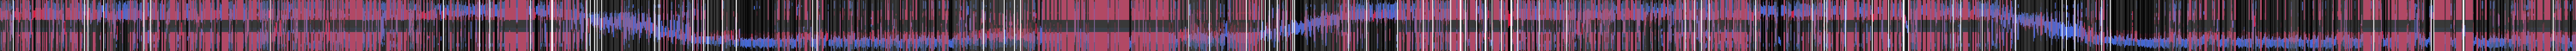

In [ ]:


img_data = np.transpose(img_data, axes=(1, 0, 2)) # Convert to (H, W, 4)
kwargs = {}
desired_height = 400
desired_width = None
skip_img_normalization = True
_out_img = get_array_as_image(img_data, desired_height=desired_height, desired_width=desired_width, skip_img_normalization=skip_img_normalization, export_kind=HeatmapExportKind.RAW_RGBA, **kwargs)
_out_img

In [ ]:
np.shape(_out_img) # np.shape(_out_img)



(100, 1, 4)

In [ ]:
## Write images


global_decoded_result: SingleEpochDecodedResult = a_result.get_result_for_epoch(0)
xbin: NDArray[ND.Shape["N_POS_BINS"], np.floating] = deepcopy(a_decoder.xbin)

## INPUTS: global_decoded_result, xbin
p_x_given_n: NDArray[ND.Shape["N_POS_BINS, 4, N_TIME_BINS"], np.floating] = deepcopy(global_decoded_result.p_x_given_n) # .shape # (59, 4, 69488)
time_bin_centers: NDArray[ND.Shape["N_TIME_BINS"], np.floating] = deepcopy(global_decoded_result.time_bin_container.centers)


# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-MultiDecoderColorOverlayedPosteriors.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
multi_decoder_color_overlay: MultiDecoderColorOverlayedPosteriors = MultiDecoderColorOverlayedPosteriors(spikes_df=deepcopy(get_proper_global_spikes_df(curr_active_pipeline)), p_x_given_n=p_x_given_n, time_bin_centers=time_bin_centers, xbin=xbin, lower_bound_alpha=0.0, drop_below_threshold=1e-3, t_bin_size=0.025)
multi_decoder_color_overlay.compute_all()


# multi_decoder_color_overlay.

### Plot Results

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import MultiDecoderColorOverlayedPosteriors

## INPUTS: multi_decoder_color_overlay

_out_display_dict = multi_decoder_color_overlay.add_tracks_to_spike_raster_window(active_2d_plot=active_2d_plot, dock_identifier_prefix='MergedColorPlot')

In [ ]:
import matplotlib.patches as patches


for a_result_name, (ts_widget, fig, ax_list, dDisplayItem) in _out_display_dict.items():
    print(f'a_result_name: "{a_result_name}"')
    decoder_legend_venn = ts_widget.plots['decoder_legend_venn']
    ax_inset = decoder_legend_venn.get('ax_inset', None)
    
    rounded_rect_inset = decoder_legend_venn.get('background_rounded_rect_inset', None)
    
    # rounded_rect_inset.set_zorder(-5)
    
    ## Build
    if rounded_rect_inset is not None:
        rounded_rect_inset.remove()
        rounded_rect_inset = None

    if rounded_rect_inset is None:
        # Now, add the rounded rectangle patch to the inset axes (ax_inset)
        # We define the rectangle in the coordinate system of ax_inset
        # (0, 0) is the bottom-left corner of ax_inset
        # 1 is the width covering 100% of ax_inset's width
        # 1 is the height covering 100% of ax_inset's height
        rounded_rect_inset = patches.FancyBboxPatch((0, 0), 1, 1,
                                                    boxstyle="round,pad=0.5",
                                                    facecolor='#f5e9e9fa',  # Face color set to white
                                                    edgecolor='#585252fa',
                                                    alpha=0.7, # Alpha set to 0.7
                                                    # mutation_scale=30, # Adjust for desired rounding
                                                    transform=ax_inset.transAxes, # Crucially, use the inset axes' transform
                                                    zorder=-5) # Set a low zorder to be in the background

        # Add the patch to the inset axes
        ax_inset.add_patch(rounded_rect_inset)

        # # Optional: Set limits for the inset axes if needed
        ax_inset.set_xlim(0, 1)
        ax_inset.set_ylim(0, 1)
        
    fig.canvas.draw()
  

    decoder_legend_venn['background_rounded_rect_inset'] = rounded_rect_inset


In [ ]:
fig.canvas.draw()

In [ ]:

## Add overlay plot to hide bins that don't meet the firing criteria:
_plot_low_firing_time_bins_overlay_image(widget=widget, time_bin_edges=time_bin_edges, mask_rgba=mask_rgba)

In [ ]:
all_t_bins_per_decoder_alphas = multi_decoder_color_overlay.extra_all_t_bins_outputs_dict_dict['four_decoders']['all_t_bins_per_decoder_alphas']
all_t_bins_per_decoder_alphas

In [ ]:
all_t_bins_per_decoder_out_RGBA = multi_decoder_color_overlay.extra_all_t_bins_outputs_dict_dict['two_decoders']['all_t_bins_per_decoder_out_RGBA'] #.shape
# multi_decoder_color_overlay.extra_all_t_bins_outputs_dict_dict['two_decoders']['all_t_bins_final_overlayed_out_RGBA'].shape
all_t_bins_per_decoder_alphas = multi_decoder_color_overlay.extra_all_t_bins_outputs_dict_dict['two_decoders']['all_t_bins_per_decoder_alphas']
np.shape(all_t_bins_per_decoder_alphas)
all_t_bins_per_decoder_alpha_weighted_RGBA = multi_decoder_color_overlay.extra_all_t_bins_outputs_dict_dict['two_decoders']['all_t_bins_per_decoder_alpha_weighted_RGBA'] #.shape

all_t_bins_per_decoder_alphas
# all_t_bins_per_decoder_alpha_weighted_RGBA

In [ ]:
handles, labels = ax_inset.get_legend_handles_labels()
handles
labels

In [ ]:
# Create the legend with ncol set to the number of entries
plt.legend(ncol=4)

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML

def create_opacity_slider_widgets(im_posterior_x_dict, color_dict):
    """
    Creates and displays interactive opacity slider widgets for a dictionary of Matplotlib AxesImage objects.

    Args:
        im_posterior_x_dict (dict): A dictionary where keys are layer names and values are
                                     matplotlib.image.AxesImage objects.
        color_dict (dict): A dictionary where keys are layer names (matching im_posterior_x_dict keys)
                             and values are color codes (e.g., '#RRGGBB').

    Returns:
        dict: A dictionary containing the created slider widgets, with keys matching
              the keys of the input dictionaries.
    """
    sliders = {}
    for key, color in color_dict.items():
        label_html = f'<span style="color: {color}; font-weight: bold;">{key.replace("_", " ").title()} Opacity:</span>'
        slider = widgets.FloatSlider(description=label_html, min=0, max=1, step=0.01, value=1.0)
        sliders[key] = slider

    # Get the figure object (assuming all images are on the same figure)
    if im_posterior_x_dict:
        fig = next(iter(im_posterior_x_dict.values())).axes.figure
    else:
        print("Error: im_posterior_x_dict is empty.")
        return sliders

    # Define the update function
    def update_opacity(change, image_object):
        image_object.set_alpha(change.new)
        fig.canvas.draw_idle()

    # Link the sliders to the update functions
    for key, slider in sliders.items():
        if key in im_posterior_x_dict:
            image_object = im_posterior_x_dict[key]
            slider.observe(lambda change, obj=image_object: update_opacity(change, obj), names='value')
        else:
            print(f"Warning: Key '{key}' from color_dict not found in im_posterior_x_dict.")

    # Display the plot and the sliders
    display(fig)
    for slider in sliders.values():
        display(slider)

    return sliders


slider_widgets = create_opacity_slider_widgets(im_posterior_x_dict=im_posterior_x_dict, color_dict=active_colors_dict)


In [ ]:
# Create the sliders
slider1 = widgets.FloatSlider(description='Layer 1 Opacity:', min=0, max=1, step=0.01, value=1.0)
slider2 = widgets.FloatSlider(description='Layer 2 Opacity:', min=0, max=1, step=0.01, value=1.0)
slider3 = widgets.FloatSlider(description='Layer 3 Opacity:', min=0, max=1, step=0.01, value=1.0)
slider4 = widgets.FloatSlider(description='Layer 4 Opacity:', min=0, max=1, step=0.01, value=1.0)

# Define the update functions
def update_opacity1(change):
    im_posterior_x_dict[0].set_alpha(change.new)
    fig.canvas.draw_idle()

def update_opacity2(change):
    im_posterior_x_dict[1].set_alpha(change.new)
    fig.canvas.draw_idle()

def update_opacity3(change):
    im_posterior_x_dict[2].set_alpha(change.new)
    fig.canvas.draw_idle()

def update_opacity4(change):
    im_posterior_x_dict[3].set_alpha(change.new)
    fig.canvas.draw_idle()

# Link the sliders to the update functions
slider1.observe(update_opacity1, names='value')
slider2.observe(update_opacity2, names='value')
slider3.observe(update_opacity3, names='value')
slider4.observe(update_opacity4, names='value')

# Display the plot and the sliders
# display(fig)
display(slider1)
display(slider2)
display(slider3)
display(slider4)

### Spike2DRaster plotting

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import MultiDecoderColorOverlayedPosteriors

all_t_bins_final_RGBA = extra_all_t_bins_outputs_dict['all_t_bins_final_RGBA']

# ts_widget, fig, ax_list, dDisplayItem = MultiDecoderColorOverlayedPosteriors.add_as_track_to_spike_raster_window(active_2d_plot, all_t_bins_final_RGBA=all_t_bins_final_RGBA, t_bin_size=0.025, dock_identifier="PreCombinedRGBA Version")

ts_widget, fig, ax_list, dDisplayItem = MultiDecoderColorOverlayedPosteriors.add_as_track_to_spike_raster_window(active_2d_plot, all_t_bins_final_RGBA=all_t_bins_per_decoder_out_RGBA, t_bin_size=0.025, dock_identifier="PreCombinedRGBA Version")


In [ ]:
all_t_bins_final_RGBA.shape

In [ ]:
ax_name = f'programmatic_test_{special_single_t_bin_per_decoder_RGBA_var_name}'
rgba_layers = np.transpose(single_t_bin_per_decoder_RGBA, (1, 0, 2))[:, :, None, :]  # (n_decoders, H=n_pos_bins, W=1, 4)
print(f'numpy_rgba_composite(...):')
print(f'\trgba_layers.shape: {np.shape(rgba_layers)}')
final_rgba = numpy_rgba_composite(rgba_layers, debug_print=debug_print)  # (H, W, 4) (59, 1, 4)
if debug_print:
    print(f'\tfinal_rgba.shape: {np.shape(final_rgba)} (post call to `numpy_rgba_composite(...)`)')
axd[ax_name].imshow(final_rgba, aspect='auto')
axd[ax_name].set_title(ax_name)
print(f'\tfinal_rgba.shape: {np.shape(final_rgba)}')

## use matplotlib's rendering to get the final output image:
ax_name = f'matplotlib_{special_single_t_bin_per_decoder_RGBA_var_name}'
for i in np.arange(4):
    an_img = single_t_bin_per_decoder_RGBA[:, i, :]
    # an_img = _realphaed_single_t_bin_out_RGBA[:, i, :] # .shape
    an_img = an_img[:, None, :]
    axd[ax_name].imshow(an_img, zorder=i)
    print(f'\t\ti:{i}, an_img.shape: {np.shape(an_img)}')
axd[ax_name].set_title(ax_name)




In [ ]:
all_t_bins_final_RGBA

### BAD PLOPTTINMG

In [ ]:
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
import numpy as np

# Assuming all_t_bins_final_RGBA is your (height, width, 4) numpy array
# Example: all_t_bins_final_RGBA = np.random.randint(0, 256, (100, 100, 4), dtype=np.uint8)

# all_t_bins_final_RGBA = np.transpose(all_t_bins_final_RGBA, (
np.shape(all_t_bins_final_RGBA)

img = np.transpose(deepcopy(all_t_bins_final_RGBA).astype(np.float32), (1, 0, 2))

# The oneliner for plotting:
win = pg.image(img, title="RGBA Image")


# # The oneliner for plotting:
# win = pg.image(all_t_bins_final_RGBA[:, :].T, title="RGBA Image")


### Blend/Combine

In [ ]:
## INPUTS: additional_cmaps

drop_below_threshold: float = 1e-2
## INPUTS: drop_below_threshold: float = 1e-3

a_t_bin_idx = 666

probability_values: NDArray[ND.Shape["N_POS_BINS, 4"], np.floating] = deepcopy(p_x_given_n[:, :, a_t_bin_idx])
# decoder_alphas = np.nansum(p_x_given_n, axis=0) # .shape (4, n_t_bins)

final_overlayed_single_t_bin_out_RGBA, single_t_bin_out_RGBA, _realphaed_single_t_bin_out_RGBA, probability_values, _pre_norm_prob_vals, _all_normed_prob_vals = MultiDecoderColorOverlayedPosteriors._test_single_t_bin(probability_values=probability_values, produce_debug_outputs=True, color_blend_fn=MultiDecoderColorOverlayedPosteriors.composite_over)
# final_overlayed_single_t_bin_out_RGBA # (n_pos_bins, 4) - 4 for RGBA

plt.show()

In [ ]:
a_t_bin_idx = 666
# a_t_bin_idx = 1332
a_t_bin_idx = 1338

# ==================================================================================================================================================================================================================================================================================== #
# Extract from `all_t_bins_per_decoder_out_RGBA`                                                                                                                                                                                                                                                   #
# ==================================================================================================================================================================================================================================================================================== #
## INPUTS: all_t_bins_final_overlayed_out_RGBA, all_t_bins_per_decoder_out_RGBA
single_t_bin_per_decoder_RGBA: NDArray[ND.Shape["N_POS_BINS, 4, 4"], np.floating] = deepcopy(all_t_bins_per_decoder_out_RGBA[a_t_bin_idx, :, :, :])
final_overlayed_single_t_bin_out_RGBA: NDArray[ND.Shape["N_POS_BINS, 4"], np.floating] = deepcopy(all_t_bins_final_overlayed_out_RGBA[a_t_bin_idx, :, :])

## INPUTS: extra_all_t_bins_outputs_dict
all_t_bins_var_names = list(extra_all_t_bins_outputs_dict.keys()) # ['all_t_bins_per_decoder_alphas', 'all_t_bins_per_decoder_alpha_weighted_RGBA']
single_t_bins_var_names = [k.replace('all_t_bins_', 'single_t_bin_') for k in all_t_bins_var_names] # ['single_t_bin_per_decoder_alphas', 'single_t_bin_per_decoder_alpha_weighted_RGBA']

plot_ax_values_dict = dict(single_t_bin_per_decoder_RGBA=single_t_bin_per_decoder_RGBA, 
						#    final_overlayed_single_t_bin_out_RGBA=final_overlayed_single_t_bin_out_RGBA,
						   final_overlayed_single_t_bin_out_RGBA=deepcopy(extra_all_t_bins_outputs_dict['all_t_bins_final_RGBA'][a_t_bin_idx, :, :]),
)
plot_ax_values_dict.update({k.replace('all_t_bins_', 'single_t_bin_'):v[a_t_bin_idx, :, :, :] for k, v in extra_all_t_bins_outputs_dict.items() if np.ndim(v) == 4})

# plot_ax_values_dict = {
#  '_pre_norm_prob_vals': _pre_norm_prob_vals, 'probability_values': probability_values, 'single_t_bin_out_RGBA': single_t_bin_out_RGBA, '_realphaed_single_t_bin_out_RGBA': _realphaed_single_t_bin_out_RGBA,
# }

# fig, axd = _plot_single_t_bin_images(single_t_bin_out_RGBA=single_t_bin_out_RGBA, final_overlayed_single_t_bin_out_RGBA=final_overlayed_single_t_bin_out_RGBA, fig_num='debug_single_t_bin', **plot_ax_values_dict)

fig, axd = MultiDecoderColorOverlayedPosteriors._plot_single_t_bin_images(fig_num='debug_single_t_bin', **plot_ax_values_dict)



In [ ]:


# Example usage:
center_rgba = MultiDecoderColorOverlayedPosteriors.extract_center_rgba_from_figure(fig, axd, n_pos_bins, debug_print=False)
# Now you can use center_rgba for further processing
center_rgba



In [ ]:
plt.figure()
plt.imshow(center_rgba[:, None, :])


In [ ]:
# rgba.shape (n_pos_bins, 4) # th3 4 here is for RGBA, not the decoders
# plt.imshow(rgba)

# img = rgba[:,None,:]            # (59,1,4)
fig = plt.figure(num='test_single_t_bin', layout="constrained", clear=True)
img = single_t_bin_out_RGBA
plt.imshow(img, aspect='auto')
plt.axis('off')
plt.show()


In [ ]:
dict(zip(np.arange(4), list(additional_cmaps.keys())))

